In [1]:
import tensorflow as tf

#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.set_visible_devices(physical_devices[1:],'GPU')

tf.executing_eagerly()
print(tf.executing_eagerly())

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math
import random
import time
import functools

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, Input, layers, models, Model, losses
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from IPython import display
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)
    
tf.device('/GPU:1')
tf.config.experimental.list_physical_devices('GPU')

strategy = tf.distribute.MirroredStrategy()

True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Input data stream

In [2]:
input_params = data = pd.read_table('input_data/condition.txt', header = None)

datasetNo = int(input_params.values[5,2])
interp1 = int(input_params.values[6,2])
interp2 = int(input_params.values[7,2])
n_epochs = int(input_params.values[19,2])
n_epochs_latent = int(input_params.values[20,1])
batch_size = int(input_params.values[21,2])
LR = float(input_params.values[22,2])
Lv1_latent_dim = int(input_params.values[13,2])
Lv2_latent_dim = int(input_params.values[23,2])
alpha = int(input_params.values[24,2])
epoch_1 = int(input_params.values[16,2])

num_param = int(input_params.values[1,2])
num_time = int(input_params.values[2,2])
num_node = int(input_params.values[3,2])
num_var = int(input_params.values[4,2])

print('num_param : ', num_param)
print('num_time : ', num_time)
print('num_node : ', num_node)
print('num_var : ', num_var)
print(' ')
print('datasetNo : ', datasetNo)
print('Interp_lower : ', interp1)
print('Interp_upper : ', interp2)
print('Lv2_epochs : ', n_epochs)
print('Lv2_latent_epochs : ', n_epochs_latent)
print('Lv2_batch_size : ', batch_size)
print('Lv2_learning rate : ', LR)
print('Lv1_latent_dim: ', Lv1_latent_dim)
print('Lv2_latent_dim: ', Lv2_latent_dim)
print('alpha : ', alpha)
print('Lv1_network_to_read : ', epoch_1)

num_param :  10
num_time :  800
num_node :  14300
num_var :  1
 
datasetNo :  2
Interp_lower :  3
Interp_upper :  4
Lv2_epochs :  50000
Lv2_latent_epochs :  10000
Lv2_batch_size :  1
Lv2_learning rate :  5e-05
Lv1_latent_dim:  128
Lv2_latent_dim:  16
alpha :  0
Lv1_network_to_read :  1000


In [3]:
data_save = np.zeros((num_var, num_node,num_param*num_time))
data = np.zeros((num_node,num_param*num_time))

if datasetNo == 1:
    data = pd.read_csv('input_data/FOM_u_sorted.csv', header = None)
    print(data.shape)
    #print(data)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 2:
    del(data)
    data = pd.read_csv('input_data/FOM_v_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 3:
    del(data)
    data = pd.read_csv('input_data/FOM_x_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]

if datasetNo == 4:
    del(data)
    data = pd.read_csv('input_data/FOM_y_sorted.csv', header = None)
    print(data.shape)
    data_save[0,0:num_node,:]=data.values[0:num_node,:]
    del(data)


# Data_save shape : (num_var, num_node, num_time x num_param)

print(data_save.shape)
print(len(np.transpose(data_save)))

data=data_save

(14300, 8000)
(1, 14300, 8000)
8000


In [4]:
FOM_data = np.zeros((num_time, num_param, num_node, num_var))

for i in range(num_var):
    for j in range(num_node):
        for k in range(num_param):
            for l in range(num_time):
                temp = l+k*num_time
                #print(l, k, temp)
                FOM_data[l,k,j,i]=data[i,j,temp]
                
FOM_data.shape

(800, 10, 14300, 1)

In [5]:
maximum = np.amax(FOM_data)
minimum = np.amin(FOM_data)
mean = np.mean(FOM_data)
AT = maximum-minimum

In [6]:
FOM_data = FOM_data-mean
FOM_data = FOM_data/AT
min_FOM = np.min(FOM_data)
FOM_data = FOM_data-min_FOM

In [7]:
f = np.zeros([num_param, num_time, Lv1_latent_dim])

for i in range(num_param):
    filename3 = 'Lv1_latent_vectors/latent_vector_p-s%d_batchnorm' %(i+1)
    temp = np.loadtxt(filename3)
    f[i,:,:] = np.loadtxt(filename3)
    
print(f.shape)

(10, 800, 128)


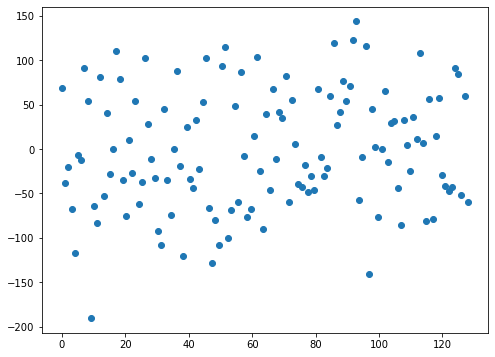

In [8]:
x_axis1 = np.linspace(0,Lv1_latent_dim,Lv1_latent_dim)

plt.scatter(x_axis1, f[0,2,:])

## Scale latent codes from Lv 1.

In [9]:
f_maximum = np.amax(f)
f_minimum = np.amin(f)
f_mean = np.mean(f)
f_AT = f_maximum-f_minimum

f_orig = f

f = f-f_mean
f = f/f_AT
f_minimum = np.min(f)
f = f-f_minimum

print(np.max(f))
print(np.min(f))

1.0
0.0


# Level 2, TVAE (Temporal VAE)

In [10]:
# Lv2_input = (num_param, num_time, Lv1 latent vector dim)

Lv2_input = f
Lv2_input.shape

(10, 800, 128)

In [11]:
#validate

Lv2_input_shape_decoder = Lv2_input.shape[1]
Lv2_input_shape = Lv2_input.shape[1:]

print(Lv2_input.shape)
print(Lv2_input_shape)

(10, 800, 128)
(800, 128)


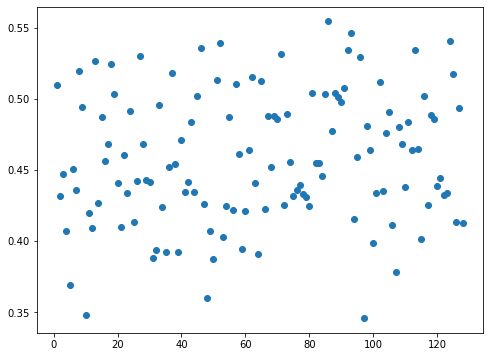

In [12]:
x_axis1 = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)
plt.scatter(x_axis1, Lv2_input[0,0,:])

# Encoder

In [13]:
def encoder():
    x_input=layers.Input(shape=Lv2_input_shape)
    #x=layers.ZeroPadding1D(2)(x_input)
    
    x=layers.Conv1D(64, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x_input)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Conv1D(128, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)   
    
    x=layers.Conv1D(256, 5, strides=1, padding='same', kernel_initializer='glorot_uniform')(x)
    #x=layers.BatchNormalization()(x)
    x=layers.LeakyReLU(0.2)(x)
    x=layers.Dropout(0.3)(x)
    
    x=layers.Flatten()(x)
    
    mu=layers.Dense(Lv2_latent_dim, kernel_initializer='glorot_uniform')(x)
    var=layers.Dense(Lv2_latent_dim, kernel_initializer='glorot_uniform')(x)
    var=layers.Activation(tf.nn.softplus)(var) # var > 0
    
    eps = tf.random.normal(shape=[Lv2_latent_dim], mean=0.0, stddev=1.0)
    z = eps * tf.math.sqrt(var) + mu
    
    en_coder = tf.keras.models.Model(x_input, [mu, var, z], name="ENCODER")
    return en_coder

Encoder=encoder()
Encoder.summary()
#tf.keras.utils.plot_model(Encoder, show_shapes=True)

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 128)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 800, 64)      41024       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 800, 64)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 800, 64)      0           leaky_re_lu[0][0]                
____________________________________________________________________________________________

# Decoder

In [14]:
print(Lv2_latent_dim)
print(Lv2_input_shape_decoder)

16
800


In [15]:
def decoder():
    z_input=layers.Input(shape=(Lv2_latent_dim))
    
    z=layers.Dense(Lv2_input_shape_decoder*Lv2_latent_dim, kernel_initializer='glorot_uniform')(z_input)
    z=layers.LeakyReLU(alpha=0.3)(z)
    
    z=layers.Reshape([Lv2_input_shape_decoder,Lv2_latent_dim])(z)
        
    z=layers.Conv1DTranspose(256, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(128, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)
    
    z=layers.Conv1DTranspose(64, 4, strides=1, padding='same', kernel_initializer='glorot_uniform')(z)
    #z=layers.BatchNormalization()(z)
    z=layers.LeakyReLU(alpha=0.3)(z)
    z=layers.Dropout(0.3)(z)    
    
    ## Changed Dense(1, ...) to Dense(Lv1_latent_dim, ....)
    z_mu=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(z)
    mu_prime=layers.Activation('tanh')(z_mu)
    
    ## Changed Dense(1, ...) to Dense(Lv1_latent_dim, ....)
    z_var=layers.Dense(Lv1_latent_dim, kernel_initializer='glorot_uniform')(z)
    var_prime=layers.Activation(tf.nn.softplus)(z_var) # var > 0
       
    de_coder = tf.keras.models.Model(z_input, [mu_prime, var_prime], name="DECODER")
    return de_coder

Decoder=decoder()
Decoder.summary()
#tf.keras.utils.plot_model(Decoder, show_shapes=True)

Model: "DECODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12800)        217600      input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 12800)        0           dense_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 800, 16)      0           leaky_re_lu_3[0][0]              
____________________________________________________________________________________________

# loss computation

In [16]:
def compute_loss(mu, var, mu_prime, var_prime, real_img, beta):
    
    reconstruction_error = tf.math.reduce_mean(tf.math.reduce_sum((0.5*tf.math.log(var_prime) + tf.math.square(real_img - mu_prime)/(2*var_prime)), 1))
    
    #reconstruction_error = reconstruction_error
    
    KL_divergence = tf.math.reduce_mean(0.5 * tf.math.reduce_sum((tf.math.square(mu) + var - tf.math.log(var) - 1), 1))
    
    #reconstruction_error = reconstruction_error*10
    #KL_divergence = 0
    
    VAE_loss = reconstruction_error + beta * KL_divergence # L(X0)+L(X1)+L(X2)
    
    mu_a = mu[1:num_param-1,:]
    mu_b = (mu[0:num_param-2,:]+mu[2:num_param,:])/2
    var_a = var[1:num_param-1,:]
    var_b = (var[0:num_param-2,:]+var[2:num_param,:])/4

    loss_constraint = tf.math.reduce_mean(0.5 * tf.math.reduce_sum((var_a/var_b + tf.math.square(mu_b - mu_a)/var_b - 1 + tf.math.log(var_b/var_a)),1))
    
    loss = VAE_loss + alpha * loss_constraint
    
    return loss

# VAE

In [17]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, ENCODER, DECODER):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.ENCODER = ENCODER
        self.DECODER = DECODER
        
    def compile(self, opt, loss):
        super(VAE, self).compile()
        self.opt = opt
        self.loss = loss

    def train_step(self, real_img):
        if isinstance(real_img, tuple):
            real_img = real_img[0]
            
        with tf.GradientTape() as tape:
            # encoding
            mu, var, latent_space = self.ENCODER(real_img, training=True)
            
            # decoding
            mu_prime, var_prime = self.DECODER(latent_space, training=True)
            
            # loss calculation
            loss = self.loss(mu, var, mu_prime, var_prime, real_img, beta)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss}


# Save Model

In [18]:
class SaveModel(tf.keras.callbacks.Callback):
    def __init__(self, num_iter=n_epochs, latent_dim=Lv2_latent_dim):
        self.num_iter = num_iter
        self.latent_dim = Lv2_latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        if((epoch+1)%1000==0):
            if((epoch+1)%1000==0):          
                filename1 = 'Lv2_networks/decoder_%d.h5' % (epoch+1)
                filename2 = 'Lv2_networks/encoder_%d.h5' % (epoch+1)
                
                Decoder.save(filename1)
                Encoder.save(filename2)

# Warm up

In [19]:
beta = K.variable(0.)
N_t = int(n_epochs * 0.25)

class WarmUp(tf.keras.callbacks.Callback):
    def __init__(self, beta):
        self.beta = beta
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch < N_t:
            K.set_value(self.beta, epoch / N_t)
        else:
            K.set_value(self.beta, 1)


In [20]:
opt = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.5, beta_2=0.999)

cbk1 = SaveModel(num_iter=n_epochs,latent_dim=Lv2_latent_dim)
cbk2 = WarmUp(beta)

#with strategy.scope():
vae = VAE(latent_dim=Lv2_latent_dim, ENCODER=Encoder, DECODER=Decoder)
vae.compile(opt=opt, loss=compute_loss)

start = time.time()
vae.fit(Lv2_input, batch_size=batch_size, epochs=n_epochs, callbacks=[cbk1, cbk2])
end = time.time()

print(end-start)

Epoch 1/50000
10/10 [==============================] - 595s 12ms/step - loss: -22.7302
Epoch 2/50000
10/10 [==============================] - 0s 10ms/step - loss: -29.3995
Epoch 3/50000
10/10 [==============================] - 0s 8ms/step - loss: -44.8383
Epoch 4/50000
10/10 [==============================] - 0s 9ms/step - loss: -62.2338
Epoch 5/50000
10/10 [==============================] - 0s 9ms/step - loss: -77.9465
Epoch 6/50000
10/10 [==============================] - 0s 8ms/step - loss: -92.2589
Epoch 7/50000
10/10 [==============================] - 0s 10ms/step - loss: -107.6506
Epoch 8/50000
10/10 [==============================] - 0s 9ms/step - loss: -122.3575
Epoch 9/50000
10/10 [==============================] - 0s 10ms/step - loss: -138.6630
Epoch 10/50000
10/10 [==============================] - 0s 8ms/step - loss: -154.5074
Epoch 11/50000
10/10 [==============================] - 0s 8ms/step - loss: -169.3515
Epoch 12/50000
10/10 [==============================] - 0s 10ms

10/10 [==============================] - 0s 10ms/step - loss: -726.9921
Epoch 97/50000
10/10 [==============================] - 0s 9ms/step - loss: -725.4385
Epoch 98/50000
10/10 [==============================] - 0s 8ms/step - loss: -731.9711
Epoch 99/50000
10/10 [==============================] - 0s 8ms/step - loss: -733.6502
Epoch 100/50000
10/10 [==============================] - 0s 9ms/step - loss: -742.3473
Epoch 101/50000
10/10 [==============================] - 0s 8ms/step - loss: -745.7201
Epoch 102/50000
10/10 [==============================] - 0s 8ms/step - loss: -753.6308
Epoch 103/50000
10/10 [==============================] - 0s 7ms/step - loss: -752.7468
Epoch 104/50000
10/10 [==============================] - 0s 7ms/step - loss: -759.2393
Epoch 105/50000
10/10 [==============================] - 0s 9ms/step - loss: -767.5301
Epoch 106/50000
10/10 [==============================] - 0s 9ms/step - loss: -765.7030
Epoch 107/50000
10/10 [==============================] - 0s 1

Epoch 190/50000
10/10 [==============================] - 0s 9ms/step - loss: -1089.4358
Epoch 191/50000
10/10 [==============================] - 0s 9ms/step - loss: -1100.7135
Epoch 192/50000
10/10 [==============================] - 0s 9ms/step - loss: -1110.8033
Epoch 193/50000
10/10 [==============================] - 0s 9ms/step - loss: -1119.2162
Epoch 194/50000
10/10 [==============================] - 0s 9ms/step - loss: -1110.3583
Epoch 195/50000
10/10 [==============================] - 0s 9ms/step - loss: -1113.4034
Epoch 196/50000
10/10 [==============================] - 0s 8ms/step - loss: -1132.6473
Epoch 197/50000
10/10 [==============================] - 0s 8ms/step - loss: -1135.4319
Epoch 198/50000
10/10 [==============================] - 0s 8ms/step - loss: -1127.6177
Epoch 199/50000
10/10 [==============================] - 0s 8ms/step - loss: -1130.3748
Epoch 200/50000
10/10 [==============================] - 0s 8ms/step - loss: -1134.7346
Epoch 201/50000
10/10 [=========

10/10 [==============================] - 0s 9ms/step - loss: -1413.4350
Epoch 284/50000
10/10 [==============================] - 0s 8ms/step - loss: -1421.2505
Epoch 285/50000
10/10 [==============================] - 0s 10ms/step - loss: -1416.3800
Epoch 286/50000
10/10 [==============================] - 0s 10ms/step - loss: -1416.5847
Epoch 287/50000
10/10 [==============================] - 0s 10ms/step - loss: -1422.4593
Epoch 288/50000
10/10 [==============================] - 0s 10ms/step - loss: -1433.6009
Epoch 289/50000
10/10 [==============================] - 0s 8ms/step - loss: -1435.8969
Epoch 290/50000
10/10 [==============================] - 0s 8ms/step - loss: -1410.9544
Epoch 291/50000
10/10 [==============================] - 0s 9ms/step - loss: -1407.4494
Epoch 292/50000
10/10 [==============================] - 0s 9ms/step - loss: -1430.9177
Epoch 293/50000
10/10 [==============================] - 0s 11ms/step - loss: -1443.1219
Epoch 294/50000
10/10 [====================

10/10 [==============================] - 0s 8ms/step - loss: -1572.3754
Epoch 377/50000
10/10 [==============================] - 0s 8ms/step - loss: -1554.5414
Epoch 378/50000
10/10 [==============================] - 0s 9ms/step - loss: -1547.8121
Epoch 379/50000
10/10 [==============================] - 0s 8ms/step - loss: -1551.8596
Epoch 380/50000
10/10 [==============================] - 0s 10ms/step - loss: -1552.2598
Epoch 381/50000
10/10 [==============================] - 0s 9ms/step - loss: -1535.7052
Epoch 382/50000
10/10 [==============================] - 0s 9ms/step - loss: -1546.7925
Epoch 383/50000
10/10 [==============================] - 0s 8ms/step - loss: -1560.0154
Epoch 384/50000
10/10 [==============================] - 0s 8ms/step - loss: -1573.8932
Epoch 385/50000
10/10 [==============================] - 0s 7ms/step - loss: -1541.2185
Epoch 386/50000
10/10 [==============================] - 0s 10ms/step - loss: -1561.7518
Epoch 387/50000
10/10 [=======================

10/10 [==============================] - 0s 8ms/step - loss: -1629.2629
Epoch 470/50000
10/10 [==============================] - 0s 9ms/step - loss: -1600.5493
Epoch 471/50000
10/10 [==============================] - 0s 8ms/step - loss: -1627.4623
Epoch 472/50000
10/10 [==============================] - 0s 8ms/step - loss: -1601.5120
Epoch 473/50000
10/10 [==============================] - 0s 9ms/step - loss: -1609.5002
Epoch 474/50000
10/10 [==============================] - 0s 7ms/step - loss: -1601.9131
Epoch 475/50000
10/10 [==============================] - 0s 7ms/step - loss: -1614.9404
Epoch 476/50000
10/10 [==============================] - 0s 8ms/step - loss: -1613.2729
Epoch 477/50000
10/10 [==============================] - 0s 9ms/step - loss: -1623.4080
Epoch 478/50000
10/10 [==============================] - 0s 8ms/step - loss: -1628.3418
Epoch 479/50000
10/10 [==============================] - 0s 7ms/step - loss: -1629.6330
Epoch 480/50000
10/10 [=========================

10/10 [==============================] - 0s 8ms/step - loss: -1657.7110
Epoch 563/50000
10/10 [==============================] - 0s 9ms/step - loss: -1658.4799
Epoch 564/50000
10/10 [==============================] - 0s 9ms/step - loss: -1649.5813
Epoch 565/50000
10/10 [==============================] - 0s 9ms/step - loss: -1649.3360
Epoch 566/50000
10/10 [==============================] - 0s 9ms/step - loss: -1649.0819
Epoch 567/50000
10/10 [==============================] - 0s 8ms/step - loss: -1641.0287
Epoch 568/50000
10/10 [==============================] - 0s 8ms/step - loss: -1659.8992
Epoch 569/50000
10/10 [==============================] - 0s 10ms/step - loss: -1645.3304
Epoch 570/50000
10/10 [==============================] - 0s 8ms/step - loss: -1642.8834
Epoch 571/50000
10/10 [==============================] - 0s 7ms/step - loss: -1653.5474
Epoch 572/50000
10/10 [==============================] - 0s 8ms/step - loss: -1631.7622
Epoch 573/50000
10/10 [========================

10/10 [==============================] - 0s 10ms/step - loss: -1683.8842
Epoch 656/50000
10/10 [==============================] - 0s 7ms/step - loss: -1709.6234
Epoch 657/50000
10/10 [==============================] - 0s 9ms/step - loss: -1691.4570
Epoch 658/50000
10/10 [==============================] - 0s 8ms/step - loss: -1690.5293
Epoch 659/50000
10/10 [==============================] - 0s 9ms/step - loss: -1705.2477
Epoch 660/50000
10/10 [==============================] - 0s 9ms/step - loss: -1678.7065
Epoch 661/50000
10/10 [==============================] - 0s 10ms/step - loss: -1683.4323
Epoch 662/50000
10/10 [==============================] - 0s 7ms/step - loss: -1658.7183
Epoch 663/50000
10/10 [==============================] - 0s 8ms/step - loss: -1709.9539
Epoch 664/50000
10/10 [==============================] - 0s 8ms/step - loss: -1688.2688
Epoch 665/50000
10/10 [==============================] - 0s 8ms/step - loss: -1678.5932
Epoch 666/50000
10/10 [=======================

10/10 [==============================] - 0s 8ms/step - loss: -1707.6743
Epoch 749/50000
10/10 [==============================] - 0s 8ms/step - loss: -1699.8145
Epoch 750/50000
10/10 [==============================] - 0s 8ms/step - loss: -1720.4914
Epoch 751/50000
10/10 [==============================] - 0s 8ms/step - loss: -1683.6252
Epoch 752/50000
10/10 [==============================] - 0s 10ms/step - loss: -1712.0216
Epoch 753/50000
10/10 [==============================] - 0s 9ms/step - loss: -1719.5387
Epoch 754/50000
10/10 [==============================] - 0s 9ms/step - loss: -1714.2079
Epoch 755/50000
10/10 [==============================] - 0s 8ms/step - loss: -1700.8268
Epoch 756/50000
10/10 [==============================] - 0s 9ms/step - loss: -1709.9502
Epoch 757/50000
10/10 [==============================] - 0s 9ms/step - loss: -1728.2421
Epoch 758/50000
10/10 [==============================] - 0s 7ms/step - loss: -1709.3588
Epoch 759/50000
10/10 [========================

10/10 [==============================] - 0s 10ms/step - loss: -1748.7460
Epoch 842/50000
10/10 [==============================] - 0s 8ms/step - loss: -1728.6911
Epoch 843/50000
10/10 [==============================] - 0s 8ms/step - loss: -1703.5522
Epoch 844/50000
10/10 [==============================] - 0s 8ms/step - loss: -1718.9220
Epoch 845/50000
10/10 [==============================] - 0s 9ms/step - loss: -1760.8894
Epoch 846/50000
10/10 [==============================] - 0s 9ms/step - loss: -1753.3150
Epoch 847/50000
10/10 [==============================] - 0s 10ms/step - loss: -1732.2455
Epoch 848/50000
10/10 [==============================] - 0s 9ms/step - loss: -1725.1718
Epoch 849/50000
10/10 [==============================] - 0s 9ms/step - loss: -1763.3976
Epoch 850/50000
10/10 [==============================] - 0s 9ms/step - loss: -1728.6104
Epoch 851/50000
10/10 [==============================] - 0s 8ms/step - loss: -1747.9433
Epoch 852/50000
10/10 [=======================

10/10 [==============================] - 0s 8ms/step - loss: -1726.0030
Epoch 935/50000
10/10 [==============================] - 0s 9ms/step - loss: -1723.0126
Epoch 936/50000
10/10 [==============================] - 0s 9ms/step - loss: -1765.1093
Epoch 937/50000
10/10 [==============================] - 0s 9ms/step - loss: -1726.0761
Epoch 938/50000
10/10 [==============================] - 0s 10ms/step - loss: -1742.8497
Epoch 939/50000
10/10 [==============================] - 0s 8ms/step - loss: -1759.3524
Epoch 940/50000
10/10 [==============================] - 0s 8ms/step - loss: -1762.0610
Epoch 941/50000
10/10 [==============================] - 0s 8ms/step - loss: -1746.0276
Epoch 942/50000
10/10 [==============================] - 0s 9ms/step - loss: -1755.1652
Epoch 943/50000
10/10 [==============================] - 0s 9ms/step - loss: -1779.0452
Epoch 944/50000
10/10 [==============================] - 0s 8ms/step - loss: -1759.9265
Epoch 945/50000
10/10 [========================

10/10 [==============================] - 0s 8ms/step - loss: -1759.2459
Epoch 1024/50000
10/10 [==============================] - 0s 10ms/step - loss: -1783.4899
Epoch 1025/50000
10/10 [==============================] - 0s 8ms/step - loss: -1785.4963
Epoch 1026/50000
10/10 [==============================] - 0s 9ms/step - loss: -1774.0124
Epoch 1027/50000
10/10 [==============================] - 0s 10ms/step - loss: -1758.1917
Epoch 1028/50000
10/10 [==============================] - 0s 8ms/step - loss: -1769.8328
Epoch 1029/50000
10/10 [==============================] - 0s 9ms/step - loss: -1759.0965
Epoch 1030/50000
10/10 [==============================] - 0s 10ms/step - loss: -1769.7029
Epoch 1031/50000
10/10 [==============================] - 0s 9ms/step - loss: -1790.3869
Epoch 1032/50000
10/10 [==============================] - 0s 8ms/step - loss: -1792.8325
Epoch 1033/50000
10/10 [==============================] - 0s 9ms/step - loss: -1765.4736
Epoch 1034/50000
10/10 [===========

10/10 [==============================] - 0s 9ms/step - loss: -1797.2282
Epoch 1116/50000
10/10 [==============================] - 0s 9ms/step - loss: -1799.1284
Epoch 1117/50000
10/10 [==============================] - 0s 7ms/step - loss: -1768.5974
Epoch 1118/50000
10/10 [==============================] - 0s 9ms/step - loss: -1769.2786
Epoch 1119/50000
10/10 [==============================] - 0s 9ms/step - loss: -1806.6165
Epoch 1120/50000
10/10 [==============================] - 0s 9ms/step - loss: -1768.2505
Epoch 1121/50000
10/10 [==============================] - 0s 8ms/step - loss: -1776.2145
Epoch 1122/50000
10/10 [==============================] - 0s 8ms/step - loss: -1785.7454
Epoch 1123/50000
10/10 [==============================] - 0s 8ms/step - loss: -1753.7807
Epoch 1124/50000
10/10 [==============================] - 0s 9ms/step - loss: -1780.7349
Epoch 1125/50000
10/10 [==============================] - 0s 9ms/step - loss: -1808.6571
Epoch 1126/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -1765.2177
Epoch 1208/50000
10/10 [==============================] - 0s 10ms/step - loss: -1779.8244
Epoch 1209/50000
10/10 [==============================] - 0s 9ms/step - loss: -1783.8919
Epoch 1210/50000
10/10 [==============================] - 0s 9ms/step - loss: -1776.5122
Epoch 1211/50000
10/10 [==============================] - 0s 10ms/step - loss: -1789.5143
Epoch 1212/50000
10/10 [==============================] - 0s 9ms/step - loss: -1764.5400
Epoch 1213/50000
10/10 [==============================] - 0s 7ms/step - loss: -1785.0054
Epoch 1214/50000
10/10 [==============================] - 0s 8ms/step - loss: -1800.6382
Epoch 1215/50000
10/10 [==============================] - 0s 9ms/step - loss: -1797.0615
Epoch 1216/50000
10/10 [==============================] - 0s 8ms/step - loss: -1816.6704
Epoch 1217/50000
10/10 [==============================] - 0s 8ms/step - loss: -1776.4605
Epoch 1218/50000
10/10 [============

10/10 [==============================] - 0s 9ms/step - loss: -1780.7039
Epoch 1300/50000
10/10 [==============================] - 0s 9ms/step - loss: -1792.8965
Epoch 1301/50000
10/10 [==============================] - 0s 8ms/step - loss: -1826.0873
Epoch 1302/50000
10/10 [==============================] - 0s 8ms/step - loss: -1796.2873
Epoch 1303/50000
10/10 [==============================] - 0s 8ms/step - loss: -1790.9308
Epoch 1304/50000
10/10 [==============================] - 0s 10ms/step - loss: -1841.8635
Epoch 1305/50000
10/10 [==============================] - 0s 9ms/step - loss: -1793.6985
Epoch 1306/50000
10/10 [==============================] - 0s 9ms/step - loss: -1809.5180
Epoch 1307/50000
10/10 [==============================] - 0s 8ms/step - loss: -1798.5297
Epoch 1308/50000
10/10 [==============================] - 0s 9ms/step - loss: -1820.0378
Epoch 1309/50000
10/10 [==============================] - 0s 9ms/step - loss: -1805.8915
Epoch 1310/50000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: -1786.3165
Epoch 1392/50000
10/10 [==============================] - 0s 8ms/step - loss: -1844.4532
Epoch 1393/50000
10/10 [==============================] - 0s 8ms/step - loss: -1834.2775
Epoch 1394/50000
10/10 [==============================] - 0s 8ms/step - loss: -1822.7674
Epoch 1395/50000
10/10 [==============================] - 0s 9ms/step - loss: -1811.4737
Epoch 1396/50000
10/10 [==============================] - 0s 9ms/step - loss: -1848.8485
Epoch 1397/50000
10/10 [==============================] - 0s 8ms/step - loss: -1804.6846
Epoch 1398/50000
10/10 [==============================] - 0s 9ms/step - loss: -1827.0999
Epoch 1399/50000
10/10 [==============================] - 0s 9ms/step - loss: -1817.5638
Epoch 1400/50000
10/10 [==============================] - 0s 8ms/step - loss: -1813.7444
Epoch 1401/50000
10/10 [==============================] - 0s 8ms/step - loss: -1819.6609
Epoch 1402/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -1810.7848
Epoch 1484/50000
10/10 [==============================] - 0s 8ms/step - loss: -1811.4559
Epoch 1485/50000
10/10 [==============================] - 0s 9ms/step - loss: -1821.5328
Epoch 1486/50000
10/10 [==============================] - 0s 9ms/step - loss: -1846.0006
Epoch 1487/50000
10/10 [==============================] - 0s 8ms/step - loss: -1816.0506
Epoch 1488/50000
10/10 [==============================] - 0s 8ms/step - loss: -1849.7800
Epoch 1489/50000
10/10 [==============================] - 0s 9ms/step - loss: -1846.0877
Epoch 1490/50000
10/10 [==============================] - 0s 9ms/step - loss: -1818.9141
Epoch 1491/50000
10/10 [==============================] - 0s 8ms/step - loss: -1814.1629
Epoch 1492/50000
10/10 [==============================] - 0s 9ms/step - loss: -1819.8260
Epoch 1493/50000
10/10 [==============================] - 0s 9ms/step - loss: -1835.5145
Epoch 1494/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -1837.4266
Epoch 1576/50000
10/10 [==============================] - 0s 9ms/step - loss: -1817.2641
Epoch 1577/50000
10/10 [==============================] - 0s 8ms/step - loss: -1809.1064
Epoch 1578/50000
10/10 [==============================] - 0s 8ms/step - loss: -1872.5470
Epoch 1579/50000
10/10 [==============================] - 0s 8ms/step - loss: -1810.2197
Epoch 1580/50000
10/10 [==============================] - 0s 8ms/step - loss: -1821.2546
Epoch 1581/50000
10/10 [==============================] - 0s 9ms/step - loss: -1859.3552
Epoch 1582/50000
10/10 [==============================] - 0s 8ms/step - loss: -1831.7544
Epoch 1583/50000
10/10 [==============================] - 0s 9ms/step - loss: -1828.0219
Epoch 1584/50000
10/10 [==============================] - 0s 10ms/step - loss: -1850.4404
Epoch 1585/50000
10/10 [==============================] - 0s 9ms/step - loss: -1834.8164
Epoch 1586/50000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: -1850.4827
Epoch 1668/50000
10/10 [==============================] - 0s 8ms/step - loss: -1882.2242
Epoch 1669/50000
10/10 [==============================] - 0s 9ms/step - loss: -1869.7694
Epoch 1670/50000
10/10 [==============================] - 0s 8ms/step - loss: -1853.4511
Epoch 1671/50000
10/10 [==============================] - 0s 9ms/step - loss: -1821.5553
Epoch 1672/50000
10/10 [==============================] - 0s 8ms/step - loss: -1872.8608
Epoch 1673/50000
10/10 [==============================] - 0s 7ms/step - loss: -1847.7201
Epoch 1674/50000
10/10 [==============================] - 0s 7ms/step - loss: -1843.5956
Epoch 1675/50000
10/10 [==============================] - 0s 8ms/step - loss: -1840.6539
Epoch 1676/50000
10/10 [==============================] - 0s 9ms/step - loss: -1851.4039
Epoch 1677/50000
10/10 [==============================] - 0s 10ms/step - loss: -1849.9670
Epoch 1678/50000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: -1855.4838
Epoch 1760/50000
10/10 [==============================] - 0s 10ms/step - loss: -1847.4516
Epoch 1761/50000
10/10 [==============================] - 0s 7ms/step - loss: -1842.5208
Epoch 1762/50000
10/10 [==============================] - 0s 8ms/step - loss: -1878.0779
Epoch 1763/50000
10/10 [==============================] - 0s 9ms/step - loss: -1862.4603
Epoch 1764/50000
10/10 [==============================] - 0s 8ms/step - loss: -1869.1584
Epoch 1765/50000
10/10 [==============================] - 0s 8ms/step - loss: -1831.8403
Epoch 1766/50000
10/10 [==============================] - 0s 9ms/step - loss: -1852.2749
Epoch 1767/50000
10/10 [==============================] - 0s 8ms/step - loss: -1864.9413
Epoch 1768/50000
10/10 [==============================] - 0s 9ms/step - loss: -1895.1762
Epoch 1769/50000
10/10 [==============================] - 0s 8ms/step - loss: -1833.8091
Epoch 1770/50000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: -1864.0326
Epoch 1852/50000
10/10 [==============================] - 0s 7ms/step - loss: -1851.2267
Epoch 1853/50000
10/10 [==============================] - 0s 10ms/step - loss: -1856.3571
Epoch 1854/50000
10/10 [==============================] - 0s 8ms/step - loss: -1841.4259
Epoch 1855/50000
10/10 [==============================] - 0s 8ms/step - loss: -1861.8879
Epoch 1856/50000
10/10 [==============================] - 0s 9ms/step - loss: -1842.0637
Epoch 1857/50000
10/10 [==============================] - 0s 8ms/step - loss: -1865.5827
Epoch 1858/50000
10/10 [==============================] - 0s 7ms/step - loss: -1906.8657
Epoch 1859/50000
10/10 [==============================] - 0s 8ms/step - loss: -1861.6000
Epoch 1860/50000
10/10 [==============================] - 0s 7ms/step - loss: -1858.2323
Epoch 1861/50000
10/10 [==============================] - 0s 9ms/step - loss: -1861.0126
Epoch 1862/50000
10/10 [=============

10/10 [==============================] - 0s 10ms/step - loss: -1853.9028
Epoch 1944/50000
10/10 [==============================] - 0s 9ms/step - loss: -1875.6152
Epoch 1945/50000
10/10 [==============================] - 0s 8ms/step - loss: -1884.4762
Epoch 1946/50000
10/10 [==============================] - 0s 9ms/step - loss: -1879.9873
Epoch 1947/50000
10/10 [==============================] - 0s 9ms/step - loss: -1877.6594
Epoch 1948/50000
10/10 [==============================] - 0s 7ms/step - loss: -1870.1156
Epoch 1949/50000
10/10 [==============================] - 0s 9ms/step - loss: -1887.3323
Epoch 1950/50000
10/10 [==============================] - 0s 7ms/step - loss: -1888.0019
Epoch 1951/50000
10/10 [==============================] - 0s 8ms/step - loss: -1915.5429
Epoch 1952/50000
10/10 [==============================] - 0s 8ms/step - loss: -1867.6395
Epoch 1953/50000
10/10 [==============================] - 0s 8ms/step - loss: -1871.3227
Epoch 1954/50000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: -1883.7301
Epoch 2032/50000
10/10 [==============================] - 0s 8ms/step - loss: -1858.7474
Epoch 2033/50000
10/10 [==============================] - 0s 8ms/step - loss: -1885.9743
Epoch 2034/50000
10/10 [==============================] - 0s 8ms/step - loss: -1890.1784
Epoch 2035/50000
10/10 [==============================] - 0s 8ms/step - loss: -1880.4681
Epoch 2036/50000
10/10 [==============================] - 0s 7ms/step - loss: -1894.0061
Epoch 2037/50000
10/10 [==============================] - 0s 8ms/step - loss: -1933.8187
Epoch 2038/50000
10/10 [==============================] - 0s 9ms/step - loss: -1893.0842
Epoch 2039/50000
10/10 [==============================] - 0s 9ms/step - loss: -1890.2157
Epoch 2040/50000
10/10 [==============================] - 0s 9ms/step - loss: -1910.9539
Epoch 2041/50000
10/10 [==============================] - 0s 9ms/step - loss: -1893.1538
Epoch 2042/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -1936.5199
Epoch 2124/50000
10/10 [==============================] - 0s 9ms/step - loss: -1895.9898
Epoch 2125/50000
10/10 [==============================] - 0s 10ms/step - loss: -1920.1558
Epoch 2126/50000
10/10 [==============================] - 0s 9ms/step - loss: -1907.8225
Epoch 2127/50000
10/10 [==============================] - 0s 10ms/step - loss: -1940.4951
Epoch 2128/50000
10/10 [==============================] - 0s 9ms/step - loss: -1891.1871
Epoch 2129/50000
10/10 [==============================] - 0s 7ms/step - loss: -1945.0671
Epoch 2130/50000
10/10 [==============================] - 0s 7ms/step - loss: -1912.1171
Epoch 2131/50000
10/10 [==============================] - 0s 7ms/step - loss: -1907.8034
Epoch 2132/50000
10/10 [==============================] - 0s 8ms/step - loss: -1901.3704
Epoch 2133/50000
10/10 [==============================] - 0s 8ms/step - loss: -1888.3223
Epoch 2134/50000
10/10 [============

10/10 [==============================] - 0s 9ms/step - loss: -1904.7786
Epoch 2216/50000
10/10 [==============================] - 0s 9ms/step - loss: -1952.5413
Epoch 2217/50000
10/10 [==============================] - 0s 8ms/step - loss: -1912.9791
Epoch 2218/50000
10/10 [==============================] - 0s 8ms/step - loss: -1934.8028
Epoch 2219/50000
10/10 [==============================] - 0s 9ms/step - loss: -1929.4254
Epoch 2220/50000
10/10 [==============================] - 0s 9ms/step - loss: -1879.0748
Epoch 2221/50000
10/10 [==============================] - 0s 9ms/step - loss: -1913.2372
Epoch 2222/50000
10/10 [==============================] - 0s 9ms/step - loss: -1905.1177
Epoch 2223/50000
10/10 [==============================] - 0s 9ms/step - loss: -1928.3047
Epoch 2224/50000
10/10 [==============================] - 0s 9ms/step - loss: -1948.4328
Epoch 2225/50000
10/10 [==============================] - 0s 9ms/step - loss: -1930.0401
Epoch 2226/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -1916.4633
Epoch 2308/50000
10/10 [==============================] - 0s 9ms/step - loss: -1964.6774
Epoch 2309/50000
10/10 [==============================] - 0s 8ms/step - loss: -1911.6218
Epoch 2310/50000
10/10 [==============================] - 0s 8ms/step - loss: -1937.8752
Epoch 2311/50000
10/10 [==============================] - 0s 7ms/step - loss: -1958.3452
Epoch 2312/50000
10/10 [==============================] - 0s 8ms/step - loss: -1936.8138
Epoch 2313/50000
10/10 [==============================] - 0s 8ms/step - loss: -1904.7478
Epoch 2314/50000
10/10 [==============================] - 0s 9ms/step - loss: -1936.0971
Epoch 2315/50000
10/10 [==============================] - 0s 8ms/step - loss: -1918.5466
Epoch 2316/50000
10/10 [==============================] - 0s 8ms/step - loss: -1889.6251
Epoch 2317/50000
10/10 [==============================] - 0s 8ms/step - loss: -1942.0402
Epoch 2318/50000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: -1958.6277
Epoch 2400/50000
10/10 [==============================] - 0s 9ms/step - loss: -1942.1070
Epoch 2401/50000
10/10 [==============================] - 0s 8ms/step - loss: -1922.5323
Epoch 2402/50000
10/10 [==============================] - 0s 8ms/step - loss: -1945.4327
Epoch 2403/50000
10/10 [==============================] - 0s 8ms/step - loss: -1955.6825
Epoch 2404/50000
10/10 [==============================] - 0s 8ms/step - loss: -1956.7599
Epoch 2405/50000
10/10 [==============================] - 0s 8ms/step - loss: -1923.3192
Epoch 2406/50000
10/10 [==============================] - 0s 8ms/step - loss: -1900.9257
Epoch 2407/50000
10/10 [==============================] - 0s 7ms/step - loss: -1923.0149
Epoch 2408/50000
10/10 [==============================] - 0s 8ms/step - loss: -1929.7663
Epoch 2409/50000
10/10 [==============================] - 0s 9ms/step - loss: -1933.7499
Epoch 2410/50000
10/10 [==============

10/10 [==============================] - 0s 10ms/step - loss: -1923.5064
Epoch 2492/50000
10/10 [==============================] - 0s 8ms/step - loss: -1932.1800
Epoch 2493/50000
10/10 [==============================] - 0s 9ms/step - loss: -1966.9121
Epoch 2494/50000
10/10 [==============================] - 0s 9ms/step - loss: -1931.9799
Epoch 2495/50000
10/10 [==============================] - 0s 9ms/step - loss: -1908.6013
Epoch 2496/50000
10/10 [==============================] - 0s 9ms/step - loss: -1928.6095
Epoch 2497/50000
10/10 [==============================] - 0s 10ms/step - loss: -1969.8018
Epoch 2498/50000
10/10 [==============================] - 0s 9ms/step - loss: -1956.1277
Epoch 2499/50000
10/10 [==============================] - 0s 9ms/step - loss: -1928.7223
Epoch 2500/50000
10/10 [==============================] - 0s 11ms/step - loss: -1943.7533
Epoch 2501/50000
10/10 [==============================] - 0s 8ms/step - loss: -1948.0453
Epoch 2502/50000
10/10 [===========

10/10 [==============================] - 0s 8ms/step - loss: -1919.1383
Epoch 2584/50000
10/10 [==============================] - 0s 9ms/step - loss: -1985.2851
Epoch 2585/50000
10/10 [==============================] - 0s 8ms/step - loss: -1941.8474
Epoch 2586/50000
10/10 [==============================] - 0s 9ms/step - loss: -1952.5428
Epoch 2587/50000
10/10 [==============================] - 0s 9ms/step - loss: -1923.0829
Epoch 2588/50000
10/10 [==============================] - 0s 8ms/step - loss: -1953.8492
Epoch 2589/50000
10/10 [==============================] - 0s 8ms/step - loss: -1941.5399
Epoch 2590/50000
10/10 [==============================] - 0s 8ms/step - loss: -1930.1314
Epoch 2591/50000
10/10 [==============================] - 0s 9ms/step - loss: -1990.8635
Epoch 2592/50000
10/10 [==============================] - 0s 8ms/step - loss: -1955.2144
Epoch 2593/50000
10/10 [==============================] - 0s 8ms/step - loss: -1947.4465
Epoch 2594/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -1993.6445
Epoch 2676/50000
10/10 [==============================] - 0s 8ms/step - loss: -1954.8472
Epoch 2677/50000
10/10 [==============================] - 0s 8ms/step - loss: -1951.3220
Epoch 2678/50000
10/10 [==============================] - 0s 8ms/step - loss: -1949.0654
Epoch 2679/50000
10/10 [==============================] - 0s 8ms/step - loss: -1930.2207
Epoch 2680/50000
10/10 [==============================] - 0s 8ms/step - loss: -1943.7586
Epoch 2681/50000
10/10 [==============================] - 0s 9ms/step - loss: -1947.2478
Epoch 2682/50000
10/10 [==============================] - 0s 9ms/step - loss: -1970.8781
Epoch 2683/50000
10/10 [==============================] - 0s 8ms/step - loss: -1926.2766
Epoch 2684/50000
10/10 [==============================] - 0s 8ms/step - loss: -1950.0696
Epoch 2685/50000
10/10 [==============================] - 0s 8ms/step - loss: -1949.1595
Epoch 2686/50000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: -1961.9546
Epoch 2768/50000
10/10 [==============================] - 0s 8ms/step - loss: -1995.6950
Epoch 2769/50000
10/10 [==============================] - 0s 9ms/step - loss: -1967.4267
Epoch 2770/50000
10/10 [==============================] - 0s 9ms/step - loss: -1994.8383
Epoch 2771/50000
10/10 [==============================] - 0s 7ms/step - loss: -1993.6819
Epoch 2772/50000
10/10 [==============================] - 0s 8ms/step - loss: -1990.6129
Epoch 2773/50000
10/10 [==============================] - 0s 8ms/step - loss: -1983.5180
Epoch 2774/50000
10/10 [==============================] - 0s 7ms/step - loss: -1982.8539
Epoch 2775/50000
10/10 [==============================] - 0s 8ms/step - loss: -1946.3957
Epoch 2776/50000
10/10 [==============================] - 0s 8ms/step - loss: -1983.7843
Epoch 2777/50000
10/10 [==============================] - 0s 9ms/step - loss: -1946.3478
Epoch 2778/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -1960.8880
Epoch 2860/50000
10/10 [==============================] - 0s 8ms/step - loss: -2016.8411
Epoch 2861/50000
10/10 [==============================] - 0s 7ms/step - loss: -2003.7645
Epoch 2862/50000
10/10 [==============================] - 0s 8ms/step - loss: -2010.7496
Epoch 2863/50000
10/10 [==============================] - 0s 8ms/step - loss: -1998.3618
Epoch 2864/50000
10/10 [==============================] - 0s 8ms/step - loss: -1990.7645
Epoch 2865/50000
10/10 [==============================] - 0s 8ms/step - loss: -1956.0336
Epoch 2866/50000
10/10 [==============================] - 0s 8ms/step - loss: -1968.3908
Epoch 2867/50000
10/10 [==============================] - 0s 8ms/step - loss: -2013.8492
Epoch 2868/50000
10/10 [==============================] - 0s 7ms/step - loss: -2013.7865
Epoch 2869/50000
10/10 [==============================] - 0s 9ms/step - loss: -1972.9584
Epoch 2870/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -2001.3831
Epoch 2952/50000
10/10 [==============================] - 0s 10ms/step - loss: -1985.1687
Epoch 2953/50000
10/10 [==============================] - 0s 9ms/step - loss: -1977.0286
Epoch 2954/50000
10/10 [==============================] - 0s 8ms/step - loss: -1992.8786
Epoch 2955/50000
10/10 [==============================] - 0s 8ms/step - loss: -1978.2904
Epoch 2956/50000
10/10 [==============================] - 0s 8ms/step - loss: -1983.5587
Epoch 2957/50000
10/10 [==============================] - 0s 9ms/step - loss: -1975.5078
Epoch 2958/50000
10/10 [==============================] - 0s 9ms/step - loss: -1979.7397
Epoch 2959/50000
10/10 [==============================] - 0s 10ms/step - loss: -1953.4253
Epoch 2960/50000
10/10 [==============================] - 0s 9ms/step - loss: -1977.0079
Epoch 2961/50000
10/10 [==============================] - 0s 9ms/step - loss: -2001.4203
Epoch 2962/50000
10/10 [============

10/10 [==============================] - 0s 9ms/step - loss: -1989.6705
Epoch 3040/50000
10/10 [==============================] - 0s 9ms/step - loss: -2029.0984
Epoch 3041/50000
10/10 [==============================] - 0s 9ms/step - loss: -1994.5827
Epoch 3042/50000
10/10 [==============================] - 0s 9ms/step - loss: -1997.0051
Epoch 3043/50000
10/10 [==============================] - 0s 8ms/step - loss: -1983.8688
Epoch 3044/50000
10/10 [==============================] - 0s 10ms/step - loss: -1985.7713
Epoch 3045/50000
10/10 [==============================] - 0s 8ms/step - loss: -2020.2810
Epoch 3046/50000
10/10 [==============================] - 0s 8ms/step - loss: -1973.3915
Epoch 3047/50000
10/10 [==============================] - 0s 8ms/step - loss: -1962.6669
Epoch 3048/50000
10/10 [==============================] - 0s 8ms/step - loss: -1988.1106
Epoch 3049/50000
10/10 [==============================] - 0s 8ms/step - loss: -2000.6361
Epoch 3050/50000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: -2028.5945
Epoch 3132/50000
10/10 [==============================] - 0s 10ms/step - loss: -1998.6038
Epoch 3133/50000
10/10 [==============================] - 0s 8ms/step - loss: -2005.5492
Epoch 3134/50000
10/10 [==============================] - 0s 9ms/step - loss: -1992.4750
Epoch 3135/50000
10/10 [==============================] - 0s 9ms/step - loss: -1996.2600
Epoch 3136/50000
10/10 [==============================] - 0s 8ms/step - loss: -2010.4625
Epoch 3137/50000
10/10 [==============================] - 0s 8ms/step - loss: -1989.5192
Epoch 3138/50000
10/10 [==============================] - 0s 8ms/step - loss: -1993.2653
Epoch 3139/50000
10/10 [==============================] - 0s 9ms/step - loss: -1994.9537
Epoch 3140/50000
10/10 [==============================] - 0s 8ms/step - loss: -2029.0033
Epoch 3141/50000
10/10 [==============================] - 0s 9ms/step - loss: -2024.1051
Epoch 3142/50000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: -2020.9144
Epoch 3224/50000
10/10 [==============================] - 0s 8ms/step - loss: -2004.6910
Epoch 3225/50000
10/10 [==============================] - 0s 8ms/step - loss: -2003.1484
Epoch 3226/50000
10/10 [==============================] - 0s 9ms/step - loss: -1991.4637
Epoch 3227/50000
10/10 [==============================] - 0s 8ms/step - loss: -2008.0455
Epoch 3228/50000
10/10 [==============================] - 0s 9ms/step - loss: -2030.4889
Epoch 3229/50000
10/10 [==============================] - 0s 8ms/step - loss: -2019.1234
Epoch 3230/50000
10/10 [==============================] - 0s 8ms/step - loss: -1998.6274
Epoch 3231/50000
10/10 [==============================] - 0s 8ms/step - loss: -2002.0174
Epoch 3232/50000
10/10 [==============================] - 0s 8ms/step - loss: -1976.4704
Epoch 3233/50000
10/10 [==============================] - 0s 9ms/step - loss: -1980.5826
Epoch 3234/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -2013.5599
Epoch 3316/50000
10/10 [==============================] - 0s 9ms/step - loss: -2002.9863
Epoch 3317/50000
10/10 [==============================] - 0s 8ms/step - loss: -2027.3076
Epoch 3318/50000
10/10 [==============================] - 0s 8ms/step - loss: -2048.1199
Epoch 3319/50000
10/10 [==============================] - 0s 7ms/step - loss: -1988.9588
Epoch 3320/50000
10/10 [==============================] - 0s 9ms/step - loss: -1985.6292
Epoch 3321/50000
10/10 [==============================] - 0s 10ms/step - loss: -2049.6226
Epoch 3322/50000
10/10 [==============================] - 0s 8ms/step - loss: -2026.0139
Epoch 3323/50000
10/10 [==============================] - 0s 9ms/step - loss: -2009.7571
Epoch 3324/50000
10/10 [==============================] - 0s 8ms/step - loss: -2064.3575
Epoch 3325/50000
10/10 [==============================] - 0s 10ms/step - loss: -2008.3540
Epoch 3326/50000
10/10 [============

10/10 [==============================] - 0s 8ms/step - loss: -2014.8246
Epoch 3408/50000
10/10 [==============================] - 0s 7ms/step - loss: -2034.4583
Epoch 3409/50000
10/10 [==============================] - 0s 7ms/step - loss: -2016.5255
Epoch 3410/50000
10/10 [==============================] - 0s 8ms/step - loss: -2073.4292
Epoch 3411/50000
10/10 [==============================] - 0s 7ms/step - loss: -2073.8594
Epoch 3412/50000
10/10 [==============================] - 0s 9ms/step - loss: -2060.4038
Epoch 3413/50000
10/10 [==============================] - 0s 7ms/step - loss: -2029.3152
Epoch 3414/50000
10/10 [==============================] - 0s 9ms/step - loss: -1997.1774
Epoch 3415/50000
10/10 [==============================] - 0s 8ms/step - loss: -2067.1655
Epoch 3416/50000
10/10 [==============================] - 0s 9ms/step - loss: -2018.1768
Epoch 3417/50000
10/10 [==============================] - 0s 8ms/step - loss: -2020.3791
Epoch 3418/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -2026.5038
Epoch 3500/50000
10/10 [==============================] - 0s 8ms/step - loss: -2056.4616
Epoch 3501/50000
10/10 [==============================] - 0s 9ms/step - loss: -2035.5589
Epoch 3502/50000
10/10 [==============================] - 0s 9ms/step - loss: -2078.9148
Epoch 3503/50000
10/10 [==============================] - 0s 8ms/step - loss: -2030.7318
Epoch 3504/50000
10/10 [==============================] - 0s 9ms/step - loss: -2004.9039
Epoch 3505/50000
10/10 [==============================] - 0s 8ms/step - loss: -2032.7276
Epoch 3506/50000
10/10 [==============================] - 0s 9ms/step - loss: -2033.2974
Epoch 3507/50000
10/10 [==============================] - 0s 8ms/step - loss: -2029.7950
Epoch 3508/50000
10/10 [==============================] - 0s 8ms/step - loss: -2061.3013
Epoch 3509/50000
10/10 [==============================] - 0s 9ms/step - loss: -2042.4488
Epoch 3510/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -2035.4537
Epoch 3592/50000
10/10 [==============================] - 0s 8ms/step - loss: -2025.7612
Epoch 3593/50000
10/10 [==============================] - 0s 9ms/step - loss: -2045.9404
Epoch 3594/50000
10/10 [==============================] - 0s 8ms/step - loss: -2074.5591
Epoch 3595/50000
10/10 [==============================] - 0s 9ms/step - loss: -2036.7107
Epoch 3596/50000
10/10 [==============================] - 0s 8ms/step - loss: -2079.1486
Epoch 3597/50000
10/10 [==============================] - 0s 8ms/step - loss: -2038.6181
Epoch 3598/50000
10/10 [==============================] - 0s 8ms/step - loss: -2038.9575
Epoch 3599/50000
10/10 [==============================] - 0s 9ms/step - loss: -2045.4793
Epoch 3600/50000
10/10 [==============================] - 0s 8ms/step - loss: -2038.2149
Epoch 3601/50000
10/10 [==============================] - 0s 7ms/step - loss: -2056.5704
Epoch 3602/50000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: -2079.1859
Epoch 3684/50000
10/10 [==============================] - 0s 8ms/step - loss: -2065.7455
Epoch 3685/50000
10/10 [==============================] - 0s 9ms/step - loss: -2073.5297
Epoch 3686/50000
10/10 [==============================] - 0s 8ms/step - loss: -2055.0104
Epoch 3687/50000
10/10 [==============================] - 0s 8ms/step - loss: -2064.8508
Epoch 3688/50000
10/10 [==============================] - 0s 9ms/step - loss: -2021.5379
Epoch 3689/50000
10/10 [==============================] - 0s 9ms/step - loss: -2096.9879
Epoch 3690/50000
10/10 [==============================] - 0s 8ms/step - loss: -2056.6688
Epoch 3691/50000
10/10 [==============================] - 0s 8ms/step - loss: -2023.0633
Epoch 3692/50000
10/10 [==============================] - 0s 9ms/step - loss: -2044.6672
Epoch 3693/50000
10/10 [==============================] - 0s 9ms/step - loss: -2056.4116
Epoch 3694/50000
10/10 [==============

10/10 [==============================] - 0s 10ms/step - loss: -2041.4573
Epoch 3776/50000
10/10 [==============================] - 0s 9ms/step - loss: -2072.8401
Epoch 3777/50000
10/10 [==============================] - 0s 10ms/step - loss: -2061.2174
Epoch 3778/50000
10/10 [==============================] - 0s 10ms/step - loss: -2055.4078
Epoch 3779/50000
10/10 [==============================] - 0s 9ms/step - loss: -2065.3623
Epoch 3780/50000
10/10 [==============================] - 0s 8ms/step - loss: -2061.7051
Epoch 3781/50000
10/10 [==============================] - 0s 8ms/step - loss: -2076.2944
Epoch 3782/50000
10/10 [==============================] - 0s 8ms/step - loss: -2058.4415
Epoch 3783/50000
10/10 [==============================] - 0s 9ms/step - loss: -2062.7751
Epoch 3784/50000
10/10 [==============================] - 0s 8ms/step - loss: -2068.7280
Epoch 3785/50000
10/10 [==============================] - 0s 8ms/step - loss: -2045.1830
Epoch 3786/50000
10/10 [===========

10/10 [==============================] - 0s 8ms/step - loss: -2067.8189
Epoch 3868/50000
10/10 [==============================] - 0s 7ms/step - loss: -2116.9954
Epoch 3869/50000
10/10 [==============================] - 0s 8ms/step - loss: -2116.5836
Epoch 3870/50000
10/10 [==============================] - 0s 7ms/step - loss: -2082.7250
Epoch 3871/50000
10/10 [==============================] - 0s 7ms/step - loss: -2082.5830
Epoch 3872/50000
10/10 [==============================] - 0s 8ms/step - loss: -2092.6600
Epoch 3873/50000
10/10 [==============================] - 0s 8ms/step - loss: -2079.3711
Epoch 3874/50000
10/10 [==============================] - 0s 8ms/step - loss: -2066.2394
Epoch 3875/50000
10/10 [==============================] - 0s 8ms/step - loss: -2070.7748
Epoch 3876/50000
10/10 [==============================] - 0s 9ms/step - loss: -2052.2940
Epoch 3877/50000
10/10 [==============================] - 0s 9ms/step - loss: -2070.6401
Epoch 3878/50000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: -2047.3091
Epoch 3960/50000
10/10 [==============================] - 0s 9ms/step - loss: -2068.7565
Epoch 3961/50000
10/10 [==============================] - 0s 10ms/step - loss: -2070.7608
Epoch 3962/50000
10/10 [==============================] - 0s 9ms/step - loss: -2066.9443
Epoch 3963/50000
10/10 [==============================] - 0s 9ms/step - loss: -2073.1554
Epoch 3964/50000
10/10 [==============================] - 0s 8ms/step - loss: -2059.3461
Epoch 3965/50000
10/10 [==============================] - 0s 8ms/step - loss: -2061.5669
Epoch 3966/50000
10/10 [==============================] - 0s 9ms/step - loss: -2099.6757
Epoch 3967/50000
10/10 [==============================] - 0s 8ms/step - loss: -2079.8775
Epoch 3968/50000
10/10 [==============================] - 0s 9ms/step - loss: -2064.5863
Epoch 3969/50000
10/10 [==============================] - 0s 9ms/step - loss: -2071.3710
Epoch 3970/50000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: -2053.3783
Epoch 4048/50000
10/10 [==============================] - 0s 8ms/step - loss: -2077.7053
Epoch 4049/50000
10/10 [==============================] - 0s 9ms/step - loss: -2116.8013
Epoch 4050/50000
10/10 [==============================] - 0s 9ms/step - loss: -2122.6106
Epoch 4051/50000
10/10 [==============================] - 0s 8ms/step - loss: -2056.7263
Epoch 4052/50000
10/10 [==============================] - 0s 9ms/step - loss: -2086.2741
Epoch 4053/50000
10/10 [==============================] - 0s 10ms/step - loss: -2076.6840
Epoch 4054/50000
10/10 [==============================] - 0s 9ms/step - loss: -2118.9781
Epoch 4055/50000
10/10 [==============================] - 0s 9ms/step - loss: -2078.1123
Epoch 4056/50000
10/10 [==============================] - 0s 9ms/step - loss: -2129.0591
Epoch 4057/50000
10/10 [==============================] - 0s 10ms/step - loss: -2054.0675
Epoch 4058/50000
10/10 [============

10/10 [==============================] - 0s 10ms/step - loss: -2083.2582
Epoch 4140/50000
10/10 [==============================] - 0s 8ms/step - loss: -2088.0959
Epoch 4141/50000
10/10 [==============================] - 0s 9ms/step - loss: -2095.0602
Epoch 4142/50000
10/10 [==============================] - 0s 8ms/step - loss: -2071.5841
Epoch 4143/50000
10/10 [==============================] - 0s 8ms/step - loss: -2124.3110
Epoch 4144/50000
10/10 [==============================] - 0s 9ms/step - loss: -2088.6179
Epoch 4145/50000
10/10 [==============================] - 0s 9ms/step - loss: -2074.4982
Epoch 4146/50000
10/10 [==============================] - 0s 8ms/step - loss: -2062.2839
Epoch 4147/50000
10/10 [==============================] - 0s 8ms/step - loss: -2101.8035
Epoch 4148/50000
10/10 [==============================] - 0s 8ms/step - loss: -2061.5338
Epoch 4149/50000
10/10 [==============================] - 0s 8ms/step - loss: -2119.8307
Epoch 4150/50000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: -2123.3434
Epoch 4232/50000
10/10 [==============================] - 0s 9ms/step - loss: -2064.6383
Epoch 4233/50000
10/10 [==============================] - 0s 10ms/step - loss: -2085.7934
Epoch 4234/50000
10/10 [==============================] - 0s 9ms/step - loss: -2094.0646
Epoch 4235/50000
10/10 [==============================] - 0s 9ms/step - loss: -2096.6272
Epoch 4236/50000
10/10 [==============================] - 0s 8ms/step - loss: -2107.0707
Epoch 4237/50000
10/10 [==============================] - 0s 8ms/step - loss: -2109.7002
Epoch 4238/50000
10/10 [==============================] - 0s 8ms/step - loss: -2093.7074
Epoch 4239/50000
10/10 [==============================] - 0s 9ms/step - loss: -2064.9206
Epoch 4240/50000
10/10 [==============================] - 0s 9ms/step - loss: -2134.1017
Epoch 4241/50000
10/10 [==============================] - 0s 8ms/step - loss: -2130.6548
Epoch 4242/50000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: -2102.8056
Epoch 4324/50000
10/10 [==============================] - 0s 8ms/step - loss: -2097.7205
Epoch 4325/50000
10/10 [==============================] - 0s 8ms/step - loss: -2115.6995
Epoch 4326/50000
10/10 [==============================] - 0s 9ms/step - loss: -2141.5307
Epoch 4327/50000
10/10 [==============================] - 0s 9ms/step - loss: -2119.1312
Epoch 4328/50000
10/10 [==============================] - 0s 8ms/step - loss: -2107.2177
Epoch 4329/50000
10/10 [==============================] - 0s 7ms/step - loss: -2107.3884
Epoch 4330/50000
10/10 [==============================] - 0s 9ms/step - loss: -2083.6345
Epoch 4331/50000
10/10 [==============================] - 0s 8ms/step - loss: -2100.7244
Epoch 4332/50000
10/10 [==============================] - 0s 7ms/step - loss: -2107.2722
Epoch 4333/50000
10/10 [==============================] - 0s 9ms/step - loss: -2113.0027
Epoch 4334/50000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: -2161.0584
Epoch 4416/50000
10/10 [==============================] - 0s 7ms/step - loss: -2120.0438
Epoch 4417/50000
10/10 [==============================] - 0s 10ms/step - loss: -2113.7975
Epoch 4418/50000
10/10 [==============================] - 0s 9ms/step - loss: -2127.4259
Epoch 4419/50000
10/10 [==============================] - 0s 9ms/step - loss: -2093.8800
Epoch 4420/50000
10/10 [==============================] - 0s 8ms/step - loss: -2156.3586
Epoch 4421/50000
10/10 [==============================] - 0s 9ms/step - loss: -2082.6300
Epoch 4422/50000
10/10 [==============================] - 0s 10ms/step - loss: -2082.3571
Epoch 4423/50000
10/10 [==============================] - 0s 8ms/step - loss: -2115.9048
Epoch 4424/50000
10/10 [==============================] - 0s 10ms/step - loss: -2121.9495
Epoch 4425/50000
10/10 [==============================] - 0s 9ms/step - loss: -2135.4867
Epoch 4426/50000
10/10 [===========

10/10 [==============================] - 0s 9ms/step - loss: -2109.8990
Epoch 4508/50000
10/10 [==============================] - 0s 9ms/step - loss: -2115.1454
Epoch 4509/50000
10/10 [==============================] - 0s 8ms/step - loss: -2087.2987
Epoch 4510/50000
10/10 [==============================] - 0s 9ms/step - loss: -2112.2590
Epoch 4511/50000
10/10 [==============================] - 0s 9ms/step - loss: -2115.3990
Epoch 4512/50000
10/10 [==============================] - 0s 9ms/step - loss: -2168.3194
Epoch 4513/50000
10/10 [==============================] - 0s 9ms/step - loss: -2154.7262
Epoch 4514/50000
10/10 [==============================] - 0s 9ms/step - loss: -2142.5512
Epoch 4515/50000
10/10 [==============================] - 0s 8ms/step - loss: -2116.7936
Epoch 4516/50000
10/10 [==============================] - 0s 8ms/step - loss: -2109.9021
Epoch 4517/50000
10/10 [==============================] - 0s 10ms/step - loss: -2151.8914
Epoch 4518/50000
10/10 [=============

10/10 [==============================] - 0s 7ms/step - loss: -2105.7250
Epoch 4600/50000
10/10 [==============================] - 0s 8ms/step - loss: -2121.4340
Epoch 4601/50000
10/10 [==============================] - 0s 7ms/step - loss: -2134.7007
Epoch 4602/50000
10/10 [==============================] - 0s 10ms/step - loss: -2122.6795
Epoch 4603/50000
10/10 [==============================] - 0s 8ms/step - loss: -2116.6884
Epoch 4604/50000
10/10 [==============================] - 0s 11ms/step - loss: -2121.6306
Epoch 4605/50000
10/10 [==============================] - 0s 8ms/step - loss: -2089.7189
Epoch 4606/50000
10/10 [==============================] - 0s 9ms/step - loss: -2116.2222
Epoch 4607/50000
10/10 [==============================] - 0s 8ms/step - loss: -2117.5370
Epoch 4608/50000
10/10 [==============================] - 0s 8ms/step - loss: -2171.9780
Epoch 4609/50000
10/10 [==============================] - 0s 8ms/step - loss: -2117.6549
Epoch 4610/50000
10/10 [============

10/10 [==============================] - 0s 8ms/step - loss: -2121.4092
Epoch 4692/50000
10/10 [==============================] - 0s 9ms/step - loss: -2166.7076
Epoch 4693/50000
10/10 [==============================] - 0s 9ms/step - loss: -2123.2146
Epoch 4694/50000
10/10 [==============================] - 0s 8ms/step - loss: -2163.5844
Epoch 4695/50000
10/10 [==============================] - 0s 9ms/step - loss: -2131.0768
Epoch 4696/50000
10/10 [==============================] - 0s 7ms/step - loss: -2123.7386
Epoch 4697/50000
10/10 [==============================] - 0s 8ms/step - loss: -2125.2450
Epoch 4698/50000
10/10 [==============================] - 0s 7ms/step - loss: -2099.8073
Epoch 4699/50000
10/10 [==============================] - 0s 8ms/step - loss: -2125.5821
Epoch 4700/50000
10/10 [==============================] - 0s 10ms/step - loss: -2139.9468
Epoch 4701/50000
10/10 [==============================] - 0s 9ms/step - loss: -2132.4313
Epoch 4702/50000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: -2184.6655
Epoch 4784/50000
10/10 [==============================] - 0s 8ms/step - loss: -2167.3027
Epoch 4785/50000
10/10 [==============================] - 0s 10ms/step - loss: -2129.4048
Epoch 4786/50000
10/10 [==============================] - 0s 9ms/step - loss: -2179.7180
Epoch 4787/50000
10/10 [==============================] - 0s 9ms/step - loss: -2184.3237
Epoch 4788/50000
10/10 [==============================] - 0s 9ms/step - loss: -2126.9743
Epoch 4789/50000
10/10 [==============================] - 0s 7ms/step - loss: -2144.6110
Epoch 4790/50000
10/10 [==============================] - 0s 9ms/step - loss: -2130.3558
Epoch 4791/50000
10/10 [==============================] - 0s 9ms/step - loss: -2147.8307
Epoch 4792/50000
10/10 [==============================] - 0s 8ms/step - loss: -2124.3133
Epoch 4793/50000
10/10 [==============================] - 0s 10ms/step - loss: -2131.6342
Epoch 4794/50000
10/10 [============

10/10 [==============================] - 0s 9ms/step - loss: -2164.1496
Epoch 4876/50000
10/10 [==============================] - 0s 8ms/step - loss: -2133.7662
Epoch 4877/50000
10/10 [==============================] - 0s 8ms/step - loss: -2148.3349
Epoch 4878/50000
10/10 [==============================] - 0s 9ms/step - loss: -2141.4240
Epoch 4879/50000
10/10 [==============================] - 0s 8ms/step - loss: -2184.2524
Epoch 4880/50000
10/10 [==============================] - 0s 9ms/step - loss: -2135.3730
Epoch 4881/50000
10/10 [==============================] - 0s 8ms/step - loss: -2133.3470
Epoch 4882/50000
10/10 [==============================] - 0s 8ms/step - loss: -2151.6054
Epoch 4883/50000
10/10 [==============================] - 0s 9ms/step - loss: -2134.1911
Epoch 4884/50000
10/10 [==============================] - 0s 8ms/step - loss: -2125.4088
Epoch 4885/50000
10/10 [==============================] - 0s 9ms/step - loss: -2137.7266
Epoch 4886/50000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: -2141.7707
Epoch 4967/50000
10/10 [==============================] - 0s 8ms/step - loss: -2195.7339
Epoch 4968/50000
10/10 [==============================] - 0s 8ms/step - loss: -2148.6057
Epoch 4969/50000
10/10 [==============================] - 0s 8ms/step - loss: -2126.5944
Epoch 4970/50000
10/10 [==============================] - 0s 9ms/step - loss: -2194.5701
Epoch 4971/50000
10/10 [==============================] - 0s 8ms/step - loss: -2171.1129
Epoch 4972/50000
10/10 [==============================] - 0s 10ms/step - loss: -2136.3219
Epoch 4973/50000
10/10 [==============================] - 0s 8ms/step - loss: -2112.6441
Epoch 4974/50000
10/10 [==============================] - 0s 8ms/step - loss: -2114.0671
Epoch 4975/50000
10/10 [==============================] - 0s 9ms/step - loss: -2115.9773
Epoch 4976/50000
10/10 [==============================] - 0s 8ms/step - loss: -2167.7785
Epoch 4977/50000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: -2143.5975
Epoch 5055/50000
10/10 [==============================] - 0s 8ms/step - loss: -2131.3572
Epoch 5056/50000
10/10 [==============================] - 0s 8ms/step - loss: -2197.9439
Epoch 5057/50000
10/10 [==============================] - 0s 8ms/step - loss: -2199.4962
Epoch 5058/50000
10/10 [==============================] - 0s 8ms/step - loss: -2183.9818
Epoch 5059/50000
10/10 [==============================] - 0s 7ms/step - loss: -2158.8096
Epoch 5060/50000
10/10 [==============================] - 0s 7ms/step - loss: -2153.1303
Epoch 5061/50000
10/10 [==============================] - 0s 8ms/step - loss: -2175.2646
Epoch 5062/50000
10/10 [==============================] - 0s 8ms/step - loss: -2148.1860
Epoch 5063/50000
10/10 [==============================] - 0s 9ms/step - loss: -2175.9446
Epoch 5064/50000
10/10 [==============================] - 0s 9ms/step - loss: -2138.2666
Epoch 5065/50000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: -2147.3838
Epoch 5147/50000
10/10 [==============================] - 0s 8ms/step - loss: -2198.8267
Epoch 5148/50000
10/10 [==============================] - 0s 9ms/step - loss: -2150.4380
Epoch 5149/50000
10/10 [==============================] - 0s 10ms/step - loss: -2150.5296
Epoch 5150/50000
10/10 [==============================] - 0s 9ms/step - loss: -2144.5195
Epoch 5151/50000
10/10 [==============================] - 0s 9ms/step - loss: -2133.0928
Epoch 5152/50000
10/10 [==============================] - 0s 10ms/step - loss: -2149.8560
Epoch 5153/50000
10/10 [==============================] - 0s 10ms/step - loss: -2179.5497
Epoch 5154/50000
10/10 [==============================] - 0s 8ms/step - loss: -2178.7292
Epoch 5155/50000
10/10 [==============================] - 0s 7ms/step - loss: -2121.9186
Epoch 5156/50000
10/10 [==============================] - 0s 7ms/step - loss: -2154.3010
Epoch 5157/50000
10/10 [===========

10/10 [==============================] - 0s 9ms/step - loss: -2143.2683
Epoch 5239/50000
10/10 [==============================] - 0s 8ms/step - loss: -2125.6384
Epoch 5240/50000
10/10 [==============================] - 0s 8ms/step - loss: -2151.1403
Epoch 5241/50000
10/10 [==============================] - 0s 8ms/step - loss: -2156.3527
Epoch 5242/50000
10/10 [==============================] - 0s 11ms/step - loss: -2152.7824
Epoch 5243/50000
10/10 [==============================] - 0s 9ms/step - loss: -2128.9207
Epoch 5244/50000
10/10 [==============================] - 0s 8ms/step - loss: -2157.9310
Epoch 5245/50000
10/10 [==============================] - 0s 9ms/step - loss: -2202.8819
Epoch 5246/50000
10/10 [==============================] - 0s 9ms/step - loss: -2181.5197
Epoch 5247/50000
10/10 [==============================] - 0s 9ms/step - loss: -2192.1164
Epoch 5248/50000
10/10 [==============================] - 0s 9ms/step - loss: -2205.2398
Epoch 5249/50000
10/10 [=============

10/10 [==============================] - 0s 7ms/step - loss: -2173.2293
Epoch 5331/50000
10/10 [==============================] - 0s 9ms/step - loss: -2161.7368
Epoch 5332/50000
10/10 [==============================] - 0s 8ms/step - loss: -2130.6725
Epoch 5333/50000
10/10 [==============================] - 0s 8ms/step - loss: -2162.6293
Epoch 5334/50000
10/10 [==============================] - 0s 9ms/step - loss: -2160.1537
Epoch 5335/50000
10/10 [==============================] - 0s 11ms/step - loss: -2158.8921
Epoch 5336/50000
10/10 [==============================] - 0s 8ms/step - loss: -2210.4133
Epoch 5337/50000
10/10 [==============================] - 0s 9ms/step - loss: -2156.1583
Epoch 5338/50000
10/10 [==============================] - 0s 9ms/step - loss: -2164.7965
Epoch 5339/50000
10/10 [==============================] - 0s 9ms/step - loss: -2154.3330
Epoch 5340/50000
10/10 [==============================] - 0s 8ms/step - loss: -2141.7348
Epoch 5341/50000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: -2176.6760
Epoch 5423/50000
10/10 [==============================] - 0s 9ms/step - loss: -2171.8174
Epoch 5424/50000
10/10 [==============================] - 0s 8ms/step - loss: -2188.4254
Epoch 5425/50000
10/10 [==============================] - 0s 8ms/step - loss: -2202.4590
Epoch 5426/50000
10/10 [==============================] - 0s 8ms/step - loss: -2171.1877
Epoch 5427/50000
10/10 [==============================] - 0s 8ms/step - loss: -2134.4140
Epoch 5428/50000
10/10 [==============================] - 0s 9ms/step - loss: -2198.9245
Epoch 5429/50000
10/10 [==============================] - 0s 9ms/step - loss: -2169.6636
Epoch 5430/50000
10/10 [==============================] - 0s 9ms/step - loss: -2167.1903
Epoch 5431/50000
10/10 [==============================] - 0s 10ms/step - loss: -2150.3871
Epoch 5432/50000
10/10 [==============================] - 0s 9ms/step - loss: -2175.4648
Epoch 5433/50000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: -2218.7889
Epoch 5515/50000
10/10 [==============================] - 0s 9ms/step - loss: -2182.0128
Epoch 5516/50000
10/10 [==============================] - 0s 9ms/step - loss: -2219.1550
Epoch 5517/50000
10/10 [==============================] - 0s 8ms/step - loss: -2195.2312
Epoch 5518/50000
10/10 [==============================] - 0s 9ms/step - loss: -2181.0927
Epoch 5519/50000
10/10 [==============================] - 0s 9ms/step - loss: -2169.2572
Epoch 5520/50000
10/10 [==============================] - 0s 9ms/step - loss: -2202.7322
Epoch 5521/50000
10/10 [==============================] - 0s 9ms/step - loss: -2168.1950
Epoch 5522/50000
10/10 [==============================] - 0s 10ms/step - loss: -2173.2906
Epoch 5523/50000
10/10 [==============================] - 0s 8ms/step - loss: -2212.1139
Epoch 5524/50000
10/10 [==============================] - 0s 8ms/step - loss: -2138.6715
Epoch 5525/50000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: -2165.2980
Epoch 5607/50000
10/10 [==============================] - 0s 9ms/step - loss: -2184.4640
Epoch 5608/50000
10/10 [==============================] - 0s 9ms/step - loss: -2149.2056
Epoch 5609/50000
10/10 [==============================] - 0s 8ms/step - loss: -2189.0149
Epoch 5610/50000
10/10 [==============================] - 0s 8ms/step - loss: -2143.2936
Epoch 5611/50000
10/10 [==============================] - 0s 9ms/step - loss: -2165.7576
Epoch 5612/50000
10/10 [==============================] - 0s 9ms/step - loss: -2178.8997
Epoch 5613/50000
10/10 [==============================] - 0s 10ms/step - loss: -2175.0606
Epoch 5614/50000
10/10 [==============================] - 0s 9ms/step - loss: -2169.0440
Epoch 5615/50000
10/10 [==============================] - 0s 8ms/step - loss: -2144.8898
Epoch 5616/50000
10/10 [==============================] - 0s 8ms/step - loss: -2164.6037
Epoch 5617/50000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: -2165.9152
Epoch 5699/50000
10/10 [==============================] - 0s 7ms/step - loss: -2192.9389
Epoch 5700/50000
10/10 [==============================] - 0s 7ms/step - loss: -2161.4458
Epoch 5701/50000
10/10 [==============================] - 0s 9ms/step - loss: -2144.6655
Epoch 5702/50000
10/10 [==============================] - 0s 9ms/step - loss: -2179.0299
Epoch 5703/50000
10/10 [==============================] - 0s 10ms/step - loss: -2181.4865
Epoch 5704/50000
10/10 [==============================] - 0s 9ms/step - loss: -2184.4107
Epoch 5705/50000
10/10 [==============================] - 0s 8ms/step - loss: -2162.7658
Epoch 5706/50000
10/10 [==============================] - 0s 8ms/step - loss: -2189.7269
Epoch 5707/50000
10/10 [==============================] - 0s 7ms/step - loss: -2201.9898
Epoch 5708/50000
10/10 [==============================] - 0s 8ms/step - loss: -2213.1740
Epoch 5709/50000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: -2170.3618
Epoch 5791/50000
10/10 [==============================] - 0s 8ms/step - loss: -2160.6694
Epoch 5792/50000
10/10 [==============================] - 0s 8ms/step - loss: -2176.9392
Epoch 5793/50000
10/10 [==============================] - 0s 8ms/step - loss: -2145.3660
Epoch 5794/50000
10/10 [==============================] - 0s 8ms/step - loss: -2189.1570
Epoch 5795/50000
10/10 [==============================] - 0s 10ms/step - loss: -2206.7876
Epoch 5796/50000
10/10 [==============================] - 0s 8ms/step - loss: -2165.3075
Epoch 5797/50000
10/10 [==============================] - 0s 8ms/step - loss: -2146.6445
Epoch 5798/50000
10/10 [==============================] - 0s 8ms/step - loss: -2193.5197
Epoch 5799/50000
10/10 [==============================] - 0s 7ms/step - loss: -2176.4462
Epoch 5800/50000
10/10 [==============================] - 0s 8ms/step - loss: -2146.0452
Epoch 5801/50000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: -2197.7980
Epoch 5883/50000
10/10 [==============================] - 0s 9ms/step - loss: -2177.8553
Epoch 5884/50000
10/10 [==============================] - 0s 9ms/step - loss: -2151.1997
Epoch 5885/50000
10/10 [==============================] - 0s 8ms/step - loss: -2223.3444
Epoch 5886/50000
10/10 [==============================] - 0s 9ms/step - loss: -2210.9146
Epoch 5887/50000
10/10 [==============================] - 0s 9ms/step - loss: -2171.3806
Epoch 5888/50000
10/10 [==============================] - 0s 10ms/step - loss: -2232.9486
Epoch 5889/50000
10/10 [==============================] - 0s 8ms/step - loss: -2162.8137
Epoch 5890/50000
10/10 [==============================] - 0s 9ms/step - loss: -2181.5031
Epoch 5891/50000
10/10 [==============================] - 0s 9ms/step - loss: -2174.1510
Epoch 5892/50000
10/10 [==============================] - 0s 10ms/step - loss: -2169.4729
Epoch 5893/50000
10/10 [============

10/10 [==============================] - 0s 9ms/step - loss: -2190.0877
Epoch 5974/50000
10/10 [==============================] - 0s 8ms/step - loss: -2231.9167
Epoch 5975/50000
10/10 [==============================] - 0s 9ms/step - loss: -2179.3743
Epoch 5976/50000
10/10 [==============================] - 0s 8ms/step - loss: -2221.4843
Epoch 5977/50000
10/10 [==============================] - 0s 9ms/step - loss: -2182.3661
Epoch 5978/50000
10/10 [==============================] - 0s 10ms/step - loss: -2199.9410
Epoch 5979/50000
10/10 [==============================] - 0s 8ms/step - loss: -2177.6433
Epoch 5980/50000
10/10 [==============================] - 0s 9ms/step - loss: -2179.6792
Epoch 5981/50000
10/10 [==============================] - 0s 10ms/step - loss: -2232.8616
Epoch 5982/50000
10/10 [==============================] - 0s 8ms/step - loss: -2190.6568
Epoch 5983/50000
10/10 [==============================] - 0s 9ms/step - loss: -2181.4951
Epoch 5984/50000
10/10 [============

10/10 [==============================] - 0s 11ms/step - loss: -2183.1557
Epoch 6062/50000
10/10 [==============================] - 0s 10ms/step - loss: -2235.6022
Epoch 6063/50000
10/10 [==============================] - 0s 9ms/step - loss: -2178.8273
Epoch 6064/50000
10/10 [==============================] - 0s 9ms/step - loss: -2225.9336
Epoch 6065/50000
10/10 [==============================] - 0s 9ms/step - loss: -2240.3103
Epoch 6066/50000
10/10 [==============================] - 0s 9ms/step - loss: -2234.3649
Epoch 6067/50000
10/10 [==============================] - 0s 9ms/step - loss: -2173.1243
Epoch 6068/50000
10/10 [==============================] - 0s 9ms/step - loss: -2157.6136
Epoch 6069/50000
10/10 [==============================] - 0s 9ms/step - loss: -2185.2168
Epoch 6070/50000
10/10 [==============================] - 0s 10ms/step - loss: -2227.3507
Epoch 6071/50000
10/10 [==============================] - 0s 8ms/step - loss: -2183.0014
Epoch 6072/50000
10/10 [===========

10/10 [==============================] - 0s 10ms/step - loss: -2184.5836
Epoch 6154/50000
10/10 [==============================] - 0s 8ms/step - loss: -2186.4482
Epoch 6155/50000
10/10 [==============================] - 0s 8ms/step - loss: -2234.3924
Epoch 6156/50000
10/10 [==============================] - 0s 9ms/step - loss: -2188.1649
Epoch 6157/50000
10/10 [==============================] - 0s 8ms/step - loss: -2216.2919
Epoch 6158/50000
10/10 [==============================] - 0s 9ms/step - loss: -2186.1355
Epoch 6159/50000
10/10 [==============================] - 0s 10ms/step - loss: -2178.1185
Epoch 6160/50000
10/10 [==============================] - 0s 9ms/step - loss: -2185.2127
Epoch 6161/50000
10/10 [==============================] - 0s 9ms/step - loss: -2224.7323
Epoch 6162/50000
10/10 [==============================] - 0s 9ms/step - loss: -2196.5205
Epoch 6163/50000
10/10 [==============================] - 0s 9ms/step - loss: -2187.7964
Epoch 6164/50000
10/10 [============

10/10 [==============================] - 0s 9ms/step - loss: -2188.7798
Epoch 6246/50000
10/10 [==============================] - 0s 8ms/step - loss: -2209.6364
Epoch 6247/50000
10/10 [==============================] - 0s 8ms/step - loss: -2221.2104
Epoch 6248/50000
10/10 [==============================] - 0s 9ms/step - loss: -2224.1468
Epoch 6249/50000
10/10 [==============================] - 0s 9ms/step - loss: -2176.9974
Epoch 6250/50000
10/10 [==============================] - 0s 8ms/step - loss: -2221.6526
Epoch 6251/50000
10/10 [==============================] - 0s 10ms/step - loss: -2210.6232
Epoch 6252/50000
10/10 [==============================] - 0s 10ms/step - loss: -2159.5144
Epoch 6253/50000
10/10 [==============================] - 0s 9ms/step - loss: -2188.8350
Epoch 6254/50000
10/10 [==============================] - 0s 9ms/step - loss: -2219.7498
Epoch 6255/50000
10/10 [==============================] - 0s 9ms/step - loss: -2200.3743
Epoch 6256/50000
10/10 [============

10/10 [==============================] - 0s 8ms/step - loss: -2194.2605
Epoch 6338/50000
10/10 [==============================] - 0s 8ms/step - loss: -2205.6549
Epoch 6339/50000
10/10 [==============================] - 0s 9ms/step - loss: -2202.7730
Epoch 6340/50000
10/10 [==============================] - 0s 9ms/step - loss: -2165.8277
Epoch 6341/50000
10/10 [==============================] - 0s 8ms/step - loss: -2247.3478
Epoch 6342/50000
10/10 [==============================] - 0s 8ms/step - loss: -2204.8383
Epoch 6343/50000
10/10 [==============================] - 0s 8ms/step - loss: -2247.4513
Epoch 6344/50000
10/10 [==============================] - 0s 9ms/step - loss: -2194.5448
Epoch 6345/50000
10/10 [==============================] - 0s 8ms/step - loss: -2245.6066
Epoch 6346/50000
10/10 [==============================] - 0s 9ms/step - loss: -2223.8233
Epoch 6347/50000
10/10 [==============================] - 0s 11ms/step - loss: -2220.9562
Epoch 6348/50000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: -2200.1436
Epoch 6430/50000
10/10 [==============================] - 0s 9ms/step - loss: -2243.0116
Epoch 6431/50000
10/10 [==============================] - 0s 9ms/step - loss: -2238.0122
Epoch 6432/50000
10/10 [==============================] - 0s 9ms/step - loss: -2214.0191
Epoch 6433/50000
10/10 [==============================] - 0s 8ms/step - loss: -2202.9082
Epoch 6434/50000
10/10 [==============================] - 0s 10ms/step - loss: -2204.6338
Epoch 6435/50000
10/10 [==============================] - 0s 8ms/step - loss: -2237.2692
Epoch 6436/50000
10/10 [==============================] - 0s 9ms/step - loss: -2216.0499
Epoch 6437/50000
10/10 [==============================] - 0s 9ms/step - loss: -2192.9971
Epoch 6438/50000
10/10 [==============================] - 0s 10ms/step - loss: -2249.0446
Epoch 6439/50000
10/10 [==============================] - 0s 10ms/step - loss: -2195.4293
Epoch 6440/50000
10/10 [===========

10/10 [==============================] - 0s 8ms/step - loss: -2240.7662
Epoch 6522/50000
10/10 [==============================] - 0s 8ms/step - loss: -2170.2752
Epoch 6523/50000
10/10 [==============================] - 0s 7ms/step - loss: -2200.8789
Epoch 6524/50000
10/10 [==============================] - 0s 8ms/step - loss: -2195.1177
Epoch 6525/50000
10/10 [==============================] - 0s 8ms/step - loss: -2206.3731
Epoch 6526/50000
10/10 [==============================] - 0s 8ms/step - loss: -2191.1851
Epoch 6527/50000
10/10 [==============================] - 0s 8ms/step - loss: -2223.3049
Epoch 6528/50000
10/10 [==============================] - 0s 9ms/step - loss: -2199.6687
Epoch 6529/50000
10/10 [==============================] - 0s 8ms/step - loss: -2194.2922
Epoch 6530/50000
10/10 [==============================] - 0s 8ms/step - loss: -2211.6970
Epoch 6531/50000
10/10 [==============================] - 0s 9ms/step - loss: -2199.6535
Epoch 6532/50000
10/10 [==============

10/10 [==============================] - 0s 10ms/step - loss: -2228.7763
Epoch 6614/50000
10/10 [==============================] - 0s 8ms/step - loss: -2227.1784
Epoch 6615/50000
10/10 [==============================] - 0s 9ms/step - loss: -2255.7078
Epoch 6616/50000
10/10 [==============================] - 0s 8ms/step - loss: -2204.6806
Epoch 6617/50000
10/10 [==============================] - 0s 8ms/step - loss: -2199.8214
Epoch 6618/50000
10/10 [==============================] - 0s 8ms/step - loss: -2249.9282
Epoch 6619/50000
10/10 [==============================] - 0s 9ms/step - loss: -2177.0402
Epoch 6620/50000
10/10 [==============================] - 0s 9ms/step - loss: -2250.8382
Epoch 6621/50000
10/10 [==============================] - 0s 9ms/step - loss: -2232.8522
Epoch 6622/50000
10/10 [==============================] - 0s 10ms/step - loss: -2221.6878
Epoch 6623/50000
10/10 [==============================] - 0s 7ms/step - loss: -2202.9457
Epoch 6624/50000
10/10 [============

10/10 [==============================] - 0s 9ms/step - loss: -2255.9738
Epoch 6706/50000
10/10 [==============================] - 0s 9ms/step - loss: -2191.3400
Epoch 6707/50000
10/10 [==============================] - 0s 9ms/step - loss: -2255.9557
Epoch 6708/50000
10/10 [==============================] - 0s 9ms/step - loss: -2178.8141
Epoch 6709/50000
10/10 [==============================] - 0s 9ms/step - loss: -2196.2801
Epoch 6710/50000
10/10 [==============================] - 0s 10ms/step - loss: -2199.9956
Epoch 6711/50000
10/10 [==============================] - 0s 8ms/step - loss: -2208.6526
Epoch 6712/50000
10/10 [==============================] - 0s 10ms/step - loss: -2206.3217
Epoch 6713/50000
10/10 [==============================] - 0s 9ms/step - loss: -2198.2677
Epoch 6714/50000
10/10 [==============================] - 0s 9ms/step - loss: -2191.4134
Epoch 6715/50000
10/10 [==============================] - 0s 10ms/step - loss: -2244.2170
Epoch 6716/50000
10/10 [===========

10/10 [==============================] - 0s 7ms/step - loss: -2247.1601
Epoch 6798/50000
10/10 [==============================] - 0s 7ms/step - loss: -2213.4356
Epoch 6799/50000
10/10 [==============================] - 0s 7ms/step - loss: -2246.0613
Epoch 6800/50000
10/10 [==============================] - 0s 8ms/step - loss: -2198.5639
Epoch 6801/50000
10/10 [==============================] - 0s 9ms/step - loss: -2234.0728
Epoch 6802/50000
10/10 [==============================] - 0s 8ms/step - loss: -2202.1964
Epoch 6803/50000
10/10 [==============================] - 0s 8ms/step - loss: -2205.0055
Epoch 6804/50000
10/10 [==============================] - 0s 9ms/step - loss: -2249.1045
Epoch 6805/50000
10/10 [==============================] - 0s 8ms/step - loss: -2239.4369
Epoch 6806/50000
10/10 [==============================] - 0s 9ms/step - loss: -2212.7925
Epoch 6807/50000
10/10 [==============================] - 0s 9ms/step - loss: -2219.3349
Epoch 6808/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -2238.2203
Epoch 6890/50000
10/10 [==============================] - 0s 9ms/step - loss: -2247.7766
Epoch 6891/50000
10/10 [==============================] - 0s 8ms/step - loss: -2227.4933
Epoch 6892/50000
10/10 [==============================] - 0s 9ms/step - loss: -2204.9369
Epoch 6893/50000
10/10 [==============================] - 0s 9ms/step - loss: -2195.5752
Epoch 6894/50000
10/10 [==============================] - 0s 8ms/step - loss: -2235.7787
Epoch 6895/50000
10/10 [==============================] - 0s 9ms/step - loss: -2220.0994
Epoch 6896/50000
10/10 [==============================] - 0s 7ms/step - loss: -2199.4065
Epoch 6897/50000
10/10 [==============================] - 0s 8ms/step - loss: -2262.2451
Epoch 6898/50000
10/10 [==============================] - 0s 8ms/step - loss: -2217.6156
Epoch 6899/50000
10/10 [==============================] - 0s 8ms/step - loss: -2184.4513
Epoch 6900/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -2207.2350
Epoch 6982/50000
10/10 [==============================] - 0s 9ms/step - loss: -2206.1189
Epoch 6983/50000
10/10 [==============================] - 0s 9ms/step - loss: -2181.6777
Epoch 6984/50000
10/10 [==============================] - 0s 8ms/step - loss: -2229.9989
Epoch 6985/50000
10/10 [==============================] - 0s 8ms/step - loss: -2212.6372
Epoch 6986/50000
10/10 [==============================] - 0s 8ms/step - loss: -2214.0042
Epoch 6987/50000
10/10 [==============================] - 0s 8ms/step - loss: -2249.0947
Epoch 6988/50000
10/10 [==============================] - 0s 8ms/step - loss: -2196.3230
Epoch 6989/50000
10/10 [==============================] - 0s 8ms/step - loss: -2226.6424
Epoch 6990/50000
10/10 [==============================] - 0s 8ms/step - loss: -2216.1827
Epoch 6991/50000
10/10 [==============================] - 0s 9ms/step - loss: -2219.1221
Epoch 6992/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -2254.2622
Epoch 7070/50000
10/10 [==============================] - 0s 9ms/step - loss: -2251.1567
Epoch 7071/50000
10/10 [==============================] - 0s 9ms/step - loss: -2239.5593
Epoch 7072/50000
10/10 [==============================] - 0s 8ms/step - loss: -2227.9731
Epoch 7073/50000
10/10 [==============================] - 0s 8ms/step - loss: -2202.4707
Epoch 7074/50000
10/10 [==============================] - 0s 8ms/step - loss: -2242.3527
Epoch 7075/50000
10/10 [==============================] - 0s 9ms/step - loss: -2256.0774
Epoch 7076/50000
10/10 [==============================] - 0s 9ms/step - loss: -2212.2805
Epoch 7077/50000
10/10 [==============================] - 0s 9ms/step - loss: -2217.8175
Epoch 7078/50000
10/10 [==============================] - 0s 8ms/step - loss: -2225.0370
Epoch 7079/50000
10/10 [==============================] - 0s 8ms/step - loss: -2209.7683
Epoch 7080/50000
10/10 [==============

10/10 [==============================] - 0s 12ms/step - loss: -2239.9973
Epoch 7162/50000
10/10 [==============================] - 0s 9ms/step - loss: -2207.1973
Epoch 7163/50000
10/10 [==============================] - 0s 8ms/step - loss: -2222.7917
Epoch 7164/50000
10/10 [==============================] - 0s 8ms/step - loss: -2216.4764
Epoch 7165/50000
10/10 [==============================] - 0s 8ms/step - loss: -2224.2315
Epoch 7166/50000
10/10 [==============================] - 0s 10ms/step - loss: -2212.4603
Epoch 7167/50000
10/10 [==============================] - 0s 7ms/step - loss: -2269.7042
Epoch 7168/50000
10/10 [==============================] - 0s 9ms/step - loss: -2206.2088
Epoch 7169/50000
10/10 [==============================] - 0s 9ms/step - loss: -2214.9731
Epoch 7170/50000
10/10 [==============================] - 0s 8ms/step - loss: -2233.3044
Epoch 7171/50000
10/10 [==============================] - 0s 7ms/step - loss: -2214.6314
Epoch 7172/50000
10/10 [============

10/10 [==============================] - 0s 8ms/step - loss: -2222.6594
Epoch 7254/50000
10/10 [==============================] - 0s 8ms/step - loss: -2252.6322
Epoch 7255/50000
10/10 [==============================] - 0s 9ms/step - loss: -2247.5619
Epoch 7256/50000
10/10 [==============================] - 0s 8ms/step - loss: -2212.7865
Epoch 7257/50000
10/10 [==============================] - 0s 8ms/step - loss: -2216.2954
Epoch 7258/50000
10/10 [==============================] - 0s 8ms/step - loss: -2270.4683
Epoch 7259/50000
10/10 [==============================] - 0s 7ms/step - loss: -2213.6934
Epoch 7260/50000
10/10 [==============================] - 0s 8ms/step - loss: -2221.1117
Epoch 7261/50000
10/10 [==============================] - 0s 9ms/step - loss: -2247.8737
Epoch 7262/50000
10/10 [==============================] - 0s 8ms/step - loss: -2223.1769
Epoch 7263/50000
10/10 [==============================] - 0s 9ms/step - loss: -2260.0832
Epoch 7264/50000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: -2260.7431
Epoch 7346/50000
10/10 [==============================] - 0s 8ms/step - loss: -2195.2256
Epoch 7347/50000
10/10 [==============================] - 0s 10ms/step - loss: -2249.5704
Epoch 7348/50000
10/10 [==============================] - 0s 9ms/step - loss: -2215.1995
Epoch 7349/50000
10/10 [==============================] - 0s 9ms/step - loss: -2249.7120
Epoch 7350/50000
10/10 [==============================] - 0s 8ms/step - loss: -2226.8482
Epoch 7351/50000
10/10 [==============================] - 0s 10ms/step - loss: -2257.7264
Epoch 7352/50000
10/10 [==============================] - 0s 9ms/step - loss: -2272.6926
Epoch 7353/50000
10/10 [==============================] - 0s 9ms/step - loss: -2216.5430
Epoch 7354/50000
10/10 [==============================] - 0s 8ms/step - loss: -2207.4314
Epoch 7355/50000
10/10 [==============================] - 0s 9ms/step - loss: -2225.9667
Epoch 7356/50000
10/10 [============

10/10 [==============================] - 0s 9ms/step - loss: -2235.0539
Epoch 7438/50000
10/10 [==============================] - 0s 9ms/step - loss: -2258.6127
Epoch 7439/50000
10/10 [==============================] - 0s 9ms/step - loss: -2194.4119
Epoch 7440/50000
10/10 [==============================] - 0s 8ms/step - loss: -2198.2633
Epoch 7441/50000
10/10 [==============================] - 0s 9ms/step - loss: -2218.2042
Epoch 7442/50000
10/10 [==============================] - 0s 10ms/step - loss: -2250.1852
Epoch 7443/50000
10/10 [==============================] - 0s 9ms/step - loss: -2255.0108
Epoch 7444/50000
10/10 [==============================] - 0s 10ms/step - loss: -2223.7120
Epoch 7445/50000
10/10 [==============================] - 0s 11ms/step - loss: -2274.0191
Epoch 7446/50000
10/10 [==============================] - 0s 9ms/step - loss: -2196.0282
Epoch 7447/50000
10/10 [==============================] - 0s 10ms/step - loss: -2214.4115
Epoch 7448/50000
10/10 [==========

10/10 [==============================] - 0s 8ms/step - loss: -2261.5572
Epoch 7530/50000
10/10 [==============================] - 0s 9ms/step - loss: -2215.1989
Epoch 7531/50000
10/10 [==============================] - 0s 8ms/step - loss: -2245.1006
Epoch 7532/50000
10/10 [==============================] - 0s 11ms/step - loss: -2270.3000
Epoch 7533/50000
10/10 [==============================] - 0s 9ms/step - loss: -2264.6273
Epoch 7534/50000
10/10 [==============================] - 0s 8ms/step - loss: -2244.3400
Epoch 7535/50000
10/10 [==============================] - 0s 8ms/step - loss: -2219.5720
Epoch 7536/50000
10/10 [==============================] - 0s 7ms/step - loss: -2239.7069
Epoch 7537/50000
10/10 [==============================] - 0s 8ms/step - loss: -2239.6924
Epoch 7538/50000
10/10 [==============================] - 0s 10ms/step - loss: -2226.1597
Epoch 7539/50000
10/10 [==============================] - 0s 8ms/step - loss: -2251.1512
Epoch 7540/50000
10/10 [============

10/10 [==============================] - 0s 10ms/step - loss: -2214.4727
Epoch 7622/50000
10/10 [==============================] - 0s 8ms/step - loss: -2226.4291
Epoch 7623/50000
10/10 [==============================] - 0s 8ms/step - loss: -2271.7182
Epoch 7624/50000
10/10 [==============================] - 0s 8ms/step - loss: -2262.9869
Epoch 7625/50000
10/10 [==============================] - 0s 9ms/step - loss: -2278.7913
Epoch 7626/50000
10/10 [==============================] - 0s 8ms/step - loss: -2240.4687
Epoch 7627/50000
10/10 [==============================] - 0s 8ms/step - loss: -2236.3755
Epoch 7628/50000
10/10 [==============================] - 0s 8ms/step - loss: -2238.2876
Epoch 7629/50000
10/10 [==============================] - 0s 8ms/step - loss: -2193.0870
Epoch 7630/50000
10/10 [==============================] - 0s 8ms/step - loss: -2198.3787
Epoch 7631/50000
10/10 [==============================] - 0s 9ms/step - loss: -2226.7477
Epoch 7632/50000
10/10 [=============

10/10 [==============================] - 0s 10ms/step - loss: -2201.9659
Epoch 7714/50000
10/10 [==============================] - 0s 10ms/step - loss: -2206.4156
Epoch 7715/50000
10/10 [==============================] - 0s 8ms/step - loss: -2265.3227
Epoch 7716/50000
10/10 [==============================] - 0s 8ms/step - loss: -2228.3020
Epoch 7717/50000
10/10 [==============================] - 0s 9ms/step - loss: -2281.0646
Epoch 7718/50000
10/10 [==============================] - 0s 10ms/step - loss: -2223.2421
Epoch 7719/50000
10/10 [==============================] - 0s 10ms/step - loss: -2199.0266
Epoch 7720/50000
10/10 [==============================] - 0s 10ms/step - loss: -2264.0038
Epoch 7721/50000
10/10 [==============================] - 0s 9ms/step - loss: -2217.2946
Epoch 7722/50000
10/10 [==============================] - 0s 8ms/step - loss: -2243.4482
Epoch 7723/50000
10/10 [==============================] - 0s 10ms/step - loss: -2236.7918
Epoch 7724/50000
10/10 [========

10/10 [==============================] - 0s 8ms/step - loss: -2201.9331
Epoch 7806/50000
10/10 [==============================] - 0s 9ms/step - loss: -2267.8876
Epoch 7807/50000
10/10 [==============================] - 0s 10ms/step - loss: -2205.3041
Epoch 7808/50000
10/10 [==============================] - 0s 9ms/step - loss: -2262.9233
Epoch 7809/50000
10/10 [==============================] - 0s 8ms/step - loss: -2267.2140
Epoch 7810/50000
10/10 [==============================] - 0s 8ms/step - loss: -2230.1140
Epoch 7811/50000
10/10 [==============================] - 0s 9ms/step - loss: -2248.7807
Epoch 7812/50000
10/10 [==============================] - 0s 10ms/step - loss: -2204.3605
Epoch 7813/50000
10/10 [==============================] - 0s 9ms/step - loss: -2236.3150
Epoch 7814/50000
10/10 [==============================] - 0s 7ms/step - loss: -2260.3475
Epoch 7815/50000
10/10 [==============================] - 0s 8ms/step - loss: -2244.3306
Epoch 7816/50000
10/10 [============

Epoch 7897/50000
10/10 [==============================] - 0s 10ms/step - loss: -2231.7951
Epoch 7898/50000
10/10 [==============================] - 0s 9ms/step - loss: -2211.5347
Epoch 7899/50000
10/10 [==============================] - 0s 8ms/step - loss: -2239.1014
Epoch 7900/50000
10/10 [==============================] - 0s 7ms/step - loss: -2229.0382
Epoch 7901/50000
10/10 [==============================] - 0s 8ms/step - loss: -2243.8743
Epoch 7902/50000
10/10 [==============================] - 0s 8ms/step - loss: -2222.6664
Epoch 7903/50000
10/10 [==============================] - 0s 9ms/step - loss: -2243.4255
Epoch 7904/50000
10/10 [==============================] - 0s 10ms/step - loss: -2227.5400
Epoch 7905/50000
10/10 [==============================] - 0s 8ms/step - loss: -2215.8576
Epoch 7906/50000
10/10 [==============================] - 0s 8ms/step - loss: -2232.0346
Epoch 7907/50000
10/10 [==============================] - 0s 9ms/step - loss: -2257.3263
Epoch 7908/50000
10

10/10 [==============================] - 0s 8ms/step - loss: -2222.4719
Epoch 7989/50000
10/10 [==============================] - 0s 9ms/step - loss: -2262.8257
Epoch 7990/50000
10/10 [==============================] - 0s 9ms/step - loss: -2247.4793
Epoch 7991/50000
10/10 [==============================] - 0s 9ms/step - loss: -2227.3868
Epoch 7992/50000
10/10 [==============================] - 0s 8ms/step - loss: -2236.8330
Epoch 7993/50000
10/10 [==============================] - 0s 8ms/step - loss: -2230.8871
Epoch 7994/50000
10/10 [==============================] - 0s 8ms/step - loss: -2248.5020
Epoch 7995/50000
10/10 [==============================] - 0s 8ms/step - loss: -2250.1212
Epoch 7996/50000
10/10 [==============================] - 0s 7ms/step - loss: -2223.9509
Epoch 7997/50000
10/10 [==============================] - 0s 9ms/step - loss: -2228.2429
Epoch 7998/50000
10/10 [==============================] - 0s 8ms/step - loss: -2246.6922
Epoch 7999/50000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: -2237.0869
Epoch 8077/50000
10/10 [==============================] - 0s 10ms/step - loss: -2220.8540
Epoch 8078/50000
10/10 [==============================] - 0s 9ms/step - loss: -2284.3105
Epoch 8079/50000
10/10 [==============================] - 0s 10ms/step - loss: -2235.4928
Epoch 8080/50000
10/10 [==============================] - 0s 8ms/step - loss: -2230.2360
Epoch 8081/50000
10/10 [==============================] - 0s 8ms/step - loss: -2221.3629
Epoch 8082/50000
10/10 [==============================] - 0s 9ms/step - loss: -2219.2773
Epoch 8083/50000
10/10 [==============================] - 0s 8ms/step - loss: -2261.3374
Epoch 8084/50000
10/10 [==============================] - 0s 9ms/step - loss: -2274.8704
Epoch 8085/50000
10/10 [==============================] - 0s 8ms/step - loss: -2233.1361
Epoch 8086/50000
10/10 [==============================] - 0s 9ms/step - loss: -2219.2383
Epoch 8087/50000
10/10 [============

10/10 [==============================] - 0s 9ms/step - loss: -2221.6837
Epoch 8169/50000
10/10 [==============================] - 0s 9ms/step - loss: -2266.2356
Epoch 8170/50000
10/10 [==============================] - 0s 9ms/step - loss: -2211.6613
Epoch 8171/50000
10/10 [==============================] - 0s 9ms/step - loss: -2286.1002
Epoch 8172/50000
10/10 [==============================] - 0s 7ms/step - loss: -2252.7987
Epoch 8173/50000
10/10 [==============================] - 0s 8ms/step - loss: -2250.8082
Epoch 8174/50000
10/10 [==============================] - 0s 9ms/step - loss: -2266.2580
Epoch 8175/50000
10/10 [==============================] - 0s 7ms/step - loss: -2233.9688
Epoch 8176/50000
10/10 [==============================] - 0s 8ms/step - loss: -2268.5566
Epoch 8177/50000
10/10 [==============================] - 0s 9ms/step - loss: -2287.5718
Epoch 8178/50000
10/10 [==============================] - 0s 10ms/step - loss: -2271.5190
Epoch 8179/50000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: -2249.9176
Epoch 8261/50000
10/10 [==============================] - 0s 8ms/step - loss: -2286.1105
Epoch 8262/50000
10/10 [==============================] - 0s 8ms/step - loss: -2251.7556
Epoch 8263/50000
10/10 [==============================] - 0s 9ms/step - loss: -2229.9832
Epoch 8264/50000
10/10 [==============================] - 0s 7ms/step - loss: -2238.5692
Epoch 8265/50000
10/10 [==============================] - 0s 8ms/step - loss: -2238.6927
Epoch 8266/50000
10/10 [==============================] - 0s 9ms/step - loss: -2235.6363
Epoch 8267/50000
10/10 [==============================] - 0s 8ms/step - loss: -2235.6962
Epoch 8268/50000
10/10 [==============================] - 0s 8ms/step - loss: -2271.2738
Epoch 8269/50000
10/10 [==============================] - 0s 9ms/step - loss: -2207.6276
Epoch 8270/50000
10/10 [==============================] - 0s 8ms/step - loss: -2244.3992
Epoch 8271/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -2238.6460
Epoch 8353/50000
10/10 [==============================] - 0s 8ms/step - loss: -2239.5015
Epoch 8354/50000
10/10 [==============================] - 0s 10ms/step - loss: -2253.0590
Epoch 8355/50000
10/10 [==============================] - 0s 9ms/step - loss: -2264.8506
Epoch 8356/50000
10/10 [==============================] - 0s 10ms/step - loss: -2285.2469
Epoch 8357/50000
10/10 [==============================] - 0s 9ms/step - loss: -2226.7835
Epoch 8358/50000
10/10 [==============================] - 0s 9ms/step - loss: -2245.3064
Epoch 8359/50000
10/10 [==============================] - 0s 8ms/step - loss: -2239.6611
Epoch 8360/50000
10/10 [==============================] - 0s 8ms/step - loss: -2241.8928
Epoch 8361/50000
10/10 [==============================] - 0s 8ms/step - loss: -2242.7118
Epoch 8362/50000
10/10 [==============================] - 0s 9ms/step - loss: -2277.6458
Epoch 8363/50000
10/10 [============

10/10 [==============================] - 0s 7ms/step - loss: -2220.7557
Epoch 8445/50000
10/10 [==============================] - 0s 9ms/step - loss: -2249.4791
Epoch 8446/50000
10/10 [==============================] - 0s 8ms/step - loss: -2227.8169
Epoch 8447/50000
10/10 [==============================] - 0s 8ms/step - loss: -2227.3007
Epoch 8448/50000
10/10 [==============================] - 0s 7ms/step - loss: -2272.1775
Epoch 8449/50000
10/10 [==============================] - 0s 8ms/step - loss: -2240.4539
Epoch 8450/50000
10/10 [==============================] - 0s 8ms/step - loss: -2235.0571
Epoch 8451/50000
10/10 [==============================] - 0s 9ms/step - loss: -2238.4233
Epoch 8452/50000
10/10 [==============================] - 0s 7ms/step - loss: -2242.3369
Epoch 8453/50000
10/10 [==============================] - 0s 8ms/step - loss: -2216.6121
Epoch 8454/50000
10/10 [==============================] - 0s 8ms/step - loss: -2248.0927
Epoch 8455/50000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: -2254.0226
Epoch 8537/50000
10/10 [==============================] - 0s 8ms/step - loss: -2214.2780
Epoch 8538/50000
10/10 [==============================] - 0s 9ms/step - loss: -2252.3600
Epoch 8539/50000
10/10 [==============================] - 0s 8ms/step - loss: -2243.2360
Epoch 8540/50000
10/10 [==============================] - 0s 9ms/step - loss: -2282.7357
Epoch 8541/50000
10/10 [==============================] - 0s 8ms/step - loss: -2273.1030
Epoch 8542/50000
10/10 [==============================] - 0s 8ms/step - loss: -2229.5050
Epoch 8543/50000
10/10 [==============================] - 0s 8ms/step - loss: -2229.8932
Epoch 8544/50000
10/10 [==============================] - 0s 9ms/step - loss: -2239.8139
Epoch 8545/50000
10/10 [==============================] - 0s 9ms/step - loss: -2240.5382
Epoch 8546/50000
10/10 [==============================] - 0s 9ms/step - loss: -2257.0658
Epoch 8547/50000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: -2216.9577
Epoch 8629/50000
10/10 [==============================] - 0s 8ms/step - loss: -2270.4159
Epoch 8630/50000
10/10 [==============================] - 0s 8ms/step - loss: -2247.1534
Epoch 8631/50000
10/10 [==============================] - 0s 8ms/step - loss: -2276.0797
Epoch 8632/50000
10/10 [==============================] - 0s 8ms/step - loss: -2289.5629
Epoch 8633/50000
10/10 [==============================] - 0s 8ms/step - loss: -2244.8376
Epoch 8634/50000
10/10 [==============================] - 0s 9ms/step - loss: -2263.3819
Epoch 8635/50000
10/10 [==============================] - 0s 9ms/step - loss: -2253.2223
Epoch 8636/50000
10/10 [==============================] - 0s 12ms/step - loss: -2286.6993
Epoch 8637/50000
10/10 [==============================] - 0s 9ms/step - loss: -2229.1431
Epoch 8638/50000
10/10 [==============================] - 0s 9ms/step - loss: -2284.8268
Epoch 8639/50000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: -2238.2685
Epoch 8721/50000
10/10 [==============================] - 0s 8ms/step - loss: -2280.2267
Epoch 8722/50000
10/10 [==============================] - 0s 9ms/step - loss: -2241.8768
Epoch 8723/50000
10/10 [==============================] - 0s 9ms/step - loss: -2219.9110
Epoch 8724/50000
10/10 [==============================] - 0s 8ms/step - loss: -2227.6521
Epoch 8725/50000
10/10 [==============================] - 0s 8ms/step - loss: -2275.0116
Epoch 8726/50000
10/10 [==============================] - 0s 9ms/step - loss: -2294.1951
Epoch 8727/50000
10/10 [==============================] - 0s 9ms/step - loss: -2248.0799
Epoch 8728/50000
10/10 [==============================] - 0s 9ms/step - loss: -2293.6742
Epoch 8729/50000
10/10 [==============================] - 0s 8ms/step - loss: -2223.6334
Epoch 8730/50000
10/10 [==============================] - 0s 9ms/step - loss: -2248.2250
Epoch 8731/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -2219.8605
Epoch 8813/50000
10/10 [==============================] - 0s 8ms/step - loss: -2280.7302
Epoch 8814/50000
10/10 [==============================] - 0s 9ms/step - loss: -2276.9892
Epoch 8815/50000
10/10 [==============================] - 0s 9ms/step - loss: -2259.9659
Epoch 8816/50000
10/10 [==============================] - 0s 9ms/step - loss: -2286.3180
Epoch 8817/50000
10/10 [==============================] - 0s 8ms/step - loss: -2219.6153
Epoch 8818/50000
10/10 [==============================] - 0s 7ms/step - loss: -2240.8019
Epoch 8819/50000
10/10 [==============================] - 0s 8ms/step - loss: -2255.8037
Epoch 8820/50000
10/10 [==============================] - 0s 10ms/step - loss: -2262.1940
Epoch 8821/50000
10/10 [==============================] - 0s 8ms/step - loss: -2295.8338
Epoch 8822/50000
10/10 [==============================] - 0s 9ms/step - loss: -2246.0967
Epoch 8823/50000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: -2222.5940
Epoch 8905/50000
10/10 [==============================] - 0s 8ms/step - loss: -2267.2433
Epoch 8906/50000
10/10 [==============================] - 0s 8ms/step - loss: -2277.8744
Epoch 8907/50000
10/10 [==============================] - 0s 9ms/step - loss: -2218.8766
Epoch 8908/50000
10/10 [==============================] - 0s 8ms/step - loss: -2223.0672
Epoch 8909/50000
10/10 [==============================] - 0s 9ms/step - loss: -2246.7740
Epoch 8910/50000
10/10 [==============================] - 0s 8ms/step - loss: -2258.4580
Epoch 8911/50000
10/10 [==============================] - 0s 8ms/step - loss: -2219.4501
Epoch 8912/50000
10/10 [==============================] - 0s 9ms/step - loss: -2248.9217
Epoch 8913/50000
10/10 [==============================] - 0s 8ms/step - loss: -2254.0851
Epoch 8914/50000
10/10 [==============================] - 0s 8ms/step - loss: -2248.7485
Epoch 8915/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -2266.3377
Epoch 8997/50000
10/10 [==============================] - 0s 8ms/step - loss: -2253.7679
Epoch 8998/50000
10/10 [==============================] - 0s 8ms/step - loss: -2256.9990
Epoch 8999/50000
10/10 [==============================] - 0s 8ms/step - loss: -2275.3297
Epoch 9000/50000
10/10 [==============================] - 0s 7ms/step - loss: -2258.6645
Epoch 9001/50000
10/10 [==============================] - 0s 8ms/step - loss: -2264.6655
Epoch 9002/50000
10/10 [==============================] - 0s 8ms/step - loss: -2270.9801
Epoch 9003/50000
10/10 [==============================] - 0s 8ms/step - loss: -2295.4196
Epoch 9004/50000
10/10 [==============================] - 0s 8ms/step - loss: -2245.1940
Epoch 9005/50000
10/10 [==============================] - 0s 9ms/step - loss: -2285.9597
Epoch 9006/50000
10/10 [==============================] - 0s 9ms/step - loss: -2246.3442
Epoch 9007/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -2274.9721
Epoch 9085/50000
10/10 [==============================] - 0s 8ms/step - loss: -2241.2245
Epoch 9086/50000
10/10 [==============================] - 0s 9ms/step - loss: -2265.4573
Epoch 9087/50000
10/10 [==============================] - 0s 10ms/step - loss: -2280.7404
Epoch 9088/50000
10/10 [==============================] - 0s 9ms/step - loss: -2254.7921
Epoch 9089/50000
10/10 [==============================] - 0s 9ms/step - loss: -2274.5590
Epoch 9090/50000
10/10 [==============================] - 0s 9ms/step - loss: -2306.1908
Epoch 9091/50000
10/10 [==============================] - 0s 8ms/step - loss: -2227.9827
Epoch 9092/50000
10/10 [==============================] - 0s 8ms/step - loss: -2302.7269
Epoch 9093/50000
10/10 [==============================] - 0s 8ms/step - loss: -2289.2675
Epoch 9094/50000
10/10 [==============================] - 0s 8ms/step - loss: -2256.9639
Epoch 9095/50000
10/10 [=============

10/10 [==============================] - 0s 9ms/step - loss: -2292.1387
Epoch 9177/50000
10/10 [==============================] - 0s 9ms/step - loss: -2245.1031
Epoch 9178/50000
10/10 [==============================] - 0s 8ms/step - loss: -2265.5044
Epoch 9179/50000
10/10 [==============================] - 0s 8ms/step - loss: -2289.2763
Epoch 9180/50000
10/10 [==============================] - 0s 9ms/step - loss: -2246.9704
Epoch 9181/50000
10/10 [==============================] - 0s 8ms/step - loss: -2278.3238
Epoch 9182/50000
10/10 [==============================] - 0s 9ms/step - loss: -2291.1968
Epoch 9183/50000
10/10 [==============================] - 0s 10ms/step - loss: -2281.4961
Epoch 9184/50000
10/10 [==============================] - 0s 10ms/step - loss: -2294.2108
Epoch 9185/50000
10/10 [==============================] - 0s 8ms/step - loss: -2264.7992
Epoch 9186/50000
10/10 [==============================] - 0s 8ms/step - loss: -2254.2981
Epoch 9187/50000
10/10 [============

10/10 [==============================] - 0s 9ms/step - loss: -2244.6685
Epoch 9269/50000
10/10 [==============================] - 0s 9ms/step - loss: -2277.2512
Epoch 9270/50000
10/10 [==============================] - 0s 8ms/step - loss: -2244.2627
Epoch 9271/50000
10/10 [==============================] - 0s 8ms/step - loss: -2254.3018
Epoch 9272/50000
10/10 [==============================] - 0s 9ms/step - loss: -2251.2930
Epoch 9273/50000
10/10 [==============================] - 0s 8ms/step - loss: -2234.0362
Epoch 9274/50000
10/10 [==============================] - 0s 9ms/step - loss: -2245.4533
Epoch 9275/50000
10/10 [==============================] - 0s 7ms/step - loss: -2256.5822
Epoch 9276/50000
10/10 [==============================] - 0s 11ms/step - loss: -2255.4365
Epoch 9277/50000
10/10 [==============================] - 0s 8ms/step - loss: -2257.5373
Epoch 9278/50000
10/10 [==============================] - 0s 10ms/step - loss: -2228.5369
Epoch 9279/50000
10/10 [============

10/10 [==============================] - 0s 9ms/step - loss: -2246.5538
Epoch 9361/50000
10/10 [==============================] - 0s 9ms/step - loss: -2273.4353
Epoch 9362/50000
10/10 [==============================] - 0s 8ms/step - loss: -2243.6681
Epoch 9363/50000
10/10 [==============================] - 0s 10ms/step - loss: -2276.7354
Epoch 9364/50000
10/10 [==============================] - 0s 8ms/step - loss: -2264.3567
Epoch 9365/50000
10/10 [==============================] - 0s 9ms/step - loss: -2296.1038
Epoch 9366/50000
10/10 [==============================] - 0s 8ms/step - loss: -2257.8499
Epoch 9367/50000
10/10 [==============================] - 0s 9ms/step - loss: -2266.3018
Epoch 9368/50000
10/10 [==============================] - 0s 9ms/step - loss: -2265.8281
Epoch 9369/50000
10/10 [==============================] - 0s 9ms/step - loss: -2249.3180
Epoch 9370/50000
10/10 [==============================] - 0s 11ms/step - loss: -2279.9784
Epoch 9371/50000
10/10 [============

10/10 [==============================] - 0s 8ms/step - loss: -2252.2107
Epoch 9453/50000
10/10 [==============================] - 0s 9ms/step - loss: -2260.3878
Epoch 9454/50000
10/10 [==============================] - 0s 11ms/step - loss: -2264.3455
Epoch 9455/50000
10/10 [==============================] - 0s 9ms/step - loss: -2256.4148
Epoch 9456/50000
10/10 [==============================] - 0s 8ms/step - loss: -2254.5338
Epoch 9457/50000
10/10 [==============================] - 0s 8ms/step - loss: -2301.3584
Epoch 9458/50000
10/10 [==============================] - 0s 8ms/step - loss: -2260.5575
Epoch 9459/50000
10/10 [==============================] - 0s 9ms/step - loss: -2304.5215
Epoch 9460/50000
10/10 [==============================] - 0s 8ms/step - loss: -2227.8776
Epoch 9461/50000
10/10 [==============================] - 0s 9ms/step - loss: -2269.0242
Epoch 9462/50000
10/10 [==============================] - 0s 8ms/step - loss: -2276.5942
Epoch 9463/50000
10/10 [=============

10/10 [==============================] - 0s 8ms/step - loss: -2256.3983
Epoch 9545/50000
10/10 [==============================] - 0s 8ms/step - loss: -2275.9713
Epoch 9546/50000
10/10 [==============================] - 0s 8ms/step - loss: -2292.6252
Epoch 9547/50000
10/10 [==============================] - 0s 9ms/step - loss: -2271.8722
Epoch 9548/50000
10/10 [==============================] - 0s 8ms/step - loss: -2272.2930
Epoch 9549/50000
10/10 [==============================] - 0s 8ms/step - loss: -2268.8528
Epoch 9550/50000
10/10 [==============================] - 0s 9ms/step - loss: -2313.1224
Epoch 9551/50000
10/10 [==============================] - 0s 8ms/step - loss: -2256.0701
Epoch 9552/50000
10/10 [==============================] - 0s 8ms/step - loss: -2311.0159
Epoch 9553/50000
10/10 [==============================] - 0s 8ms/step - loss: -2234.4286
Epoch 9554/50000
10/10 [==============================] - 0s 8ms/step - loss: -2284.9711
Epoch 9555/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -2226.0082
Epoch 9637/50000
10/10 [==============================] - 0s 8ms/step - loss: -2295.5724
Epoch 9638/50000
10/10 [==============================] - 0s 9ms/step - loss: -2308.3654
Epoch 9639/50000
10/10 [==============================] - 0s 9ms/step - loss: -2301.7969
Epoch 9640/50000
10/10 [==============================] - 0s 9ms/step - loss: -2278.8676
Epoch 9641/50000
10/10 [==============================] - 0s 8ms/step - loss: -2274.3329
Epoch 9642/50000
10/10 [==============================] - 0s 9ms/step - loss: -2232.6065
Epoch 9643/50000
10/10 [==============================] - 0s 9ms/step - loss: -2259.0834
Epoch 9644/50000
10/10 [==============================] - 0s 9ms/step - loss: -2313.5353
Epoch 9645/50000
10/10 [==============================] - 0s 9ms/step - loss: -2304.8799
Epoch 9646/50000
10/10 [==============================] - 0s 8ms/step - loss: -2299.0765
Epoch 9647/50000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: -2261.3248
Epoch 9729/50000
10/10 [==============================] - 0s 8ms/step - loss: -2309.4588
Epoch 9730/50000
10/10 [==============================] - 0s 8ms/step - loss: -2292.0510
Epoch 9731/50000
10/10 [==============================] - 0s 7ms/step - loss: -2253.9577
Epoch 9732/50000
10/10 [==============================] - 0s 8ms/step - loss: -2280.2165
Epoch 9733/50000
10/10 [==============================] - 0s 8ms/step - loss: -2257.7174
Epoch 9734/50000
10/10 [==============================] - 0s 8ms/step - loss: -2301.8747
Epoch 9735/50000
10/10 [==============================] - 0s 9ms/step - loss: -2302.3111
Epoch 9736/50000
10/10 [==============================] - 0s 9ms/step - loss: -2260.4242
Epoch 9737/50000
10/10 [==============================] - 0s 8ms/step - loss: -2274.4239
Epoch 9738/50000
10/10 [==============================] - 0s 8ms/step - loss: -2264.1934
Epoch 9739/50000
10/10 [==============

10/10 [==============================] - 0s 9ms/step - loss: -2293.4405
Epoch 9821/50000
10/10 [==============================] - 0s 9ms/step - loss: -2240.1749
Epoch 9822/50000
10/10 [==============================] - 0s 8ms/step - loss: -2263.6934
Epoch 9823/50000
10/10 [==============================] - 0s 9ms/step - loss: -2269.6363
Epoch 9824/50000
10/10 [==============================] - 0s 8ms/step - loss: -2248.8057
Epoch 9825/50000
10/10 [==============================] - 0s 9ms/step - loss: -2302.6485
Epoch 9826/50000
10/10 [==============================] - 0s 8ms/step - loss: -2276.0827
Epoch 9827/50000
10/10 [==============================] - 0s 9ms/step - loss: -2316.7183
Epoch 9828/50000
10/10 [==============================] - 0s 9ms/step - loss: -2322.8410
Epoch 9829/50000
10/10 [==============================] - 0s 9ms/step - loss: -2315.0815
Epoch 9830/50000
10/10 [==============================] - 0s 9ms/step - loss: -2306.9982
Epoch 9831/50000
10/10 [==============

10/10 [==============================] - 0s 8ms/step - loss: -2287.3130
Epoch 9913/50000
10/10 [==============================] - 0s 10ms/step - loss: -2279.0781
Epoch 9914/50000
10/10 [==============================] - 0s 10ms/step - loss: -2293.7735
Epoch 9915/50000
10/10 [==============================] - 0s 9ms/step - loss: -2230.9284
Epoch 9916/50000
10/10 [==============================] - 0s 9ms/step - loss: -2262.7127
Epoch 9917/50000
10/10 [==============================] - 0s 8ms/step - loss: -2291.7957
Epoch 9918/50000
10/10 [==============================] - 0s 8ms/step - loss: -2289.1966
Epoch 9919/50000
10/10 [==============================] - 0s 8ms/step - loss: -2257.0154
Epoch 9920/50000
10/10 [==============================] - 0s 9ms/step - loss: -2257.0196
Epoch 9921/50000
10/10 [==============================] - 0s 9ms/step - loss: -2252.5233
Epoch 9922/50000
10/10 [==============================] - 0s 8ms/step - loss: -2296.2875
Epoch 9923/50000
10/10 [============

Epoch 10001/50000
10/10 [==============================] - 0s 9ms/step - loss: -2267.8664
Epoch 10002/50000
10/10 [==============================] - 0s 8ms/step - loss: -2262.7349
Epoch 10003/50000
10/10 [==============================] - 0s 9ms/step - loss: -2285.2764
Epoch 10004/50000
10/10 [==============================] - 0s 8ms/step - loss: -2292.7597
Epoch 10005/50000
10/10 [==============================] - 0s 9ms/step - loss: -2280.6869
Epoch 10006/50000
10/10 [==============================] - 0s 8ms/step - loss: -2300.9448
Epoch 10007/50000
10/10 [==============================] - 0s 9ms/step - loss: -2264.5946
Epoch 10008/50000
10/10 [==============================] - 0s 9ms/step - loss: -2288.3347
Epoch 10009/50000
10/10 [==============================] - 0s 10ms/step - loss: -2284.5050
Epoch 10010/50000
10/10 [==============================] - 0s 8ms/step - loss: -2299.9171
Epoch 10011/50000
10/10 [==============================] - 0s 9ms/step - loss: -2311.4243
Epoch 100

10/10 [==============================] - 0s 8ms/step - loss: -2256.5325
Epoch 10092/50000
10/10 [==============================] - 0s 9ms/step - loss: -2285.2350
Epoch 10093/50000
10/10 [==============================] - 0s 9ms/step - loss: -2276.4719
Epoch 10094/50000
10/10 [==============================] - 0s 8ms/step - loss: -2311.4509
Epoch 10095/50000
10/10 [==============================] - 0s 7ms/step - loss: -2259.7198
Epoch 10096/50000
10/10 [==============================] - 0s 7ms/step - loss: -2252.8847
Epoch 10097/50000
10/10 [==============================] - 0s 7ms/step - loss: -2272.0726
Epoch 10098/50000
10/10 [==============================] - 0s 8ms/step - loss: -2282.9480
Epoch 10099/50000
10/10 [==============================] - 0s 9ms/step - loss: -2263.1486
Epoch 10100/50000
10/10 [==============================] - 0s 9ms/step - loss: -2268.5119
Epoch 10101/50000
10/10 [==============================] - 0s 8ms/step - loss: -2296.5927
Epoch 10102/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2296.5594
Epoch 10183/50000
10/10 [==============================] - 0s 9ms/step - loss: -2317.6932
Epoch 10184/50000
10/10 [==============================] - 0s 8ms/step - loss: -2318.7336
Epoch 10185/50000
10/10 [==============================] - 0s 8ms/step - loss: -2277.0944
Epoch 10186/50000
10/10 [==============================] - 0s 8ms/step - loss: -2272.7301
Epoch 10187/50000
10/10 [==============================] - 0s 9ms/step - loss: -2271.9428
Epoch 10188/50000
10/10 [==============================] - 0s 10ms/step - loss: -2276.2562
Epoch 10189/50000
10/10 [==============================] - 0s 10ms/step - loss: -2277.1486
Epoch 10190/50000
10/10 [==============================] - 0s 8ms/step - loss: -2264.2277
Epoch 10191/50000
10/10 [==============================] - 0s 7ms/step - loss: -2275.0013
Epoch 10192/50000
10/10 [==============================] - 0s 8ms/step - loss: -2288.5878
Epoch 10193/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2269.2014
Epoch 10274/50000
10/10 [==============================] - 0s 9ms/step - loss: -2270.0256
Epoch 10275/50000
10/10 [==============================] - 0s 8ms/step - loss: -2275.2173
Epoch 10276/50000
10/10 [==============================] - 0s 8ms/step - loss: -2289.0347
Epoch 10277/50000
10/10 [==============================] - 0s 8ms/step - loss: -2323.3637
Epoch 10278/50000
10/10 [==============================] - 0s 8ms/step - loss: -2307.1620
Epoch 10279/50000
10/10 [==============================] - 0s 8ms/step - loss: -2287.8658
Epoch 10280/50000
10/10 [==============================] - 0s 9ms/step - loss: -2248.5199
Epoch 10281/50000
10/10 [==============================] - 0s 8ms/step - loss: -2259.7849
Epoch 10282/50000
10/10 [==============================] - 0s 9ms/step - loss: -2269.0461
Epoch 10283/50000
10/10 [==============================] - 0s 8ms/step - loss: -2270.6393
Epoch 10284/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2311.7765
Epoch 10365/50000
10/10 [==============================] - 0s 9ms/step - loss: -2320.2366
Epoch 10366/50000
10/10 [==============================] - 0s 9ms/step - loss: -2306.9310
Epoch 10367/50000
10/10 [==============================] - 0s 9ms/step - loss: -2317.8407
Epoch 10368/50000
10/10 [==============================] - 0s 8ms/step - loss: -2290.7095
Epoch 10369/50000
10/10 [==============================] - 0s 9ms/step - loss: -2288.5236
Epoch 10370/50000
10/10 [==============================] - 0s 10ms/step - loss: -2269.9951
Epoch 10371/50000
10/10 [==============================] - 0s 9ms/step - loss: -2277.1392
Epoch 10372/50000
10/10 [==============================] - 0s 8ms/step - loss: -2265.2569
Epoch 10373/50000
10/10 [==============================] - 0s 8ms/step - loss: -2280.0298
Epoch 10374/50000
10/10 [==============================] - 0s 8ms/step - loss: -2291.3452
Epoch 10375/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2319.2749
Epoch 10456/50000
10/10 [==============================] - 0s 9ms/step - loss: -2273.4164
Epoch 10457/50000
10/10 [==============================] - 0s 9ms/step - loss: -2275.4670
Epoch 10458/50000
10/10 [==============================] - 0s 8ms/step - loss: -2281.8235
Epoch 10459/50000
10/10 [==============================] - 0s 8ms/step - loss: -2308.2374
Epoch 10460/50000
10/10 [==============================] - 0s 8ms/step - loss: -2276.9037
Epoch 10461/50000
10/10 [==============================] - 0s 8ms/step - loss: -2285.2857
Epoch 10462/50000
10/10 [==============================] - 0s 9ms/step - loss: -2305.7825
Epoch 10463/50000
10/10 [==============================] - 0s 8ms/step - loss: -2317.0721
Epoch 10464/50000
10/10 [==============================] - 0s 8ms/step - loss: -2271.5519
Epoch 10465/50000
10/10 [==============================] - 0s 8ms/step - loss: -2313.2280
Epoch 10466/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2285.4705
Epoch 10547/50000
10/10 [==============================] - 0s 8ms/step - loss: -2272.5180
Epoch 10548/50000
10/10 [==============================] - 0s 8ms/step - loss: -2286.7131
Epoch 10549/50000
10/10 [==============================] - 0s 8ms/step - loss: -2267.5654
Epoch 10550/50000
10/10 [==============================] - 0s 9ms/step - loss: -2264.5243
Epoch 10551/50000
10/10 [==============================] - 0s 8ms/step - loss: -2303.8546
Epoch 10552/50000
10/10 [==============================] - 0s 10ms/step - loss: -2309.7661
Epoch 10553/50000
10/10 [==============================] - 0s 9ms/step - loss: -2281.8362
Epoch 10554/50000
10/10 [==============================] - 0s 8ms/step - loss: -2305.1501
Epoch 10555/50000
10/10 [==============================] - 0s 8ms/step - loss: -2284.6020
Epoch 10556/50000
10/10 [==============================] - 0s 10ms/step - loss: -2281.6417
Epoch 10557/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2290.0672
Epoch 10638/50000
10/10 [==============================] - 0s 9ms/step - loss: -2325.4455
Epoch 10639/50000
10/10 [==============================] - 0s 8ms/step - loss: -2288.9668
Epoch 10640/50000
10/10 [==============================] - 0s 9ms/step - loss: -2277.5332
Epoch 10641/50000
10/10 [==============================] - 0s 9ms/step - loss: -2279.9387
Epoch 10642/50000
10/10 [==============================] - 0s 9ms/step - loss: -2263.8575
Epoch 10643/50000
10/10 [==============================] - 0s 9ms/step - loss: -2304.5771
Epoch 10644/50000
10/10 [==============================] - 0s 10ms/step - loss: -2283.3560
Epoch 10645/50000
10/10 [==============================] - 0s 9ms/step - loss: -2271.3383
Epoch 10646/50000
10/10 [==============================] - 0s 9ms/step - loss: -2264.5647
Epoch 10647/50000
10/10 [==============================] - 0s 9ms/step - loss: -2305.3758
Epoch 10648/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2321.4098
Epoch 10729/50000
10/10 [==============================] - 0s 9ms/step - loss: -2279.3149
Epoch 10730/50000
10/10 [==============================] - 0s 8ms/step - loss: -2299.1643
Epoch 10731/50000
10/10 [==============================] - 0s 9ms/step - loss: -2247.2507
Epoch 10732/50000
10/10 [==============================] - 0s 9ms/step - loss: -2258.0155
Epoch 10733/50000
10/10 [==============================] - 0s 8ms/step - loss: -2277.1897
Epoch 10734/50000
10/10 [==============================] - 0s 8ms/step - loss: -2277.1906
Epoch 10735/50000
10/10 [==============================] - 0s 7ms/step - loss: -2291.9821
Epoch 10736/50000
10/10 [==============================] - 0s 9ms/step - loss: -2306.9234
Epoch 10737/50000
10/10 [==============================] - 0s 10ms/step - loss: -2263.9064
Epoch 10738/50000
10/10 [==============================] - 0s 8ms/step - loss: -2273.4575
Epoch 10739/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2305.4932
Epoch 10819/50000
10/10 [==============================] - 0s 12ms/step - loss: -2261.3800
Epoch 10820/50000
10/10 [==============================] - 0s 11ms/step - loss: -2318.7781
Epoch 10821/50000
10/10 [==============================] - 0s 12ms/step - loss: -2335.4547
Epoch 10822/50000
10/10 [==============================] - 0s 11ms/step - loss: -2317.0620
Epoch 10823/50000
10/10 [==============================] - 0s 11ms/step - loss: -2251.6793
Epoch 10824/50000
10/10 [==============================] - 0s 10ms/step - loss: -2314.7163
Epoch 10825/50000
10/10 [==============================] - 0s 10ms/step - loss: -2323.2786
Epoch 10826/50000
10/10 [==============================] - 0s 8ms/step - loss: -2288.0386
Epoch 10827/50000
10/10 [==============================] - 0s 10ms/step - loss: -2311.3746
Epoch 10828/50000
10/10 [==============================] - 0s 9ms/step - loss: -2252.3293
Epoch 10829/50000
10

10/10 [==============================] - 0s 8ms/step - loss: -2308.1042
Epoch 10909/50000
10/10 [==============================] - 0s 8ms/step - loss: -2279.5074
Epoch 10910/50000
10/10 [==============================] - 0s 9ms/step - loss: -2320.3654
Epoch 10911/50000
10/10 [==============================] - 0s 9ms/step - loss: -2248.8284
Epoch 10912/50000
10/10 [==============================] - 0s 8ms/step - loss: -2274.0050
Epoch 10913/50000
10/10 [==============================] - 0s 8ms/step - loss: -2245.2627
Epoch 10914/50000
10/10 [==============================] - 0s 8ms/step - loss: -2308.3490
Epoch 10915/50000
10/10 [==============================] - 0s 10ms/step - loss: -2271.1460
Epoch 10916/50000
10/10 [==============================] - 0s 9ms/step - loss: -2335.8206
Epoch 10917/50000
10/10 [==============================] - 0s 9ms/step - loss: -2315.7662
Epoch 10918/50000
10/10 [==============================] - 0s 8ms/step - loss: -2320.0616
Epoch 10919/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2326.0343
Epoch 11000/50000
10/10 [==============================] - 0s 10ms/step - loss: -2311.1556
Epoch 11001/50000
10/10 [==============================] - 0s 10ms/step - loss: -2300.6544
Epoch 11002/50000
10/10 [==============================] - 0s 8ms/step - loss: -2307.3762
Epoch 11003/50000
10/10 [==============================] - 0s 9ms/step - loss: -2330.8863
Epoch 11004/50000
10/10 [==============================] - 0s 9ms/step - loss: -2250.7172
Epoch 11005/50000
10/10 [==============================] - 0s 10ms/step - loss: -2328.7196
Epoch 11006/50000
10/10 [==============================] - 0s 8ms/step - loss: -2291.5938
Epoch 11007/50000
10/10 [==============================] - 0s 8ms/step - loss: -2278.5590
Epoch 11008/50000
10/10 [==============================] - 0s 7ms/step - loss: -2310.8679
Epoch 11009/50000
10/10 [==============================] - 0s 10ms/step - loss: -2265.8239
Epoch 11010/50000
10/10 

10/10 [==============================] - 0s 8ms/step - loss: -2283.8820
Epoch 11087/50000
10/10 [==============================] - 0s 8ms/step - loss: -2302.8117
Epoch 11088/50000
10/10 [==============================] - 0s 8ms/step - loss: -2292.6053
Epoch 11089/50000
10/10 [==============================] - 0s 8ms/step - loss: -2270.5408
Epoch 11090/50000
10/10 [==============================] - 0s 8ms/step - loss: -2284.5151
Epoch 11091/50000
10/10 [==============================] - 0s 10ms/step - loss: -2307.0378
Epoch 11092/50000
10/10 [==============================] - 0s 8ms/step - loss: -2274.9798
Epoch 11093/50000
10/10 [==============================] - 0s 7ms/step - loss: -2332.3169
Epoch 11094/50000
10/10 [==============================] - 0s 8ms/step - loss: -2272.4600
Epoch 11095/50000
10/10 [==============================] - 0s 9ms/step - loss: -2303.9127
Epoch 11096/50000
10/10 [==============================] - 0s 8ms/step - loss: -2278.9565
Epoch 11097/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2269.9766
Epoch 11178/50000
10/10 [==============================] - 0s 8ms/step - loss: -2308.7983
Epoch 11179/50000
10/10 [==============================] - 0s 8ms/step - loss: -2292.1089
Epoch 11180/50000
10/10 [==============================] - 0s 8ms/step - loss: -2300.6034
Epoch 11181/50000
10/10 [==============================] - 0s 7ms/step - loss: -2298.1091
Epoch 11182/50000
10/10 [==============================] - 0s 9ms/step - loss: -2321.8650
Epoch 11183/50000
10/10 [==============================] - 0s 9ms/step - loss: -2280.5576
Epoch 11184/50000
10/10 [==============================] - 0s 9ms/step - loss: -2269.7611
Epoch 11185/50000
10/10 [==============================] - 0s 8ms/step - loss: -2322.8387
Epoch 11186/50000
10/10 [==============================] - 0s 9ms/step - loss: -2312.9629
Epoch 11187/50000
10/10 [==============================] - 0s 9ms/step - loss: -2288.0155
Epoch 11188/50000
10/10 [===

Epoch 11268/50000
10/10 [==============================] - 0s 8ms/step - loss: -2269.6874
Epoch 11269/50000
10/10 [==============================] - 0s 8ms/step - loss: -2291.4563
Epoch 11270/50000
10/10 [==============================] - 0s 9ms/step - loss: -2256.3007
Epoch 11271/50000
10/10 [==============================] - 0s 9ms/step - loss: -2285.6154
Epoch 11272/50000
10/10 [==============================] - 0s 10ms/step - loss: -2257.0071
Epoch 11273/50000
10/10 [==============================] - 0s 9ms/step - loss: -2253.7405
Epoch 11274/50000
10/10 [==============================] - 0s 9ms/step - loss: -2286.9371
Epoch 11275/50000
10/10 [==============================] - 0s 9ms/step - loss: -2310.1210
Epoch 11276/50000
10/10 [==============================] - 0s 10ms/step - loss: -2303.3468
Epoch 11277/50000
10/10 [==============================] - 0s 9ms/step - loss: -2327.9747
Epoch 11278/50000
10/10 [==============================] - 0s 9ms/step - loss: -2263.1859
Epoch 11

10/10 [==============================] - 0s 9ms/step - loss: -2303.9305
Epoch 11359/50000
10/10 [==============================] - 0s 10ms/step - loss: -2331.9944
Epoch 11360/50000
10/10 [==============================] - 0s 9ms/step - loss: -2308.7752
Epoch 11361/50000
10/10 [==============================] - 0s 10ms/step - loss: -2285.3807
Epoch 11362/50000
10/10 [==============================] - 0s 8ms/step - loss: -2317.7669
Epoch 11363/50000
10/10 [==============================] - 0s 8ms/step - loss: -2261.0313
Epoch 11364/50000
10/10 [==============================] - 0s 8ms/step - loss: -2336.1675
Epoch 11365/50000
10/10 [==============================] - 0s 8ms/step - loss: -2324.6432
Epoch 11366/50000
10/10 [==============================] - 0s 7ms/step - loss: -2277.8860
Epoch 11367/50000
10/10 [==============================] - 0s 8ms/step - loss: -2258.1905
Epoch 11368/50000
10/10 [==============================] - 0s 7ms/step - loss: -2274.6341
Epoch 11369/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2318.5264
Epoch 11450/50000
10/10 [==============================] - 0s 8ms/step - loss: -2283.4864
Epoch 11451/50000
10/10 [==============================] - 0s 7ms/step - loss: -2286.1604
Epoch 11452/50000
10/10 [==============================] - 0s 8ms/step - loss: -2298.4429
Epoch 11453/50000
10/10 [==============================] - 0s 7ms/step - loss: -2310.7893
Epoch 11454/50000
10/10 [==============================] - 0s 8ms/step - loss: -2335.2749
Epoch 11455/50000
10/10 [==============================] - 0s 9ms/step - loss: -2330.5030
Epoch 11456/50000
10/10 [==============================] - 0s 8ms/step - loss: -2282.6463
Epoch 11457/50000
10/10 [==============================] - 0s 9ms/step - loss: -2316.9999
Epoch 11458/50000
10/10 [==============================] - 0s 8ms/step - loss: -2276.0492
Epoch 11459/50000
10/10 [==============================] - 0s 8ms/step - loss: -2273.0552
Epoch 11460/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2280.4757
Epoch 11541/50000
10/10 [==============================] - 0s 8ms/step - loss: -2334.3255
Epoch 11542/50000
10/10 [==============================] - 0s 9ms/step - loss: -2283.3839
Epoch 11543/50000
10/10 [==============================] - 0s 8ms/step - loss: -2313.3050
Epoch 11544/50000
10/10 [==============================] - 0s 8ms/step - loss: -2288.0923
Epoch 11545/50000
10/10 [==============================] - 0s 8ms/step - loss: -2326.6341
Epoch 11546/50000
10/10 [==============================] - 0s 8ms/step - loss: -2315.1878
Epoch 11547/50000
10/10 [==============================] - 0s 8ms/step - loss: -2321.0638
Epoch 11548/50000
10/10 [==============================] - 0s 9ms/step - loss: -2302.4647
Epoch 11549/50000
10/10 [==============================] - 0s 8ms/step - loss: -2320.1148
Epoch 11550/50000
10/10 [==============================] - 0s 8ms/step - loss: -2338.1562
Epoch 11551/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2324.3640
Epoch 11632/50000
10/10 [==============================] - 0s 8ms/step - loss: -2301.6211
Epoch 11633/50000
10/10 [==============================] - 0s 9ms/step - loss: -2319.7192
Epoch 11634/50000
10/10 [==============================] - 0s 8ms/step - loss: -2279.7975
Epoch 11635/50000
10/10 [==============================] - 0s 8ms/step - loss: -2281.5690
Epoch 11636/50000
10/10 [==============================] - 0s 9ms/step - loss: -2275.6518
Epoch 11637/50000
10/10 [==============================] - 0s 8ms/step - loss: -2282.5139
Epoch 11638/50000
10/10 [==============================] - 0s 9ms/step - loss: -2314.4383
Epoch 11639/50000
10/10 [==============================] - 0s 8ms/step - loss: -2321.3670
Epoch 11640/50000
10/10 [==============================] - 0s 9ms/step - loss: -2338.8970
Epoch 11641/50000
10/10 [==============================] - 0s 9ms/step - loss: -2320.8509
Epoch 11642/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2318.6863
Epoch 11723/50000
10/10 [==============================] - 0s 9ms/step - loss: -2295.1138
Epoch 11724/50000
10/10 [==============================] - 0s 7ms/step - loss: -2303.6934
Epoch 11725/50000
10/10 [==============================] - 0s 9ms/step - loss: -2288.7041
Epoch 11726/50000
10/10 [==============================] - 0s 10ms/step - loss: -2306.4310
Epoch 11727/50000
10/10 [==============================] - 0s 10ms/step - loss: -2327.0802
Epoch 11728/50000
10/10 [==============================] - 0s 8ms/step - loss: -2286.8727
Epoch 11729/50000
10/10 [==============================] - 0s 9ms/step - loss: -2328.6470
Epoch 11730/50000
10/10 [==============================] - 0s 9ms/step - loss: -2297.6885
Epoch 11731/50000
10/10 [==============================] - 0s 9ms/step - loss: -2288.0787
Epoch 11732/50000
10/10 [==============================] - 0s 8ms/step - loss: -2294.5830
Epoch 11733/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2294.6164
Epoch 11814/50000
10/10 [==============================] - 0s 8ms/step - loss: -2340.0706
Epoch 11815/50000
10/10 [==============================] - 0s 9ms/step - loss: -2281.5818
Epoch 11816/50000
10/10 [==============================] - 0s 8ms/step - loss: -2292.0413
Epoch 11817/50000
10/10 [==============================] - 0s 8ms/step - loss: -2303.9832
Epoch 11818/50000
10/10 [==============================] - 0s 8ms/step - loss: -2303.8527
Epoch 11819/50000
10/10 [==============================] - 0s 9ms/step - loss: -2262.5527
Epoch 11820/50000
10/10 [==============================] - 0s 9ms/step - loss: -2310.0535
Epoch 11821/50000
10/10 [==============================] - 0s 8ms/step - loss: -2310.7945
Epoch 11822/50000
10/10 [==============================] - 0s 9ms/step - loss: -2339.9436
Epoch 11823/50000
10/10 [==============================] - 0s 9ms/step - loss: -2286.0372
Epoch 11824/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2329.5722
Epoch 11905/50000
10/10 [==============================] - 0s 10ms/step - loss: -2282.5017
Epoch 11906/50000
10/10 [==============================] - 0s 8ms/step - loss: -2303.2984
Epoch 11907/50000
10/10 [==============================] - 0s 8ms/step - loss: -2290.1754
Epoch 11908/50000
10/10 [==============================] - 0s 7ms/step - loss: -2342.9829
Epoch 11909/50000
10/10 [==============================] - 0s 8ms/step - loss: -2319.0121
Epoch 11910/50000
10/10 [==============================] - 0s 8ms/step - loss: -2283.3301
Epoch 11911/50000
10/10 [==============================] - 0s 9ms/step - loss: -2322.5055
Epoch 11912/50000
10/10 [==============================] - 0s 8ms/step - loss: -2306.2361
Epoch 11913/50000
10/10 [==============================] - 0s 8ms/step - loss: -2268.3114
Epoch 11914/50000
10/10 [==============================] - 0s 8ms/step - loss: -2342.0712
Epoch 11915/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2267.8999
Epoch 11996/50000
10/10 [==============================] - 0s 9ms/step - loss: -2291.2711
Epoch 11997/50000
10/10 [==============================] - 0s 10ms/step - loss: -2316.3979
Epoch 11998/50000
10/10 [==============================] - 0s 9ms/step - loss: -2314.4355
Epoch 11999/50000
10/10 [==============================] - 0s 7ms/step - loss: -2302.0088
Epoch 12000/50000
10/10 [==============================] - 0s 8ms/step - loss: -2321.1774
Epoch 12001/50000
10/10 [==============================] - 0s 8ms/step - loss: -2305.1079
Epoch 12002/50000
10/10 [==============================] - 0s 9ms/step - loss: -2323.0063
Epoch 12003/50000
10/10 [==============================] - 0s 8ms/step - loss: -2288.7408
Epoch 12004/50000
10/10 [==============================] - 0s 8ms/step - loss: -2310.9188
Epoch 12005/50000
10/10 [==============================] - 0s 8ms/step - loss: -2286.4124
Epoch 12006/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2328.0097
Epoch 12083/50000
10/10 [==============================] - 0s 7ms/step - loss: -2331.3550
Epoch 12084/50000
10/10 [==============================] - 0s 9ms/step - loss: -2299.5225
Epoch 12085/50000
10/10 [==============================] - 0s 9ms/step - loss: -2306.1361
Epoch 12086/50000
10/10 [==============================] - 0s 10ms/step - loss: -2288.0267
Epoch 12087/50000
10/10 [==============================] - 0s 8ms/step - loss: -2306.3833
Epoch 12088/50000
10/10 [==============================] - 0s 8ms/step - loss: -2282.6818
Epoch 12089/50000
10/10 [==============================] - 0s 8ms/step - loss: -2307.1301
Epoch 12090/50000
10/10 [==============================] - 0s 10ms/step - loss: -2282.2683
Epoch 12091/50000
10/10 [==============================] - 0s 9ms/step - loss: -2328.9479
Epoch 12092/50000
10/10 [==============================] - 0s 8ms/step - loss: -2285.1281
Epoch 12093/50000
10/10 [=

10/10 [==============================] - 0s 10ms/step - loss: -2293.4360
Epoch 12174/50000
10/10 [==============================] - 0s 9ms/step - loss: -2324.7887
Epoch 12175/50000
10/10 [==============================] - 0s 8ms/step - loss: -2309.0031
Epoch 12176/50000
10/10 [==============================] - 0s 8ms/step - loss: -2290.7502
Epoch 12177/50000
10/10 [==============================] - 0s 9ms/step - loss: -2283.1784
Epoch 12178/50000
10/10 [==============================] - 0s 8ms/step - loss: -2299.2092
Epoch 12179/50000
10/10 [==============================] - 0s 8ms/step - loss: -2324.6175
Epoch 12180/50000
10/10 [==============================] - 0s 8ms/step - loss: -2324.4781
Epoch 12181/50000
10/10 [==============================] - 0s 8ms/step - loss: -2336.1486
Epoch 12182/50000
10/10 [==============================] - 0s 9ms/step - loss: -2299.0631
Epoch 12183/50000
10/10 [==============================] - 0s 8ms/step - loss: -2300.1556
Epoch 12184/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2268.6354
Epoch 12265/50000
10/10 [==============================] - 0s 8ms/step - loss: -2292.8154
Epoch 12266/50000
10/10 [==============================] - 0s 10ms/step - loss: -2283.6973
Epoch 12267/50000
10/10 [==============================] - 0s 11ms/step - loss: -2302.7029
Epoch 12268/50000
10/10 [==============================] - 0s 8ms/step - loss: -2340.9031
Epoch 12269/50000
10/10 [==============================] - 0s 8ms/step - loss: -2306.2766
Epoch 12270/50000
10/10 [==============================] - 0s 9ms/step - loss: -2346.7145
Epoch 12271/50000
10/10 [==============================] - 0s 8ms/step - loss: -2298.3243
Epoch 12272/50000
10/10 [==============================] - 0s 9ms/step - loss: -2265.7980
Epoch 12273/50000
10/10 [==============================] - 0s 8ms/step - loss: -2333.2574
Epoch 12274/50000
10/10 [==============================] - 0s 7ms/step - loss: -2290.9084
Epoch 12275/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2268.6515
Epoch 12356/50000
10/10 [==============================] - 0s 9ms/step - loss: -2275.3012
Epoch 12357/50000
10/10 [==============================] - 0s 9ms/step - loss: -2283.0935
Epoch 12358/50000
10/10 [==============================] - 0s 9ms/step - loss: -2290.3635
Epoch 12359/50000
10/10 [==============================] - 0s 10ms/step - loss: -2304.9727
Epoch 12360/50000
10/10 [==============================] - 0s 10ms/step - loss: -2264.3971
Epoch 12361/50000
10/10 [==============================] - 0s 8ms/step - loss: -2281.3297
Epoch 12362/50000
10/10 [==============================] - 0s 10ms/step - loss: -2294.7137
Epoch 12363/50000
10/10 [==============================] - 0s 8ms/step - loss: -2290.2143
Epoch 12364/50000
10/10 [==============================] - 0s 8ms/step - loss: -2283.4689
Epoch 12365/50000
10/10 [==============================] - 0s 8ms/step - loss: -2312.1746
Epoch 12366/50000
10/10 [

10/10 [==============================] - 0s 10ms/step - loss: -2283.3567
Epoch 12447/50000
10/10 [==============================] - 0s 9ms/step - loss: -2340.1470
Epoch 12448/50000
10/10 [==============================] - 0s 8ms/step - loss: -2326.3420
Epoch 12449/50000
10/10 [==============================] - 0s 8ms/step - loss: -2336.5218
Epoch 12450/50000
10/10 [==============================] - 0s 8ms/step - loss: -2286.2775
Epoch 12451/50000
10/10 [==============================] - 0s 10ms/step - loss: -2326.4482
Epoch 12452/50000
10/10 [==============================] - 0s 10ms/step - loss: -2289.5861
Epoch 12453/50000
10/10 [==============================] - 0s 8ms/step - loss: -2347.8908
Epoch 12454/50000
10/10 [==============================] - 0s 9ms/step - loss: -2290.2514
Epoch 12455/50000
10/10 [==============================] - 0s 9ms/step - loss: -2316.1685
Epoch 12456/50000
10/10 [==============================] - 0s 8ms/step - loss: -2269.2154
Epoch 12457/50000
10/10 [

10/10 [==============================] - 0s 9ms/step - loss: -2294.2160
Epoch 12538/50000
10/10 [==============================] - 0s 10ms/step - loss: -2293.5587
Epoch 12539/50000
10/10 [==============================] - 0s 10ms/step - loss: -2305.3909
Epoch 12540/50000
10/10 [==============================] - 0s 7ms/step - loss: -2289.6637
Epoch 12541/50000
10/10 [==============================] - 0s 9ms/step - loss: -2288.2731
Epoch 12542/50000
10/10 [==============================] - 0s 10ms/step - loss: -2301.9574
Epoch 12543/50000
10/10 [==============================] - 0s 8ms/step - loss: -2285.7278
Epoch 12544/50000
10/10 [==============================] - 0s 9ms/step - loss: -2315.7557
Epoch 12545/50000
10/10 [==============================] - 0s 7ms/step - loss: -2335.7736
Epoch 12546/50000
10/10 [==============================] - 0s 8ms/step - loss: -2284.7460
Epoch 12547/50000
10/10 [==============================] - 0s 8ms/step - loss: -2322.1037
Epoch 12548/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2294.2958
Epoch 12629/50000
10/10 [==============================] - 0s 8ms/step - loss: -2305.5738
Epoch 12630/50000
10/10 [==============================] - 0s 7ms/step - loss: -2344.2573
Epoch 12631/50000
10/10 [==============================] - 0s 8ms/step - loss: -2295.4378
Epoch 12632/50000
10/10 [==============================] - 0s 8ms/step - loss: -2327.8501
Epoch 12633/50000
10/10 [==============================] - 0s 7ms/step - loss: -2286.8953
Epoch 12634/50000
10/10 [==============================] - 0s 8ms/step - loss: -2326.4279
Epoch 12635/50000
10/10 [==============================] - 0s 8ms/step - loss: -2298.3109
Epoch 12636/50000
10/10 [==============================] - 0s 8ms/step - loss: -2303.5871
Epoch 12637/50000
10/10 [==============================] - 0s 7ms/step - loss: -2329.8924
Epoch 12638/50000
10/10 [==============================] - 0s 8ms/step - loss: -2274.7422
Epoch 12639/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2335.5021
Epoch 12720/50000
10/10 [==============================] - 0s 9ms/step - loss: -2289.6848
Epoch 12721/50000
10/10 [==============================] - 0s 9ms/step - loss: -2296.2889
Epoch 12722/50000
10/10 [==============================] - 0s 8ms/step - loss: -2285.6899
Epoch 12723/50000
10/10 [==============================] - 0s 9ms/step - loss: -2335.0299
Epoch 12724/50000
10/10 [==============================] - 0s 10ms/step - loss: -2340.4223
Epoch 12725/50000
10/10 [==============================] - 0s 10ms/step - loss: -2323.5206
Epoch 12726/50000
10/10 [==============================] - 0s 9ms/step - loss: -2307.1008
Epoch 12727/50000
10/10 [==============================] - 0s 10ms/step - loss: -2290.9636
Epoch 12728/50000
10/10 [==============================] - 0s 9ms/step - loss: -2312.7232
Epoch 12729/50000
10/10 [==============================] - 0s 9ms/step - loss: -2314.5387
Epoch 12730/50000
10/10 [

10/10 [==============================] - 0s 9ms/step - loss: -2310.8142
Epoch 12810/50000
10/10 [==============================] - 0s 9ms/step - loss: -2311.9607
Epoch 12811/50000
10/10 [==============================] - 0s 8ms/step - loss: -2301.2312
Epoch 12812/50000
10/10 [==============================] - 0s 9ms/step - loss: -2332.1276
Epoch 12813/50000
10/10 [==============================] - 0s 8ms/step - loss: -2272.5600
Epoch 12814/50000
10/10 [==============================] - 0s 11ms/step - loss: -2338.0402
Epoch 12815/50000
10/10 [==============================] - 0s 10ms/step - loss: -2307.5364
Epoch 12816/50000
10/10 [==============================] - 0s 10ms/step - loss: -2292.4797
Epoch 12817/50000
10/10 [==============================] - 0s 9ms/step - loss: -2315.6782
Epoch 12818/50000
10/10 [==============================] - 0s 8ms/step - loss: -2295.5739
Epoch 12819/50000
10/10 [==============================] - 0s 10ms/step - loss: -2295.9166
Epoch 12820/50000
10/10 

10/10 [==============================] - 0s 9ms/step - loss: -2303.8256
Epoch 12901/50000
10/10 [==============================] - 0s 8ms/step - loss: -2314.1951
Epoch 12902/50000
10/10 [==============================] - 0s 8ms/step - loss: -2296.2549
Epoch 12903/50000
10/10 [==============================] - 0s 7ms/step - loss: -2293.5991
Epoch 12904/50000
10/10 [==============================] - 0s 8ms/step - loss: -2287.2921
Epoch 12905/50000
10/10 [==============================] - 0s 9ms/step - loss: -2331.5485
Epoch 12906/50000
10/10 [==============================] - 0s 8ms/step - loss: -2339.7740
Epoch 12907/50000
10/10 [==============================] - 0s 9ms/step - loss: -2299.3466
Epoch 12908/50000
10/10 [==============================] - 0s 9ms/step - loss: -2310.6913
Epoch 12909/50000
10/10 [==============================] - 0s 8ms/step - loss: -2295.1517
Epoch 12910/50000
10/10 [==============================] - 0s 8ms/step - loss: -2321.1326
Epoch 12911/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2350.7267
Epoch 12992/50000
10/10 [==============================] - 0s 8ms/step - loss: -2332.3332
Epoch 12993/50000
10/10 [==============================] - 0s 7ms/step - loss: -2356.1942
Epoch 12994/50000
10/10 [==============================] - 0s 8ms/step - loss: -2323.4812
Epoch 12995/50000
10/10 [==============================] - 0s 9ms/step - loss: -2312.6589
Epoch 12996/50000
10/10 [==============================] - 0s 9ms/step - loss: -2321.3555
Epoch 12997/50000
10/10 [==============================] - 0s 9ms/step - loss: -2310.6113
Epoch 12998/50000
10/10 [==============================] - 0s 9ms/step - loss: -2350.9573
Epoch 12999/50000
10/10 [==============================] - 0s 9ms/step - loss: -2292.2574
Epoch 13000/50000
10/10 [==============================] - 0s 8ms/step - loss: -2337.1368
Epoch 13001/50000
10/10 [==============================] - 0s 8ms/step - loss: -2290.5029
Epoch 13002/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2312.8283
Epoch 13079/50000
10/10 [==============================] - 0s 8ms/step - loss: -2336.3765
Epoch 13080/50000
10/10 [==============================] - 0s 10ms/step - loss: -2323.0417
Epoch 13081/50000
10/10 [==============================] - 0s 9ms/step - loss: -2309.9492
Epoch 13082/50000
10/10 [==============================] - 0s 8ms/step - loss: -2337.4952
Epoch 13083/50000
10/10 [==============================] - 0s 10ms/step - loss: -2298.7912
Epoch 13084/50000
10/10 [==============================] - 0s 7ms/step - loss: -2295.3454
Epoch 13085/50000
10/10 [==============================] - 0s 9ms/step - loss: -2295.5931
Epoch 13086/50000
10/10 [==============================] - 0s 9ms/step - loss: -2300.7234
Epoch 13087/50000
10/10 [==============================] - 0s 9ms/step - loss: -2356.4702
Epoch 13088/50000
10/10 [==============================] - 0s 7ms/step - loss: -2335.8465
Epoch 13089/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2323.3242
Epoch 13170/50000
10/10 [==============================] - 0s 8ms/step - loss: -2291.3762
Epoch 13171/50000
10/10 [==============================] - 0s 9ms/step - loss: -2305.3320
Epoch 13172/50000
10/10 [==============================] - 0s 8ms/step - loss: -2314.4779
Epoch 13173/50000
10/10 [==============================] - 0s 10ms/step - loss: -2323.9600
Epoch 13174/50000
10/10 [==============================] - 0s 8ms/step - loss: -2352.9542
Epoch 13175/50000
10/10 [==============================] - 0s 9ms/step - loss: -2321.8295
Epoch 13176/50000
10/10 [==============================] - 0s 9ms/step - loss: -2278.0233
Epoch 13177/50000
10/10 [==============================] - 0s 8ms/step - loss: -2305.2485
Epoch 13178/50000
10/10 [==============================] - 0s 8ms/step - loss: -2333.4896
Epoch 13179/50000
10/10 [==============================] - 0s 9ms/step - loss: -2298.7080
Epoch 13180/50000
10/10 [==

10/10 [==============================] - 0s 10ms/step - loss: -2311.3387
Epoch 13261/50000
10/10 [==============================] - 0s 8ms/step - loss: -2341.3507
Epoch 13262/50000
10/10 [==============================] - 0s 9ms/step - loss: -2318.3005
Epoch 13263/50000
10/10 [==============================] - 0s 8ms/step - loss: -2321.4725
Epoch 13264/50000
10/10 [==============================] - 0s 8ms/step - loss: -2317.5073
Epoch 13265/50000
10/10 [==============================] - 0s 7ms/step - loss: -2304.3258
Epoch 13266/50000
10/10 [==============================] - 0s 9ms/step - loss: -2275.2345
Epoch 13267/50000
10/10 [==============================] - 0s 8ms/step - loss: -2293.5572
Epoch 13268/50000
10/10 [==============================] - 0s 9ms/step - loss: -2310.0817
Epoch 13269/50000
10/10 [==============================] - 0s 8ms/step - loss: -2312.2471
Epoch 13270/50000
10/10 [==============================] - 0s 9ms/step - loss: -2281.8855
Epoch 13271/50000
10/10 [==

10/10 [==============================] - 0s 10ms/step - loss: -2334.3024
Epoch 13352/50000
10/10 [==============================] - 0s 8ms/step - loss: -2329.1838
Epoch 13353/50000
10/10 [==============================] - 0s 8ms/step - loss: -2315.9443
Epoch 13354/50000
10/10 [==============================] - 0s 7ms/step - loss: -2307.1788
Epoch 13355/50000
10/10 [==============================] - 0s 9ms/step - loss: -2284.2924
Epoch 13356/50000
10/10 [==============================] - 0s 8ms/step - loss: -2315.7933
Epoch 13357/50000
10/10 [==============================] - 0s 8ms/step - loss: -2351.0058
Epoch 13358/50000
10/10 [==============================] - 0s 8ms/step - loss: -2314.7655
Epoch 13359/50000
10/10 [==============================] - 0s 8ms/step - loss: -2309.0020
Epoch 13360/50000
10/10 [==============================] - 0s 9ms/step - loss: -2324.8877
Epoch 13361/50000
10/10 [==============================] - 0s 9ms/step - loss: -2354.0016
Epoch 13362/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2334.1365
Epoch 13443/50000
10/10 [==============================] - 0s 8ms/step - loss: -2320.8016
Epoch 13444/50000
10/10 [==============================] - 0s 9ms/step - loss: -2278.3853
Epoch 13445/50000
10/10 [==============================] - 0s 9ms/step - loss: -2317.1027
Epoch 13446/50000
10/10 [==============================] - 0s 9ms/step - loss: -2353.2259
Epoch 13447/50000
10/10 [==============================] - 0s 9ms/step - loss: -2316.3497
Epoch 13448/50000
10/10 [==============================] - 0s 8ms/step - loss: -2301.1144
Epoch 13449/50000
10/10 [==============================] - 0s 8ms/step - loss: -2310.0693
Epoch 13450/50000
10/10 [==============================] - 0s 9ms/step - loss: -2321.6955
Epoch 13451/50000
10/10 [==============================] - 0s 9ms/step - loss: -2341.6944
Epoch 13452/50000
10/10 [==============================] - 0s 10ms/step - loss: -2306.9463
Epoch 13453/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2307.2947
Epoch 13534/50000
10/10 [==============================] - 0s 9ms/step - loss: -2330.8788
Epoch 13535/50000
10/10 [==============================] - 0s 8ms/step - loss: -2316.0345
Epoch 13536/50000
10/10 [==============================] - 0s 10ms/step - loss: -2300.4831
Epoch 13537/50000
10/10 [==============================] - 0s 8ms/step - loss: -2305.1030
Epoch 13538/50000
10/10 [==============================] - 0s 10ms/step - loss: -2337.9268
Epoch 13539/50000
10/10 [==============================] - 0s 10ms/step - loss: -2290.7984
Epoch 13540/50000
10/10 [==============================] - 0s 8ms/step - loss: -2303.4574
Epoch 13541/50000
10/10 [==============================] - 0s 9ms/step - loss: -2307.3918
Epoch 13542/50000
10/10 [==============================] - 0s 10ms/step - loss: -2323.6724
Epoch 13543/50000
10/10 [==============================] - 0s 8ms/step - loss: -2312.9305
Epoch 13544/50000
10/10 

10/10 [==============================] - 0s 8ms/step - loss: -2360.2545
Epoch 13625/50000
10/10 [==============================] - 0s 8ms/step - loss: -2327.1845
Epoch 13626/50000
10/10 [==============================] - 0s 9ms/step - loss: -2352.4763
Epoch 13627/50000
10/10 [==============================] - 0s 9ms/step - loss: -2345.0429
Epoch 13628/50000
10/10 [==============================] - 0s 9ms/step - loss: -2320.8562
Epoch 13629/50000
10/10 [==============================] - 0s 8ms/step - loss: -2295.4604
Epoch 13630/50000
10/10 [==============================] - 0s 8ms/step - loss: -2345.7336
Epoch 13631/50000
10/10 [==============================] - 0s 9ms/step - loss: -2315.7187
Epoch 13632/50000
10/10 [==============================] - 0s 10ms/step - loss: -2334.0442
Epoch 13633/50000
10/10 [==============================] - 0s 9ms/step - loss: -2321.6789
Epoch 13634/50000
10/10 [==============================] - 0s 8ms/step - loss: -2295.2935
Epoch 13635/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2308.3928
Epoch 13716/50000
10/10 [==============================] - 0s 9ms/step - loss: -2305.6655
Epoch 13717/50000
10/10 [==============================] - 0s 8ms/step - loss: -2297.8152
Epoch 13718/50000
10/10 [==============================] - 0s 8ms/step - loss: -2328.5950
Epoch 13719/50000
10/10 [==============================] - 0s 9ms/step - loss: -2361.4418
Epoch 13720/50000
10/10 [==============================] - 0s 8ms/step - loss: -2349.5355
Epoch 13721/50000
10/10 [==============================] - 0s 9ms/step - loss: -2344.8912
Epoch 13722/50000
10/10 [==============================] - 0s 8ms/step - loss: -2341.9723
Epoch 13723/50000
10/10 [==============================] - 0s 9ms/step - loss: -2276.1764
Epoch 13724/50000
10/10 [==============================] - 0s 9ms/step - loss: -2301.9969
Epoch 13725/50000
10/10 [==============================] - 0s 8ms/step - loss: -2333.8559
Epoch 13726/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2351.3724
Epoch 13807/50000
10/10 [==============================] - 0s 9ms/step - loss: -2330.8964
Epoch 13808/50000
10/10 [==============================] - 0s 11ms/step - loss: -2313.3467
Epoch 13809/50000
10/10 [==============================] - 0s 10ms/step - loss: -2316.8094
Epoch 13810/50000
10/10 [==============================] - 0s 9ms/step - loss: -2338.9952
Epoch 13811/50000
10/10 [==============================] - 0s 8ms/step - loss: -2353.1937
Epoch 13812/50000
10/10 [==============================] - 0s 9ms/step - loss: -2318.5033
Epoch 13813/50000
10/10 [==============================] - 0s 9ms/step - loss: -2336.1319
Epoch 13814/50000
10/10 [==============================] - 0s 8ms/step - loss: -2303.8740
Epoch 13815/50000
10/10 [==============================] - 0s 9ms/step - loss: -2323.6526
Epoch 13816/50000
10/10 [==============================] - 0s 9ms/step - loss: -2282.0287
Epoch 13817/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2314.8703
Epoch 13898/50000
10/10 [==============================] - 0s 8ms/step - loss: -2348.4579
Epoch 13899/50000
10/10 [==============================] - 0s 7ms/step - loss: -2316.1358
Epoch 13900/50000
10/10 [==============================] - 0s 9ms/step - loss: -2326.8408
Epoch 13901/50000
10/10 [==============================] - 0s 8ms/step - loss: -2360.6451
Epoch 13902/50000
10/10 [==============================] - 0s 9ms/step - loss: -2310.2761
Epoch 13903/50000
10/10 [==============================] - 0s 9ms/step - loss: -2330.0191
Epoch 13904/50000
10/10 [==============================] - 0s 8ms/step - loss: -2352.3689
Epoch 13905/50000
10/10 [==============================] - 0s 11ms/step - loss: -2310.5097
Epoch 13906/50000
10/10 [==============================] - 0s 8ms/step - loss: -2307.5361
Epoch 13907/50000
10/10 [==============================] - 0s 8ms/step - loss: -2299.0795
Epoch 13908/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2360.7616
Epoch 13989/50000
10/10 [==============================] - 0s 7ms/step - loss: -2311.3357
Epoch 13990/50000
10/10 [==============================] - 0s 9ms/step - loss: -2300.9898
Epoch 13991/50000
10/10 [==============================] - 0s 9ms/step - loss: -2314.2056
Epoch 13992/50000
10/10 [==============================] - 0s 8ms/step - loss: -2358.7394
Epoch 13993/50000
10/10 [==============================] - 0s 9ms/step - loss: -2297.4341
Epoch 13994/50000
10/10 [==============================] - 0s 9ms/step - loss: -2341.3654
Epoch 13995/50000
10/10 [==============================] - 0s 7ms/step - loss: -2343.0597
Epoch 13996/50000
10/10 [==============================] - 0s 8ms/step - loss: -2304.0569
Epoch 13997/50000
10/10 [==============================] - 0s 8ms/step - loss: -2326.8090
Epoch 13998/50000
10/10 [==============================] - 0s 8ms/step - loss: -2317.4436
Epoch 13999/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2332.5853
Epoch 14076/50000
10/10 [==============================] - 0s 8ms/step - loss: -2330.6555
Epoch 14077/50000
10/10 [==============================] - 0s 8ms/step - loss: -2324.2055
Epoch 14078/50000
10/10 [==============================] - 0s 8ms/step - loss: -2349.1834
Epoch 14079/50000
10/10 [==============================] - 0s 8ms/step - loss: -2312.6173
Epoch 14080/50000
10/10 [==============================] - 0s 9ms/step - loss: -2321.5301
Epoch 14081/50000
10/10 [==============================] - 0s 8ms/step - loss: -2364.3739
Epoch 14082/50000
10/10 [==============================] - 0s 9ms/step - loss: -2366.2129
Epoch 14083/50000
10/10 [==============================] - 0s 8ms/step - loss: -2332.1285
Epoch 14084/50000
10/10 [==============================] - 0s 9ms/step - loss: -2354.3605
Epoch 14085/50000
10/10 [==============================] - 0s 9ms/step - loss: -2352.6482
Epoch 14086/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2304.9392
Epoch 14167/50000
10/10 [==============================] - 0s 10ms/step - loss: -2335.2966
Epoch 14168/50000
10/10 [==============================] - 0s 10ms/step - loss: -2312.3942
Epoch 14169/50000
10/10 [==============================] - 0s 8ms/step - loss: -2303.9463
Epoch 14170/50000
10/10 [==============================] - 0s 11ms/step - loss: -2344.7601
Epoch 14171/50000
10/10 [==============================] - 0s 10ms/step - loss: -2280.7389
Epoch 14172/50000
10/10 [==============================] - 0s 9ms/step - loss: -2320.0903
Epoch 14173/50000
10/10 [==============================] - 0s 10ms/step - loss: -2351.9999
Epoch 14174/50000
10/10 [==============================] - 0s 8ms/step - loss: -2312.7548
Epoch 14175/50000
10/10 [==============================] - 0s 10ms/step - loss: -2320.2592
Epoch 14176/50000
10/10 [==============================] - 0s 8ms/step - loss: -2362.4234
Epoch 14177/50000
10/

10/10 [==============================] - 0s 9ms/step - loss: -2362.4373
Epoch 14258/50000
10/10 [==============================] - 0s 9ms/step - loss: -2356.3989
Epoch 14259/50000
10/10 [==============================] - 0s 8ms/step - loss: -2365.6561
Epoch 14260/50000
10/10 [==============================] - 0s 8ms/step - loss: -2349.9107
Epoch 14261/50000
10/10 [==============================] - 0s 8ms/step - loss: -2286.1793
Epoch 14262/50000
10/10 [==============================] - 0s 8ms/step - loss: -2304.6625
Epoch 14263/50000
10/10 [==============================] - 0s 9ms/step - loss: -2320.2849
Epoch 14264/50000
10/10 [==============================] - 0s 8ms/step - loss: -2345.4218
Epoch 14265/50000
10/10 [==============================] - 0s 8ms/step - loss: -2289.5993
Epoch 14266/50000
10/10 [==============================] - 0s 9ms/step - loss: -2362.9747
Epoch 14267/50000
10/10 [==============================] - 0s 10ms/step - loss: -2307.8863
Epoch 14268/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2305.0748
Epoch 14349/50000
10/10 [==============================] - 0s 9ms/step - loss: -2331.2206
Epoch 14350/50000
10/10 [==============================] - 0s 9ms/step - loss: -2289.1640
Epoch 14351/50000
10/10 [==============================] - 0s 10ms/step - loss: -2316.9281
Epoch 14352/50000
10/10 [==============================] - 0s 10ms/step - loss: -2355.7872
Epoch 14353/50000
10/10 [==============================] - 0s 9ms/step - loss: -2361.5543
Epoch 14354/50000
10/10 [==============================] - 0s 9ms/step - loss: -2323.6692
Epoch 14355/50000
10/10 [==============================] - 0s 10ms/step - loss: -2313.3040
Epoch 14356/50000
10/10 [==============================] - 0s 10ms/step - loss: -2341.1377
Epoch 14357/50000
10/10 [==============================] - 0s 8ms/step - loss: -2335.0555
Epoch 14358/50000
10/10 [==============================] - 0s 8ms/step - loss: -2331.8880
Epoch 14359/50000
10/10 

10/10 [==============================] - 0s 8ms/step - loss: -2294.3217
Epoch 14440/50000
10/10 [==============================] - 0s 9ms/step - loss: -2331.3429
Epoch 14441/50000
10/10 [==============================] - 0s 8ms/step - loss: -2290.9411
Epoch 14442/50000
10/10 [==============================] - 0s 9ms/step - loss: -2353.2141
Epoch 14443/50000
10/10 [==============================] - 0s 8ms/step - loss: -2288.5295
Epoch 14444/50000
10/10 [==============================] - 0s 7ms/step - loss: -2357.3160
Epoch 14445/50000
10/10 [==============================] - 0s 10ms/step - loss: -2325.0941
Epoch 14446/50000
10/10 [==============================] - 0s 9ms/step - loss: -2291.0028
Epoch 14447/50000
10/10 [==============================] - 0s 8ms/step - loss: -2330.7976
Epoch 14448/50000
10/10 [==============================] - 0s 7ms/step - loss: -2366.1603
Epoch 14449/50000
10/10 [==============================] - 0s 8ms/step - loss: -2368.2597
Epoch 14450/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2305.7512
Epoch 14531/50000
10/10 [==============================] - 0s 10ms/step - loss: -2344.9411
Epoch 14532/50000
10/10 [==============================] - 0s 8ms/step - loss: -2360.3324
Epoch 14533/50000
10/10 [==============================] - 0s 9ms/step - loss: -2297.5020
Epoch 14534/50000
10/10 [==============================] - 0s 9ms/step - loss: -2306.8037
Epoch 14535/50000
10/10 [==============================] - 0s 8ms/step - loss: -2357.6886
Epoch 14536/50000
10/10 [==============================] - 0s 9ms/step - loss: -2301.3503
Epoch 14537/50000
10/10 [==============================] - 0s 9ms/step - loss: -2364.8800
Epoch 14538/50000
10/10 [==============================] - 0s 8ms/step - loss: -2320.6595
Epoch 14539/50000
10/10 [==============================] - 0s 8ms/step - loss: -2310.9726
Epoch 14540/50000
10/10 [==============================] - 0s 8ms/step - loss: -2344.7162
Epoch 14541/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2310.8962
Epoch 14622/50000
10/10 [==============================] - 0s 8ms/step - loss: -2333.3874
Epoch 14623/50000
10/10 [==============================] - 0s 11ms/step - loss: -2296.5950
Epoch 14624/50000
10/10 [==============================] - 0s 9ms/step - loss: -2329.1109
Epoch 14625/50000
10/10 [==============================] - 0s 8ms/step - loss: -2347.4689
Epoch 14626/50000
10/10 [==============================] - 0s 11ms/step - loss: -2334.1776
Epoch 14627/50000
10/10 [==============================] - 0s 8ms/step - loss: -2316.6772
Epoch 14628/50000
10/10 [==============================] - 0s 8ms/step - loss: -2328.8313
Epoch 14629/50000
10/10 [==============================] - 0s 8ms/step - loss: -2346.0221
Epoch 14630/50000
10/10 [==============================] - 0s 8ms/step - loss: -2334.6976
Epoch 14631/50000
10/10 [==============================] - 0s 10ms/step - loss: -2325.9591
Epoch 14632/50000
10/10 [

10/10 [==============================] - 0s 10ms/step - loss: -2336.1088
Epoch 14712/50000
10/10 [==============================] - 0s 10ms/step - loss: -2359.8460
Epoch 14713/50000
10/10 [==============================] - 0s 10ms/step - loss: -2323.0773
Epoch 14714/50000
10/10 [==============================] - 0s 9ms/step - loss: -2320.8571
Epoch 14715/50000
10/10 [==============================] - 0s 8ms/step - loss: -2322.0068
Epoch 14716/50000
10/10 [==============================] - 0s 9ms/step - loss: -2356.1826
Epoch 14717/50000
10/10 [==============================] - 0s 10ms/step - loss: -2329.2802
Epoch 14718/50000
10/10 [==============================] - 0s 9ms/step - loss: -2353.0853
Epoch 14719/50000
10/10 [==============================] - 0s 8ms/step - loss: -2380.3787
Epoch 14720/50000
10/10 [==============================] - 0s 9ms/step - loss: -2333.5227
Epoch 14721/50000
10/10 [==============================] - 0s 8ms/step - loss: -2329.5707
Epoch 14722/50000
10/10 

10/10 [==============================] - 0s 9ms/step - loss: -2319.1103
Epoch 14803/50000
10/10 [==============================] - 0s 8ms/step - loss: -2359.8274
Epoch 14804/50000
10/10 [==============================] - 0s 8ms/step - loss: -2326.7618
Epoch 14805/50000
10/10 [==============================] - 0s 10ms/step - loss: -2335.8960
Epoch 14806/50000
10/10 [==============================] - 0s 9ms/step - loss: -2358.6801
Epoch 14807/50000
10/10 [==============================] - 0s 10ms/step - loss: -2348.4767
Epoch 14808/50000
10/10 [==============================] - 0s 9ms/step - loss: -2352.0251
Epoch 14809/50000
10/10 [==============================] - 0s 9ms/step - loss: -2293.3312
Epoch 14810/50000
10/10 [==============================] - 0s 8ms/step - loss: -2360.1570
Epoch 14811/50000
10/10 [==============================] - 0s 9ms/step - loss: -2350.6698
Epoch 14812/50000
10/10 [==============================] - 0s 8ms/step - loss: -2328.8758
Epoch 14813/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2308.9633
Epoch 14894/50000
10/10 [==============================] - 0s 7ms/step - loss: -2318.2182
Epoch 14895/50000
10/10 [==============================] - 0s 8ms/step - loss: -2341.6314
Epoch 14896/50000
10/10 [==============================] - 0s 9ms/step - loss: -2335.3003
Epoch 14897/50000
10/10 [==============================] - 0s 8ms/step - loss: -2310.6459
Epoch 14898/50000
10/10 [==============================] - 0s 9ms/step - loss: -2335.1450
Epoch 14899/50000
10/10 [==============================] - 0s 9ms/step - loss: -2348.0766
Epoch 14900/50000
10/10 [==============================] - 0s 8ms/step - loss: -2316.1312
Epoch 14901/50000
10/10 [==============================] - 0s 9ms/step - loss: -2347.2501
Epoch 14902/50000
10/10 [==============================] - 0s 9ms/step - loss: -2373.6092
Epoch 14903/50000
10/10 [==============================] - 0s 8ms/step - loss: -2310.5564
Epoch 14904/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2351.9949
Epoch 14985/50000
10/10 [==============================] - 0s 8ms/step - loss: -2326.6205
Epoch 14986/50000
10/10 [==============================] - 0s 10ms/step - loss: -2325.7560
Epoch 14987/50000
10/10 [==============================] - 0s 9ms/step - loss: -2298.2644
Epoch 14988/50000
10/10 [==============================] - 0s 10ms/step - loss: -2337.4562
Epoch 14989/50000
10/10 [==============================] - 0s 12ms/step - loss: -2295.5232
Epoch 14990/50000
10/10 [==============================] - 0s 9ms/step - loss: -2346.6904
Epoch 14991/50000
10/10 [==============================] - 0s 9ms/step - loss: -2314.8672
Epoch 14992/50000
10/10 [==============================] - 0s 9ms/step - loss: -2352.7334
Epoch 14993/50000
10/10 [==============================] - 0s 8ms/step - loss: -2314.4680
Epoch 14994/50000
10/10 [==============================] - 0s 8ms/step - loss: -2370.7875
Epoch 14995/50000
10/10 [

10/10 [==============================] - 0s 9ms/step - loss: -2320.2909
Epoch 15072/50000
10/10 [==============================] - 0s 8ms/step - loss: -2315.4664
Epoch 15073/50000
10/10 [==============================] - 0s 8ms/step - loss: -2335.0515
Epoch 15074/50000
10/10 [==============================] - 0s 9ms/step - loss: -2285.7700
Epoch 15075/50000
10/10 [==============================] - 0s 8ms/step - loss: -2298.4096
Epoch 15076/50000
10/10 [==============================] - 0s 9ms/step - loss: -2336.5253
Epoch 15077/50000
10/10 [==============================] - 0s 8ms/step - loss: -2297.6524
Epoch 15078/50000
10/10 [==============================] - 0s 8ms/step - loss: -2326.0249
Epoch 15079/50000
10/10 [==============================] - 0s 9ms/step - loss: -2292.8162
Epoch 15080/50000
10/10 [==============================] - 0s 8ms/step - loss: -2351.0704
Epoch 15081/50000
10/10 [==============================] - 0s 7ms/step - loss: -2319.6548
Epoch 15082/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2314.0840
Epoch 15163/50000
10/10 [==============================] - 0s 8ms/step - loss: -2324.7913
Epoch 15164/50000
10/10 [==============================] - 0s 9ms/step - loss: -2360.5520
Epoch 15165/50000
10/10 [==============================] - 0s 9ms/step - loss: -2332.2163
Epoch 15166/50000
10/10 [==============================] - 0s 10ms/step - loss: -2300.7081
Epoch 15167/50000
10/10 [==============================] - 0s 9ms/step - loss: -2328.6772
Epoch 15168/50000
10/10 [==============================] - 0s 9ms/step - loss: -2301.7075
Epoch 15169/50000
10/10 [==============================] - 0s 9ms/step - loss: -2368.8303
Epoch 15170/50000
10/10 [==============================] - 0s 9ms/step - loss: -2348.6721
Epoch 15171/50000
10/10 [==============================] - 0s 7ms/step - loss: -2334.5344
Epoch 15172/50000
10/10 [==============================] - 0s 8ms/step - loss: -2329.1761
Epoch 15173/50000
10/10 [==

10/10 [==============================] - 0s 11ms/step - loss: -2364.1411
Epoch 15254/50000
10/10 [==============================] - 0s 9ms/step - loss: -2340.4640
Epoch 15255/50000
10/10 [==============================] - 0s 9ms/step - loss: -2299.2631
Epoch 15256/50000
10/10 [==============================] - 0s 10ms/step - loss: -2353.1093
Epoch 15257/50000
10/10 [==============================] - 0s 10ms/step - loss: -2333.2597
Epoch 15258/50000
10/10 [==============================] - 0s 8ms/step - loss: -2293.6928
Epoch 15259/50000
10/10 [==============================] - 0s 9ms/step - loss: -2365.6025
Epoch 15260/50000
10/10 [==============================] - 0s 8ms/step - loss: -2331.6453
Epoch 15261/50000
10/10 [==============================] - 0s 9ms/step - loss: -2318.3561
Epoch 15262/50000
10/10 [==============================] - 0s 8ms/step - loss: -2335.4588
Epoch 15263/50000
10/10 [==============================] - 0s 10ms/step - loss: -2298.3132
Epoch 15264/50000
10/10 

10/10 [==============================] - 0s 9ms/step - loss: -2363.2349
Epoch 15345/50000
10/10 [==============================] - 0s 8ms/step - loss: -2342.4511
Epoch 15346/50000
10/10 [==============================] - 0s 8ms/step - loss: -2364.3264
Epoch 15347/50000
10/10 [==============================] - 0s 9ms/step - loss: -2329.2153
Epoch 15348/50000
10/10 [==============================] - 0s 8ms/step - loss: -2362.6635
Epoch 15349/50000
10/10 [==============================] - 0s 8ms/step - loss: -2326.4428
Epoch 15350/50000
10/10 [==============================] - 0s 9ms/step - loss: -2329.1662
Epoch 15351/50000
10/10 [==============================] - 0s 9ms/step - loss: -2334.0312
Epoch 15352/50000
10/10 [==============================] - 0s 8ms/step - loss: -2331.0395
Epoch 15353/50000
10/10 [==============================] - 0s 9ms/step - loss: -2348.5176
Epoch 15354/50000
10/10 [==============================] - 0s 8ms/step - loss: -2327.9346
Epoch 15355/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2323.2505
Epoch 15436/50000
10/10 [==============================] - 0s 9ms/step - loss: -2329.2276
Epoch 15437/50000
10/10 [==============================] - 0s 7ms/step - loss: -2378.8062
Epoch 15438/50000
10/10 [==============================] - 0s 8ms/step - loss: -2337.6041
Epoch 15439/50000
10/10 [==============================] - 0s 8ms/step - loss: -2315.1896
Epoch 15440/50000
10/10 [==============================] - 0s 8ms/step - loss: -2330.8953
Epoch 15441/50000
10/10 [==============================] - 0s 8ms/step - loss: -2328.4905
Epoch 15442/50000
10/10 [==============================] - 0s 8ms/step - loss: -2318.8471
Epoch 15443/50000
10/10 [==============================] - 0s 7ms/step - loss: -2364.8093
Epoch 15444/50000
10/10 [==============================] - 0s 7ms/step - loss: -2318.7682
Epoch 15445/50000
10/10 [==============================] - 0s 8ms/step - loss: -2314.6500
Epoch 15446/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2323.7334
Epoch 15527/50000
10/10 [==============================] - 0s 10ms/step - loss: -2364.5101
Epoch 15528/50000
10/10 [==============================] - 0s 8ms/step - loss: -2301.6462
Epoch 15529/50000
10/10 [==============================] - 0s 8ms/step - loss: -2303.0065
Epoch 15530/50000
10/10 [==============================] - 0s 8ms/step - loss: -2382.9467
Epoch 15531/50000
10/10 [==============================] - 0s 9ms/step - loss: -2301.2742
Epoch 15532/50000
10/10 [==============================] - 0s 9ms/step - loss: -2332.0786
Epoch 15533/50000
10/10 [==============================] - 0s 9ms/step - loss: -2317.5587
Epoch 15534/50000
10/10 [==============================] - 0s 10ms/step - loss: -2318.9872
Epoch 15535/50000
10/10 [==============================] - 0s 9ms/step - loss: -2322.2304
Epoch 15536/50000
10/10 [==============================] - 0s 8ms/step - loss: -2331.7729
Epoch 15537/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2368.5642
Epoch 15618/50000
10/10 [==============================] - 0s 9ms/step - loss: -2342.7635
Epoch 15619/50000
10/10 [==============================] - 0s 9ms/step - loss: -2354.0601
Epoch 15620/50000
10/10 [==============================] - 0s 8ms/step - loss: -2344.7667
Epoch 15621/50000
10/10 [==============================] - 0s 10ms/step - loss: -2310.1754
Epoch 15622/50000
10/10 [==============================] - 0s 9ms/step - loss: -2298.0929
Epoch 15623/50000
10/10 [==============================] - 0s 10ms/step - loss: -2345.7982
Epoch 15624/50000
10/10 [==============================] - 0s 8ms/step - loss: -2326.3178
Epoch 15625/50000
10/10 [==============================] - 0s 8ms/step - loss: -2299.9879
Epoch 15626/50000
10/10 [==============================] - 0s 9ms/step - loss: -2316.4942
Epoch 15627/50000
10/10 [==============================] - 0s 9ms/step - loss: -2368.7914
Epoch 15628/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2327.4577
Epoch 15709/50000
10/10 [==============================] - 0s 8ms/step - loss: -2361.5102
Epoch 15710/50000
10/10 [==============================] - 0s 8ms/step - loss: -2304.3954
Epoch 15711/50000
10/10 [==============================] - 0s 8ms/step - loss: -2342.9328
Epoch 15712/50000
10/10 [==============================] - 0s 10ms/step - loss: -2296.6984
Epoch 15713/50000
10/10 [==============================] - 0s 8ms/step - loss: -2313.0673
Epoch 15714/50000
10/10 [==============================] - 0s 9ms/step - loss: -2317.7368
Epoch 15715/50000
10/10 [==============================] - 0s 8ms/step - loss: -2341.0310
Epoch 15716/50000
10/10 [==============================] - 0s 8ms/step - loss: -2350.9840
Epoch 15717/50000
10/10 [==============================] - 0s 10ms/step - loss: -2329.0078
Epoch 15718/50000
10/10 [==============================] - 0s 10ms/step - loss: -2318.8062
Epoch 15719/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2302.9610
Epoch 15800/50000
10/10 [==============================] - 0s 8ms/step - loss: -2320.2076
Epoch 15801/50000
10/10 [==============================] - 0s 9ms/step - loss: -2299.9937
Epoch 15802/50000
10/10 [==============================] - 0s 8ms/step - loss: -2298.4595
Epoch 15803/50000
10/10 [==============================] - 0s 7ms/step - loss: -2360.4478
Epoch 15804/50000
10/10 [==============================] - 0s 9ms/step - loss: -2380.8593
Epoch 15805/50000
10/10 [==============================] - 0s 8ms/step - loss: -2359.7796
Epoch 15806/50000
10/10 [==============================] - 0s 8ms/step - loss: -2352.2254
Epoch 15807/50000
10/10 [==============================] - 0s 9ms/step - loss: -2376.5504
Epoch 15808/50000
10/10 [==============================] - 0s 9ms/step - loss: -2320.2917
Epoch 15809/50000
10/10 [==============================] - 0s 8ms/step - loss: -2378.1058
Epoch 15810/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2378.4214
Epoch 15891/50000
10/10 [==============================] - 0s 8ms/step - loss: -2334.9295
Epoch 15892/50000
10/10 [==============================] - 0s 7ms/step - loss: -2367.7094
Epoch 15893/50000
10/10 [==============================] - 0s 8ms/step - loss: -2370.9143
Epoch 15894/50000
10/10 [==============================] - 0s 9ms/step - loss: -2328.8589
Epoch 15895/50000
10/10 [==============================] - 0s 7ms/step - loss: -2367.2043
Epoch 15896/50000
10/10 [==============================] - 0s 9ms/step - loss: -2372.9295
Epoch 15897/50000
10/10 [==============================] - 0s 9ms/step - loss: -2342.4036
Epoch 15898/50000
10/10 [==============================] - 0s 9ms/step - loss: -2369.7442
Epoch 15899/50000
10/10 [==============================] - 0s 8ms/step - loss: -2359.2268
Epoch 15900/50000
10/10 [==============================] - 0s 9ms/step - loss: -2306.4179
Epoch 15901/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2356.4718
Epoch 15982/50000
10/10 [==============================] - 0s 9ms/step - loss: -2384.3340
Epoch 15983/50000
10/10 [==============================] - 0s 8ms/step - loss: -2363.2929
Epoch 15984/50000
10/10 [==============================] - 0s 8ms/step - loss: -2338.4984
Epoch 15985/50000
10/10 [==============================] - 0s 9ms/step - loss: -2338.0100
Epoch 15986/50000
10/10 [==============================] - 0s 10ms/step - loss: -2324.3742
Epoch 15987/50000
10/10 [==============================] - 0s 9ms/step - loss: -2344.2061
Epoch 15988/50000
10/10 [==============================] - 0s 9ms/step - loss: -2330.0061
Epoch 15989/50000
10/10 [==============================] - 0s 10ms/step - loss: -2356.4974
Epoch 15990/50000
10/10 [==============================] - 0s 9ms/step - loss: -2361.7618
Epoch 15991/50000
10/10 [==============================] - 0s 9ms/step - loss: -2334.8992
Epoch 15992/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2316.5235
Epoch 16069/50000
10/10 [==============================] - 0s 9ms/step - loss: -2360.3386
Epoch 16070/50000
10/10 [==============================] - 0s 8ms/step - loss: -2379.9165
Epoch 16071/50000
10/10 [==============================] - 0s 8ms/step - loss: -2322.9676
Epoch 16072/50000
10/10 [==============================] - 0s 10ms/step - loss: -2341.1321
Epoch 16073/50000
10/10 [==============================] - 0s 9ms/step - loss: -2358.0713
Epoch 16074/50000
10/10 [==============================] - 0s 8ms/step - loss: -2325.0596
Epoch 16075/50000
10/10 [==============================] - 0s 9ms/step - loss: -2302.9868
Epoch 16076/50000
10/10 [==============================] - 0s 10ms/step - loss: -2348.5665
Epoch 16077/50000
10/10 [==============================] - 0s 9ms/step - loss: -2348.1648
Epoch 16078/50000
10/10 [==============================] - 0s 8ms/step - loss: -2368.8029
Epoch 16079/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2302.3090
Epoch 16160/50000
10/10 [==============================] - 0s 9ms/step - loss: -2327.0485
Epoch 16161/50000
10/10 [==============================] - 0s 10ms/step - loss: -2380.9975
Epoch 16162/50000
10/10 [==============================] - 0s 9ms/step - loss: -2303.6638
Epoch 16163/50000
10/10 [==============================] - 0s 8ms/step - loss: -2307.8455
Epoch 16164/50000
10/10 [==============================] - 0s 10ms/step - loss: -2346.7596
Epoch 16165/50000
10/10 [==============================] - 0s 9ms/step - loss: -2341.1404
Epoch 16166/50000
10/10 [==============================] - 0s 9ms/step - loss: -2359.5631
Epoch 16167/50000
10/10 [==============================] - 0s 8ms/step - loss: -2339.9596
Epoch 16168/50000
10/10 [==============================] - 0s 9ms/step - loss: -2324.5019
Epoch 16169/50000
10/10 [==============================] - 0s 10ms/step - loss: -2303.2647
Epoch 16170/50000
10/10 [

10/10 [==============================] - 0s 9ms/step - loss: -2371.1591
Epoch 16251/50000
10/10 [==============================] - 0s 9ms/step - loss: -2330.6115
Epoch 16252/50000
10/10 [==============================] - 0s 9ms/step - loss: -2344.2775
Epoch 16253/50000
10/10 [==============================] - 0s 8ms/step - loss: -2380.7268
Epoch 16254/50000
10/10 [==============================] - 0s 9ms/step - loss: -2373.0751
Epoch 16255/50000
10/10 [==============================] - 0s 8ms/step - loss: -2344.2942
Epoch 16256/50000
10/10 [==============================] - 0s 9ms/step - loss: -2333.0204
Epoch 16257/50000
10/10 [==============================] - 0s 9ms/step - loss: -2334.4747
Epoch 16258/50000
10/10 [==============================] - 0s 9ms/step - loss: -2341.9343
Epoch 16259/50000
10/10 [==============================] - 0s 8ms/step - loss: -2347.7093
Epoch 16260/50000
10/10 [==============================] - 0s 9ms/step - loss: -2349.4827
Epoch 16261/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2374.2403
Epoch 16342/50000
10/10 [==============================] - 0s 8ms/step - loss: -2333.3251
Epoch 16343/50000
10/10 [==============================] - 0s 8ms/step - loss: -2307.8389
Epoch 16344/50000
10/10 [==============================] - 0s 8ms/step - loss: -2336.0963
Epoch 16345/50000
10/10 [==============================] - 0s 8ms/step - loss: -2369.6297
Epoch 16346/50000
10/10 [==============================] - 0s 8ms/step - loss: -2316.0576
Epoch 16347/50000
10/10 [==============================] - 0s 7ms/step - loss: -2352.3326
Epoch 16348/50000
10/10 [==============================] - 0s 9ms/step - loss: -2344.1342
Epoch 16349/50000
10/10 [==============================] - 0s 9ms/step - loss: -2382.7091
Epoch 16350/50000
10/10 [==============================] - 0s 7ms/step - loss: -2318.4449
Epoch 16351/50000
10/10 [==============================] - 0s 7ms/step - loss: -2376.5246
Epoch 16352/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2340.9959
Epoch 16433/50000
10/10 [==============================] - 0s 8ms/step - loss: -2334.2830
Epoch 16434/50000
10/10 [==============================] - 0s 9ms/step - loss: -2358.8508
Epoch 16435/50000
10/10 [==============================] - 0s 7ms/step - loss: -2334.6298
Epoch 16436/50000
10/10 [==============================] - 0s 7ms/step - loss: -2384.9865
Epoch 16437/50000
10/10 [==============================] - 0s 7ms/step - loss: -2356.3067
Epoch 16438/50000
10/10 [==============================] - 0s 10ms/step - loss: -2332.6367
Epoch 16439/50000
10/10 [==============================] - 0s 9ms/step - loss: -2384.6499
Epoch 16440/50000
10/10 [==============================] - 0s 9ms/step - loss: -2320.9966
Epoch 16441/50000
10/10 [==============================] - 0s 8ms/step - loss: -2321.3038
Epoch 16442/50000
10/10 [==============================] - 0s 9ms/step - loss: -2309.3256
Epoch 16443/50000
10/10 [=

10/10 [==============================] - 0s 7ms/step - loss: -2334.3261
Epoch 16524/50000
10/10 [==============================] - 0s 8ms/step - loss: -2348.8729
Epoch 16525/50000
10/10 [==============================] - 0s 7ms/step - loss: -2331.7650
Epoch 16526/50000
10/10 [==============================] - 0s 8ms/step - loss: -2343.1182
Epoch 16527/50000
10/10 [==============================] - 0s 8ms/step - loss: -2376.2405
Epoch 16528/50000
10/10 [==============================] - 0s 7ms/step - loss: -2341.9709
Epoch 16529/50000
10/10 [==============================] - 0s 9ms/step - loss: -2332.5253
Epoch 16530/50000
10/10 [==============================] - 0s 8ms/step - loss: -2341.4879
Epoch 16531/50000
10/10 [==============================] - 0s 7ms/step - loss: -2364.4455
Epoch 16532/50000
10/10 [==============================] - 0s 7ms/step - loss: -2342.6673
Epoch 16533/50000
10/10 [==============================] - 0s 7ms/step - loss: -2338.8401
Epoch 16534/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2365.2447
Epoch 16615/50000
10/10 [==============================] - 0s 7ms/step - loss: -2377.4752
Epoch 16616/50000
10/10 [==============================] - 0s 10ms/step - loss: -2384.9044
Epoch 16617/50000
10/10 [==============================] - 0s 9ms/step - loss: -2328.9320
Epoch 16618/50000
10/10 [==============================] - 0s 8ms/step - loss: -2303.1590
Epoch 16619/50000
10/10 [==============================] - 0s 9ms/step - loss: -2322.2679
Epoch 16620/50000
10/10 [==============================] - 0s 8ms/step - loss: -2373.7051
Epoch 16621/50000
10/10 [==============================] - 0s 9ms/step - loss: -2305.9333
Epoch 16622/50000
10/10 [==============================] - 0s 9ms/step - loss: -2306.5196
Epoch 16623/50000
10/10 [==============================] - 0s 11ms/step - loss: -2346.0061
Epoch 16624/50000
10/10 [==============================] - 0s 10ms/step - loss: -2332.1638
Epoch 16625/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2355.2155
Epoch 16706/50000
10/10 [==============================] - 0s 9ms/step - loss: -2347.4189
Epoch 16707/50000
10/10 [==============================] - 0s 8ms/step - loss: -2377.0064
Epoch 16708/50000
10/10 [==============================] - 0s 8ms/step - loss: -2338.1427
Epoch 16709/50000
10/10 [==============================] - 0s 10ms/step - loss: -2343.3980
Epoch 16710/50000
10/10 [==============================] - 0s 9ms/step - loss: -2308.8665
Epoch 16711/50000
10/10 [==============================] - 0s 10ms/step - loss: -2319.9454
Epoch 16712/50000
10/10 [==============================] - 0s 8ms/step - loss: -2364.8350
Epoch 16713/50000
10/10 [==============================] - 0s 7ms/step - loss: -2351.2739
Epoch 16714/50000
10/10 [==============================] - 0s 9ms/step - loss: -2344.8930
Epoch 16715/50000
10/10 [==============================] - 0s 8ms/step - loss: -2364.7990
Epoch 16716/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2348.7402
Epoch 16797/50000
10/10 [==============================] - 0s 8ms/step - loss: -2368.6751
Epoch 16798/50000
10/10 [==============================] - 0s 8ms/step - loss: -2383.0468
Epoch 16799/50000
10/10 [==============================] - 0s 7ms/step - loss: -2336.3027
Epoch 16800/50000
10/10 [==============================] - 0s 9ms/step - loss: -2341.3326
Epoch 16801/50000
10/10 [==============================] - 0s 8ms/step - loss: -2336.4533
Epoch 16802/50000
10/10 [==============================] - 0s 8ms/step - loss: -2391.3311
Epoch 16803/50000
10/10 [==============================] - 0s 10ms/step - loss: -2331.9930
Epoch 16804/50000
10/10 [==============================] - 0s 8ms/step - loss: -2346.8707
Epoch 16805/50000
10/10 [==============================] - 0s 8ms/step - loss: -2349.6733
Epoch 16806/50000
10/10 [==============================] - 0s 8ms/step - loss: -2352.8441
Epoch 16807/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2328.5393
Epoch 16888/50000
10/10 [==============================] - 0s 7ms/step - loss: -2310.9391
Epoch 16889/50000
10/10 [==============================] - 0s 8ms/step - loss: -2340.9616
Epoch 16890/50000
10/10 [==============================] - 0s 7ms/step - loss: -2351.7282
Epoch 16891/50000
10/10 [==============================] - 0s 9ms/step - loss: -2306.4926
Epoch 16892/50000
10/10 [==============================] - 0s 10ms/step - loss: -2355.6448
Epoch 16893/50000
10/10 [==============================] - 0s 11ms/step - loss: -2368.0441
Epoch 16894/50000
10/10 [==============================] - 0s 9ms/step - loss: -2340.1004
Epoch 16895/50000
10/10 [==============================] - 0s 10ms/step - loss: -2354.0481
Epoch 16896/50000
10/10 [==============================] - 0s 8ms/step - loss: -2362.4104
Epoch 16897/50000
10/10 [==============================] - 0s 9ms/step - loss: -2313.6505
Epoch 16898/50000
10/10 [

10/10 [==============================] - 0s 9ms/step - loss: -2329.9223
Epoch 16979/50000
10/10 [==============================] - 0s 8ms/step - loss: -2376.7374
Epoch 16980/50000
10/10 [==============================] - 0s 8ms/step - loss: -2358.1986
Epoch 16981/50000
10/10 [==============================] - 0s 8ms/step - loss: -2315.0892
Epoch 16982/50000
10/10 [==============================] - 0s 9ms/step - loss: -2335.3439
Epoch 16983/50000
10/10 [==============================] - 0s 8ms/step - loss: -2365.8552
Epoch 16984/50000
10/10 [==============================] - 0s 8ms/step - loss: -2348.1929
Epoch 16985/50000
10/10 [==============================] - 0s 8ms/step - loss: -2303.9410
Epoch 16986/50000
10/10 [==============================] - 0s 9ms/step - loss: -2338.1550
Epoch 16987/50000
10/10 [==============================] - 0s 10ms/step - loss: -2390.5364
Epoch 16988/50000
10/10 [==============================] - 0s 8ms/step - loss: -2355.3640
Epoch 16989/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2357.6447
Epoch 17066/50000
10/10 [==============================] - 0s 8ms/step - loss: -2312.0272
Epoch 17067/50000
10/10 [==============================] - 0s 9ms/step - loss: -2387.8494
Epoch 17068/50000
10/10 [==============================] - 0s 8ms/step - loss: -2351.9380
Epoch 17069/50000
10/10 [==============================] - 0s 7ms/step - loss: -2356.5279
Epoch 17070/50000
10/10 [==============================] - 0s 8ms/step - loss: -2343.6961
Epoch 17071/50000
10/10 [==============================] - 0s 9ms/step - loss: -2337.8373
Epoch 17072/50000
10/10 [==============================] - 0s 8ms/step - loss: -2368.6695
Epoch 17073/50000
10/10 [==============================] - 0s 9ms/step - loss: -2335.1367
Epoch 17074/50000
10/10 [==============================] - 0s 9ms/step - loss: -2390.7053
Epoch 17075/50000
10/10 [==============================] - 0s 8ms/step - loss: -2354.3687
Epoch 17076/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2328.7113
Epoch 17157/50000
10/10 [==============================] - 0s 9ms/step - loss: -2312.0736
Epoch 17158/50000
10/10 [==============================] - 0s 9ms/step - loss: -2344.4210
Epoch 17159/50000
10/10 [==============================] - 0s 9ms/step - loss: -2312.9585
Epoch 17160/50000
10/10 [==============================] - 0s 8ms/step - loss: -2387.8236
Epoch 17161/50000
10/10 [==============================] - 0s 7ms/step - loss: -2353.8677
Epoch 17162/50000
10/10 [==============================] - 0s 9ms/step - loss: -2325.8269
Epoch 17163/50000
10/10 [==============================] - 0s 8ms/step - loss: -2393.3845
Epoch 17164/50000
10/10 [==============================] - 0s 8ms/step - loss: -2344.4801
Epoch 17165/50000
10/10 [==============================] - 0s 8ms/step - loss: -2339.0350
Epoch 17166/50000
10/10 [==============================] - 0s 8ms/step - loss: -2311.8556
Epoch 17167/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2329.7117
Epoch 17248/50000
10/10 [==============================] - 0s 8ms/step - loss: -2352.0239
Epoch 17249/50000
10/10 [==============================] - 0s 9ms/step - loss: -2346.6899
Epoch 17250/50000
10/10 [==============================] - 0s 9ms/step - loss: -2390.1640
Epoch 17251/50000
10/10 [==============================] - 0s 8ms/step - loss: -2343.1025
Epoch 17252/50000
10/10 [==============================] - 0s 8ms/step - loss: -2360.5657
Epoch 17253/50000
10/10 [==============================] - 0s 8ms/step - loss: -2393.8174
Epoch 17254/50000
10/10 [==============================] - 0s 9ms/step - loss: -2353.1749
Epoch 17255/50000
10/10 [==============================] - 0s 8ms/step - loss: -2379.5816
Epoch 17256/50000
10/10 [==============================] - 0s 8ms/step - loss: -2378.2100
Epoch 17257/50000
10/10 [==============================] - 0s 7ms/step - loss: -2334.2178
Epoch 17258/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2377.4341
Epoch 17339/50000
10/10 [==============================] - 0s 8ms/step - loss: -2380.8927
Epoch 17340/50000
10/10 [==============================] - 0s 8ms/step - loss: -2343.2039
Epoch 17341/50000
10/10 [==============================] - 0s 8ms/step - loss: -2309.1745
Epoch 17342/50000
10/10 [==============================] - 0s 8ms/step - loss: -2378.3698
Epoch 17343/50000
10/10 [==============================] - 0s 9ms/step - loss: -2356.2879
Epoch 17344/50000
10/10 [==============================] - 0s 9ms/step - loss: -2370.2588
Epoch 17345/50000
10/10 [==============================] - 0s 9ms/step - loss: -2354.3551
Epoch 17346/50000
10/10 [==============================] - 0s 8ms/step - loss: -2341.1629
Epoch 17347/50000
10/10 [==============================] - 0s 8ms/step - loss: -2339.2327
Epoch 17348/50000
10/10 [==============================] - 0s 8ms/step - loss: -2345.9591
Epoch 17349/50000
10/10 [==

10/10 [==============================] - 0s 10ms/step - loss: -2328.5430
Epoch 17430/50000
10/10 [==============================] - 0s 8ms/step - loss: -2344.3440
Epoch 17431/50000
10/10 [==============================] - 0s 10ms/step - loss: -2356.4742
Epoch 17432/50000
10/10 [==============================] - 0s 11ms/step - loss: -2388.9901
Epoch 17433/50000
10/10 [==============================] - 0s 9ms/step - loss: -2374.9600
Epoch 17434/50000
10/10 [==============================] - 0s 9ms/step - loss: -2329.6788
Epoch 17435/50000
10/10 [==============================] - 0s 8ms/step - loss: -2368.8526
Epoch 17436/50000
10/10 [==============================] - 0s 8ms/step - loss: -2344.8904
Epoch 17437/50000
10/10 [==============================] - 0s 10ms/step - loss: -2343.4540
Epoch 17438/50000
10/10 [==============================] - 0s 10ms/step - loss: -2347.3084
Epoch 17439/50000
10/10 [==============================] - 0s 9ms/step - loss: -2330.8561
Epoch 17440/50000
10/10

Epoch 17520/50000
10/10 [==============================] - 0s 9ms/step - loss: -2393.6900
Epoch 17521/50000
10/10 [==============================] - 0s 9ms/step - loss: -2339.3416
Epoch 17522/50000
10/10 [==============================] - 0s 10ms/step - loss: -2315.3365
Epoch 17523/50000
10/10 [==============================] - 0s 9ms/step - loss: -2313.6711
Epoch 17524/50000
10/10 [==============================] - 0s 9ms/step - loss: -2347.8611
Epoch 17525/50000
10/10 [==============================] - 0s 9ms/step - loss: -2353.1383
Epoch 17526/50000
10/10 [==============================] - 0s 9ms/step - loss: -2355.6325
Epoch 17527/50000
10/10 [==============================] - 0s 8ms/step - loss: -2383.6710
Epoch 17528/50000
10/10 [==============================] - 0s 8ms/step - loss: -2356.8678
Epoch 17529/50000
10/10 [==============================] - 0s 11ms/step - loss: -2374.1453
Epoch 17530/50000
10/10 [==============================] - 0s 8ms/step - loss: -2392.6765
Epoch 17

10/10 [==============================] - 0s 9ms/step - loss: -2345.6346
Epoch 17611/50000
10/10 [==============================] - 0s 9ms/step - loss: -2323.2399
Epoch 17612/50000
10/10 [==============================] - 0s 10ms/step - loss: -2357.8330
Epoch 17613/50000
10/10 [==============================] - 0s 9ms/step - loss: -2356.8184
Epoch 17614/50000
10/10 [==============================] - 0s 8ms/step - loss: -2384.9819
Epoch 17615/50000
10/10 [==============================] - 0s 9ms/step - loss: -2317.6440
Epoch 17616/50000
10/10 [==============================] - 0s 9ms/step - loss: -2344.1115
Epoch 17617/50000
10/10 [==============================] - 0s 8ms/step - loss: -2392.6740
Epoch 17618/50000
10/10 [==============================] - 0s 8ms/step - loss: -2347.5693
Epoch 17619/50000
10/10 [==============================] - 0s 7ms/step - loss: -2371.9117
Epoch 17620/50000
10/10 [==============================] - 0s 7ms/step - loss: -2340.7568
Epoch 17621/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2357.6307
Epoch 17702/50000
10/10 [==============================] - 0s 8ms/step - loss: -2336.7369
Epoch 17703/50000
10/10 [==============================] - 0s 9ms/step - loss: -2352.2509
Epoch 17704/50000
10/10 [==============================] - 0s 9ms/step - loss: -2341.6492
Epoch 17705/50000
10/10 [==============================] - 0s 9ms/step - loss: -2338.3080
Epoch 17706/50000
10/10 [==============================] - 0s 10ms/step - loss: -2388.7592
Epoch 17707/50000
10/10 [==============================] - 0s 10ms/step - loss: -2335.4682
Epoch 17708/50000
10/10 [==============================] - 0s 9ms/step - loss: -2339.7837
Epoch 17709/50000
10/10 [==============================] - 0s 9ms/step - loss: -2311.6952
Epoch 17710/50000
10/10 [==============================] - 0s 10ms/step - loss: -2350.3888
Epoch 17711/50000
10/10 [==============================] - 0s 10ms/step - loss: -2370.7328
Epoch 17712/50000
10/10 

10/10 [==============================] - 0s 10ms/step - loss: -2345.8260
Epoch 17793/50000
10/10 [==============================] - 0s 9ms/step - loss: -2352.2750
Epoch 17794/50000
10/10 [==============================] - 0s 10ms/step - loss: -2320.4391
Epoch 17795/50000
10/10 [==============================] - 0s 9ms/step - loss: -2388.1435
Epoch 17796/50000
10/10 [==============================] - 0s 9ms/step - loss: -2359.0792
Epoch 17797/50000
10/10 [==============================] - 0s 8ms/step - loss: -2369.6385
Epoch 17798/50000
10/10 [==============================] - 0s 9ms/step - loss: -2352.0236
Epoch 17799/50000
10/10 [==============================] - 0s 10ms/step - loss: -2373.6540
Epoch 17800/50000
10/10 [==============================] - 0s 11ms/step - loss: -2360.1511
Epoch 17801/50000
10/10 [==============================] - 0s 8ms/step - loss: -2340.6671
Epoch 17802/50000
10/10 [==============================] - 0s 9ms/step - loss: -2348.7967
Epoch 17803/50000
10/10 

10/10 [==============================] - 0s 8ms/step - loss: -2343.6024
Epoch 17884/50000
10/10 [==============================] - 0s 8ms/step - loss: -2383.3276
Epoch 17885/50000
10/10 [==============================] - 0s 8ms/step - loss: -2374.5890
Epoch 17886/50000
10/10 [==============================] - 0s 8ms/step - loss: -2393.8893
Epoch 17887/50000
10/10 [==============================] - 0s 8ms/step - loss: -2377.5555
Epoch 17888/50000
10/10 [==============================] - 0s 9ms/step - loss: -2339.5983
Epoch 17889/50000
10/10 [==============================] - 0s 10ms/step - loss: -2353.0259
Epoch 17890/50000
10/10 [==============================] - 0s 9ms/step - loss: -2360.7659
Epoch 17891/50000
10/10 [==============================] - 0s 8ms/step - loss: -2363.8890
Epoch 17892/50000
10/10 [==============================] - 0s 9ms/step - loss: -2369.7121
Epoch 17893/50000
10/10 [==============================] - 0s 9ms/step - loss: -2389.6170
Epoch 17894/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2318.4915
Epoch 17975/50000
10/10 [==============================] - 0s 8ms/step - loss: -2345.8395
Epoch 17976/50000
10/10 [==============================] - 0s 8ms/step - loss: -2335.5053
Epoch 17977/50000
10/10 [==============================] - 0s 9ms/step - loss: -2328.1146
Epoch 17978/50000
10/10 [==============================] - 0s 8ms/step - loss: -2347.2905
Epoch 17979/50000
10/10 [==============================] - 0s 10ms/step - loss: -2352.6827
Epoch 17980/50000
10/10 [==============================] - 0s 8ms/step - loss: -2348.6681
Epoch 17981/50000
10/10 [==============================] - 0s 9ms/step - loss: -2351.2850
Epoch 17982/50000
10/10 [==============================] - 0s 9ms/step - loss: -2345.5434
Epoch 17983/50000
10/10 [==============================] - 0s 8ms/step - loss: -2379.4848
Epoch 17984/50000
10/10 [==============================] - 0s 9ms/step - loss: -2349.8164
Epoch 17985/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2367.5755
Epoch 18062/50000
10/10 [==============================] - 0s 9ms/step - loss: -2358.9808
Epoch 18063/50000
10/10 [==============================] - 0s 9ms/step - loss: -2364.6087
Epoch 18064/50000
10/10 [==============================] - 0s 10ms/step - loss: -2387.3268
Epoch 18065/50000
10/10 [==============================] - 0s 9ms/step - loss: -2339.2729
Epoch 18066/50000
10/10 [==============================] - 0s 8ms/step - loss: -2371.1006
Epoch 18067/50000
10/10 [==============================] - 0s 8ms/step - loss: -2350.9981
Epoch 18068/50000
10/10 [==============================] - 0s 8ms/step - loss: -2378.9011
Epoch 18069/50000
10/10 [==============================] - 0s 10ms/step - loss: -2356.0587
Epoch 18070/50000
10/10 [==============================] - 0s 8ms/step - loss: -2311.8820
Epoch 18071/50000
10/10 [==============================] - 0s 9ms/step - loss: -2383.9876
Epoch 18072/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2358.3131
Epoch 18153/50000
10/10 [==============================] - 0s 7ms/step - loss: -2345.5646
Epoch 18154/50000
10/10 [==============================] - 0s 10ms/step - loss: -2346.3040
Epoch 18155/50000
10/10 [==============================] - 0s 9ms/step - loss: -2394.3935
Epoch 18156/50000
10/10 [==============================] - 0s 10ms/step - loss: -2376.1923
Epoch 18157/50000
10/10 [==============================] - 0s 9ms/step - loss: -2321.1405
Epoch 18158/50000
10/10 [==============================] - 0s 9ms/step - loss: -2345.1013
Epoch 18159/50000
10/10 [==============================] - 0s 8ms/step - loss: -2338.5660
Epoch 18160/50000
10/10 [==============================] - 0s 8ms/step - loss: -2372.2102
Epoch 18161/50000
10/10 [==============================] - 0s 8ms/step - loss: -2353.8141
Epoch 18162/50000
10/10 [==============================] - 0s 8ms/step - loss: -2352.1164
Epoch 18163/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2372.4690
Epoch 18244/50000
10/10 [==============================] - 0s 9ms/step - loss: -2342.2570
Epoch 18245/50000
10/10 [==============================] - 0s 8ms/step - loss: -2387.9072
Epoch 18246/50000
10/10 [==============================] - 0s 9ms/step - loss: -2380.0186
Epoch 18247/50000
10/10 [==============================] - 0s 9ms/step - loss: -2355.6008
Epoch 18248/50000
10/10 [==============================] - 0s 9ms/step - loss: -2318.0296
Epoch 18249/50000
10/10 [==============================] - 0s 8ms/step - loss: -2349.5364
Epoch 18250/50000
10/10 [==============================] - 0s 10ms/step - loss: -2386.8700
Epoch 18251/50000
10/10 [==============================] - 0s 9ms/step - loss: -2359.4899
Epoch 18252/50000
10/10 [==============================] - 0s 8ms/step - loss: -2352.5470
Epoch 18253/50000
10/10 [==============================] - 0s 9ms/step - loss: -2350.4351
Epoch 18254/50000
10/10 [==

Epoch 18334/50000
10/10 [==============================] - 0s 9ms/step - loss: -2348.9909
Epoch 18335/50000
10/10 [==============================] - 0s 9ms/step - loss: -2333.4916
Epoch 18336/50000
10/10 [==============================] - 0s 10ms/step - loss: -2321.5988
Epoch 18337/50000
10/10 [==============================] - 0s 9ms/step - loss: -2343.1551
Epoch 18338/50000
10/10 [==============================] - 0s 8ms/step - loss: -2380.1857
Epoch 18339/50000
10/10 [==============================] - 0s 9ms/step - loss: -2350.3655
Epoch 18340/50000
10/10 [==============================] - 0s 12ms/step - loss: -2351.9488
Epoch 18341/50000
10/10 [==============================] - 0s 9ms/step - loss: -2384.3052
Epoch 18342/50000
10/10 [==============================] - 0s 10ms/step - loss: -2349.0891
Epoch 18343/50000
10/10 [==============================] - 0s 8ms/step - loss: -2333.2123
Epoch 18344/50000
10/10 [==============================] - 0s 8ms/step - loss: -2345.2357
Epoch 1

10/10 [==============================] - 0s 8ms/step - loss: -2347.1340
Epoch 18425/50000
10/10 [==============================] - 0s 7ms/step - loss: -2352.1645
Epoch 18426/50000
10/10 [==============================] - 0s 9ms/step - loss: -2365.5445
Epoch 18427/50000
10/10 [==============================] - 0s 9ms/step - loss: -2368.7119
Epoch 18428/50000
10/10 [==============================] - 0s 8ms/step - loss: -2340.3321
Epoch 18429/50000
10/10 [==============================] - 0s 9ms/step - loss: -2391.6218
Epoch 18430/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.8106
Epoch 18431/50000
10/10 [==============================] - 0s 10ms/step - loss: -2321.0494
Epoch 18432/50000
10/10 [==============================] - 0s 9ms/step - loss: -2354.3816
Epoch 18433/50000
10/10 [==============================] - 0s 8ms/step - loss: -2378.0254
Epoch 18434/50000
10/10 [==============================] - 0s 8ms/step - loss: -2327.6237
Epoch 18435/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2327.8026
Epoch 18516/50000
10/10 [==============================] - 0s 8ms/step - loss: -2363.2264
Epoch 18517/50000
10/10 [==============================] - 0s 8ms/step - loss: -2353.4289
Epoch 18518/50000
10/10 [==============================] - 0s 10ms/step - loss: -2358.1018
Epoch 18519/50000
10/10 [==============================] - 0s 9ms/step - loss: -2373.8794
Epoch 18520/50000
10/10 [==============================] - 0s 10ms/step - loss: -2320.5451
Epoch 18521/50000
10/10 [==============================] - 0s 9ms/step - loss: -2347.8809
Epoch 18522/50000
10/10 [==============================] - 0s 8ms/step - loss: -2358.0140
Epoch 18523/50000
10/10 [==============================] - 0s 8ms/step - loss: -2384.3526
Epoch 18524/50000
10/10 [==============================] - 0s 9ms/step - loss: -2349.0151
Epoch 18525/50000
10/10 [==============================] - 0s 8ms/step - loss: -2345.1615
Epoch 18526/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2396.3983
Epoch 18607/50000
10/10 [==============================] - 0s 9ms/step - loss: -2354.4388
Epoch 18608/50000
10/10 [==============================] - 0s 9ms/step - loss: -2369.1631
Epoch 18609/50000
10/10 [==============================] - 0s 8ms/step - loss: -2348.8635
Epoch 18610/50000
10/10 [==============================] - 0s 8ms/step - loss: -2348.1371
Epoch 18611/50000
10/10 [==============================] - 0s 9ms/step - loss: -2379.3176
Epoch 18612/50000
10/10 [==============================] - 0s 9ms/step - loss: -2339.1898
Epoch 18613/50000
10/10 [==============================] - 0s 8ms/step - loss: -2373.8682
Epoch 18614/50000
10/10 [==============================] - 0s 10ms/step - loss: -2360.6569
Epoch 18615/50000
10/10 [==============================] - 0s 8ms/step - loss: -2349.2359
Epoch 18616/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.3179
Epoch 18617/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2392.4438
Epoch 18698/50000
10/10 [==============================] - 0s 8ms/step - loss: -2377.9918
Epoch 18699/50000
10/10 [==============================] - 0s 8ms/step - loss: -2361.1039
Epoch 18700/50000
10/10 [==============================] - 0s 7ms/step - loss: -2389.6924
Epoch 18701/50000
10/10 [==============================] - 0s 9ms/step - loss: -2387.0213
Epoch 18702/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.9680
Epoch 18703/50000
10/10 [==============================] - 0s 9ms/step - loss: -2379.8529
Epoch 18704/50000
10/10 [==============================] - 0s 8ms/step - loss: -2371.4837
Epoch 18705/50000
10/10 [==============================] - 0s 10ms/step - loss: -2376.8707
Epoch 18706/50000
10/10 [==============================] - 0s 9ms/step - loss: -2327.9038
Epoch 18707/50000
10/10 [==============================] - 0s 8ms/step - loss: -2327.3761
Epoch 18708/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2371.8605
Epoch 18789/50000
10/10 [==============================] - 0s 9ms/step - loss: -2340.5767
Epoch 18790/50000
10/10 [==============================] - 0s 8ms/step - loss: -2369.0792
Epoch 18791/50000
10/10 [==============================] - 0s 9ms/step - loss: -2355.1780
Epoch 18792/50000
10/10 [==============================] - 0s 8ms/step - loss: -2393.3103
Epoch 18793/50000
10/10 [==============================] - 0s 8ms/step - loss: -2366.5582
Epoch 18794/50000
10/10 [==============================] - 0s 9ms/step - loss: -2356.5831
Epoch 18795/50000
10/10 [==============================] - 0s 9ms/step - loss: -2359.4383
Epoch 18796/50000
10/10 [==============================] - 0s 8ms/step - loss: -2335.7438
Epoch 18797/50000
10/10 [==============================] - 0s 8ms/step - loss: -2397.4594
Epoch 18798/50000
10/10 [==============================] - 0s 9ms/step - loss: -2376.7034
Epoch 18799/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2352.8954
Epoch 18880/50000
10/10 [==============================] - 0s 10ms/step - loss: -2368.8107
Epoch 18881/50000
10/10 [==============================] - 0s 9ms/step - loss: -2340.7433
Epoch 18882/50000
10/10 [==============================] - 0s 9ms/step - loss: -2349.5542
Epoch 18883/50000
10/10 [==============================] - 0s 9ms/step - loss: -2338.3258
Epoch 18884/50000
10/10 [==============================] - 0s 9ms/step - loss: -2355.5218
Epoch 18885/50000
10/10 [==============================] - 0s 8ms/step - loss: -2353.1669
Epoch 18886/50000
10/10 [==============================] - 0s 8ms/step - loss: -2344.4340
Epoch 18887/50000
10/10 [==============================] - 0s 9ms/step - loss: -2382.0187
Epoch 18888/50000
10/10 [==============================] - 0s 9ms/step - loss: -2389.1292
Epoch 18889/50000
10/10 [==============================] - 0s 9ms/step - loss: -2326.5750
Epoch 18890/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2368.4544
Epoch 18971/50000
10/10 [==============================] - 0s 8ms/step - loss: -2355.8237
Epoch 18972/50000
10/10 [==============================] - 0s 9ms/step - loss: -2325.6719
Epoch 18973/50000
10/10 [==============================] - 0s 9ms/step - loss: -2357.9377
Epoch 18974/50000
10/10 [==============================] - 0s 8ms/step - loss: -2364.9770
Epoch 18975/50000
10/10 [==============================] - 0s 9ms/step - loss: -2368.2561
Epoch 18976/50000
10/10 [==============================] - 0s 8ms/step - loss: -2382.3775
Epoch 18977/50000
10/10 [==============================] - 0s 9ms/step - loss: -2324.9482
Epoch 18978/50000
10/10 [==============================] - 0s 9ms/step - loss: -2363.7982
Epoch 18979/50000
10/10 [==============================] - 0s 8ms/step - loss: -2369.6317
Epoch 18980/50000
10/10 [==============================] - 0s 11ms/step - loss: -2352.8513
Epoch 18981/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2401.0766
Epoch 19058/50000
10/10 [==============================] - 0s 8ms/step - loss: -2366.1682
Epoch 19059/50000
10/10 [==============================] - 0s 9ms/step - loss: -2346.3426
Epoch 19060/50000
10/10 [==============================] - 0s 8ms/step - loss: -2391.5226
Epoch 19061/50000
10/10 [==============================] - 0s 8ms/step - loss: -2341.6077
Epoch 19062/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.3785
Epoch 19063/50000
10/10 [==============================] - 0s 9ms/step - loss: -2374.3650
Epoch 19064/50000
10/10 [==============================] - 0s 9ms/step - loss: -2350.9248
Epoch 19065/50000
10/10 [==============================] - 0s 8ms/step - loss: -2366.1970
Epoch 19066/50000
10/10 [==============================] - 0s 8ms/step - loss: -2347.4206
Epoch 19067/50000
10/10 [==============================] - 0s 8ms/step - loss: -2391.8223
Epoch 19068/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2396.3587
Epoch 19149/50000
10/10 [==============================] - 0s 9ms/step - loss: -2345.0117
Epoch 19150/50000
10/10 [==============================] - 0s 9ms/step - loss: -2352.7951
Epoch 19151/50000
10/10 [==============================] - 0s 8ms/step - loss: -2367.7439
Epoch 19152/50000
10/10 [==============================] - 0s 9ms/step - loss: -2333.2297
Epoch 19153/50000
10/10 [==============================] - 0s 10ms/step - loss: -2341.8342
Epoch 19154/50000
10/10 [==============================] - 0s 8ms/step - loss: -2356.9101
Epoch 19155/50000
10/10 [==============================] - 0s 9ms/step - loss: -2345.9221
Epoch 19156/50000
10/10 [==============================] - 0s 8ms/step - loss: -2384.7622
Epoch 19157/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.7787
Epoch 19158/50000
10/10 [==============================] - 0s 8ms/step - loss: -2350.1467
Epoch 19159/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2402.8948
Epoch 19240/50000
10/10 [==============================] - 0s 9ms/step - loss: -2332.8988
Epoch 19241/50000
10/10 [==============================] - 0s 8ms/step - loss: -2378.1017
Epoch 19242/50000
10/10 [==============================] - 0s 8ms/step - loss: -2364.2900
Epoch 19243/50000
10/10 [==============================] - 0s 7ms/step - loss: -2360.7372
Epoch 19244/50000
10/10 [==============================] - 0s 7ms/step - loss: -2359.6218
Epoch 19245/50000
10/10 [==============================] - 0s 9ms/step - loss: -2361.9726
Epoch 19246/50000
10/10 [==============================] - 0s 8ms/step - loss: -2354.0152
Epoch 19247/50000
10/10 [==============================] - 0s 10ms/step - loss: -2368.7208
Epoch 19248/50000
10/10 [==============================] - 0s 8ms/step - loss: -2371.5262
Epoch 19249/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.4981
Epoch 19250/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2349.5035
Epoch 19331/50000
10/10 [==============================] - 0s 10ms/step - loss: -2327.0686
Epoch 19332/50000
10/10 [==============================] - 0s 9ms/step - loss: -2361.0620
Epoch 19333/50000
10/10 [==============================] - 0s 9ms/step - loss: -2389.7164
Epoch 19334/50000
10/10 [==============================] - 0s 11ms/step - loss: -2361.8879
Epoch 19335/50000
10/10 [==============================] - 0s 10ms/step - loss: -2322.5613
Epoch 19336/50000
10/10 [==============================] - 0s 8ms/step - loss: -2334.9925
Epoch 19337/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.4759
Epoch 19338/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.2252
Epoch 19339/50000
10/10 [==============================] - 0s 10ms/step - loss: -2354.1992
Epoch 19340/50000
10/10 [==============================] - 0s 11ms/step - loss: -2334.7796
Epoch 19341/50000
10/10

10/10 [==============================] - 0s 12ms/step - loss: -2358.0652
Epoch 19421/50000
10/10 [==============================] - 0s 12ms/step - loss: -2326.9187
Epoch 19422/50000
10/10 [==============================] - 0s 9ms/step - loss: -2392.9893
Epoch 19423/50000
10/10 [==============================] - 0s 11ms/step - loss: -2365.6050
Epoch 19424/50000
10/10 [==============================] - 0s 12ms/step - loss: -2354.7418
Epoch 19425/50000
10/10 [==============================] - 0s 11ms/step - loss: -2355.4883
Epoch 19426/50000
10/10 [==============================] - 0s 12ms/step - loss: -2355.2560
Epoch 19427/50000
10/10 [==============================] - 0s 10ms/step - loss: -2386.4402
Epoch 19428/50000
10/10 [==============================] - 0s 10ms/step - loss: -2405.5393
Epoch 19429/50000
10/10 [==============================] - 0s 11ms/step - loss: -2385.1383
Epoch 19430/50000
10/10 [==============================] - 0s 10ms/step - loss: -2353.3353
Epoch 19431/50000


10/10 [==============================] - 0s 10ms/step - loss: -2367.9672
Epoch 19511/50000
10/10 [==============================] - 0s 10ms/step - loss: -2398.2597
Epoch 19512/50000
10/10 [==============================] - 0s 11ms/step - loss: -2368.9890
Epoch 19513/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.7016
Epoch 19514/50000
10/10 [==============================] - 0s 10ms/step - loss: -2354.5992
Epoch 19515/50000
10/10 [==============================] - 0s 9ms/step - loss: -2370.3778
Epoch 19516/50000
10/10 [==============================] - 0s 9ms/step - loss: -2354.7668
Epoch 19517/50000
10/10 [==============================] - 0s 11ms/step - loss: -2388.5025
Epoch 19518/50000
10/10 [==============================] - 0s 10ms/step - loss: -2353.5273
Epoch 19519/50000
10/10 [==============================] - 0s 10ms/step - loss: -2365.7298
Epoch 19520/50000
10/10 [==============================] - 0s 10ms/step - loss: -2362.4041
Epoch 19521/50000
10

10/10 [==============================] - 0s 10ms/step - loss: -2336.6838
Epoch 19601/50000
10/10 [==============================] - 0s 8ms/step - loss: -2363.2891
Epoch 19602/50000
10/10 [==============================] - 0s 7ms/step - loss: -2359.9670
Epoch 19603/50000
10/10 [==============================] - 0s 7ms/step - loss: -2382.1432
Epoch 19604/50000
10/10 [==============================] - 0s 9ms/step - loss: -2327.8414
Epoch 19605/50000
10/10 [==============================] - 0s 8ms/step - loss: -2362.1220
Epoch 19606/50000
10/10 [==============================] - 0s 8ms/step - loss: -2382.7387
Epoch 19607/50000
10/10 [==============================] - 0s 8ms/step - loss: -2371.7507
Epoch 19608/50000
10/10 [==============================] - 0s 8ms/step - loss: -2367.8026
Epoch 19609/50000
10/10 [==============================] - 0s 9ms/step - loss: -2331.7680
Epoch 19610/50000
10/10 [==============================] - 0s 9ms/step - loss: -2333.7822
Epoch 19611/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2402.8600
Epoch 19692/50000
10/10 [==============================] - 0s 9ms/step - loss: -2331.6011
Epoch 19693/50000
10/10 [==============================] - 0s 10ms/step - loss: -2382.4400
Epoch 19694/50000
10/10 [==============================] - 0s 9ms/step - loss: -2392.1459
Epoch 19695/50000
10/10 [==============================] - 0s 11ms/step - loss: -2361.4982
Epoch 19696/50000
10/10 [==============================] - 0s 10ms/step - loss: -2367.9117
Epoch 19697/50000
10/10 [==============================] - 0s 10ms/step - loss: -2384.6436
Epoch 19698/50000
10/10 [==============================] - 0s 12ms/step - loss: -2348.6114
Epoch 19699/50000
10/10 [==============================] - 0s 10ms/step - loss: -2354.1621
Epoch 19700/50000
10/10 [==============================] - 0s 9ms/step - loss: -2396.6275
Epoch 19701/50000
10/10 [==============================] - 0s 10ms/step - loss: -2366.9596
Epoch 19702/50000
10/

10/10 [==============================] - 0s 9ms/step - loss: -2355.2225
Epoch 19782/50000
10/10 [==============================] - 0s 8ms/step - loss: -2364.0251
Epoch 19783/50000
10/10 [==============================] - 0s 8ms/step - loss: -2369.4873
Epoch 19784/50000
10/10 [==============================] - 0s 8ms/step - loss: -2364.8715
Epoch 19785/50000
10/10 [==============================] - 0s 9ms/step - loss: -2406.5516
Epoch 19786/50000
10/10 [==============================] - 0s 9ms/step - loss: -2400.6649
Epoch 19787/50000
10/10 [==============================] - 0s 9ms/step - loss: -2360.0154
Epoch 19788/50000
10/10 [==============================] - 0s 9ms/step - loss: -2329.9167
Epoch 19789/50000
10/10 [==============================] - 0s 10ms/step - loss: -2381.7608
Epoch 19790/50000
10/10 [==============================] - 0s 8ms/step - loss: -2388.2517
Epoch 19791/50000
10/10 [==============================] - 0s 9ms/step - loss: -2351.2518
Epoch 19792/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2358.2808
Epoch 19872/50000
10/10 [==============================] - 0s 9ms/step - loss: -2362.3566
Epoch 19873/50000
10/10 [==============================] - 0s 8ms/step - loss: -2361.3883
Epoch 19874/50000
10/10 [==============================] - 0s 8ms/step - loss: -2357.0614
Epoch 19875/50000
10/10 [==============================] - 0s 9ms/step - loss: -2376.1534
Epoch 19876/50000
10/10 [==============================] - 0s 10ms/step - loss: -2378.7291
Epoch 19877/50000
10/10 [==============================] - 0s 9ms/step - loss: -2355.4491
Epoch 19878/50000
10/10 [==============================] - 0s 8ms/step - loss: -2355.0243
Epoch 19879/50000
10/10 [==============================] - 0s 9ms/step - loss: -2369.3489
Epoch 19880/50000
10/10 [==============================] - 0s 9ms/step - loss: -2357.9319
Epoch 19881/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.9913
Epoch 19882/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2366.8070
Epoch 19963/50000
10/10 [==============================] - 0s 8ms/step - loss: -2370.2915
Epoch 19964/50000
10/10 [==============================] - 0s 8ms/step - loss: -2370.5486
Epoch 19965/50000
10/10 [==============================] - 0s 8ms/step - loss: -2371.4042
Epoch 19966/50000
10/10 [==============================] - 0s 8ms/step - loss: -2333.6551
Epoch 19967/50000
10/10 [==============================] - 0s 8ms/step - loss: -2333.6417
Epoch 19968/50000
10/10 [==============================] - 0s 9ms/step - loss: -2349.2034
Epoch 19969/50000
10/10 [==============================] - 0s 8ms/step - loss: -2371.4540
Epoch 19970/50000
10/10 [==============================] - 0s 9ms/step - loss: -2364.9021
Epoch 19971/50000
10/10 [==============================] - 0s 9ms/step - loss: -2335.5574
Epoch 19972/50000
10/10 [==============================] - 0s 12ms/step - loss: -2386.0470
Epoch 19973/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2371.4544
Epoch 20050/50000
10/10 [==============================] - 0s 8ms/step - loss: -2349.3999
Epoch 20051/50000
10/10 [==============================] - 0s 8ms/step - loss: -2372.3690
Epoch 20052/50000
10/10 [==============================] - 0s 8ms/step - loss: -2356.8895
Epoch 20053/50000
10/10 [==============================] - 0s 8ms/step - loss: -2356.3324
Epoch 20054/50000
10/10 [==============================] - 0s 9ms/step - loss: -2358.6931
Epoch 20055/50000
10/10 [==============================] - 0s 10ms/step - loss: -2390.4191
Epoch 20056/50000
10/10 [==============================] - 0s 8ms/step - loss: -2374.3950
Epoch 20057/50000
10/10 [==============================] - 0s 8ms/step - loss: -2391.8993
Epoch 20058/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.8755
Epoch 20059/50000
10/10 [==============================] - 0s 9ms/step - loss: -2352.3860
Epoch 20060/50000
10/10 [==

10/10 [==============================] - 0s 10ms/step - loss: -2368.9953
Epoch 20141/50000
10/10 [==============================] - 0s 8ms/step - loss: -2366.9171
Epoch 20142/50000
10/10 [==============================] - 0s 9ms/step - loss: -2358.4657
Epoch 20143/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.0847
Epoch 20144/50000
10/10 [==============================] - 0s 9ms/step - loss: -2391.3477
Epoch 20145/50000
10/10 [==============================] - 0s 9ms/step - loss: -2353.5896
Epoch 20146/50000
10/10 [==============================] - 0s 10ms/step - loss: -2370.9008
Epoch 20147/50000
10/10 [==============================] - 0s 8ms/step - loss: -2345.3389
Epoch 20148/50000
10/10 [==============================] - 0s 10ms/step - loss: -2369.0870
Epoch 20149/50000
10/10 [==============================] - 0s 9ms/step - loss: -2367.3257
Epoch 20150/50000
10/10 [==============================] - 0s 9ms/step - loss: -2406.6106
Epoch 20151/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2332.7297
Epoch 20232/50000
10/10 [==============================] - 0s 9ms/step - loss: -2410.8332
Epoch 20233/50000
10/10 [==============================] - 0s 8ms/step - loss: -2356.8178
Epoch 20234/50000
10/10 [==============================] - 0s 9ms/step - loss: -2337.9082
Epoch 20235/50000
10/10 [==============================] - 0s 9ms/step - loss: -2366.2225
Epoch 20236/50000
10/10 [==============================] - 0s 9ms/step - loss: -2409.0520
Epoch 20237/50000
10/10 [==============================] - 0s 8ms/step - loss: -2357.4314
Epoch 20238/50000
10/10 [==============================] - 0s 8ms/step - loss: -2355.3993
Epoch 20239/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.4745
Epoch 20240/50000
10/10 [==============================] - 0s 8ms/step - loss: -2361.3450
Epoch 20241/50000
10/10 [==============================] - 0s 8ms/step - loss: -2385.5244
Epoch 20242/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2392.2361
Epoch 20323/50000
10/10 [==============================] - 0s 8ms/step - loss: -2359.9092
Epoch 20324/50000
10/10 [==============================] - 0s 9ms/step - loss: -2392.9674
Epoch 20325/50000
10/10 [==============================] - 0s 8ms/step - loss: -2371.9634
Epoch 20326/50000
10/10 [==============================] - 0s 8ms/step - loss: -2352.1397
Epoch 20327/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.9074
Epoch 20328/50000
10/10 [==============================] - 0s 8ms/step - loss: -2360.9670
Epoch 20329/50000
10/10 [==============================] - 0s 9ms/step - loss: -2372.2150
Epoch 20330/50000
10/10 [==============================] - 0s 9ms/step - loss: -2365.1401
Epoch 20331/50000
10/10 [==============================] - 0s 9ms/step - loss: -2363.5486
Epoch 20332/50000
10/10 [==============================] - 0s 8ms/step - loss: -2350.6268
Epoch 20333/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2369.5452
Epoch 20414/50000
10/10 [==============================] - 0s 8ms/step - loss: -2338.9832
Epoch 20415/50000
10/10 [==============================] - 0s 8ms/step - loss: -2370.9376
Epoch 20416/50000
10/10 [==============================] - 0s 8ms/step - loss: -2388.6718
Epoch 20417/50000
10/10 [==============================] - 0s 9ms/step - loss: -2368.0232
Epoch 20418/50000
10/10 [==============================] - 0s 10ms/step - loss: -2376.3871
Epoch 20419/50000
10/10 [==============================] - 0s 9ms/step - loss: -2366.0498
Epoch 20420/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.8467
Epoch 20421/50000
10/10 [==============================] - 0s 9ms/step - loss: -2370.0345
Epoch 20422/50000
10/10 [==============================] - 0s 9ms/step - loss: -2357.8698
Epoch 20423/50000
10/10 [==============================] - 0s 8ms/step - loss: -2367.0109
Epoch 20424/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2399.6845
Epoch 20505/50000
10/10 [==============================] - 0s 8ms/step - loss: -2365.1058
Epoch 20506/50000
10/10 [==============================] - 0s 8ms/step - loss: -2366.1984
Epoch 20507/50000
10/10 [==============================] - 0s 9ms/step - loss: -2405.6607
Epoch 20508/50000
10/10 [==============================] - 0s 9ms/step - loss: -2364.5061
Epoch 20509/50000
10/10 [==============================] - 0s 9ms/step - loss: -2405.3810
Epoch 20510/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.6087
Epoch 20511/50000
10/10 [==============================] - 0s 9ms/step - loss: -2398.5289
Epoch 20512/50000
10/10 [==============================] - 0s 10ms/step - loss: -2382.8883
Epoch 20513/50000
10/10 [==============================] - 0s 8ms/step - loss: -2376.8857
Epoch 20514/50000
10/10 [==============================] - 0s 8ms/step - loss: -2338.9909
Epoch 20515/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2358.9741
Epoch 20596/50000
10/10 [==============================] - 0s 9ms/step - loss: -2378.8483
Epoch 20597/50000
10/10 [==============================] - 0s 8ms/step - loss: -2376.3337
Epoch 20598/50000
10/10 [==============================] - 0s 8ms/step - loss: -2374.2781
Epoch 20599/50000
10/10 [==============================] - 0s 8ms/step - loss: -2383.6858
Epoch 20600/50000
10/10 [==============================] - 0s 8ms/step - loss: -2375.8571
Epoch 20601/50000
10/10 [==============================] - 0s 9ms/step - loss: -2360.6649
Epoch 20602/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.0054
Epoch 20603/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.0539
Epoch 20604/50000
10/10 [==============================] - 0s 9ms/step - loss: -2368.5639
Epoch 20605/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.5525
Epoch 20606/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2402.9105
Epoch 20687/50000
10/10 [==============================] - 0s 8ms/step - loss: -2342.7878
Epoch 20688/50000
10/10 [==============================] - 0s 9ms/step - loss: -2369.2871
Epoch 20689/50000
10/10 [==============================] - 0s 8ms/step - loss: -2385.9168
Epoch 20690/50000
10/10 [==============================] - 0s 9ms/step - loss: -2361.9515
Epoch 20691/50000
10/10 [==============================] - 0s 7ms/step - loss: -2409.8026
Epoch 20692/50000
10/10 [==============================] - 0s 8ms/step - loss: -2360.3959
Epoch 20693/50000
10/10 [==============================] - 0s 10ms/step - loss: -2411.0206
Epoch 20694/50000
10/10 [==============================] - 0s 8ms/step - loss: -2351.5969
Epoch 20695/50000
10/10 [==============================] - 0s 9ms/step - loss: -2375.3438
Epoch 20696/50000
10/10 [==============================] - 0s 10ms/step - loss: -2337.8049
Epoch 20697/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2373.5928
Epoch 20778/50000
10/10 [==============================] - 0s 9ms/step - loss: -2351.4701
Epoch 20779/50000
10/10 [==============================] - 0s 8ms/step - loss: -2375.1358
Epoch 20780/50000
10/10 [==============================] - 0s 9ms/step - loss: -2380.2158
Epoch 20781/50000
10/10 [==============================] - 0s 9ms/step - loss: -2362.9470
Epoch 20782/50000
10/10 [==============================] - 0s 9ms/step - loss: -2414.3936
Epoch 20783/50000
10/10 [==============================] - 0s 9ms/step - loss: -2395.5453
Epoch 20784/50000
10/10 [==============================] - 0s 9ms/step - loss: -2391.9719
Epoch 20785/50000
10/10 [==============================] - 0s 9ms/step - loss: -2373.1810
Epoch 20786/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.9464
Epoch 20787/50000
10/10 [==============================] - 0s 10ms/step - loss: -2377.8896
Epoch 20788/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2403.5005
Epoch 20869/50000
10/10 [==============================] - 0s 8ms/step - loss: -2338.1372
Epoch 20870/50000
10/10 [==============================] - 0s 9ms/step - loss: -2381.9358
Epoch 20871/50000
10/10 [==============================] - 0s 9ms/step - loss: -2369.0311
Epoch 20872/50000
10/10 [==============================] - 0s 8ms/step - loss: -2360.3134
Epoch 20873/50000
10/10 [==============================] - 0s 9ms/step - loss: -2366.3223
Epoch 20874/50000
10/10 [==============================] - 0s 8ms/step - loss: -2370.5431
Epoch 20875/50000
10/10 [==============================] - 0s 8ms/step - loss: -2380.3700
Epoch 20876/50000
10/10 [==============================] - 0s 8ms/step - loss: -2360.3634
Epoch 20877/50000
10/10 [==============================] - 0s 8ms/step - loss: -2366.6900
Epoch 20878/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.9954
Epoch 20879/50000
10/10 [===

10/10 [==============================] - 0s 7ms/step - loss: -2337.8763
Epoch 20960/50000
10/10 [==============================] - 0s 7ms/step - loss: -2372.8815
Epoch 20961/50000
10/10 [==============================] - 0s 9ms/step - loss: -2362.0395
Epoch 20962/50000
10/10 [==============================] - 0s 9ms/step - loss: -2338.1345
Epoch 20963/50000
10/10 [==============================] - 0s 8ms/step - loss: -2344.7909
Epoch 20964/50000
10/10 [==============================] - 0s 10ms/step - loss: -2389.7365
Epoch 20965/50000
10/10 [==============================] - 0s 7ms/step - loss: -2335.1946
Epoch 20966/50000
10/10 [==============================] - 0s 7ms/step - loss: -2379.8494
Epoch 20967/50000
10/10 [==============================] - 0s 7ms/step - loss: -2402.8764
Epoch 20968/50000
10/10 [==============================] - 0s 7ms/step - loss: -2403.1936
Epoch 20969/50000
10/10 [==============================] - 0s 8ms/step - loss: -2365.8658
Epoch 20970/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2397.4775
Epoch 21047/50000
10/10 [==============================] - 0s 8ms/step - loss: -2379.5693
Epoch 21048/50000
10/10 [==============================] - 0s 9ms/step - loss: -2405.0474
Epoch 21049/50000
10/10 [==============================] - 0s 8ms/step - loss: -2363.1863
Epoch 21050/50000
10/10 [==============================] - 0s 9ms/step - loss: -2377.1239
Epoch 21051/50000
10/10 [==============================] - 0s 9ms/step - loss: -2381.8356
Epoch 21052/50000
10/10 [==============================] - 0s 9ms/step - loss: -2346.2241
Epoch 21053/50000
10/10 [==============================] - 0s 8ms/step - loss: -2353.1580
Epoch 21054/50000
10/10 [==============================] - 0s 8ms/step - loss: -2361.0017
Epoch 21055/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.5569
Epoch 21056/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.4202
Epoch 21057/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2344.3449
Epoch 21138/50000
10/10 [==============================] - 0s 7ms/step - loss: -2382.3932
Epoch 21139/50000
10/10 [==============================] - 0s 8ms/step - loss: -2368.8902
Epoch 21140/50000
10/10 [==============================] - 0s 9ms/step - loss: -2358.6486
Epoch 21141/50000
10/10 [==============================] - 0s 9ms/step - loss: -2387.2509
Epoch 21142/50000
10/10 [==============================] - 0s 9ms/step - loss: -2336.4384
Epoch 21143/50000
10/10 [==============================] - 0s 8ms/step - loss: -2371.1019
Epoch 21144/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.7846
Epoch 21145/50000
10/10 [==============================] - 0s 8ms/step - loss: -2359.1146
Epoch 21146/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.1845
Epoch 21147/50000
10/10 [==============================] - 0s 9ms/step - loss: -2370.3318
Epoch 21148/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2343.2598
Epoch 21229/50000
10/10 [==============================] - 0s 9ms/step - loss: -2414.3999
Epoch 21230/50000
10/10 [==============================] - 0s 8ms/step - loss: -2366.0603
Epoch 21231/50000
10/10 [==============================] - 0s 10ms/step - loss: -2388.0207
Epoch 21232/50000
10/10 [==============================] - 0s 9ms/step - loss: -2363.4901
Epoch 21233/50000
10/10 [==============================] - 0s 8ms/step - loss: -2341.3983
Epoch 21234/50000
10/10 [==============================] - 0s 9ms/step - loss: -2360.9928
Epoch 21235/50000
10/10 [==============================] - 0s 8ms/step - loss: -2365.6309
Epoch 21236/50000
10/10 [==============================] - 0s 8ms/step - loss: -2407.6399
Epoch 21237/50000
10/10 [==============================] - 0s 8ms/step - loss: -2357.2844
Epoch 21238/50000
10/10 [==============================] - 0s 9ms/step - loss: -2369.4447
Epoch 21239/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2412.6320
Epoch 21320/50000
10/10 [==============================] - 0s 10ms/step - loss: -2395.2837
Epoch 21321/50000
10/10 [==============================] - 0s 9ms/step - loss: -2342.8013
Epoch 21322/50000
10/10 [==============================] - 0s 9ms/step - loss: -2371.7367
Epoch 21323/50000
10/10 [==============================] - 0s 9ms/step - loss: -2402.5523
Epoch 21324/50000
10/10 [==============================] - 0s 8ms/step - loss: -2358.1408
Epoch 21325/50000
10/10 [==============================] - 0s 9ms/step - loss: -2388.1439
Epoch 21326/50000
10/10 [==============================] - 0s 9ms/step - loss: -2357.0438
Epoch 21327/50000
10/10 [==============================] - 0s 9ms/step - loss: -2380.5223
Epoch 21328/50000
10/10 [==============================] - 0s 8ms/step - loss: -2364.0747
Epoch 21329/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.4886
Epoch 21330/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2388.4783
Epoch 21411/50000
10/10 [==============================] - 0s 9ms/step - loss: -2379.0044
Epoch 21412/50000
10/10 [==============================] - 0s 9ms/step - loss: -2375.2223
Epoch 21413/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.0900
Epoch 21414/50000
10/10 [==============================] - 0s 9ms/step - loss: -2405.9947
Epoch 21415/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.9632
Epoch 21416/50000
10/10 [==============================] - 0s 10ms/step - loss: -2403.4138
Epoch 21417/50000
10/10 [==============================] - 0s 9ms/step - loss: -2402.6801
Epoch 21418/50000
10/10 [==============================] - 0s 10ms/step - loss: -2371.2027
Epoch 21419/50000
10/10 [==============================] - 0s 8ms/step - loss: -2362.1163
Epoch 21420/50000
10/10 [==============================] - 0s 9ms/step - loss: -2334.7898
Epoch 21421/50000
10/10 [=

10/10 [==============================] - 0s 10ms/step - loss: -2401.6205
Epoch 21502/50000
10/10 [==============================] - 0s 9ms/step - loss: -2348.3469
Epoch 21503/50000
10/10 [==============================] - 0s 9ms/step - loss: -2359.8678
Epoch 21504/50000
10/10 [==============================] - 0s 9ms/step - loss: -2402.4598
Epoch 21505/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.4589
Epoch 21506/50000
10/10 [==============================] - 0s 10ms/step - loss: -2375.2572
Epoch 21507/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.6671
Epoch 21508/50000
10/10 [==============================] - 0s 10ms/step - loss: -2373.4951
Epoch 21509/50000
10/10 [==============================] - 0s 9ms/step - loss: -2381.4233
Epoch 21510/50000
10/10 [==============================] - 0s 9ms/step - loss: -2392.9261
Epoch 21511/50000
10/10 [==============================] - 0s 9ms/step - loss: -2386.5166
Epoch 21512/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2407.3712
Epoch 21593/50000
10/10 [==============================] - 0s 9ms/step - loss: -2343.1733
Epoch 21594/50000
10/10 [==============================] - 0s 8ms/step - loss: -2368.7578
Epoch 21595/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.9575
Epoch 21596/50000
10/10 [==============================] - 0s 9ms/step - loss: -2395.1636
Epoch 21597/50000
10/10 [==============================] - 0s 9ms/step - loss: -2382.3033
Epoch 21598/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.6244
Epoch 21599/50000
10/10 [==============================] - 0s 9ms/step - loss: -2345.7056
Epoch 21600/50000
10/10 [==============================] - 0s 8ms/step - loss: -2381.9113
Epoch 21601/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.9659
Epoch 21602/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.8204
Epoch 21603/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2379.4813
Epoch 21684/50000
10/10 [==============================] - 0s 8ms/step - loss: -2369.6623
Epoch 21685/50000
10/10 [==============================] - 0s 8ms/step - loss: -2387.8779
Epoch 21686/50000
10/10 [==============================] - 0s 9ms/step - loss: -2395.1421
Epoch 21687/50000
10/10 [==============================] - 0s 7ms/step - loss: -2414.9795
Epoch 21688/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.6910
Epoch 21689/50000
10/10 [==============================] - 0s 9ms/step - loss: -2356.3235
Epoch 21690/50000
10/10 [==============================] - 0s 9ms/step - loss: -2402.9347
Epoch 21691/50000
10/10 [==============================] - 0s 8ms/step - loss: -2380.7880
Epoch 21692/50000
10/10 [==============================] - 0s 9ms/step - loss: -2380.7547
Epoch 21693/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.5132
Epoch 21694/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2417.2579
Epoch 21775/50000
10/10 [==============================] - 0s 9ms/step - loss: -2386.3413
Epoch 21776/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.2411
Epoch 21777/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.8587
Epoch 21778/50000
10/10 [==============================] - 0s 8ms/step - loss: -2402.0825
Epoch 21779/50000
10/10 [==============================] - 0s 10ms/step - loss: -2415.4290
Epoch 21780/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.7637
Epoch 21781/50000
10/10 [==============================] - 0s 9ms/step - loss: -2367.7947
Epoch 21782/50000
10/10 [==============================] - 0s 8ms/step - loss: -2374.1995
Epoch 21783/50000
10/10 [==============================] - 0s 10ms/step - loss: -2342.9434
Epoch 21784/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.7195
Epoch 21785/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2350.6865
Epoch 21866/50000
10/10 [==============================] - 0s 7ms/step - loss: -2379.6643
Epoch 21867/50000
10/10 [==============================] - 0s 9ms/step - loss: -2388.9495
Epoch 21868/50000
10/10 [==============================] - 0s 9ms/step - loss: -2374.9383
Epoch 21869/50000
10/10 [==============================] - 0s 8ms/step - loss: -2363.7680
Epoch 21870/50000
10/10 [==============================] - 0s 8ms/step - loss: -2358.1006
Epoch 21871/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.8478
Epoch 21872/50000
10/10 [==============================] - 0s 8ms/step - loss: -2382.3122
Epoch 21873/50000
10/10 [==============================] - 0s 8ms/step - loss: -2346.0871
Epoch 21874/50000
10/10 [==============================] - 0s 8ms/step - loss: -2342.9359
Epoch 21875/50000
10/10 [==============================] - 0s 10ms/step - loss: -2399.3318
Epoch 21876/50000
10/10 [==

10/10 [==============================] - 0s 7ms/step - loss: -2369.6205
Epoch 21957/50000
10/10 [==============================] - 0s 8ms/step - loss: -2362.1171
Epoch 21958/50000
10/10 [==============================] - 0s 8ms/step - loss: -2371.5689
Epoch 21959/50000
10/10 [==============================] - 0s 9ms/step - loss: -2387.5709
Epoch 21960/50000
10/10 [==============================] - 0s 8ms/step - loss: -2369.0180
Epoch 21961/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.4930
Epoch 21962/50000
10/10 [==============================] - 0s 9ms/step - loss: -2378.0655
Epoch 21963/50000
10/10 [==============================] - 0s 9ms/step - loss: -2390.8356
Epoch 21964/50000
10/10 [==============================] - 0s 8ms/step - loss: -2373.9084
Epoch 21965/50000
10/10 [==============================] - 0s 8ms/step - loss: -2361.3438
Epoch 21966/50000
10/10 [==============================] - 0s 8ms/step - loss: -2360.8935
Epoch 21967/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2360.5130
Epoch 22044/50000
10/10 [==============================] - 0s 8ms/step - loss: -2356.1223
Epoch 22045/50000
10/10 [==============================] - 0s 8ms/step - loss: -2384.7053
Epoch 22046/50000
10/10 [==============================] - 0s 10ms/step - loss: -2345.5333
Epoch 22047/50000
10/10 [==============================] - 0s 8ms/step - loss: -2363.3540
Epoch 22048/50000
10/10 [==============================] - 0s 8ms/step - loss: -2390.9721
Epoch 22049/50000
10/10 [==============================] - 0s 8ms/step - loss: -2368.5392
Epoch 22050/50000
10/10 [==============================] - 0s 9ms/step - loss: -2388.2863
Epoch 22051/50000
10/10 [==============================] - 0s 9ms/step - loss: -2362.9460
Epoch 22052/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.1354
Epoch 22053/50000
10/10 [==============================] - 0s 9ms/step - loss: -2380.6347
Epoch 22054/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2411.3451
Epoch 22135/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.1534
Epoch 22136/50000
10/10 [==============================] - 0s 9ms/step - loss: -2388.9792
Epoch 22137/50000
10/10 [==============================] - 0s 9ms/step - loss: -2406.9242
Epoch 22138/50000
10/10 [==============================] - 0s 10ms/step - loss: -2401.9346
Epoch 22139/50000
10/10 [==============================] - 0s 9ms/step - loss: -2364.2634
Epoch 22140/50000
10/10 [==============================] - 0s 9ms/step - loss: -2398.0381
Epoch 22141/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.6872
Epoch 22142/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.2710
Epoch 22143/50000
10/10 [==============================] - 0s 9ms/step - loss: -2371.5217
Epoch 22144/50000
10/10 [==============================] - 0s 8ms/step - loss: -2362.5727
Epoch 22145/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2360.2830
Epoch 22226/50000
10/10 [==============================] - 0s 8ms/step - loss: -2366.0169
Epoch 22227/50000
10/10 [==============================] - 0s 9ms/step - loss: -2392.7025
Epoch 22228/50000
10/10 [==============================] - 0s 10ms/step - loss: -2403.6923
Epoch 22229/50000
10/10 [==============================] - 0s 8ms/step - loss: -2343.3112
Epoch 22230/50000
10/10 [==============================] - 0s 8ms/step - loss: -2379.7141
Epoch 22231/50000
10/10 [==============================] - 0s 8ms/step - loss: -2346.1780
Epoch 22232/50000
10/10 [==============================] - 0s 9ms/step - loss: -2361.4948
Epoch 22233/50000
10/10 [==============================] - 0s 9ms/step - loss: -2371.1246
Epoch 22234/50000
10/10 [==============================] - 0s 9ms/step - loss: -2371.6654
Epoch 22235/50000
10/10 [==============================] - 0s 8ms/step - loss: -2383.9151
Epoch 22236/50000
10/10 [==

10/10 [==============================] - 0s 10ms/step - loss: -2385.0277
Epoch 22317/50000
10/10 [==============================] - 0s 8ms/step - loss: -2371.6250
Epoch 22318/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.3304
Epoch 22319/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.3950
Epoch 22320/50000
10/10 [==============================] - 0s 9ms/step - loss: -2406.5203
Epoch 22321/50000
10/10 [==============================] - 0s 9ms/step - loss: -2384.0866
Epoch 22322/50000
10/10 [==============================] - 0s 9ms/step - loss: -2367.6142
Epoch 22323/50000
10/10 [==============================] - 0s 9ms/step - loss: -2367.5935
Epoch 22324/50000
10/10 [==============================] - 0s 9ms/step - loss: -2372.2619
Epoch 22325/50000
10/10 [==============================] - 0s 8ms/step - loss: -2367.2337
Epoch 22326/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.0936
Epoch 22327/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2381.8909
Epoch 22408/50000
10/10 [==============================] - 0s 8ms/step - loss: -2372.5104
Epoch 22409/50000
10/10 [==============================] - 0s 8ms/step - loss: -2363.1586
Epoch 22410/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.8892
Epoch 22411/50000
10/10 [==============================] - 0s 9ms/step - loss: -2410.0464
Epoch 22412/50000
10/10 [==============================] - 0s 8ms/step - loss: -2373.6209
Epoch 22413/50000
10/10 [==============================] - 0s 8ms/step - loss: -2371.2738
Epoch 22414/50000
10/10 [==============================] - 0s 8ms/step - loss: -2378.8863
Epoch 22415/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.0544
Epoch 22416/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.3136
Epoch 22417/50000
10/10 [==============================] - 0s 9ms/step - loss: -2384.7788
Epoch 22418/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2412.7317
Epoch 22499/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.3115
Epoch 22500/50000
10/10 [==============================] - 0s 8ms/step - loss: -2345.4193
Epoch 22501/50000
10/10 [==============================] - 0s 9ms/step - loss: -2372.9178
Epoch 22502/50000
10/10 [==============================] - 0s 9ms/step - loss: -2347.8487
Epoch 22503/50000
10/10 [==============================] - 0s 8ms/step - loss: -2374.9475
Epoch 22504/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.3689
Epoch 22505/50000
10/10 [==============================] - 0s 8ms/step - loss: -2346.1925
Epoch 22506/50000
10/10 [==============================] - 0s 9ms/step - loss: -2411.0582
Epoch 22507/50000
10/10 [==============================] - 0s 9ms/step - loss: -2401.2594
Epoch 22508/50000
10/10 [==============================] - 0s 9ms/step - loss: -2388.3703
Epoch 22509/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2357.1674
Epoch 22590/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.6325
Epoch 22591/50000
10/10 [==============================] - 0s 8ms/step - loss: -2383.8647
Epoch 22592/50000
10/10 [==============================] - 0s 9ms/step - loss: -2373.1355
Epoch 22593/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.4389
Epoch 22594/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.7134
Epoch 22595/50000
10/10 [==============================] - 0s 8ms/step - loss: -2341.7179
Epoch 22596/50000
10/10 [==============================] - 0s 9ms/step - loss: -2366.8204
Epoch 22597/50000
10/10 [==============================] - 0s 9ms/step - loss: -2410.3914
Epoch 22598/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.0971
Epoch 22599/50000
10/10 [==============================] - 0s 9ms/step - loss: -2382.1321
Epoch 22600/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2390.4414
Epoch 22681/50000
10/10 [==============================] - 0s 10ms/step - loss: -2384.3180
Epoch 22682/50000
10/10 [==============================] - 0s 9ms/step - loss: -2374.4650
Epoch 22683/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.8801
Epoch 22684/50000
10/10 [==============================] - 0s 9ms/step - loss: -2395.7472
Epoch 22685/50000
10/10 [==============================] - 0s 9ms/step - loss: -2423.9069
Epoch 22686/50000
10/10 [==============================] - 0s 9ms/step - loss: -2390.2163
Epoch 22687/50000
10/10 [==============================] - 0s 9ms/step - loss: -2375.7890
Epoch 22688/50000
10/10 [==============================] - 0s 8ms/step - loss: -2345.4260
Epoch 22689/50000
10/10 [==============================] - 0s 9ms/step - loss: -2423.3586
Epoch 22690/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.4172
Epoch 22691/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2405.2863
Epoch 22772/50000
10/10 [==============================] - 0s 8ms/step - loss: -2387.1225
Epoch 22773/50000
10/10 [==============================] - 0s 9ms/step - loss: -2364.9035
Epoch 22774/50000
10/10 [==============================] - 0s 8ms/step - loss: -2344.2937
Epoch 22775/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.0074
Epoch 22776/50000
10/10 [==============================] - 0s 10ms/step - loss: -2426.2917
Epoch 22777/50000
10/10 [==============================] - 0s 8ms/step - loss: -2348.1343
Epoch 22778/50000
10/10 [==============================] - 0s 8ms/step - loss: -2372.1688
Epoch 22779/50000
10/10 [==============================] - 0s 8ms/step - loss: -2374.6284
Epoch 22780/50000
10/10 [==============================] - 0s 7ms/step - loss: -2382.0893
Epoch 22781/50000
10/10 [==============================] - 0s 9ms/step - loss: -2421.2359
Epoch 22782/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2365.7061
Epoch 22863/50000
10/10 [==============================] - 0s 8ms/step - loss: -2379.1119
Epoch 22864/50000
10/10 [==============================] - 0s 8ms/step - loss: -2369.1404
Epoch 22865/50000
10/10 [==============================] - 0s 9ms/step - loss: -2414.6176
Epoch 22866/50000
10/10 [==============================] - 0s 9ms/step - loss: -2377.2685
Epoch 22867/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.5976
Epoch 22868/50000
10/10 [==============================] - 0s 8ms/step - loss: -2347.0599
Epoch 22869/50000
10/10 [==============================] - 0s 8ms/step - loss: -2374.0684
Epoch 22870/50000
10/10 [==============================] - 0s 8ms/step - loss: -2375.6671
Epoch 22871/50000
10/10 [==============================] - 0s 9ms/step - loss: -2375.1125
Epoch 22872/50000
10/10 [==============================] - 0s 8ms/step - loss: -2373.1952
Epoch 22873/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2369.4139
Epoch 22954/50000
10/10 [==============================] - 0s 8ms/step - loss: -2349.2112
Epoch 22955/50000
10/10 [==============================] - 0s 10ms/step - loss: -2368.3794
Epoch 22956/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.3816
Epoch 22957/50000
10/10 [==============================] - 0s 8ms/step - loss: -2382.2139
Epoch 22958/50000
10/10 [==============================] - 0s 9ms/step - loss: -2374.8944
Epoch 22959/50000
10/10 [==============================] - 0s 8ms/step - loss: -2372.3915
Epoch 22960/50000
10/10 [==============================] - 0s 9ms/step - loss: -2369.2428
Epoch 22961/50000
10/10 [==============================] - 0s 8ms/step - loss: -2402.7216
Epoch 22962/50000
10/10 [==============================] - 0s 10ms/step - loss: -2389.4897
Epoch 22963/50000
10/10 [==============================] - 0s 10ms/step - loss: -2390.6574
Epoch 22964/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2385.4337
Epoch 23041/50000
10/10 [==============================] - 0s 9ms/step - loss: -2397.6287
Epoch 23042/50000
10/10 [==============================] - 0s 7ms/step - loss: -2417.0743
Epoch 23043/50000
10/10 [==============================] - 0s 9ms/step - loss: -2356.0568
Epoch 23044/50000
10/10 [==============================] - 0s 9ms/step - loss: -2349.3451
Epoch 23045/50000
10/10 [==============================] - 0s 9ms/step - loss: -2388.7637
Epoch 23046/50000
10/10 [==============================] - 0s 9ms/step - loss: -2389.5079
Epoch 23047/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.6075
Epoch 23048/50000
10/10 [==============================] - 0s 8ms/step - loss: -2363.1510
Epoch 23049/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.9122
Epoch 23050/50000
10/10 [==============================] - 0s 9ms/step - loss: -2347.0440
Epoch 23051/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2350.1312
Epoch 23132/50000
10/10 [==============================] - 0s 8ms/step - loss: -2379.2059
Epoch 23133/50000
10/10 [==============================] - 0s 7ms/step - loss: -2362.2991
Epoch 23134/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.8998
Epoch 23135/50000
10/10 [==============================] - 0s 9ms/step - loss: -2369.6528
Epoch 23136/50000
10/10 [==============================] - 0s 8ms/step - loss: -2377.5551
Epoch 23137/50000
10/10 [==============================] - 0s 7ms/step - loss: -2370.9328
Epoch 23138/50000
10/10 [==============================] - 0s 8ms/step - loss: -2369.7422
Epoch 23139/50000
10/10 [==============================] - 0s 7ms/step - loss: -2385.7941
Epoch 23140/50000
10/10 [==============================] - 0s 8ms/step - loss: -2375.7940
Epoch 23141/50000
10/10 [==============================] - 0s 10ms/step - loss: -2424.6768
Epoch 23142/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2373.2867
Epoch 23223/50000
10/10 [==============================] - 0s 8ms/step - loss: -2389.0869
Epoch 23224/50000
10/10 [==============================] - 0s 8ms/step - loss: -2379.3648
Epoch 23225/50000
10/10 [==============================] - 0s 9ms/step - loss: -2352.7607
Epoch 23226/50000
10/10 [==============================] - 0s 9ms/step - loss: -2348.9535
Epoch 23227/50000
10/10 [==============================] - 0s 9ms/step - loss: -2376.3009
Epoch 23228/50000
10/10 [==============================] - 0s 8ms/step - loss: -2390.7318
Epoch 23229/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.5976
Epoch 23230/50000
10/10 [==============================] - 0s 9ms/step - loss: -2425.9445
Epoch 23231/50000
10/10 [==============================] - 0s 10ms/step - loss: -2418.7305
Epoch 23232/50000
10/10 [==============================] - 0s 9ms/step - loss: -2400.6601
Epoch 23233/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2351.1941
Epoch 23314/50000
10/10 [==============================] - 0s 7ms/step - loss: -2387.1842
Epoch 23315/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.6229
Epoch 23316/50000
10/10 [==============================] - 0s 7ms/step - loss: -2370.0209
Epoch 23317/50000
10/10 [==============================] - 0s 8ms/step - loss: -2385.6266
Epoch 23318/50000
10/10 [==============================] - 0s 7ms/step - loss: -2420.4240
Epoch 23319/50000
10/10 [==============================] - 0s 9ms/step - loss: -2400.8702
Epoch 23320/50000
10/10 [==============================] - 0s 8ms/step - loss: -2389.1085
Epoch 23321/50000
10/10 [==============================] - 0s 8ms/step - loss: -2348.9649
Epoch 23322/50000
10/10 [==============================] - 0s 8ms/step - loss: -2379.0774
Epoch 23323/50000
10/10 [==============================] - 0s 7ms/step - loss: -2364.7333
Epoch 23324/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2376.8239
Epoch 23405/50000
10/10 [==============================] - 0s 10ms/step - loss: -2395.6027
Epoch 23406/50000
10/10 [==============================] - 0s 9ms/step - loss: -2390.1464
Epoch 23407/50000
10/10 [==============================] - 0s 11ms/step - loss: -2382.5938
Epoch 23408/50000
10/10 [==============================] - 0s 9ms/step - loss: -2391.8710
Epoch 23409/50000
10/10 [==============================] - 0s 9ms/step - loss: -2392.7983
Epoch 23410/50000
10/10 [==============================] - 0s 9ms/step - loss: -2405.5464
Epoch 23411/50000
10/10 [==============================] - 0s 8ms/step - loss: -2385.6578
Epoch 23412/50000
10/10 [==============================] - 0s 8ms/step - loss: -2371.8303
Epoch 23413/50000
10/10 [==============================] - 0s 9ms/step - loss: -2368.4124
Epoch 23414/50000
10/10 [==============================] - 0s 9ms/step - loss: -2397.3342
Epoch 23415/50000
10/10 [=

10/10 [==============================] - 0s 7ms/step - loss: -2394.4944
Epoch 23496/50000
10/10 [==============================] - 0s 7ms/step - loss: -2406.1488
Epoch 23497/50000
10/10 [==============================] - 0s 8ms/step - loss: -2355.3982
Epoch 23498/50000
10/10 [==============================] - 0s 9ms/step - loss: -2394.8898
Epoch 23499/50000
10/10 [==============================] - 0s 10ms/step - loss: -2369.9027
Epoch 23500/50000
10/10 [==============================] - 0s 10ms/step - loss: -2385.1766
Epoch 23501/50000
10/10 [==============================] - 0s 8ms/step - loss: -2360.1620
Epoch 23502/50000
10/10 [==============================] - 0s 9ms/step - loss: -2368.7075
Epoch 23503/50000
10/10 [==============================] - 0s 8ms/step - loss: -2373.0925
Epoch 23504/50000
10/10 [==============================] - 0s 9ms/step - loss: -2390.9971
Epoch 23505/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.8691
Epoch 23506/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2383.3697
Epoch 23587/50000
10/10 [==============================] - 0s 10ms/step - loss: -2350.9434
Epoch 23588/50000
10/10 [==============================] - 0s 9ms/step - loss: -2396.5859
Epoch 23589/50000
10/10 [==============================] - 0s 9ms/step - loss: -2394.7098
Epoch 23590/50000
10/10 [==============================] - 0s 9ms/step - loss: -2389.6589
Epoch 23591/50000
10/10 [==============================] - 0s 9ms/step - loss: -2390.4760
Epoch 23592/50000
10/10 [==============================] - 0s 8ms/step - loss: -2392.0121
Epoch 23593/50000
10/10 [==============================] - 0s 9ms/step - loss: -2394.9239
Epoch 23594/50000
10/10 [==============================] - 0s 9ms/step - loss: -2409.6982
Epoch 23595/50000
10/10 [==============================] - 0s 10ms/step - loss: -2368.8442
Epoch 23596/50000
10/10 [==============================] - 0s 10ms/step - loss: -2372.9342
Epoch 23597/50000
10/10 [

Epoch 23677/50000
10/10 [==============================] - 0s 7ms/step - loss: -2424.8932
Epoch 23678/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.9214
Epoch 23679/50000
10/10 [==============================] - 0s 8ms/step - loss: -2385.1722
Epoch 23680/50000
10/10 [==============================] - 0s 9ms/step - loss: -2358.1465
Epoch 23681/50000
10/10 [==============================] - 0s 9ms/step - loss: -2391.7141
Epoch 23682/50000
10/10 [==============================] - 0s 10ms/step - loss: -2380.7175
Epoch 23683/50000
10/10 [==============================] - 0s 9ms/step - loss: -2396.5202
Epoch 23684/50000
10/10 [==============================] - 0s 8ms/step - loss: -2388.7296
Epoch 23685/50000
10/10 [==============================] - 0s 7ms/step - loss: -2385.3079
Epoch 23686/50000
10/10 [==============================] - 0s 7ms/step - loss: -2355.6318
Epoch 23687/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.2098
Epoch 236

10/10 [==============================] - 0s 9ms/step - loss: -2365.9102
Epoch 23768/50000
10/10 [==============================] - 0s 9ms/step - loss: -2385.4882
Epoch 23769/50000
10/10 [==============================] - 0s 8ms/step - loss: -2386.5475
Epoch 23770/50000
10/10 [==============================] - 0s 9ms/step - loss: -2391.9672
Epoch 23771/50000
10/10 [==============================] - 0s 10ms/step - loss: -2375.4777
Epoch 23772/50000
10/10 [==============================] - 0s 9ms/step - loss: -2391.3906
Epoch 23773/50000
10/10 [==============================] - 0s 9ms/step - loss: -2428.5242
Epoch 23774/50000
10/10 [==============================] - 0s 9ms/step - loss: -2378.7186
Epoch 23775/50000
10/10 [==============================] - 0s 9ms/step - loss: -2389.1956
Epoch 23776/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.6917
Epoch 23777/50000
10/10 [==============================] - 0s 8ms/step - loss: -2357.1962
Epoch 23778/50000
10/10 [==

10/10 [==============================] - 0s 7ms/step - loss: -2404.4523
Epoch 23859/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.6616
Epoch 23860/50000
10/10 [==============================] - 0s 9ms/step - loss: -2395.4847
Epoch 23861/50000
10/10 [==============================] - 0s 8ms/step - loss: -2381.6319
Epoch 23862/50000
10/10 [==============================] - 0s 7ms/step - loss: -2354.7220
Epoch 23863/50000
10/10 [==============================] - 0s 9ms/step - loss: -2353.3173
Epoch 23864/50000
10/10 [==============================] - 0s 11ms/step - loss: -2354.1535
Epoch 23865/50000
10/10 [==============================] - 0s 10ms/step - loss: -2429.3368
Epoch 23866/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.7723
Epoch 23867/50000
10/10 [==============================] - 0s 10ms/step - loss: -2388.5226
Epoch 23868/50000
10/10 [==============================] - 0s 9ms/step - loss: -2386.1517
Epoch 23869/50000
10/10 [

10/10 [==============================] - 0s 11ms/step - loss: -2389.6431
Epoch 23950/50000
10/10 [==============================] - 0s 10ms/step - loss: -2428.4000
Epoch 23951/50000
10/10 [==============================] - 0s 10ms/step - loss: -2370.6333
Epoch 23952/50000
10/10 [==============================] - 0s 10ms/step - loss: -2409.2494
Epoch 23953/50000
10/10 [==============================] - 0s 11ms/step - loss: -2352.1107
Epoch 23954/50000
10/10 [==============================] - 0s 11ms/step - loss: -2378.7589
Epoch 23955/50000
10/10 [==============================] - 0s 10ms/step - loss: -2384.2404
Epoch 23956/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.8226
Epoch 23957/50000
10/10 [==============================] - 0s 8ms/step - loss: -2397.5450
Epoch 23958/50000
10/10 [==============================] - 0s 10ms/step - loss: -2383.9679
Epoch 23959/50000
10/10 [==============================] - 0s 8ms/step - loss: -2373.7301
Epoch 23960/50000
10

10/10 [==============================] - 0s 8ms/step - loss: -2395.4307
Epoch 24037/50000
10/10 [==============================] - 0s 9ms/step - loss: -2381.5268
Epoch 24038/50000
10/10 [==============================] - 0s 8ms/step - loss: -2377.8601
Epoch 24039/50000
10/10 [==============================] - 0s 8ms/step - loss: -2378.5614
Epoch 24040/50000
10/10 [==============================] - 0s 7ms/step - loss: -2384.9248
Epoch 24041/50000
10/10 [==============================] - 0s 9ms/step - loss: -2358.8851
Epoch 24042/50000
10/10 [==============================] - 0s 9ms/step - loss: -2407.8909
Epoch 24043/50000
10/10 [==============================] - 0s 9ms/step - loss: -2393.6116
Epoch 24044/50000
10/10 [==============================] - 0s 10ms/step - loss: -2404.4142
Epoch 24045/50000
10/10 [==============================] - 0s 9ms/step - loss: -2369.4288
Epoch 24046/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.0215
Epoch 24047/50000
10/10 [==

10/10 [==============================] - 0s 7ms/step - loss: -2379.9733
Epoch 24128/50000
10/10 [==============================] - 0s 8ms/step - loss: -2393.2859
Epoch 24129/50000
10/10 [==============================] - 0s 7ms/step - loss: -2377.9598
Epoch 24130/50000
10/10 [==============================] - 0s 8ms/step - loss: -2382.3907
Epoch 24131/50000
10/10 [==============================] - 0s 10ms/step - loss: -2350.6745
Epoch 24132/50000
10/10 [==============================] - 0s 8ms/step - loss: -2353.9118
Epoch 24133/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.2699
Epoch 24134/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.0384
Epoch 24135/50000
10/10 [==============================] - 0s 8ms/step - loss: -2379.6900
Epoch 24136/50000
10/10 [==============================] - 0s 8ms/step - loss: -2394.4056
Epoch 24137/50000
10/10 [==============================] - 0s 10ms/step - loss: -2420.5582
Epoch 24138/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2393.1731
Epoch 24219/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.2624
Epoch 24220/50000
10/10 [==============================] - 0s 11ms/step - loss: -2347.4844
Epoch 24221/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.1972
Epoch 24222/50000
10/10 [==============================] - 0s 9ms/step - loss: -2387.3756
Epoch 24223/50000
10/10 [==============================] - 0s 12ms/step - loss: -2375.8639
Epoch 24224/50000
10/10 [==============================] - 0s 9ms/step - loss: -2378.3957
Epoch 24225/50000
10/10 [==============================] - 0s 7ms/step - loss: -2396.0258
Epoch 24226/50000
10/10 [==============================] - 0s 8ms/step - loss: -2376.9095
Epoch 24227/50000
10/10 [==============================] - 0s 8ms/step - loss: -2358.6226
Epoch 24228/50000
10/10 [==============================] - 0s 8ms/step - loss: -2353.2020
Epoch 24229/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2412.3967
Epoch 24310/50000
10/10 [==============================] - 0s 9ms/step - loss: -2411.0151
Epoch 24311/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.1661
Epoch 24312/50000
10/10 [==============================] - 0s 9ms/step - loss: -2368.4673
Epoch 24313/50000
10/10 [==============================] - 0s 9ms/step - loss: -2377.7764
Epoch 24314/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.4727
Epoch 24315/50000
10/10 [==============================] - 0s 9ms/step - loss: -2393.6435
Epoch 24316/50000
10/10 [==============================] - 0s 9ms/step - loss: -2375.9184
Epoch 24317/50000
10/10 [==============================] - 0s 10ms/step - loss: -2414.7689
Epoch 24318/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.0463
Epoch 24319/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.2445
Epoch 24320/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2370.5081
Epoch 24401/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.9782
Epoch 24402/50000
10/10 [==============================] - 0s 8ms/step - loss: -2389.3365
Epoch 24403/50000
10/10 [==============================] - 0s 9ms/step - loss: -2376.8678
Epoch 24404/50000
10/10 [==============================] - 0s 7ms/step - loss: -2374.2108
Epoch 24405/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.3273
Epoch 24406/50000
10/10 [==============================] - 0s 7ms/step - loss: -2426.5296
Epoch 24407/50000
10/10 [==============================] - 0s 9ms/step - loss: -2383.2894
Epoch 24408/50000
10/10 [==============================] - 0s 9ms/step - loss: -2400.5834
Epoch 24409/50000
10/10 [==============================] - 0s 9ms/step - loss: -2408.8412
Epoch 24410/50000
10/10 [==============================] - 0s 8ms/step - loss: -2373.0801
Epoch 24411/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2398.5210
Epoch 24492/50000
10/10 [==============================] - 0s 9ms/step - loss: -2353.9552
Epoch 24493/50000
10/10 [==============================] - 0s 9ms/step - loss: -2361.7622
Epoch 24494/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.8714
Epoch 24495/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.3116
Epoch 24496/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.1558
Epoch 24497/50000
10/10 [==============================] - 0s 9ms/step - loss: -2375.0914
Epoch 24498/50000
10/10 [==============================] - 0s 9ms/step - loss: -2360.4007
Epoch 24499/50000
10/10 [==============================] - 0s 9ms/step - loss: -2391.7178
Epoch 24500/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.4470
Epoch 24501/50000
10/10 [==============================] - 0s 8ms/step - loss: -2390.0637
Epoch 24502/50000
10/10 [==

10/10 [==============================] - 0s 10ms/step - loss: -2385.8343
Epoch 24583/50000
10/10 [==============================] - 0s 11ms/step - loss: -2376.4150
Epoch 24584/50000
10/10 [==============================] - 0s 9ms/step - loss: -2387.3855
Epoch 24585/50000
10/10 [==============================] - 0s 9ms/step - loss: -2381.8731
Epoch 24586/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.2754
Epoch 24587/50000
10/10 [==============================] - 0s 9ms/step - loss: -2378.9750
Epoch 24588/50000
10/10 [==============================] - 0s 10ms/step - loss: -2430.6641
Epoch 24589/50000
10/10 [==============================] - 0s 8ms/step - loss: -2374.8339
Epoch 24590/50000
10/10 [==============================] - 0s 7ms/step - loss: -2386.8307
Epoch 24591/50000
10/10 [==============================] - 0s 8ms/step - loss: -2362.3530
Epoch 24592/50000
10/10 [==============================] - 0s 9ms/step - loss: -2372.8497
Epoch 24593/50000
10/10 [

10/10 [==============================] - 0s 9ms/step - loss: -2389.2851
Epoch 24674/50000
10/10 [==============================] - 0s 11ms/step - loss: -2357.4664
Epoch 24675/50000
10/10 [==============================] - 0s 9ms/step - loss: -2373.4235
Epoch 24676/50000
10/10 [==============================] - 0s 10ms/step - loss: -2386.9808
Epoch 24677/50000
10/10 [==============================] - 0s 9ms/step - loss: -2379.0600
Epoch 24678/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.6451
Epoch 24679/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.6912
Epoch 24680/50000
10/10 [==============================] - 0s 8ms/step - loss: -2380.6468
Epoch 24681/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.3318
Epoch 24682/50000
10/10 [==============================] - 0s 10ms/step - loss: -2420.2274
Epoch 24683/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.1201
Epoch 24684/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2430.4873
Epoch 24765/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.5760
Epoch 24766/50000
10/10 [==============================] - 0s 7ms/step - loss: -2375.9150
Epoch 24767/50000
10/10 [==============================] - 0s 9ms/step - loss: -2357.4782
Epoch 24768/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.1152
Epoch 24769/50000
10/10 [==============================] - 0s 10ms/step - loss: -2397.9985
Epoch 24770/50000
10/10 [==============================] - 0s 9ms/step - loss: -2423.9138
Epoch 24771/50000
10/10 [==============================] - 0s 8ms/step - loss: -2376.3588
Epoch 24772/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.3589
Epoch 24773/50000
10/10 [==============================] - 0s 10ms/step - loss: -2359.7054
Epoch 24774/50000
10/10 [==============================] - 0s 10ms/step - loss: -2387.3764
Epoch 24775/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2398.0251
Epoch 24856/50000
10/10 [==============================] - 0s 9ms/step - loss: -2407.9550
Epoch 24857/50000
10/10 [==============================] - 0s 9ms/step - loss: -2378.9085
Epoch 24858/50000
10/10 [==============================] - 0s 7ms/step - loss: -2393.5555
Epoch 24859/50000
10/10 [==============================] - 0s 8ms/step - loss: -2355.9689
Epoch 24860/50000
10/10 [==============================] - 0s 8ms/step - loss: -2386.2910
Epoch 24861/50000
10/10 [==============================] - 0s 8ms/step - loss: -2392.7459
Epoch 24862/50000
10/10 [==============================] - 0s 9ms/step - loss: -2430.4921
Epoch 24863/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.2740
Epoch 24864/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.8721
Epoch 24865/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.3420
Epoch 24866/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2397.3703
Epoch 24947/50000
10/10 [==============================] - 0s 9ms/step - loss: -2377.3576
Epoch 24948/50000
10/10 [==============================] - 0s 9ms/step - loss: -2432.2159
Epoch 24949/50000
10/10 [==============================] - 0s 8ms/step - loss: -2377.7024
Epoch 24950/50000
10/10 [==============================] - 0s 9ms/step - loss: -2421.3297
Epoch 24951/50000
10/10 [==============================] - 0s 10ms/step - loss: -2372.4011
Epoch 24952/50000
10/10 [==============================] - 0s 11ms/step - loss: -2375.1741
Epoch 24953/50000
10/10 [==============================] - 0s 10ms/step - loss: -2384.1819
Epoch 24954/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.7909
Epoch 24955/50000
10/10 [==============================] - 0s 9ms/step - loss: -2379.3612
Epoch 24956/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.7424
Epoch 24957/50000
10/10 

10/10 [==============================] - 0s 9ms/step - loss: -2391.0020
Epoch 25034/50000
10/10 [==============================] - 0s 8ms/step - loss: -2360.8688
Epoch 25035/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.5547
Epoch 25036/50000
10/10 [==============================] - 0s 9ms/step - loss: -2395.1478
Epoch 25037/50000
10/10 [==============================] - 0s 9ms/step - loss: -2374.8222
Epoch 25038/50000
10/10 [==============================] - 0s 9ms/step - loss: -2410.0530
Epoch 25039/50000
10/10 [==============================] - 0s 8ms/step - loss: -2391.9661
Epoch 25040/50000
10/10 [==============================] - 0s 10ms/step - loss: -2380.9592
Epoch 25041/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.5900
Epoch 25042/50000
10/10 [==============================] - 0s 10ms/step - loss: -2382.9303
Epoch 25043/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.5553
Epoch 25044/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2397.6976
Epoch 25125/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.6249
Epoch 25126/50000
10/10 [==============================] - 0s 9ms/step - loss: -2396.3426
Epoch 25127/50000
10/10 [==============================] - 0s 8ms/step - loss: -2386.0638
Epoch 25128/50000
10/10 [==============================] - 0s 8ms/step - loss: -2385.0748
Epoch 25129/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.7868
Epoch 25130/50000
10/10 [==============================] - 0s 9ms/step - loss: -2354.9658
Epoch 25131/50000
10/10 [==============================] - 0s 8ms/step - loss: -2359.0054
Epoch 25132/50000
10/10 [==============================] - 0s 8ms/step - loss: -2358.5678
Epoch 25133/50000
10/10 [==============================] - 0s 8ms/step - loss: -2354.7459
Epoch 25134/50000
10/10 [==============================] - 0s 7ms/step - loss: -2363.5930
Epoch 25135/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2386.8703
Epoch 25216/50000
10/10 [==============================] - 0s 10ms/step - loss: -2401.5016
Epoch 25217/50000
10/10 [==============================] - 0s 8ms/step - loss: -2376.1741
Epoch 25218/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.7753
Epoch 25219/50000
10/10 [==============================] - 0s 7ms/step - loss: -2398.6971
Epoch 25220/50000
10/10 [==============================] - 0s 7ms/step - loss: -2401.6002
Epoch 25221/50000
10/10 [==============================] - 0s 7ms/step - loss: -2423.8441
Epoch 25222/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.6652
Epoch 25223/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.7017
Epoch 25224/50000
10/10 [==============================] - 0s 9ms/step - loss: -2430.2188
Epoch 25225/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.0454
Epoch 25226/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2437.9121
Epoch 25307/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.5978
Epoch 25308/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.2099
Epoch 25309/50000
10/10 [==============================] - 0s 9ms/step - loss: -2362.7836
Epoch 25310/50000
10/10 [==============================] - 0s 10ms/step - loss: -2411.5002
Epoch 25311/50000
10/10 [==============================] - 0s 9ms/step - loss: -2398.0016
Epoch 25312/50000
10/10 [==============================] - 0s 9ms/step - loss: -2388.8090
Epoch 25313/50000
10/10 [==============================] - 0s 9ms/step - loss: -2392.9737
Epoch 25314/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.4865
Epoch 25315/50000
10/10 [==============================] - 0s 9ms/step - loss: -2421.0006
Epoch 25316/50000
10/10 [==============================] - 0s 9ms/step - loss: -2399.3378
Epoch 25317/50000
10/10 [==

10/10 [==============================] - 0s 7ms/step - loss: -2380.7141
Epoch 25398/50000
10/10 [==============================] - 0s 8ms/step - loss: -2433.1731
Epoch 25399/50000
10/10 [==============================] - 0s 9ms/step - loss: -2391.5597
Epoch 25400/50000
10/10 [==============================] - 0s 9ms/step - loss: -2434.1689
Epoch 25401/50000
10/10 [==============================] - 0s 9ms/step - loss: -2384.9181
Epoch 25402/50000
10/10 [==============================] - 0s 8ms/step - loss: -2377.7367
Epoch 25403/50000
10/10 [==============================] - 0s 9ms/step - loss: -2397.6586
Epoch 25404/50000
10/10 [==============================] - 0s 8ms/step - loss: -2382.2462
Epoch 25405/50000
10/10 [==============================] - 0s 7ms/step - loss: -2422.4306
Epoch 25406/50000
10/10 [==============================] - 0s 9ms/step - loss: -2432.2186
Epoch 25407/50000
10/10 [==============================] - 0s 7ms/step - loss: -2381.1336
Epoch 25408/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2379.6475
Epoch 25489/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.0380
Epoch 25490/50000
10/10 [==============================] - 0s 9ms/step - loss: -2382.2456
Epoch 25491/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.5805
Epoch 25492/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.4453
Epoch 25493/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.8232
Epoch 25494/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.8144
Epoch 25495/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.2698
Epoch 25496/50000
10/10 [==============================] - 0s 10ms/step - loss: -2388.7222
Epoch 25497/50000
10/10 [==============================] - 0s 9ms/step - loss: -2378.4805
Epoch 25498/50000
10/10 [==============================] - 0s 9ms/step - loss: -2394.7626
Epoch 25499/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2380.0900
Epoch 25580/50000
10/10 [==============================] - 0s 9ms/step - loss: -2403.4152
Epoch 25581/50000
10/10 [==============================] - 0s 9ms/step - loss: -2397.8422
Epoch 25582/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.8949
Epoch 25583/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.8613
Epoch 25584/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.1307
Epoch 25585/50000
10/10 [==============================] - 0s 10ms/step - loss: -2361.1627
Epoch 25586/50000
10/10 [==============================] - 0s 11ms/step - loss: -2387.7772
Epoch 25587/50000
10/10 [==============================] - 0s 8ms/step - loss: -2360.1337
Epoch 25588/50000
10/10 [==============================] - 0s 8ms/step - loss: -2433.5693
Epoch 25589/50000
10/10 [==============================] - 0s 8ms/step - loss: -2393.0339
Epoch 25590/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2390.7438
Epoch 25671/50000
10/10 [==============================] - 0s 9ms/step - loss: -2399.0822
Epoch 25672/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.3956
Epoch 25673/50000
10/10 [==============================] - 0s 8ms/step - loss: -2390.8904
Epoch 25674/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.8598
Epoch 25675/50000
10/10 [==============================] - 0s 8ms/step - loss: -2361.1596
Epoch 25676/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.5733
Epoch 25677/50000
10/10 [==============================] - 0s 8ms/step - loss: -2391.9832
Epoch 25678/50000
10/10 [==============================] - 0s 8ms/step - loss: -2356.5099
Epoch 25679/50000
10/10 [==============================] - 0s 7ms/step - loss: -2383.3517
Epoch 25680/50000
10/10 [==============================] - 0s 9ms/step - loss: -2389.7738
Epoch 25681/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2415.8201
Epoch 25762/50000
10/10 [==============================] - 0s 9ms/step - loss: -2375.4971
Epoch 25763/50000
10/10 [==============================] - 0s 8ms/step - loss: -2388.1294
Epoch 25764/50000
10/10 [==============================] - 0s 9ms/step - loss: -2366.7712
Epoch 25765/50000
10/10 [==============================] - 0s 9ms/step - loss: -2379.5513
Epoch 25766/50000
10/10 [==============================] - 0s 9ms/step - loss: -2383.7739
Epoch 25767/50000
10/10 [==============================] - 0s 8ms/step - loss: -2405.4487
Epoch 25768/50000
10/10 [==============================] - 0s 9ms/step - loss: -2434.5101
Epoch 25769/50000
10/10 [==============================] - 0s 9ms/step - loss: -2367.0894
Epoch 25770/50000
10/10 [==============================] - 0s 8ms/step - loss: -2385.5214
Epoch 25771/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.3286
Epoch 25772/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2386.2716
Epoch 25853/50000
10/10 [==============================] - 0s 10ms/step - loss: -2395.5315
Epoch 25854/50000
10/10 [==============================] - 0s 9ms/step - loss: -2397.8408
Epoch 25855/50000
10/10 [==============================] - 0s 7ms/step - loss: -2426.4623
Epoch 25856/50000
10/10 [==============================] - 0s 9ms/step - loss: -2394.2824
Epoch 25857/50000
10/10 [==============================] - 0s 9ms/step - loss: -2400.1808
Epoch 25858/50000
10/10 [==============================] - 0s 9ms/step - loss: -2399.8278
Epoch 25859/50000
10/10 [==============================] - 0s 10ms/step - loss: -2389.6679
Epoch 25860/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.6286
Epoch 25861/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.6788
Epoch 25862/50000
10/10 [==============================] - 0s 8ms/step - loss: -2394.5115
Epoch 25863/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2359.4975
Epoch 25944/50000
10/10 [==============================] - 0s 8ms/step - loss: -2373.9612
Epoch 25945/50000
10/10 [==============================] - 0s 9ms/step - loss: -2441.0088
Epoch 25946/50000
10/10 [==============================] - 0s 8ms/step - loss: -2386.2964
Epoch 25947/50000
10/10 [==============================] - 0s 7ms/step - loss: -2434.9284
Epoch 25948/50000
10/10 [==============================] - 0s 9ms/step - loss: -2391.8841
Epoch 25949/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.9189
Epoch 25950/50000
10/10 [==============================] - 0s 10ms/step - loss: -2365.2367
Epoch 25951/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.6615
Epoch 25952/50000
10/10 [==============================] - 0s 8ms/step - loss: -2384.2811
Epoch 25953/50000
10/10 [==============================] - 0s 9ms/step - loss: -2369.3976
Epoch 25954/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2400.0189
Epoch 26031/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.7335
Epoch 26032/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.7029
Epoch 26033/50000
10/10 [==============================] - 0s 8ms/step - loss: -2397.8535
Epoch 26034/50000
10/10 [==============================] - 0s 7ms/step - loss: -2426.1262
Epoch 26035/50000
10/10 [==============================] - 0s 9ms/step - loss: -2393.3082
Epoch 26036/50000
10/10 [==============================] - 0s 9ms/step - loss: -2402.5520
Epoch 26037/50000
10/10 [==============================] - 0s 8ms/step - loss: -2368.1108
Epoch 26038/50000
10/10 [==============================] - 0s 9ms/step - loss: -2392.6079
Epoch 26039/50000
10/10 [==============================] - 0s 9ms/step - loss: -2399.6588
Epoch 26040/50000
10/10 [==============================] - 0s 10ms/step - loss: -2426.5964
Epoch 26041/50000
10/10 [==

10/10 [==============================] - 0s 10ms/step - loss: -2367.2692
Epoch 26122/50000
10/10 [==============================] - 0s 10ms/step - loss: -2439.9618
Epoch 26123/50000
10/10 [==============================] - 0s 10ms/step - loss: -2384.4917
Epoch 26124/50000
10/10 [==============================] - 0s 9ms/step - loss: -2407.6902
Epoch 26125/50000
10/10 [==============================] - 0s 10ms/step - loss: -2382.2452
Epoch 26126/50000
10/10 [==============================] - 0s 8ms/step - loss: -2379.3805
Epoch 26127/50000
10/10 [==============================] - 0s 9ms/step - loss: -2388.0945
Epoch 26128/50000
10/10 [==============================] - 0s 9ms/step - loss: -2388.2433
Epoch 26129/50000
10/10 [==============================] - 0s 9ms/step - loss: -2401.7113
Epoch 26130/50000
10/10 [==============================] - 0s 10ms/step - loss: -2432.4039
Epoch 26131/50000
10/10 [==============================] - 0s 9ms/step - loss: -2365.2686
Epoch 26132/50000
10/10

Epoch 26212/50000
10/10 [==============================] - 0s 8ms/step - loss: -2386.5092
Epoch 26213/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.9233
Epoch 26214/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.9880
Epoch 26215/50000
10/10 [==============================] - 0s 7ms/step - loss: -2392.7955
Epoch 26216/50000
10/10 [==============================] - 0s 11ms/step - loss: -2366.7793
Epoch 26217/50000
10/10 [==============================] - 0s 9ms/step - loss: -2407.6193
Epoch 26218/50000
10/10 [==============================] - 0s 10ms/step - loss: -2432.2229
Epoch 26219/50000
10/10 [==============================] - 0s 9ms/step - loss: -2422.6449
Epoch 26220/50000
10/10 [==============================] - 0s 8ms/step - loss: -2369.2165
Epoch 26221/50000
10/10 [==============================] - 0s 7ms/step - loss: -2369.5046
Epoch 26222/50000
10/10 [==============================] - 0s 9ms/step - loss: -2388.3930
Epoch 26

Epoch 26303/50000
10/10 [==============================] - 0s 10ms/step - loss: -2433.6467
Epoch 26304/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.1541
Epoch 26305/50000
10/10 [==============================] - 0s 9ms/step - loss: -2370.1876
Epoch 26306/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.0679
Epoch 26307/50000
10/10 [==============================] - 0s 9ms/step - loss: -2363.1250
Epoch 26308/50000
10/10 [==============================] - 0s 7ms/step - loss: -2392.3302
Epoch 26309/50000
10/10 [==============================] - 0s 9ms/step - loss: -2384.6486
Epoch 26310/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.5001
Epoch 26311/50000
10/10 [==============================] - 0s 8ms/step - loss: -2387.5873
Epoch 26312/50000
10/10 [==============================] - 0s 8ms/step - loss: -2358.6436
Epoch 26313/50000
10/10 [==============================] - 0s 8ms/step - loss: -2379.3431
Epoch 263

Epoch 26394/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.6113
Epoch 26395/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.6916
Epoch 26396/50000
10/10 [==============================] - 0s 7ms/step - loss: -2400.7473
Epoch 26397/50000
10/10 [==============================] - 0s 9ms/step - loss: -2385.3985
Epoch 26398/50000
10/10 [==============================] - 0s 11ms/step - loss: -2367.0118
Epoch 26399/50000
10/10 [==============================] - 0s 9ms/step - loss: -2382.9501
Epoch 26400/50000
10/10 [==============================] - 0s 10ms/step - loss: -2431.3785
Epoch 26401/50000
10/10 [==============================] - 0s 9ms/step - loss: -2389.3550
Epoch 26402/50000
10/10 [==============================] - 0s 9ms/step - loss: -2406.9248
Epoch 26403/50000
10/10 [==============================] - 0s 9ms/step - loss: -2386.1935
Epoch 26404/50000
10/10 [==============================] - 0s 10ms/step - loss: -2406.5121
Epoch 2

10/10 [==============================] - 0s 7ms/step - loss: -2423.1641
Epoch 26485/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.8251
Epoch 26486/50000
10/10 [==============================] - 0s 9ms/step - loss: -2369.2314
Epoch 26487/50000
10/10 [==============================] - 0s 9ms/step - loss: -2370.2972
Epoch 26488/50000
10/10 [==============================] - 0s 7ms/step - loss: -2400.3950
Epoch 26489/50000
10/10 [==============================] - 0s 10ms/step - loss: -2438.0385
Epoch 26490/50000
10/10 [==============================] - 0s 8ms/step - loss: -2393.3915
Epoch 26491/50000
10/10 [==============================] - 0s 10ms/step - loss: -2384.9535
Epoch 26492/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.5665
Epoch 26493/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.1320
Epoch 26494/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.7361
Epoch 26495/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2392.2143
Epoch 26576/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.0628
Epoch 26577/50000
10/10 [==============================] - 0s 9ms/step - loss: -2407.3960
Epoch 26578/50000
10/10 [==============================] - 0s 9ms/step - loss: -2385.8816
Epoch 26579/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.7909
Epoch 26580/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.9807
Epoch 26581/50000
10/10 [==============================] - 0s 8ms/step - loss: -2392.2412
Epoch 26582/50000
10/10 [==============================] - 0s 9ms/step - loss: -2386.7748
Epoch 26583/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.8572
Epoch 26584/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.0263
Epoch 26585/50000
10/10 [==============================] - 0s 8ms/step - loss: -2378.9633
Epoch 26586/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2440.0017
Epoch 26667/50000
10/10 [==============================] - 0s 9ms/step - loss: -2392.7794
Epoch 26668/50000
10/10 [==============================] - 0s 7ms/step - loss: -2363.4362
Epoch 26669/50000
10/10 [==============================] - 0s 9ms/step - loss: -2398.2462
Epoch 26670/50000
10/10 [==============================] - 0s 10ms/step - loss: -2409.4715
Epoch 26671/50000
10/10 [==============================] - 0s 10ms/step - loss: -2383.1819
Epoch 26672/50000
10/10 [==============================] - 0s 8ms/step - loss: -2391.8362
Epoch 26673/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.1589
Epoch 26674/50000
10/10 [==============================] - 0s 10ms/step - loss: -2392.8872
Epoch 26675/50000
10/10 [==============================] - 0s 9ms/step - loss: -2367.4866
Epoch 26676/50000
10/10 [==============================] - 0s 9ms/step - loss: -2433.2693
Epoch 26677/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2404.2642
Epoch 26758/50000
10/10 [==============================] - 0s 8ms/step - loss: -2365.5681
Epoch 26759/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.2707
Epoch 26760/50000
10/10 [==============================] - 0s 9ms/step - loss: -2370.9545
Epoch 26761/50000
10/10 [==============================] - 0s 9ms/step - loss: -2407.6566
Epoch 26762/50000
10/10 [==============================] - 0s 9ms/step - loss: -2405.7658
Epoch 26763/50000
10/10 [==============================] - 0s 9ms/step - loss: -2438.6509
Epoch 26764/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.4283
Epoch 26765/50000
10/10 [==============================] - 0s 8ms/step - loss: -2385.3653
Epoch 26766/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.6896
Epoch 26767/50000
10/10 [==============================] - 0s 10ms/step - loss: -2435.2422
Epoch 26768/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2433.3240
Epoch 26849/50000
10/10 [==============================] - 0s 8ms/step - loss: -2388.2093
Epoch 26850/50000
10/10 [==============================] - 0s 8ms/step - loss: -2437.5690
Epoch 26851/50000
10/10 [==============================] - 0s 9ms/step - loss: -2385.8857
Epoch 26852/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.4319
Epoch 26853/50000
10/10 [==============================] - 0s 8ms/step - loss: -2387.6117
Epoch 26854/50000
10/10 [==============================] - 0s 9ms/step - loss: -2388.1333
Epoch 26855/50000
10/10 [==============================] - 0s 9ms/step - loss: -2389.5442
Epoch 26856/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.3120
Epoch 26857/50000
10/10 [==============================] - 0s 8ms/step - loss: -2394.6378
Epoch 26858/50000
10/10 [==============================] - 0s 10ms/step - loss: -2403.2312
Epoch 26859/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2395.2859
Epoch 26940/50000
10/10 [==============================] - 0s 8ms/step - loss: -2443.1172
Epoch 26941/50000
10/10 [==============================] - 0s 8ms/step - loss: -2393.9251
Epoch 26942/50000
10/10 [==============================] - 0s 9ms/step - loss: -2364.5382
Epoch 26943/50000
10/10 [==============================] - 0s 8ms/step - loss: -2380.6008
Epoch 26944/50000
10/10 [==============================] - 0s 8ms/step - loss: -2360.7739
Epoch 26945/50000
10/10 [==============================] - 0s 9ms/step - loss: -2367.3766
Epoch 26946/50000
10/10 [==============================] - 0s 9ms/step - loss: -2435.1161
Epoch 26947/50000
10/10 [==============================] - 0s 7ms/step - loss: -2436.6573
Epoch 26948/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.7689
Epoch 26949/50000
10/10 [==============================] - 0s 9ms/step - loss: -2368.9979
Epoch 26950/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2423.4078
Epoch 27027/50000
10/10 [==============================] - 0s 9ms/step - loss: -2383.2856
Epoch 27028/50000
10/10 [==============================] - 0s 9ms/step - loss: -2441.6820
Epoch 27029/50000
10/10 [==============================] - 0s 11ms/step - loss: -2431.6921
Epoch 27030/50000
10/10 [==============================] - 0s 9ms/step - loss: -2397.6775
Epoch 27031/50000
10/10 [==============================] - 0s 7ms/step - loss: -2402.5926
Epoch 27032/50000
10/10 [==============================] - 0s 8ms/step - loss: -2368.8006
Epoch 27033/50000
10/10 [==============================] - 0s 8ms/step - loss: -2371.7854
Epoch 27034/50000
10/10 [==============================] - 0s 7ms/step - loss: -2386.6415
Epoch 27035/50000
10/10 [==============================] - 0s 7ms/step - loss: -2401.5062
Epoch 27036/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.9265
Epoch 27037/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2393.6585
Epoch 27118/50000
10/10 [==============================] - 0s 9ms/step - loss: -2386.5806
Epoch 27119/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.3941
Epoch 27120/50000
10/10 [==============================] - 0s 9ms/step - loss: -2421.8427
Epoch 27121/50000
10/10 [==============================] - 0s 8ms/step - loss: -2445.0341
Epoch 27122/50000
10/10 [==============================] - 0s 9ms/step - loss: -2367.8092
Epoch 27123/50000
10/10 [==============================] - 0s 9ms/step - loss: -2394.7081
Epoch 27124/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.9053
Epoch 27125/50000
10/10 [==============================] - 0s 8ms/step - loss: -2384.9645
Epoch 27126/50000
10/10 [==============================] - 0s 8ms/step - loss: -2365.3410
Epoch 27127/50000
10/10 [==============================] - 0s 9ms/step - loss: -2391.0183
Epoch 27128/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2391.9993
Epoch 27209/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.1601
Epoch 27210/50000
10/10 [==============================] - 0s 7ms/step - loss: -2395.8085
Epoch 27211/50000
10/10 [==============================] - 0s 7ms/step - loss: -2388.0408
Epoch 27212/50000
10/10 [==============================] - 0s 8ms/step - loss: -2384.4241
Epoch 27213/50000
10/10 [==============================] - 0s 8ms/step - loss: -2394.5904
Epoch 27214/50000
10/10 [==============================] - 0s 7ms/step - loss: -2436.6796
Epoch 27215/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.5615
Epoch 27216/50000
10/10 [==============================] - 0s 9ms/step - loss: -2421.7072
Epoch 27217/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.6892
Epoch 27218/50000
10/10 [==============================] - 0s 8ms/step - loss: -2379.4668
Epoch 27219/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2387.0945
Epoch 27300/50000
10/10 [==============================] - 0s 9ms/step - loss: -2390.9103
Epoch 27301/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.2299
Epoch 27302/50000
10/10 [==============================] - 0s 8ms/step - loss: -2394.3198
Epoch 27303/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.8792
Epoch 27304/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.9489
Epoch 27305/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.9281
Epoch 27306/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.7476
Epoch 27307/50000
10/10 [==============================] - 0s 8ms/step - loss: -2371.5117
Epoch 27308/50000
10/10 [==============================] - 0s 8ms/step - loss: -2388.5818
Epoch 27309/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.1085
Epoch 27310/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2397.3494
Epoch 27391/50000
10/10 [==============================] - 0s 8ms/step - loss: -2442.2424
Epoch 27392/50000
10/10 [==============================] - 0s 7ms/step - loss: -2436.5184
Epoch 27393/50000
10/10 [==============================] - 0s 7ms/step - loss: -2385.3774
Epoch 27394/50000
10/10 [==============================] - 0s 9ms/step - loss: -2399.8779
Epoch 27395/50000
10/10 [==============================] - 0s 9ms/step - loss: -2402.9959
Epoch 27396/50000
10/10 [==============================] - 0s 9ms/step - loss: -2405.9652
Epoch 27397/50000
10/10 [==============================] - 0s 9ms/step - loss: -2396.0536
Epoch 27398/50000
10/10 [==============================] - 0s 9ms/step - loss: -2395.8179
Epoch 27399/50000
10/10 [==============================] - 0s 9ms/step - loss: -2368.9167
Epoch 27400/50000
10/10 [==============================] - 0s 8ms/step - loss: -2387.9205
Epoch 27401/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2384.4732
Epoch 27482/50000
10/10 [==============================] - 0s 7ms/step - loss: -2389.7970
Epoch 27483/50000
10/10 [==============================] - 0s 9ms/step - loss: -2391.2776
Epoch 27484/50000
10/10 [==============================] - 0s 8ms/step - loss: -2407.3350
Epoch 27485/50000
10/10 [==============================] - 0s 8ms/step - loss: -2376.8110
Epoch 27486/50000
10/10 [==============================] - 0s 8ms/step - loss: -2404.2811
Epoch 27487/50000
10/10 [==============================] - 0s 7ms/step - loss: -2439.2977
Epoch 27488/50000
10/10 [==============================] - 0s 9ms/step - loss: -2409.5776
Epoch 27489/50000
10/10 [==============================] - 0s 7ms/step - loss: -2389.0880
Epoch 27490/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.8460
Epoch 27491/50000
10/10 [==============================] - 0s 7ms/step - loss: -2390.1894
Epoch 27492/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2441.6521
Epoch 27573/50000
10/10 [==============================] - 0s 9ms/step - loss: -2448.8900
Epoch 27574/50000
10/10 [==============================] - 0s 9ms/step - loss: -2368.3678
Epoch 27575/50000
10/10 [==============================] - 0s 10ms/step - loss: -2387.5462
Epoch 27576/50000
10/10 [==============================] - 0s 8ms/step - loss: -2394.7362
Epoch 27577/50000
10/10 [==============================] - 0s 9ms/step - loss: -2429.2588
Epoch 27578/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.6849
Epoch 27579/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.3048
Epoch 27580/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.9837
Epoch 27581/50000
10/10 [==============================] - 0s 9ms/step - loss: -2384.2327
Epoch 27582/50000
10/10 [==============================] - 0s 8ms/step - loss: -2405.8025
Epoch 27583/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2398.5088
Epoch 27664/50000
10/10 [==============================] - 0s 7ms/step - loss: -2420.8236
Epoch 27665/50000
10/10 [==============================] - 0s 7ms/step - loss: -2402.6243
Epoch 27666/50000
10/10 [==============================] - 0s 7ms/step - loss: -2432.8868
Epoch 27667/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.8369
Epoch 27668/50000
10/10 [==============================] - 0s 8ms/step - loss: -2390.8076
Epoch 27669/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.6359
Epoch 27670/50000
10/10 [==============================] - 0s 9ms/step - loss: -2389.2243
Epoch 27671/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.7191
Epoch 27672/50000
10/10 [==============================] - 0s 9ms/step - loss: -2432.6449
Epoch 27673/50000
10/10 [==============================] - 0s 9ms/step - loss: -2397.1418
Epoch 27674/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2402.4510
Epoch 27755/50000
10/10 [==============================] - 0s 9ms/step - loss: -2428.0598
Epoch 27756/50000
10/10 [==============================] - 0s 8ms/step - loss: -2387.5769
Epoch 27757/50000
10/10 [==============================] - 0s 9ms/step - loss: -2371.8972
Epoch 27758/50000
10/10 [==============================] - 0s 9ms/step - loss: -2442.3429
Epoch 27759/50000
10/10 [==============================] - 0s 8ms/step - loss: -2391.7879
Epoch 27760/50000
10/10 [==============================] - 0s 9ms/step - loss: -2396.9991
Epoch 27761/50000
10/10 [==============================] - 0s 8ms/step - loss: -2390.9814
Epoch 27762/50000
10/10 [==============================] - 0s 9ms/step - loss: -2439.6284
Epoch 27763/50000
10/10 [==============================] - 0s 10ms/step - loss: -2367.9933
Epoch 27764/50000
10/10 [==============================] - 0s 8ms/step - loss: -2391.9043
Epoch 27765/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2393.0527
Epoch 27846/50000
10/10 [==============================] - 0s 10ms/step - loss: -2443.8407
Epoch 27847/50000
10/10 [==============================] - 0s 8ms/step - loss: -2397.2166
Epoch 27848/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.3807
Epoch 27849/50000
10/10 [==============================] - 0s 9ms/step - loss: -2391.9137
Epoch 27850/50000
10/10 [==============================] - 0s 9ms/step - loss: -2401.4769
Epoch 27851/50000
10/10 [==============================] - 0s 9ms/step - loss: -2405.4829
Epoch 27852/50000
10/10 [==============================] - 0s 9ms/step - loss: -2402.7458
Epoch 27853/50000
10/10 [==============================] - 0s 10ms/step - loss: -2434.9828
Epoch 27854/50000
10/10 [==============================] - 0s 9ms/step - loss: -2393.0899
Epoch 27855/50000
10/10 [==============================] - 0s 10ms/step - loss: -2393.1709
Epoch 27856/50000
10/10 [

10/10 [==============================] - 0s 9ms/step - loss: -2432.7628
Epoch 27937/50000
10/10 [==============================] - 0s 8ms/step - loss: -2391.4481
Epoch 27938/50000
10/10 [==============================] - 0s 9ms/step - loss: -2401.5680
Epoch 27939/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.7293
Epoch 27940/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.7885
Epoch 27941/50000
10/10 [==============================] - 0s 10ms/step - loss: -2388.5201
Epoch 27942/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.8023
Epoch 27943/50000
10/10 [==============================] - 0s 9ms/step - loss: -2438.9786
Epoch 27944/50000
10/10 [==============================] - 0s 9ms/step - loss: -2373.7255
Epoch 27945/50000
10/10 [==============================] - 0s 8ms/step - loss: -2365.3677
Epoch 27946/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.9827
Epoch 27947/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2441.6358
Epoch 28024/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.0532
Epoch 28025/50000
10/10 [==============================] - 0s 7ms/step - loss: -2420.9935
Epoch 28026/50000
10/10 [==============================] - 0s 8ms/step - loss: -2367.0603
Epoch 28027/50000
10/10 [==============================] - 0s 9ms/step - loss: -2408.6910
Epoch 28028/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.8709
Epoch 28029/50000
10/10 [==============================] - 0s 9ms/step - loss: -2433.8869
Epoch 28030/50000
10/10 [==============================] - 0s 8ms/step - loss: -2394.3006
Epoch 28031/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.2157
Epoch 28032/50000
10/10 [==============================] - 0s 10ms/step - loss: -2392.3199
Epoch 28033/50000
10/10 [==============================] - 0s 9ms/step - loss: -2400.1857
Epoch 28034/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2432.4259
Epoch 28115/50000
10/10 [==============================] - 0s 8ms/step - loss: -2394.0521
Epoch 28116/50000
10/10 [==============================] - 0s 9ms/step - loss: -2407.9037
Epoch 28117/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.8269
Epoch 28118/50000
10/10 [==============================] - 0s 7ms/step - loss: -2425.3763
Epoch 28119/50000
10/10 [==============================] - 0s 8ms/step - loss: -2387.2903
Epoch 28120/50000
10/10 [==============================] - 0s 8ms/step - loss: -2372.9246
Epoch 28121/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.3796
Epoch 28122/50000
10/10 [==============================] - 0s 8ms/step - loss: -2405.2198
Epoch 28123/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.8828
Epoch 28124/50000
10/10 [==============================] - 0s 9ms/step - loss: -2432.8783
Epoch 28125/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2410.2694
Epoch 28206/50000
10/10 [==============================] - 0s 9ms/step - loss: -2407.4604
Epoch 28207/50000
10/10 [==============================] - 0s 8ms/step - loss: -2405.7532
Epoch 28208/50000
10/10 [==============================] - 0s 9ms/step - loss: -2405.5771
Epoch 28209/50000
10/10 [==============================] - 0s 7ms/step - loss: -2406.8215
Epoch 28210/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.6035
Epoch 28211/50000
10/10 [==============================] - 0s 9ms/step - loss: -2375.6292
Epoch 28212/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.4807
Epoch 28213/50000
10/10 [==============================] - 0s 7ms/step - loss: -2412.1671
Epoch 28214/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.2477
Epoch 28215/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.5974
Epoch 28216/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2434.8453
Epoch 28297/50000
10/10 [==============================] - 0s 9ms/step - loss: -2397.2357
Epoch 28298/50000
10/10 [==============================] - 0s 9ms/step - loss: -2443.8756
Epoch 28299/50000
10/10 [==============================] - 0s 7ms/step - loss: -2439.0736
Epoch 28300/50000
10/10 [==============================] - 0s 9ms/step - loss: -2447.5274
Epoch 28301/50000
10/10 [==============================] - 0s 8ms/step - loss: -2389.1382
Epoch 28302/50000
10/10 [==============================] - 0s 8ms/step - loss: -2372.4375
Epoch 28303/50000
10/10 [==============================] - 0s 9ms/step - loss: -2390.1244
Epoch 28304/50000
10/10 [==============================] - 0s 9ms/step - loss: -2442.9315
Epoch 28305/50000
10/10 [==============================] - 0s 7ms/step - loss: -2416.2607
Epoch 28306/50000
10/10 [==============================] - 0s 8ms/step - loss: -2392.3683
Epoch 28307/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2438.1125
Epoch 28388/50000
10/10 [==============================] - 0s 9ms/step - loss: -2397.3478
Epoch 28389/50000
10/10 [==============================] - 0s 10ms/step - loss: -2393.2435
Epoch 28390/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.2871
Epoch 28391/50000
10/10 [==============================] - 0s 11ms/step - loss: -2414.1842
Epoch 28392/50000
10/10 [==============================] - 0s 9ms/step - loss: -2397.4219
Epoch 28393/50000
10/10 [==============================] - 0s 8ms/step - loss: -2376.4928
Epoch 28394/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.2574
Epoch 28395/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.4339
Epoch 28396/50000
10/10 [==============================] - 0s 7ms/step - loss: -2452.1440
Epoch 28397/50000
10/10 [==============================] - 0s 7ms/step - loss: -2397.4842
Epoch 28398/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2403.6196
Epoch 28479/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.2010
Epoch 28480/50000
10/10 [==============================] - 0s 8ms/step - loss: -2427.5424
Epoch 28481/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.5057
Epoch 28482/50000
10/10 [==============================] - 0s 10ms/step - loss: -2396.7607
Epoch 28483/50000
10/10 [==============================] - 0s 9ms/step - loss: -2375.9943
Epoch 28484/50000
10/10 [==============================] - 0s 8ms/step - loss: -2374.5841
Epoch 28485/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.4168
Epoch 28486/50000
10/10 [==============================] - 0s 8ms/step - loss: -2448.2484
Epoch 28487/50000
10/10 [==============================] - 0s 7ms/step - loss: -2406.3343
Epoch 28488/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.1931
Epoch 28489/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2390.6702
Epoch 28570/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.0276
Epoch 28571/50000
10/10 [==============================] - 0s 9ms/step - loss: -2434.0624
Epoch 28572/50000
10/10 [==============================] - 0s 8ms/step - loss: -2449.1133
Epoch 28573/50000
10/10 [==============================] - 0s 8ms/step - loss: -2368.2341
Epoch 28574/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.2085
Epoch 28575/50000
10/10 [==============================] - 0s 9ms/step - loss: -2399.8263
Epoch 28576/50000
10/10 [==============================] - 0s 9ms/step - loss: -2409.6632
Epoch 28577/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.2305
Epoch 28578/50000
10/10 [==============================] - 0s 8ms/step - loss: -2389.7004
Epoch 28579/50000
10/10 [==============================] - 0s 8ms/step - loss: -2441.1563
Epoch 28580/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2441.0339
Epoch 28661/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.8939
Epoch 28662/50000
10/10 [==============================] - 0s 9ms/step - loss: -2441.5526
Epoch 28663/50000
10/10 [==============================] - 0s 8ms/step - loss: -2377.1975
Epoch 28664/50000
10/10 [==============================] - 0s 9ms/step - loss: -2403.4810
Epoch 28665/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.6025
Epoch 28666/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.8792
Epoch 28667/50000
10/10 [==============================] - 0s 8ms/step - loss: -2389.8856
Epoch 28668/50000
10/10 [==============================] - 0s 9ms/step - loss: -2400.6884
Epoch 28669/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.5046
Epoch 28670/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.7034
Epoch 28671/50000
10/10 [==

10/10 [==============================] - 0s 10ms/step - loss: -2395.1091
Epoch 28752/50000
10/10 [==============================] - 0s 8ms/step - loss: -2369.4541
Epoch 28753/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.6227
Epoch 28754/50000
10/10 [==============================] - 0s 9ms/step - loss: -2375.3942
Epoch 28755/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.6234
Epoch 28756/50000
10/10 [==============================] - 0s 12ms/step - loss: -2414.9904
Epoch 28757/50000
10/10 [==============================] - 0s 9ms/step - loss: -2393.1193
Epoch 28758/50000
10/10 [==============================] - 0s 10ms/step - loss: -2374.6535
Epoch 28759/50000
10/10 [==============================] - 0s 8ms/step - loss: -2446.7666
Epoch 28760/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.0398
Epoch 28761/50000
10/10 [==============================] - 0s 8ms/step - loss: -2445.1039
Epoch 28762/50000
10/10 [

10/10 [==============================] - 0s 10ms/step - loss: -2406.3023
Epoch 28843/50000
10/10 [==============================] - 0s 9ms/step - loss: -2409.8160
Epoch 28844/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.0757
Epoch 28845/50000
10/10 [==============================] - 0s 9ms/step - loss: -2399.8210
Epoch 28846/50000
10/10 [==============================] - 0s 9ms/step - loss: -2393.9084
Epoch 28847/50000
10/10 [==============================] - 0s 9ms/step - loss: -2399.4312
Epoch 28848/50000
10/10 [==============================] - 0s 9ms/step - loss: -2379.4250
Epoch 28849/50000
10/10 [==============================] - 0s 8ms/step - loss: -2446.2878
Epoch 28850/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.6184
Epoch 28851/50000
10/10 [==============================] - 0s 8ms/step - loss: -2373.6136
Epoch 28852/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.2518
Epoch 28853/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2398.5943
Epoch 28934/50000
10/10 [==============================] - 0s 8ms/step - loss: -2407.5527
Epoch 28935/50000
10/10 [==============================] - 0s 9ms/step - loss: -2445.0181
Epoch 28936/50000
10/10 [==============================] - 0s 8ms/step - loss: -2394.9738
Epoch 28937/50000
10/10 [==============================] - 0s 9ms/step - loss: -2401.3773
Epoch 28938/50000
10/10 [==============================] - 0s 10ms/step - loss: -2414.1890
Epoch 28939/50000
10/10 [==============================] - 0s 9ms/step - loss: -2393.6561
Epoch 28940/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.9111
Epoch 28941/50000
10/10 [==============================] - 0s 9ms/step - loss: -2403.2481
Epoch 28942/50000
10/10 [==============================] - 0s 9ms/step - loss: -2385.5770
Epoch 28943/50000
10/10 [==============================] - 0s 8ms/step - loss: -2391.7221
Epoch 28944/50000
10/10 [==

10/10 [==============================] - 0s 7ms/step - loss: -2416.7707
Epoch 29021/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.8349
Epoch 29022/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.5398
Epoch 29023/50000
10/10 [==============================] - 0s 9ms/step - loss: -2409.4421
Epoch 29024/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.8882
Epoch 29025/50000
10/10 [==============================] - 0s 8ms/step - loss: -2391.9226
Epoch 29026/50000
10/10 [==============================] - 0s 7ms/step - loss: -2415.5405
Epoch 29027/50000
10/10 [==============================] - 0s 8ms/step - loss: -2397.2513
Epoch 29028/50000
10/10 [==============================] - 0s 9ms/step - loss: -2386.1549
Epoch 29029/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.7490
Epoch 29030/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.2016
Epoch 29031/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2436.0979
Epoch 29112/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.7563
Epoch 29113/50000
10/10 [==============================] - 0s 9ms/step - loss: -2394.6851
Epoch 29114/50000
10/10 [==============================] - 0s 9ms/step - loss: -2406.4597
Epoch 29115/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.3940
Epoch 29116/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.4831
Epoch 29117/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.8613
Epoch 29118/50000
10/10 [==============================] - 0s 7ms/step - loss: -2440.4611
Epoch 29119/50000
10/10 [==============================] - 0s 9ms/step - loss: -2373.2648
Epoch 29120/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.6799
Epoch 29121/50000
10/10 [==============================] - 0s 9ms/step - loss: -2395.4163
Epoch 29122/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2450.0845
Epoch 29203/50000
10/10 [==============================] - 0s 9ms/step - loss: -2430.8486
Epoch 29204/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.3045
Epoch 29205/50000
10/10 [==============================] - 0s 9ms/step - loss: -2409.0378
Epoch 29206/50000
10/10 [==============================] - 0s 7ms/step - loss: -2412.1581
Epoch 29207/50000
10/10 [==============================] - 0s 10ms/step - loss: -2391.5309
Epoch 29208/50000
10/10 [==============================] - 0s 9ms/step - loss: -2406.9488
Epoch 29209/50000
10/10 [==============================] - 0s 7ms/step - loss: -2374.0471
Epoch 29210/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.8061
Epoch 29211/50000
10/10 [==============================] - 0s 7ms/step - loss: -2395.1742
Epoch 29212/50000
10/10 [==============================] - 0s 8ms/step - loss: -2437.1057
Epoch 29213/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2405.4075
Epoch 29294/50000
10/10 [==============================] - 0s 9ms/step - loss: -2377.5018
Epoch 29295/50000
10/10 [==============================] - 0s 11ms/step - loss: -2403.7239
Epoch 29296/50000
10/10 [==============================] - 0s 9ms/step - loss: -2443.1166
Epoch 29297/50000
10/10 [==============================] - 0s 10ms/step - loss: -2424.1162
Epoch 29298/50000
10/10 [==============================] - 0s 8ms/step - loss: -2373.7230
Epoch 29299/50000
10/10 [==============================] - 0s 8ms/step - loss: -2392.4099
Epoch 29300/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.5433
Epoch 29301/50000
10/10 [==============================] - 0s 8ms/step - loss: -2427.5472
Epoch 29302/50000
10/10 [==============================] - 0s 7ms/step - loss: -2401.2693
Epoch 29303/50000
10/10 [==============================] - 0s 9ms/step - loss: -2390.6406
Epoch 29304/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2438.8451
Epoch 29385/50000
10/10 [==============================] - 0s 9ms/step - loss: -2383.4174
Epoch 29386/50000
10/10 [==============================] - 0s 7ms/step - loss: -2373.2737
Epoch 29387/50000
10/10 [==============================] - 0s 9ms/step - loss: -2389.3087
Epoch 29388/50000
10/10 [==============================] - 0s 8ms/step - loss: -2443.6471
Epoch 29389/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.6894
Epoch 29390/50000
10/10 [==============================] - 0s 7ms/step - loss: -2413.2140
Epoch 29391/50000
10/10 [==============================] - 0s 7ms/step - loss: -2429.7981
Epoch 29392/50000
10/10 [==============================] - 0s 7ms/step - loss: -2402.8659
Epoch 29393/50000
10/10 [==============================] - 0s 7ms/step - loss: -2401.7713
Epoch 29394/50000
10/10 [==============================] - 0s 7ms/step - loss: -2413.4962
Epoch 29395/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2396.2855
Epoch 29476/50000
10/10 [==============================] - 0s 9ms/step - loss: -2392.8678
Epoch 29477/50000
10/10 [==============================] - 0s 8ms/step - loss: -2390.7862
Epoch 29478/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.7564
Epoch 29479/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.2735
Epoch 29480/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.4408
Epoch 29481/50000
10/10 [==============================] - 0s 7ms/step - loss: -2412.2279
Epoch 29482/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.8922
Epoch 29483/50000
10/10 [==============================] - 0s 10ms/step - loss: -2438.3474
Epoch 29484/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.9468
Epoch 29485/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.2566
Epoch 29486/50000
10/10 [==

10/10 [==============================] - 0s 11ms/step - loss: -2400.7337
Epoch 29567/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.1507
Epoch 29568/50000
10/10 [==============================] - 0s 9ms/step - loss: -2440.2455
Epoch 29569/50000
10/10 [==============================] - 0s 8ms/step - loss: -2407.6593
Epoch 29570/50000
10/10 [==============================] - 0s 9ms/step - loss: -2440.3564
Epoch 29571/50000
10/10 [==============================] - 0s 8ms/step - loss: -2443.7739
Epoch 29572/50000
10/10 [==============================] - 0s 9ms/step - loss: -2423.9388
Epoch 29573/50000
10/10 [==============================] - 0s 9ms/step - loss: -2379.3334
Epoch 29574/50000
10/10 [==============================] - 0s 10ms/step - loss: -2441.6786
Epoch 29575/50000
10/10 [==============================] - 0s 7ms/step - loss: -2395.2700
Epoch 29576/50000
10/10 [==============================] - 0s 10ms/step - loss: -2432.9591
Epoch 29577/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2403.5270
Epoch 29657/50000
10/10 [==============================] - 0s 9ms/step - loss: -2410.6685
Epoch 29658/50000
10/10 [==============================] - 0s 8ms/step - loss: -2405.4369
Epoch 29659/50000
10/10 [==============================] - 0s 8ms/step - loss: -2394.3234
Epoch 29660/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.8777
Epoch 29661/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.7287
Epoch 29662/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.2933
Epoch 29663/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.6236
Epoch 29664/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.9017
Epoch 29665/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.7049
Epoch 29666/50000
10/10 [==============================] - 0s 7ms/step - loss: -2400.0573
Epoch 29667/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2398.6199
Epoch 29748/50000
10/10 [==============================] - 0s 11ms/step - loss: -2399.1810
Epoch 29749/50000
10/10 [==============================] - 0s 9ms/step - loss: -2409.1170
Epoch 29750/50000
10/10 [==============================] - 0s 10ms/step - loss: -2417.6921
Epoch 29751/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.3952
Epoch 29752/50000
10/10 [==============================] - 0s 8ms/step - loss: -2427.4861
Epoch 29753/50000
10/10 [==============================] - 0s 8ms/step - loss: -2372.0199
Epoch 29754/50000
10/10 [==============================] - 0s 9ms/step - loss: -2406.8665
Epoch 29755/50000
10/10 [==============================] - 0s 9ms/step - loss: -2374.1076
Epoch 29756/50000
10/10 [==============================] - 0s 10ms/step - loss: -2424.8791
Epoch 29757/50000
10/10 [==============================] - 0s 10ms/step - loss: -2400.5603
Epoch 29758/50000
10/10 

10/10 [==============================] - 0s 9ms/step - loss: -2397.0259
Epoch 29839/50000
10/10 [==============================] - 0s 9ms/step - loss: -2450.2452
Epoch 29840/50000
10/10 [==============================] - 0s 7ms/step - loss: -2376.7673
Epoch 29841/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.8296
Epoch 29842/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.2094
Epoch 29843/50000
10/10 [==============================] - 0s 7ms/step - loss: -2412.6865
Epoch 29844/50000
10/10 [==============================] - 0s 9ms/step - loss: -2408.4244
Epoch 29845/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.6547
Epoch 29846/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.8027
Epoch 29847/50000
10/10 [==============================] - 0s 7ms/step - loss: -2425.6203
Epoch 29848/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.3714
Epoch 29849/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2379.1889
Epoch 29930/50000
10/10 [==============================] - 0s 9ms/step - loss: -2389.6050
Epoch 29931/50000
10/10 [==============================] - 0s 8ms/step - loss: -2407.0403
Epoch 29932/50000
10/10 [==============================] - 0s 7ms/step - loss: -2413.4164
Epoch 29933/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.8933
Epoch 29934/50000
10/10 [==============================] - 0s 8ms/step - loss: -2374.7912
Epoch 29935/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.1493
Epoch 29936/50000
10/10 [==============================] - 0s 7ms/step - loss: -2439.6744
Epoch 29937/50000
10/10 [==============================] - 0s 8ms/step - loss: -2405.6478
Epoch 29938/50000
10/10 [==============================] - 0s 11ms/step - loss: -2452.2121
Epoch 29939/50000
10/10 [==============================] - 0s 11ms/step - loss: -2374.1349
Epoch 29940/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2435.9144
Epoch 30017/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.9585
Epoch 30018/50000
10/10 [==============================] - 0s 9ms/step - loss: -2414.8148
Epoch 30019/50000
10/10 [==============================] - 0s 8ms/step - loss: -2445.9210
Epoch 30020/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.8019
Epoch 30021/50000
10/10 [==============================] - 0s 9ms/step - loss: -2378.8895
Epoch 30022/50000
10/10 [==============================] - 0s 9ms/step - loss: -2396.1683
Epoch 30023/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.3542
Epoch 30024/50000
10/10 [==============================] - 0s 8ms/step - loss: -2384.6589
Epoch 30025/50000
10/10 [==============================] - 0s 10ms/step - loss: -2426.3693
Epoch 30026/50000
10/10 [==============================] - 0s 9ms/step - loss: -2400.0013
Epoch 30027/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2372.8159
Epoch 30108/50000
10/10 [==============================] - 0s 7ms/step - loss: -2402.5227
Epoch 30109/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.3581
Epoch 30110/50000
10/10 [==============================] - 0s 10ms/step - loss: -2414.5770
Epoch 30111/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.4008
Epoch 30112/50000
10/10 [==============================] - 0s 9ms/step - loss: -2403.3056
Epoch 30113/50000
10/10 [==============================] - 0s 8ms/step - loss: -2402.7735
Epoch 30114/50000
10/10 [==============================] - 0s 8ms/step - loss: -2380.8946
Epoch 30115/50000
10/10 [==============================] - 0s 9ms/step - loss: -2408.4444
Epoch 30116/50000
10/10 [==============================] - 0s 8ms/step - loss: -2397.0367
Epoch 30117/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.9536
Epoch 30118/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2378.8042
Epoch 30199/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.0373
Epoch 30200/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.2680
Epoch 30201/50000
10/10 [==============================] - 0s 10ms/step - loss: -2415.0698
Epoch 30202/50000
10/10 [==============================] - 0s 9ms/step - loss: -2414.4798
Epoch 30203/50000
10/10 [==============================] - 0s 8ms/step - loss: -2407.8955
Epoch 30204/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.3328
Epoch 30205/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.7216
Epoch 30206/50000
10/10 [==============================] - 0s 9ms/step - loss: -2380.2067
Epoch 30207/50000
10/10 [==============================] - 0s 8ms/step - loss: -2378.5025
Epoch 30208/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.4921
Epoch 30209/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2395.1308
Epoch 30290/50000
10/10 [==============================] - 0s 9ms/step - loss: -2438.4477
Epoch 30291/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.0691
Epoch 30292/50000
10/10 [==============================] - 0s 9ms/step - loss: -2381.4658
Epoch 30293/50000
10/10 [==============================] - 0s 7ms/step - loss: -2420.8180
Epoch 30294/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.1260
Epoch 30295/50000
10/10 [==============================] - 0s 9ms/step - loss: -2398.5025
Epoch 30296/50000
10/10 [==============================] - 0s 8ms/step - loss: -2407.7353
Epoch 30297/50000
10/10 [==============================] - 0s 8ms/step - loss: -2444.9322
Epoch 30298/50000
10/10 [==============================] - 0s 8ms/step - loss: -2375.8308
Epoch 30299/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.9582
Epoch 30300/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2378.4319
Epoch 30381/50000
10/10 [==============================] - 0s 8ms/step - loss: -2452.5206
Epoch 30382/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.5244
Epoch 30383/50000
10/10 [==============================] - 0s 8ms/step - loss: -2390.9968
Epoch 30384/50000
10/10 [==============================] - 0s 7ms/step - loss: -2393.0174
Epoch 30385/50000
10/10 [==============================] - 0s 7ms/step - loss: -2446.3750
Epoch 30386/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.9407
Epoch 30387/50000
10/10 [==============================] - 0s 7ms/step - loss: -2433.8154
Epoch 30388/50000
10/10 [==============================] - 0s 9ms/step - loss: -2400.5505
Epoch 30389/50000
10/10 [==============================] - 0s 10ms/step - loss: -2381.4972
Epoch 30390/50000
10/10 [==============================] - 0s 9ms/step - loss: -2450.0178
Epoch 30391/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2446.0390
Epoch 30472/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.3204
Epoch 30473/50000
10/10 [==============================] - 0s 10ms/step - loss: -2441.9913
Epoch 30474/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.1584
Epoch 30475/50000
10/10 [==============================] - 0s 8ms/step - loss: -2375.5526
Epoch 30476/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.7880
Epoch 30477/50000
10/10 [==============================] - 0s 9ms/step - loss: -2451.3314
Epoch 30478/50000
10/10 [==============================] - 0s 9ms/step - loss: -2400.5650
Epoch 30479/50000
10/10 [==============================] - 0s 9ms/step - loss: -2396.4859
Epoch 30480/50000
10/10 [==============================] - 0s 9ms/step - loss: -2396.3690
Epoch 30481/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.3960
Epoch 30482/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2374.3440
Epoch 30563/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.6605
Epoch 30564/50000
10/10 [==============================] - 0s 7ms/step - loss: -2449.1395
Epoch 30565/50000
10/10 [==============================] - 0s 9ms/step - loss: -2411.9148
Epoch 30566/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.7764
Epoch 30567/50000
10/10 [==============================] - 0s 8ms/step - loss: -2383.1281
Epoch 30568/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.8046
Epoch 30569/50000
10/10 [==============================] - 0s 8ms/step - loss: -2449.8905
Epoch 30570/50000
10/10 [==============================] - 0s 7ms/step - loss: -2415.2166
Epoch 30571/50000
10/10 [==============================] - 0s 9ms/step - loss: -2409.3631
Epoch 30572/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.9869
Epoch 30573/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2420.2227
Epoch 30654/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.0282
Epoch 30655/50000
10/10 [==============================] - 0s 8ms/step - loss: -2393.7174
Epoch 30656/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.5310
Epoch 30657/50000
10/10 [==============================] - 0s 9ms/step - loss: -2432.6778
Epoch 30658/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.9261
Epoch 30659/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.3051
Epoch 30660/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.9016
Epoch 30661/50000
10/10 [==============================] - 0s 9ms/step - loss: -2452.5667
Epoch 30662/50000
10/10 [==============================] - 0s 8ms/step - loss: -2405.1132
Epoch 30663/50000
10/10 [==============================] - 0s 9ms/step - loss: -2408.4149
Epoch 30664/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2401.0674
Epoch 30745/50000
10/10 [==============================] - 0s 9ms/step - loss: -2446.4508
Epoch 30746/50000
10/10 [==============================] - 0s 8ms/step - loss: -2377.7154
Epoch 30747/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.9870
Epoch 30748/50000
10/10 [==============================] - 0s 10ms/step - loss: -2412.8720
Epoch 30749/50000
10/10 [==============================] - 0s 8ms/step - loss: -2384.7120
Epoch 30750/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.4783
Epoch 30751/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.8452
Epoch 30752/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.5949
Epoch 30753/50000
10/10 [==============================] - 0s 10ms/step - loss: -2417.1014
Epoch 30754/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.0380
Epoch 30755/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2412.4231
Epoch 30836/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.9708
Epoch 30837/50000
10/10 [==============================] - 0s 9ms/step - loss: -2407.7867
Epoch 30838/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.0823
Epoch 30839/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.3588
Epoch 30840/50000
10/10 [==============================] - 0s 8ms/step - loss: -2451.4118
Epoch 30841/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.8220
Epoch 30842/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.7240
Epoch 30843/50000
10/10 [==============================] - 0s 10ms/step - loss: -2438.2962
Epoch 30844/50000
10/10 [==============================] - 0s 10ms/step - loss: -2445.9394
Epoch 30845/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.7283
Epoch 30846/50000
10/10 [=

10/10 [==============================] - 0s 11ms/step - loss: -2421.8302
Epoch 30927/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.2967
Epoch 30928/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.9883
Epoch 30929/50000
10/10 [==============================] - 0s 8ms/step - loss: -2442.9271
Epoch 30930/50000
10/10 [==============================] - 0s 8ms/step - loss: -2433.6094
Epoch 30931/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.8434
Epoch 30932/50000
10/10 [==============================] - 0s 8ms/step - loss: -2405.8577
Epoch 30933/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.2684
Epoch 30934/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.7128
Epoch 30935/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.9432
Epoch 30936/50000
10/10 [==============================] - 0s 7ms/step - loss: -2410.5545
Epoch 30937/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2451.4068
Epoch 31014/50000
10/10 [==============================] - 0s 9ms/step - loss: -2434.0637
Epoch 31015/50000
10/10 [==============================] - 0s 9ms/step - loss: -2398.8470
Epoch 31016/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.0820
Epoch 31017/50000
10/10 [==============================] - 0s 8ms/step - loss: -2394.8739
Epoch 31018/50000
10/10 [==============================] - 0s 9ms/step - loss: -2403.8853
Epoch 31019/50000
10/10 [==============================] - 0s 7ms/step - loss: -2418.0635
Epoch 31020/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.6918
Epoch 31021/50000
10/10 [==============================] - 0s 8ms/step - loss: -2373.2108
Epoch 31022/50000
10/10 [==============================] - 0s 9ms/step - loss: -2421.1589
Epoch 31023/50000
10/10 [==============================] - 0s 9ms/step - loss: -2375.4868
Epoch 31024/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2413.1010
Epoch 31105/50000
10/10 [==============================] - 0s 9ms/step - loss: -2445.8155
Epoch 31106/50000
10/10 [==============================] - 0s 9ms/step - loss: -2381.6078
Epoch 31107/50000
10/10 [==============================] - 0s 9ms/step - loss: -2394.3427
Epoch 31108/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.6978
Epoch 31109/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.2311
Epoch 31110/50000
10/10 [==============================] - 0s 8ms/step - loss: -2427.0795
Epoch 31111/50000
10/10 [==============================] - 0s 8ms/step - loss: -2397.8927
Epoch 31112/50000
10/10 [==============================] - 0s 10ms/step - loss: -2400.8355
Epoch 31113/50000
10/10 [==============================] - 0s 9ms/step - loss: -2394.1381
Epoch 31114/50000
10/10 [==============================] - 0s 9ms/step - loss: -2411.9289
Epoch 31115/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2427.3507
Epoch 31196/50000
10/10 [==============================] - 0s 10ms/step - loss: -2448.6831
Epoch 31197/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.3930
Epoch 31198/50000
10/10 [==============================] - 0s 9ms/step - loss: -2405.3769
Epoch 31199/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.4168
Epoch 31200/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.1467
Epoch 31201/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.6694
Epoch 31202/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.7579
Epoch 31203/50000
10/10 [==============================] - 0s 7ms/step - loss: -2416.9813
Epoch 31204/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.0127
Epoch 31205/50000
10/10 [==============================] - 0s 10ms/step - loss: -2398.6433
Epoch 31206/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2411.2996
Epoch 31287/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.7132
Epoch 31288/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.8614
Epoch 31289/50000
10/10 [==============================] - 0s 9ms/step - loss: -2457.2060
Epoch 31290/50000
10/10 [==============================] - 0s 9ms/step - loss: -2407.7835
Epoch 31291/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.3923
Epoch 31292/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.1573
Epoch 31293/50000
10/10 [==============================] - 0s 9ms/step - loss: -2397.4173
Epoch 31294/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.3142
Epoch 31295/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.2758
Epoch 31296/50000
10/10 [==============================] - 0s 8ms/step - loss: -2389.2490
Epoch 31297/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2417.9361
Epoch 31378/50000
10/10 [==============================] - 0s 9ms/step - loss: -2408.4731
Epoch 31379/50000
10/10 [==============================] - 0s 10ms/step - loss: -2420.5178
Epoch 31380/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.0095
Epoch 31381/50000
10/10 [==============================] - 0s 10ms/step - loss: -2425.1428
Epoch 31382/50000
10/10 [==============================] - 0s 8ms/step - loss: -2437.9772
Epoch 31383/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.8092
Epoch 31384/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.8780
Epoch 31385/50000
10/10 [==============================] - 0s 9ms/step - loss: -2400.9311
Epoch 31386/50000
10/10 [==============================] - 0s 10ms/step - loss: -2381.7652
Epoch 31387/50000
10/10 [==============================] - 0s 9ms/step - loss: -2400.1631
Epoch 31388/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2428.5026
Epoch 31469/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.3174
Epoch 31470/50000
10/10 [==============================] - 0s 7ms/step - loss: -2414.6125
Epoch 31471/50000
10/10 [==============================] - 0s 7ms/step - loss: -2431.5926
Epoch 31472/50000
10/10 [==============================] - 0s 9ms/step - loss: -2399.2634
Epoch 31473/50000
10/10 [==============================] - 0s 9ms/step - loss: -2377.1256
Epoch 31474/50000
10/10 [==============================] - 0s 10ms/step - loss: -2378.1264
Epoch 31475/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.9876
Epoch 31476/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.0879
Epoch 31477/50000
10/10 [==============================] - 0s 11ms/step - loss: -2387.9621
Epoch 31478/50000
10/10 [==============================] - 0s 8ms/step - loss: -2397.0607
Epoch 31479/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2430.6610
Epoch 31560/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.1513
Epoch 31561/50000
10/10 [==============================] - 0s 7ms/step - loss: -2418.0775
Epoch 31562/50000
10/10 [==============================] - 0s 7ms/step - loss: -2376.0245
Epoch 31563/50000
10/10 [==============================] - 0s 9ms/step - loss: -2410.6122
Epoch 31564/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.1275
Epoch 31565/50000
10/10 [==============================] - 0s 7ms/step - loss: -2418.7670
Epoch 31566/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.7291
Epoch 31567/50000
10/10 [==============================] - 0s 7ms/step - loss: -2399.1560
Epoch 31568/50000
10/10 [==============================] - 0s 9ms/step - loss: -2394.6657
Epoch 31569/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.8631
Epoch 31570/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2449.3064
Epoch 31651/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.2576
Epoch 31652/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.0672
Epoch 31653/50000
10/10 [==============================] - 0s 8ms/step - loss: -2445.3987
Epoch 31654/50000
10/10 [==============================] - 0s 10ms/step - loss: -2402.5610
Epoch 31655/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.9071
Epoch 31656/50000
10/10 [==============================] - 0s 9ms/step - loss: -2442.8880
Epoch 31657/50000
10/10 [==============================] - 0s 8ms/step - loss: -2436.4372
Epoch 31658/50000
10/10 [==============================] - 0s 9ms/step - loss: -2383.4271
Epoch 31659/50000
10/10 [==============================] - 0s 8ms/step - loss: -2441.7534
Epoch 31660/50000
10/10 [==============================] - 0s 7ms/step - loss: -2410.1793
Epoch 31661/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2417.3293
Epoch 31742/50000
10/10 [==============================] - 0s 10ms/step - loss: -2397.6708
Epoch 31743/50000
10/10 [==============================] - 0s 10ms/step - loss: -2451.1905
Epoch 31744/50000
10/10 [==============================] - 0s 8ms/step - loss: -2397.9743
Epoch 31745/50000
10/10 [==============================] - 0s 11ms/step - loss: -2436.7745
Epoch 31746/50000
10/10 [==============================] - 0s 10ms/step - loss: -2407.1305
Epoch 31747/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.6714
Epoch 31748/50000
10/10 [==============================] - 0s 9ms/step - loss: -2410.9241
Epoch 31749/50000
10/10 [==============================] - 0s 9ms/step - loss: -2403.4696
Epoch 31750/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.0547
Epoch 31751/50000
10/10 [==============================] - 0s 10ms/step - loss: -2398.7926
Epoch 31752/50000
10/10

10/10 [==============================] - 0s 9ms/step - loss: -2447.7979
Epoch 31833/50000
10/10 [==============================] - 0s 8ms/step - loss: -2452.9032
Epoch 31834/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.2579
Epoch 31835/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.1051
Epoch 31836/50000
10/10 [==============================] - 0s 8ms/step - loss: -2384.5665
Epoch 31837/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.3363
Epoch 31838/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.1416
Epoch 31839/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.7450
Epoch 31840/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.4105
Epoch 31841/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.1411
Epoch 31842/50000
10/10 [==============================] - 0s 9ms/step - loss: -2457.3005
Epoch 31843/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2427.0196
Epoch 31924/50000
10/10 [==============================] - 0s 10ms/step - loss: -2414.6693
Epoch 31925/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.8958
Epoch 31926/50000
10/10 [==============================] - 0s 9ms/step - loss: -2408.7882
Epoch 31927/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.8611
Epoch 31928/50000
10/10 [==============================] - 0s 9ms/step - loss: -2442.7020
Epoch 31929/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.7135
Epoch 31930/50000
10/10 [==============================] - 0s 8ms/step - loss: -2402.5791
Epoch 31931/50000
10/10 [==============================] - 0s 9ms/step - loss: -2406.1114
Epoch 31932/50000
10/10 [==============================] - 0s 9ms/step - loss: -2439.4768
Epoch 31933/50000
10/10 [==============================] - 0s 9ms/step - loss: -2421.1836
Epoch 31934/50000
10/10 [==

10/10 [==============================] - 0s 10ms/step - loss: -2435.1111
Epoch 32011/50000
10/10 [==============================] - 0s 8ms/step - loss: -2450.9523
Epoch 32012/50000
10/10 [==============================] - 0s 7ms/step - loss: -2396.3161
Epoch 32013/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.0795
Epoch 32014/50000
10/10 [==============================] - 0s 9ms/step - loss: -2453.7554
Epoch 32015/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.7018
Epoch 32016/50000
10/10 [==============================] - 0s 8ms/step - loss: -2459.2959
Epoch 32017/50000
10/10 [==============================] - 0s 9ms/step - loss: -2435.1392
Epoch 32018/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.3602
Epoch 32019/50000
10/10 [==============================] - 0s 9ms/step - loss: -2396.3324
Epoch 32020/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.6008
Epoch 32021/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2403.1014
Epoch 32102/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.9489
Epoch 32103/50000
10/10 [==============================] - 0s 10ms/step - loss: -2406.7529
Epoch 32104/50000
10/10 [==============================] - 0s 9ms/step - loss: -2405.9479
Epoch 32105/50000
10/10 [==============================] - 0s 10ms/step - loss: -2410.4347
Epoch 32106/50000
10/10 [==============================] - 0s 9ms/step - loss: -2435.1711
Epoch 32107/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.9627
Epoch 32108/50000
10/10 [==============================] - 0s 10ms/step - loss: -2413.0848
Epoch 32109/50000
10/10 [==============================] - 0s 7ms/step - loss: -2429.7183
Epoch 32110/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.3434
Epoch 32111/50000
10/10 [==============================] - 0s 9ms/step - loss: -2386.4299
Epoch 32112/50000
10/10 [

10/10 [==============================] - 0s 7ms/step - loss: -2422.8943
Epoch 32193/50000
10/10 [==============================] - 0s 8ms/step - loss: -2407.2710
Epoch 32194/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.1925
Epoch 32195/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.7398
Epoch 32196/50000
10/10 [==============================] - 0s 9ms/step - loss: -2435.1001
Epoch 32197/50000
10/10 [==============================] - 0s 9ms/step - loss: -2381.3855
Epoch 32198/50000
10/10 [==============================] - 0s 8ms/step - loss: -2387.5382
Epoch 32199/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.9884
Epoch 32200/50000
10/10 [==============================] - 0s 7ms/step - loss: -2405.0270
Epoch 32201/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.7327
Epoch 32202/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.6245
Epoch 32203/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2457.9733
Epoch 32284/50000
10/10 [==============================] - 0s 9ms/step - loss: -2400.4692
Epoch 32285/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.5049
Epoch 32286/50000
10/10 [==============================] - 0s 8ms/step - loss: -2386.0232
Epoch 32287/50000
10/10 [==============================] - 0s 8ms/step - loss: -2445.2214
Epoch 32288/50000
10/10 [==============================] - 0s 9ms/step - loss: -2444.4363
Epoch 32289/50000
10/10 [==============================] - 0s 9ms/step - loss: -2446.9812
Epoch 32290/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.2182
Epoch 32291/50000
10/10 [==============================] - 0s 8ms/step - loss: -2446.1329
Epoch 32292/50000
10/10 [==============================] - 0s 9ms/step - loss: -2387.9219
Epoch 32293/50000
10/10 [==============================] - 0s 9ms/step - loss: -2382.0102
Epoch 32294/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2421.6066
Epoch 32375/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.6837
Epoch 32376/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.6157
Epoch 32377/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.3314
Epoch 32378/50000
10/10 [==============================] - 0s 9ms/step - loss: -2446.7699
Epoch 32379/50000
10/10 [==============================] - 0s 9ms/step - loss: -2439.1402
Epoch 32380/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.8247
Epoch 32381/50000
10/10 [==============================] - 0s 9ms/step - loss: -2405.5828
Epoch 32382/50000
10/10 [==============================] - 0s 10ms/step - loss: -2456.2876
Epoch 32383/50000
10/10 [==============================] - 0s 10ms/step - loss: -2385.6857
Epoch 32384/50000
10/10 [==============================] - 0s 9ms/step - loss: -2449.4600
Epoch 32385/50000
10/10 [=

10/10 [==============================] - 0s 7ms/step - loss: -2410.2546
Epoch 32466/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.5686
Epoch 32467/50000
10/10 [==============================] - 0s 9ms/step - loss: -2454.4824
Epoch 32468/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.9159
Epoch 32469/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.7540
Epoch 32470/50000
10/10 [==============================] - 0s 9ms/step - loss: -2388.6831
Epoch 32471/50000
10/10 [==============================] - 0s 7ms/step - loss: -2420.5721
Epoch 32472/50000
10/10 [==============================] - 0s 7ms/step - loss: -2405.7246
Epoch 32473/50000
10/10 [==============================] - 0s 9ms/step - loss: -2401.3484
Epoch 32474/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.3214
Epoch 32475/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.9411
Epoch 32476/50000
10/10 [===

10/10 [==============================] - 0s 7ms/step - loss: -2401.6885
Epoch 32557/50000
10/10 [==============================] - 0s 7ms/step - loss: -2441.4807
Epoch 32558/50000
10/10 [==============================] - 0s 7ms/step - loss: -2406.3868
Epoch 32559/50000
10/10 [==============================] - 0s 8ms/step - loss: -2386.7551
Epoch 32560/50000
10/10 [==============================] - 0s 8ms/step - loss: -2457.9720
Epoch 32561/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.3253
Epoch 32562/50000
10/10 [==============================] - 0s 7ms/step - loss: -2421.6259
Epoch 32563/50000
10/10 [==============================] - 0s 7ms/step - loss: -2391.6452
Epoch 32564/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.5052
Epoch 32565/50000
10/10 [==============================] - 0s 9ms/step - loss: -2411.7804
Epoch 32566/50000
10/10 [==============================] - 0s 9ms/step - loss: -2411.9467
Epoch 32567/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2379.1299
Epoch 32648/50000
10/10 [==============================] - 0s 9ms/step - loss: -2436.2803
Epoch 32649/50000
10/10 [==============================] - 0s 10ms/step - loss: -2421.0440
Epoch 32650/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.0996
Epoch 32651/50000
10/10 [==============================] - 0s 8ms/step - loss: -2387.4920
Epoch 32652/50000
10/10 [==============================] - 0s 8ms/step - loss: -2383.1719
Epoch 32653/50000
10/10 [==============================] - 0s 9ms/step - loss: -2414.6122
Epoch 32654/50000
10/10 [==============================] - 0s 8ms/step - loss: -2402.5517
Epoch 32655/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.5849
Epoch 32656/50000
10/10 [==============================] - 0s 8ms/step - loss: -2389.8986
Epoch 32657/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.5585
Epoch 32658/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2385.3437
Epoch 32739/50000
10/10 [==============================] - 0s 10ms/step - loss: -2406.8842
Epoch 32740/50000
10/10 [==============================] - 0s 11ms/step - loss: -2404.3020
Epoch 32741/50000
10/10 [==============================] - 0s 8ms/step - loss: -2451.0152
Epoch 32742/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.4520
Epoch 32743/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.1830
Epoch 32744/50000
10/10 [==============================] - 0s 10ms/step - loss: -2445.9229
Epoch 32745/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.4152
Epoch 32746/50000
10/10 [==============================] - 0s 9ms/step - loss: -2442.5501
Epoch 32747/50000
10/10 [==============================] - 0s 8ms/step - loss: -2456.7409
Epoch 32748/50000
10/10 [==============================] - 0s 7ms/step - loss: -2417.4041
Epoch 32749/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2421.9447
Epoch 32830/50000
10/10 [==============================] - 0s 9ms/step - loss: -2447.7944
Epoch 32831/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.1279
Epoch 32832/50000
10/10 [==============================] - 0s 9ms/step - loss: -2460.8038
Epoch 32833/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.7824
Epoch 32834/50000
10/10 [==============================] - 0s 7ms/step - loss: -2404.7638
Epoch 32835/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.2885
Epoch 32836/50000
10/10 [==============================] - 0s 9ms/step - loss: -2410.2710
Epoch 32837/50000
10/10 [==============================] - 0s 8ms/step - loss: -2385.6801
Epoch 32838/50000
10/10 [==============================] - 0s 9ms/step - loss: -2454.3038
Epoch 32839/50000
10/10 [==============================] - 0s 9ms/step - loss: -2399.2030
Epoch 32840/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2388.6017
Epoch 32921/50000
10/10 [==============================] - 0s 8ms/step - loss: -2407.9786
Epoch 32922/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.2425
Epoch 32923/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.8033
Epoch 32924/50000
10/10 [==============================] - 0s 9ms/step - loss: -2432.9504
Epoch 32925/50000
10/10 [==============================] - 0s 9ms/step - loss: -2439.0749
Epoch 32926/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.7792
Epoch 32927/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.1606
Epoch 32928/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.4449
Epoch 32929/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.8808
Epoch 32930/50000
10/10 [==============================] - 0s 8ms/step - loss: -2427.3165
Epoch 32931/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2392.4153
Epoch 33008/50000
10/10 [==============================] - 0s 7ms/step - loss: -2452.6474
Epoch 33009/50000
10/10 [==============================] - 0s 8ms/step - loss: -2390.5813
Epoch 33010/50000
10/10 [==============================] - 0s 9ms/step - loss: -2390.4192
Epoch 33011/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.8634
Epoch 33012/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.7511
Epoch 33013/50000
10/10 [==============================] - 0s 10ms/step - loss: -2458.3033
Epoch 33014/50000
10/10 [==============================] - 0s 8ms/step - loss: -2457.0324
Epoch 33015/50000
10/10 [==============================] - 0s 9ms/step - loss: -2450.2934
Epoch 33016/50000
10/10 [==============================] - 0s 8ms/step - loss: -2383.1238
Epoch 33017/50000
10/10 [==============================] - 0s 7ms/step - loss: -2417.8962
Epoch 33018/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2406.7284
Epoch 33099/50000
10/10 [==============================] - 0s 8ms/step - loss: -2456.1630
Epoch 33100/50000
10/10 [==============================] - 0s 10ms/step - loss: -2452.4348
Epoch 33101/50000
10/10 [==============================] - 0s 9ms/step - loss: -2391.6170
Epoch 33102/50000
10/10 [==============================] - 0s 9ms/step - loss: -2402.8540
Epoch 33103/50000
10/10 [==============================] - 0s 8ms/step - loss: -2448.1212
Epoch 33104/50000
10/10 [==============================] - 0s 8ms/step - loss: -2393.9302
Epoch 33105/50000
10/10 [==============================] - 0s 9ms/step - loss: -2446.9385
Epoch 33106/50000
10/10 [==============================] - 0s 10ms/step - loss: -2387.4595
Epoch 33107/50000
10/10 [==============================] - 0s 7ms/step - loss: -2436.7642
Epoch 33108/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.0752
Epoch 33109/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2417.7520
Epoch 33190/50000
10/10 [==============================] - 0s 9ms/step - loss: -2388.8347
Epoch 33191/50000
10/10 [==============================] - 0s 9ms/step - loss: -2402.6394
Epoch 33192/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.6112
Epoch 33193/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.5596
Epoch 33194/50000
10/10 [==============================] - 0s 9ms/step - loss: -2428.2768
Epoch 33195/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.8758
Epoch 33196/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.7136
Epoch 33197/50000
10/10 [==============================] - 0s 7ms/step - loss: -2445.9560
Epoch 33198/50000
10/10 [==============================] - 0s 9ms/step - loss: -2396.1504
Epoch 33199/50000
10/10 [==============================] - 0s 8ms/step - loss: -2462.5438
Epoch 33200/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2441.2745
Epoch 33281/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.2629
Epoch 33282/50000
10/10 [==============================] - 0s 9ms/step - loss: -2406.1117
Epoch 33283/50000
10/10 [==============================] - 0s 7ms/step - loss: -2431.7266
Epoch 33284/50000
10/10 [==============================] - 0s 8ms/step - loss: -2454.2328
Epoch 33285/50000
10/10 [==============================] - 0s 9ms/step - loss: -2446.5566
Epoch 33286/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.4543
Epoch 33287/50000
10/10 [==============================] - 0s 8ms/step - loss: -2448.8709
Epoch 33288/50000
10/10 [==============================] - 0s 8ms/step - loss: -2436.6650
Epoch 33289/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.8906
Epoch 33290/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.7874
Epoch 33291/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2437.2024
Epoch 33372/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.1180
Epoch 33373/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.4792
Epoch 33374/50000
10/10 [==============================] - 0s 8ms/step - loss: -2388.8778
Epoch 33375/50000
10/10 [==============================] - 0s 9ms/step - loss: -2409.2792
Epoch 33376/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.7280
Epoch 33377/50000
10/10 [==============================] - 0s 9ms/step - loss: -2414.1114
Epoch 33378/50000
10/10 [==============================] - 0s 9ms/step - loss: -2392.5937
Epoch 33379/50000
10/10 [==============================] - 0s 8ms/step - loss: -2392.1531
Epoch 33380/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.8877
Epoch 33381/50000
10/10 [==============================] - 0s 8ms/step - loss: -2445.1066
Epoch 33382/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2380.5497
Epoch 33463/50000
10/10 [==============================] - 0s 8ms/step - loss: -2457.9382
Epoch 33464/50000
10/10 [==============================] - 0s 8ms/step - loss: -2454.5139
Epoch 33465/50000
10/10 [==============================] - 0s 8ms/step - loss: -2449.2873
Epoch 33466/50000
10/10 [==============================] - 0s 8ms/step - loss: -2443.8912
Epoch 33467/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.8713
Epoch 33468/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.1030
Epoch 33469/50000
10/10 [==============================] - 0s 9ms/step - loss: -2383.6431
Epoch 33470/50000
10/10 [==============================] - 0s 9ms/step - loss: -2407.2353
Epoch 33471/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.7045
Epoch 33472/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.3525
Epoch 33473/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2421.1769
Epoch 33554/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.4364
Epoch 33555/50000
10/10 [==============================] - 0s 10ms/step - loss: -2420.4117
Epoch 33556/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.5672
Epoch 33557/50000
10/10 [==============================] - 0s 10ms/step - loss: -2445.5218
Epoch 33558/50000
10/10 [==============================] - 0s 9ms/step - loss: -2411.2409
Epoch 33559/50000
10/10 [==============================] - 0s 8ms/step - loss: -2451.5883
Epoch 33560/50000
10/10 [==============================] - 0s 9ms/step - loss: -2441.7893
Epoch 33561/50000
10/10 [==============================] - 0s 9ms/step - loss: -2447.4858
Epoch 33562/50000
10/10 [==============================] - 0s 9ms/step - loss: -2439.0628
Epoch 33563/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.4188
Epoch 33564/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2421.0514
Epoch 33645/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.4444
Epoch 33646/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.5052
Epoch 33647/50000
10/10 [==============================] - 0s 8ms/step - loss: -2456.2014
Epoch 33648/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.9347
Epoch 33649/50000
10/10 [==============================] - 0s 9ms/step - loss: -2408.2344
Epoch 33650/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.3670
Epoch 33651/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.3673
Epoch 33652/50000
10/10 [==============================] - 0s 8ms/step - loss: -2387.4464
Epoch 33653/50000
10/10 [==============================] - 0s 8ms/step - loss: -2449.4077
Epoch 33654/50000
10/10 [==============================] - 0s 10ms/step - loss: -2385.7653
Epoch 33655/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2406.1530
Epoch 33736/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.6262
Epoch 33737/50000
10/10 [==============================] - 0s 9ms/step - loss: -2444.3475
Epoch 33738/50000
10/10 [==============================] - 0s 9ms/step - loss: -2452.1727
Epoch 33739/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.1826
Epoch 33740/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.6672
Epoch 33741/50000
10/10 [==============================] - 0s 10ms/step - loss: -2417.9128
Epoch 33742/50000
10/10 [==============================] - 0s 8ms/step - loss: -2381.8778
Epoch 33743/50000
10/10 [==============================] - 0s 8ms/step - loss: -2450.5637
Epoch 33744/50000
10/10 [==============================] - 0s 9ms/step - loss: -2429.7511
Epoch 33745/50000
10/10 [==============================] - 0s 9ms/step - loss: -2384.4485
Epoch 33746/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2451.0496
Epoch 33827/50000
10/10 [==============================] - 0s 9ms/step - loss: -2446.1383
Epoch 33828/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.5158
Epoch 33829/50000
10/10 [==============================] - 0s 8ms/step - loss: -2455.0739
Epoch 33830/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.4403
Epoch 33831/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.6220
Epoch 33832/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.5843
Epoch 33833/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.8113
Epoch 33834/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.9180
Epoch 33835/50000
10/10 [==============================] - 0s 10ms/step - loss: -2454.6454
Epoch 33836/50000
10/10 [==============================] - 0s 10ms/step - loss: -2405.1719
Epoch 33837/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2451.4907
Epoch 33918/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.3455
Epoch 33919/50000
10/10 [==============================] - 0s 8ms/step - loss: -2462.3274
Epoch 33920/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.9123
Epoch 33921/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.8515
Epoch 33922/50000
10/10 [==============================] - 0s 8ms/step - loss: -2433.2872
Epoch 33923/50000
10/10 [==============================] - 0s 9ms/step - loss: -2436.8241
Epoch 33924/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.4555
Epoch 33925/50000
10/10 [==============================] - 0s 10ms/step - loss: -2380.5051
Epoch 33926/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.9107
Epoch 33927/50000
10/10 [==============================] - 0s 9ms/step - loss: -2406.2497
Epoch 33928/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2446.6395
Epoch 34005/50000
10/10 [==============================] - 0s 10ms/step - loss: -2425.5216
Epoch 34006/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.1708
Epoch 34007/50000
10/10 [==============================] - 0s 7ms/step - loss: -2423.7632
Epoch 34008/50000
10/10 [==============================] - 0s 7ms/step - loss: -2459.0867
Epoch 34009/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.2804
Epoch 34010/50000
10/10 [==============================] - 0s 8ms/step - loss: -2382.3892
Epoch 34011/50000
10/10 [==============================] - 0s 9ms/step - loss: -2423.6863
Epoch 34012/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.0767
Epoch 34013/50000
10/10 [==============================] - 0s 10ms/step - loss: -2446.3828
Epoch 34014/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.1168
Epoch 34015/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2449.6860
Epoch 34096/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.2936
Epoch 34097/50000
10/10 [==============================] - 0s 8ms/step - loss: -2441.6896
Epoch 34098/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.7545
Epoch 34099/50000
10/10 [==============================] - 0s 9ms/step - loss: -2450.3292
Epoch 34100/50000
10/10 [==============================] - 0s 8ms/step - loss: -2404.3207
Epoch 34101/50000
10/10 [==============================] - 0s 10ms/step - loss: -2421.8544
Epoch 34102/50000
10/10 [==============================] - 0s 9ms/step - loss: -2435.5541
Epoch 34103/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.2490
Epoch 34104/50000
10/10 [==============================] - 0s 9ms/step - loss: -2442.1258
Epoch 34105/50000
10/10 [==============================] - 0s 8ms/step - loss: -2443.4388
Epoch 34106/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2455.6226
Epoch 34187/50000
10/10 [==============================] - 0s 10ms/step - loss: -2438.0857
Epoch 34188/50000
10/10 [==============================] - 0s 8ms/step - loss: -2446.6589
Epoch 34189/50000
10/10 [==============================] - 0s 9ms/step - loss: -2408.4435
Epoch 34190/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.1816
Epoch 34191/50000
10/10 [==============================] - 0s 9ms/step - loss: -2408.0718
Epoch 34192/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.2956
Epoch 34193/50000
10/10 [==============================] - 0s 7ms/step - loss: -2439.1971
Epoch 34194/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.5255
Epoch 34195/50000
10/10 [==============================] - 0s 9ms/step - loss: -2443.5858
Epoch 34196/50000
10/10 [==============================] - 0s 10ms/step - loss: -2420.3117
Epoch 34197/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2446.0819
Epoch 34278/50000
10/10 [==============================] - 0s 10ms/step - loss: -2409.2774
Epoch 34279/50000
10/10 [==============================] - 0s 10ms/step - loss: -2457.4621
Epoch 34280/50000
10/10 [==============================] - 0s 9ms/step - loss: -2410.4386
Epoch 34281/50000
10/10 [==============================] - 0s 7ms/step - loss: -2427.2685
Epoch 34282/50000
10/10 [==============================] - 0s 7ms/step - loss: -2421.7480
Epoch 34283/50000
10/10 [==============================] - 0s 9ms/step - loss: -2385.7887
Epoch 34284/50000
10/10 [==============================] - 0s 9ms/step - loss: -2386.1028
Epoch 34285/50000
10/10 [==============================] - 0s 9ms/step - loss: -2438.2340
Epoch 34286/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.8121
Epoch 34287/50000
10/10 [==============================] - 0s 8ms/step - loss: -2451.8548
Epoch 34288/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2403.0354
Epoch 34369/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.8521
Epoch 34370/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.3708
Epoch 34371/50000
10/10 [==============================] - 0s 9ms/step - loss: -2388.3115
Epoch 34372/50000
10/10 [==============================] - 0s 9ms/step - loss: -2430.5199
Epoch 34373/50000
10/10 [==============================] - 0s 7ms/step - loss: -2410.1216
Epoch 34374/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.7782
Epoch 34375/50000
10/10 [==============================] - 0s 8ms/step - loss: -2404.3885
Epoch 34376/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.5978
Epoch 34377/50000
10/10 [==============================] - 0s 8ms/step - loss: -2386.2509
Epoch 34378/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.5148
Epoch 34379/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2411.1013
Epoch 34460/50000
10/10 [==============================] - 0s 8ms/step - loss: -2449.9073
Epoch 34461/50000
10/10 [==============================] - 0s 10ms/step - loss: -2406.4891
Epoch 34462/50000
10/10 [==============================] - 0s 8ms/step - loss: -2460.6169
Epoch 34463/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.3696
Epoch 34464/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.4517
Epoch 34465/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.8394
Epoch 34466/50000
10/10 [==============================] - 0s 7ms/step - loss: -2458.7518
Epoch 34467/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.6825
Epoch 34468/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.3918
Epoch 34469/50000
10/10 [==============================] - 0s 9ms/step - loss: -2453.6566
Epoch 34470/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2453.5800
Epoch 34551/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.6999
Epoch 34552/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.3838
Epoch 34553/50000
10/10 [==============================] - 0s 9ms/step - loss: -2422.0184
Epoch 34554/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.2414
Epoch 34555/50000
10/10 [==============================] - 0s 10ms/step - loss: -2441.1312
Epoch 34556/50000
10/10 [==============================] - 0s 8ms/step - loss: -2384.4180
Epoch 34557/50000
10/10 [==============================] - 0s 9ms/step - loss: -2447.5895
Epoch 34558/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.2316
Epoch 34559/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.9431
Epoch 34560/50000
10/10 [==============================] - 0s 9ms/step - loss: -2401.8614
Epoch 34561/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2422.7391
Epoch 34642/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.1321
Epoch 34643/50000
10/10 [==============================] - 0s 9ms/step - loss: -2452.9220
Epoch 34644/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.0435
Epoch 34645/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.2569
Epoch 34646/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.0881
Epoch 34647/50000
10/10 [==============================] - 0s 8ms/step - loss: -2456.8935
Epoch 34648/50000
10/10 [==============================] - 0s 8ms/step - loss: -2383.4122
Epoch 34649/50000
10/10 [==============================] - 0s 10ms/step - loss: -2454.6226
Epoch 34650/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.1224
Epoch 34651/50000
10/10 [==============================] - 0s 8ms/step - loss: -2442.6205
Epoch 34652/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2443.0680
Epoch 34733/50000
10/10 [==============================] - 0s 9ms/step - loss: -2389.3668
Epoch 34734/50000
10/10 [==============================] - 0s 7ms/step - loss: -2430.0752
Epoch 34735/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.6156
Epoch 34736/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.8270
Epoch 34737/50000
10/10 [==============================] - 0s 9ms/step - loss: -2425.5424
Epoch 34738/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.9910
Epoch 34739/50000
10/10 [==============================] - 0s 9ms/step - loss: -2433.7246
Epoch 34740/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.4748
Epoch 34741/50000
10/10 [==============================] - 0s 12ms/step - loss: -2460.9636
Epoch 34742/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.0146
Epoch 34743/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2426.5291
Epoch 34824/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.9697
Epoch 34825/50000
10/10 [==============================] - 0s 7ms/step - loss: -2411.6045
Epoch 34826/50000
10/10 [==============================] - 0s 7ms/step - loss: -2408.0727
Epoch 34827/50000
10/10 [==============================] - 0s 9ms/step - loss: -2455.8097
Epoch 34828/50000
10/10 [==============================] - 0s 10ms/step - loss: -2418.5562
Epoch 34829/50000
10/10 [==============================] - 0s 9ms/step - loss: -2428.0799
Epoch 34830/50000
10/10 [==============================] - 0s 9ms/step - loss: -2438.6668
Epoch 34831/50000
10/10 [==============================] - 0s 9ms/step - loss: -2432.0590
Epoch 34832/50000
10/10 [==============================] - 0s 9ms/step - loss: -2389.5066
Epoch 34833/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.3595
Epoch 34834/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2408.5291
Epoch 34915/50000
10/10 [==============================] - 0s 9ms/step - loss: -2388.1287
Epoch 34916/50000
10/10 [==============================] - 0s 7ms/step - loss: -2402.5887
Epoch 34917/50000
10/10 [==============================] - 0s 8ms/step - loss: -2444.3908
Epoch 34918/50000
10/10 [==============================] - 0s 11ms/step - loss: -2428.3055
Epoch 34919/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.5942
Epoch 34920/50000
10/10 [==============================] - 0s 9ms/step - loss: -2428.2476
Epoch 34921/50000
10/10 [==============================] - 0s 10ms/step - loss: -2422.2308
Epoch 34922/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.9335
Epoch 34923/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.0673
Epoch 34924/50000
10/10 [==============================] - 0s 8ms/step - loss: -2460.7172
Epoch 34925/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2437.3534
Epoch 35002/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.9061
Epoch 35003/50000
10/10 [==============================] - 0s 8ms/step - loss: -2402.7940
Epoch 35004/50000
10/10 [==============================] - 0s 9ms/step - loss: -2422.1177
Epoch 35005/50000
10/10 [==============================] - 0s 7ms/step - loss: -2438.7473
Epoch 35006/50000
10/10 [==============================] - 0s 8ms/step - loss: -2458.2695
Epoch 35007/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.2993
Epoch 35008/50000
10/10 [==============================] - 0s 9ms/step - loss: -2461.3610
Epoch 35009/50000
10/10 [==============================] - 0s 7ms/step - loss: -2404.3260
Epoch 35010/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.1329
Epoch 35011/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.4235
Epoch 35012/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2415.2557
Epoch 35093/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.1945
Epoch 35094/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.5590
Epoch 35095/50000
10/10 [==============================] - 0s 8ms/step - loss: -2407.0828
Epoch 35096/50000
10/10 [==============================] - 0s 7ms/step - loss: -2387.4679
Epoch 35097/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.3850
Epoch 35098/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.6193
Epoch 35099/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.0601
Epoch 35100/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.7117
Epoch 35101/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.6647
Epoch 35102/50000
10/10 [==============================] - 0s 9ms/step - loss: -2459.5109
Epoch 35103/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2421.6138
Epoch 35184/50000
10/10 [==============================] - 0s 9ms/step - loss: -2451.4775
Epoch 35185/50000
10/10 [==============================] - 0s 9ms/step - loss: -2461.7205
Epoch 35186/50000
10/10 [==============================] - 0s 9ms/step - loss: -2438.6172
Epoch 35187/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.5597
Epoch 35188/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.0051
Epoch 35189/50000
10/10 [==============================] - 0s 8ms/step - loss: -2433.1687
Epoch 35190/50000
10/10 [==============================] - 0s 8ms/step - loss: -2387.0980
Epoch 35191/50000
10/10 [==============================] - 0s 9ms/step - loss: -2460.3777
Epoch 35192/50000
10/10 [==============================] - 0s 9ms/step - loss: -2389.7465
Epoch 35193/50000
10/10 [==============================] - 0s 8ms/step - loss: -2458.2216
Epoch 35194/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2411.4977
Epoch 35275/50000
10/10 [==============================] - 0s 9ms/step - loss: -2402.5293
Epoch 35276/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.6526
Epoch 35277/50000
10/10 [==============================] - 0s 9ms/step - loss: -2457.2987
Epoch 35278/50000
10/10 [==============================] - 0s 10ms/step - loss: -2413.6583
Epoch 35279/50000
10/10 [==============================] - 0s 8ms/step - loss: -2404.9241
Epoch 35280/50000
10/10 [==============================] - 0s 8ms/step - loss: -2388.5136
Epoch 35281/50000
10/10 [==============================] - 0s 10ms/step - loss: -2427.9994
Epoch 35282/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.8303
Epoch 35283/50000
10/10 [==============================] - 0s 7ms/step - loss: -2385.1792
Epoch 35284/50000
10/10 [==============================] - 0s 9ms/step - loss: -2411.2713
Epoch 35285/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2447.2888
Epoch 35366/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.5379
Epoch 35367/50000
10/10 [==============================] - 0s 7ms/step - loss: -2449.5063
Epoch 35368/50000
10/10 [==============================] - 0s 8ms/step - loss: -2444.3632
Epoch 35369/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.0239
Epoch 35370/50000
10/10 [==============================] - 0s 8ms/step - loss: -2407.3964
Epoch 35371/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.8258
Epoch 35372/50000
10/10 [==============================] - 0s 7ms/step - loss: -2415.5883
Epoch 35373/50000
10/10 [==============================] - 0s 7ms/step - loss: -2424.3821
Epoch 35374/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.1037
Epoch 35375/50000
10/10 [==============================] - 0s 8ms/step - loss: -2402.5822
Epoch 35376/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2422.9292
Epoch 35457/50000
10/10 [==============================] - 0s 9ms/step - loss: -2451.0765
Epoch 35458/50000
10/10 [==============================] - 0s 9ms/step - loss: -2421.4580
Epoch 35459/50000
10/10 [==============================] - 0s 9ms/step - loss: -2386.3162
Epoch 35460/50000
10/10 [==============================] - 0s 9ms/step - loss: -2425.8119
Epoch 35461/50000
10/10 [==============================] - 0s 10ms/step - loss: -2388.6742
Epoch 35462/50000
10/10 [==============================] - 0s 8ms/step - loss: -2442.6452
Epoch 35463/50000
10/10 [==============================] - 0s 7ms/step - loss: -2403.0480
Epoch 35464/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.0210
Epoch 35465/50000
10/10 [==============================] - 0s 9ms/step - loss: -2429.6698
Epoch 35466/50000
10/10 [==============================] - 0s 8ms/step - loss: -2392.4863
Epoch 35467/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2413.2825
Epoch 35548/50000
10/10 [==============================] - 0s 9ms/step - loss: -2446.4860
Epoch 35549/50000
10/10 [==============================] - 0s 8ms/step - loss: -2457.9476
Epoch 35550/50000
10/10 [==============================] - 0s 7ms/step - loss: -2427.8605
Epoch 35551/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.4138
Epoch 35552/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.3348
Epoch 35553/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.5465
Epoch 35554/50000
10/10 [==============================] - 0s 10ms/step - loss: -2448.8719
Epoch 35555/50000
10/10 [==============================] - 0s 9ms/step - loss: -2451.2801
Epoch 35556/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.0795
Epoch 35557/50000
10/10 [==============================] - 0s 8ms/step - loss: -2459.3825
Epoch 35558/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2412.3674
Epoch 35639/50000
10/10 [==============================] - 0s 9ms/step - loss: -2429.7420
Epoch 35640/50000
10/10 [==============================] - 0s 7ms/step - loss: -2420.4592
Epoch 35641/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.3438
Epoch 35642/50000
10/10 [==============================] - 0s 8ms/step - loss: -2454.6790
Epoch 35643/50000
10/10 [==============================] - 0s 9ms/step - loss: -2443.0105
Epoch 35644/50000
10/10 [==============================] - 0s 9ms/step - loss: -2422.2977
Epoch 35645/50000
10/10 [==============================] - 0s 8ms/step - loss: -2390.1587
Epoch 35646/50000
10/10 [==============================] - 0s 10ms/step - loss: -2420.2711
Epoch 35647/50000
10/10 [==============================] - 0s 7ms/step - loss: -2417.0589
Epoch 35648/50000
10/10 [==============================] - 0s 8ms/step - loss: -2407.6422
Epoch 35649/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2461.8040
Epoch 35730/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.2284
Epoch 35731/50000
10/10 [==============================] - 0s 9ms/step - loss: -2438.4278
Epoch 35732/50000
10/10 [==============================] - 0s 9ms/step - loss: -2469.2568
Epoch 35733/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.0220
Epoch 35734/50000
10/10 [==============================] - 0s 8ms/step - loss: -2454.6998
Epoch 35735/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.4391
Epoch 35736/50000
10/10 [==============================] - 0s 9ms/step - loss: -2464.8094
Epoch 35737/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.8008
Epoch 35738/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.2417
Epoch 35739/50000
10/10 [==============================] - 0s 9ms/step - loss: -2422.8560
Epoch 35740/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2417.1617
Epoch 35821/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.4244
Epoch 35822/50000
10/10 [==============================] - 0s 9ms/step - loss: -2410.2437
Epoch 35823/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.9632
Epoch 35824/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.2896
Epoch 35825/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.8850
Epoch 35826/50000
10/10 [==============================] - 0s 7ms/step - loss: -2408.4144
Epoch 35827/50000
10/10 [==============================] - 0s 9ms/step - loss: -2445.8612
Epoch 35828/50000
10/10 [==============================] - 0s 9ms/step - loss: -2423.8074
Epoch 35829/50000
10/10 [==============================] - 0s 7ms/step - loss: -2433.2592
Epoch 35830/50000
10/10 [==============================] - 0s 8ms/step - loss: -2452.8990
Epoch 35831/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2403.6672
Epoch 35912/50000
10/10 [==============================] - 0s 10ms/step - loss: -2455.0764
Epoch 35913/50000
10/10 [==============================] - 0s 9ms/step - loss: -2406.4733
Epoch 35914/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.6160
Epoch 35915/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.6090
Epoch 35916/50000
10/10 [==============================] - 0s 7ms/step - loss: -2387.9589
Epoch 35917/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.3726
Epoch 35918/50000
10/10 [==============================] - 0s 9ms/step - loss: -2428.7235
Epoch 35919/50000
10/10 [==============================] - 0s 7ms/step - loss: -2421.5823
Epoch 35920/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.3588
Epoch 35921/50000
10/10 [==============================] - 0s 8ms/step - loss: -2405.8419
Epoch 35922/50000
10/10 [==

Epoch 36001/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.4828
Epoch 36002/50000
10/10 [==============================] - 0s 8ms/step - loss: -2392.0504
Epoch 36003/50000
10/10 [==============================] - 0s 8ms/step - loss: -2387.9857
Epoch 36004/50000
10/10 [==============================] - 0s 7ms/step - loss: -2449.0924
Epoch 36005/50000
10/10 [==============================] - 0s 9ms/step - loss: -2443.4835
Epoch 36006/50000
10/10 [==============================] - 0s 8ms/step - loss: -2447.7291
Epoch 36007/50000
10/10 [==============================] - 0s 8ms/step - loss: -2443.4526
Epoch 36008/50000
10/10 [==============================] - 0s 11ms/step - loss: -2419.4062
Epoch 36009/50000
10/10 [==============================] - 0s 9ms/step - loss: -2450.4343
Epoch 36010/50000
10/10 [==============================] - 0s 9ms/step - loss: -2463.4166
Epoch 36011/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.0382
Epoch 360

Epoch 36090/50000
10/10 [==============================] - 0s 8ms/step - loss: -2390.7078
Epoch 36091/50000
10/10 [==============================] - 0s 8ms/step - loss: -2465.3407
Epoch 36092/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.6364
Epoch 36093/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.9657
Epoch 36094/50000
10/10 [==============================] - 0s 9ms/step - loss: -2411.5552
Epoch 36095/50000
10/10 [==============================] - 0s 8ms/step - loss: -2453.2257
Epoch 36096/50000
10/10 [==============================] - 0s 8ms/step - loss: -2427.4954
Epoch 36097/50000
10/10 [==============================] - 0s 8ms/step - loss: -2455.8186
Epoch 36098/50000
10/10 [==============================] - 0s 8ms/step - loss: -2450.5842
Epoch 36099/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.8167
Epoch 36100/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.4591
Epoch 3610

10/10 [==============================] - 0s 7ms/step - loss: -2460.6596
Epoch 36181/50000
10/10 [==============================] - 0s 9ms/step - loss: -2450.4048
Epoch 36182/50000
10/10 [==============================] - 0s 7ms/step - loss: -2418.7342
Epoch 36183/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.7690
Epoch 36184/50000
10/10 [==============================] - 0s 8ms/step - loss: -2453.9628
Epoch 36185/50000
10/10 [==============================] - 0s 9ms/step - loss: -2421.1129
Epoch 36186/50000
10/10 [==============================] - 0s 8ms/step - loss: -2393.2923
Epoch 36187/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.8320
Epoch 36188/50000
10/10 [==============================] - 0s 8ms/step - loss: -2392.9729
Epoch 36189/50000
10/10 [==============================] - 0s 9ms/step - loss: -2455.5541
Epoch 36190/50000
10/10 [==============================] - 0s 8ms/step - loss: -2452.0362
Epoch 36191/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2438.0706
Epoch 36272/50000
10/10 [==============================] - 0s 8ms/step - loss: -2458.2737
Epoch 36273/50000
10/10 [==============================] - 0s 8ms/step - loss: -2385.9713
Epoch 36274/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.1149
Epoch 36275/50000
10/10 [==============================] - 0s 9ms/step - loss: -2451.1087
Epoch 36276/50000
10/10 [==============================] - 0s 8ms/step - loss: -2453.0386
Epoch 36277/50000
10/10 [==============================] - 0s 10ms/step - loss: -2412.0411
Epoch 36278/50000
10/10 [==============================] - 0s 10ms/step - loss: -2454.5223
Epoch 36279/50000
10/10 [==============================] - 0s 10ms/step - loss: -2446.4180
Epoch 36280/50000
10/10 [==============================] - 0s 7ms/step - loss: -2389.8111
Epoch 36281/50000
10/10 [==============================] - 0s 8ms/step - loss: -2392.8120
Epoch 36282/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2420.6596
Epoch 36363/50000
10/10 [==============================] - 0s 12ms/step - loss: -2391.8502
Epoch 36364/50000
10/10 [==============================] - 0s 9ms/step - loss: -2434.7341
Epoch 36365/50000
10/10 [==============================] - 0s 9ms/step - loss: -2403.0173
Epoch 36366/50000
10/10 [==============================] - 0s 9ms/step - loss: -2449.4700
Epoch 36367/50000
10/10 [==============================] - 0s 9ms/step - loss: -2451.2060
Epoch 36368/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.7500
Epoch 36369/50000
10/10 [==============================] - 0s 9ms/step - loss: -2460.0089
Epoch 36370/50000
10/10 [==============================] - 0s 7ms/step - loss: -2391.6318
Epoch 36371/50000
10/10 [==============================] - 0s 10ms/step - loss: -2422.9654
Epoch 36372/50000
10/10 [==============================] - 0s 9ms/step - loss: -2441.1776
Epoch 36373/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2454.1977
Epoch 36454/50000
10/10 [==============================] - 0s 9ms/step - loss: -2460.1162
Epoch 36455/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.1541
Epoch 36456/50000
10/10 [==============================] - 0s 10ms/step - loss: -2443.8456
Epoch 36457/50000
10/10 [==============================] - 0s 8ms/step - loss: -2459.4087
Epoch 36458/50000
10/10 [==============================] - 0s 8ms/step - loss: -2390.3378
Epoch 36459/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.5013
Epoch 36460/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.6561
Epoch 36461/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.9270
Epoch 36462/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.2347
Epoch 36463/50000
10/10 [==============================] - 0s 10ms/step - loss: -2419.1846
Epoch 36464/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2440.1088
Epoch 36545/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.5948
Epoch 36546/50000
10/10 [==============================] - 0s 8ms/step - loss: -2450.6048
Epoch 36547/50000
10/10 [==============================] - 0s 9ms/step - loss: -2409.9370
Epoch 36548/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.7262
Epoch 36549/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.9282
Epoch 36550/50000
10/10 [==============================] - 0s 7ms/step - loss: -2384.8431
Epoch 36551/50000
10/10 [==============================] - 0s 10ms/step - loss: -2422.5877
Epoch 36552/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.1160
Epoch 36553/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.5712
Epoch 36554/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.7350
Epoch 36555/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2431.2263
Epoch 36636/50000
10/10 [==============================] - 0s 7ms/step - loss: -2420.2081
Epoch 36637/50000
10/10 [==============================] - 0s 11ms/step - loss: -2427.8851
Epoch 36638/50000
10/10 [==============================] - 0s 9ms/step - loss: -2460.9261
Epoch 36639/50000
10/10 [==============================] - 0s 7ms/step - loss: -2423.6058
Epoch 36640/50000
10/10 [==============================] - 0s 10ms/step - loss: -2423.7160
Epoch 36641/50000
10/10 [==============================] - 0s 8ms/step - loss: -2465.3531
Epoch 36642/50000
10/10 [==============================] - 0s 9ms/step - loss: -2425.4496
Epoch 36643/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.4090
Epoch 36644/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.9638
Epoch 36645/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.3911
Epoch 36646/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2449.1405
Epoch 36727/50000
10/10 [==============================] - 0s 9ms/step - loss: -2444.6562
Epoch 36728/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.5375
Epoch 36729/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.4844
Epoch 36730/50000
10/10 [==============================] - 0s 8ms/step - loss: -2385.2244
Epoch 36731/50000
10/10 [==============================] - 0s 9ms/step - loss: -2395.8092
Epoch 36732/50000
10/10 [==============================] - 0s 10ms/step - loss: -2407.4372
Epoch 36733/50000
10/10 [==============================] - 0s 10ms/step - loss: -2435.2985
Epoch 36734/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.7679
Epoch 36735/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.7556
Epoch 36736/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.8977
Epoch 36737/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2423.9610
Epoch 36818/50000
10/10 [==============================] - 0s 10ms/step - loss: -2427.9749
Epoch 36819/50000
10/10 [==============================] - 0s 9ms/step - loss: -2410.2076
Epoch 36820/50000
10/10 [==============================] - 0s 9ms/step - loss: -2423.9370
Epoch 36821/50000
10/10 [==============================] - 0s 10ms/step - loss: -2456.0655
Epoch 36822/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.6372
Epoch 36823/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.3295
Epoch 36824/50000
10/10 [==============================] - 0s 9ms/step - loss: -2460.1612
Epoch 36825/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.5048
Epoch 36826/50000
10/10 [==============================] - 0s 8ms/step - loss: -2390.9802
Epoch 36827/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.0459
Epoch 36828/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2425.1327
Epoch 36909/50000
10/10 [==============================] - 0s 9ms/step - loss: -2393.2903
Epoch 36910/50000
10/10 [==============================] - 0s 8ms/step - loss: -2407.9351
Epoch 36911/50000
10/10 [==============================] - 0s 8ms/step - loss: -2390.2550
Epoch 36912/50000
10/10 [==============================] - 0s 7ms/step - loss: -2450.2978
Epoch 36913/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.8963
Epoch 36914/50000
10/10 [==============================] - 0s 9ms/step - loss: -2423.3357
Epoch 36915/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.1037
Epoch 36916/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.4958
Epoch 36917/50000
10/10 [==============================] - 0s 9ms/step - loss: -2399.7912
Epoch 36918/50000
10/10 [==============================] - 0s 9ms/step - loss: -2452.9114
Epoch 36919/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2424.3373
Epoch 37000/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.3034
Epoch 37001/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.7551
Epoch 37002/50000
10/10 [==============================] - 0s 8ms/step - loss: -2461.0049
Epoch 37003/50000
10/10 [==============================] - 0s 9ms/step - loss: -2431.0278
Epoch 37004/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.2735
Epoch 37005/50000
10/10 [==============================] - 0s 7ms/step - loss: -2403.7439
Epoch 37006/50000
10/10 [==============================] - 0s 9ms/step - loss: -2393.2918
Epoch 37007/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.5412
Epoch 37008/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.8591
Epoch 37009/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.4079
Epoch 37010/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2403.6707
Epoch 37087/50000
10/10 [==============================] - 0s 7ms/step - loss: -2421.4403
Epoch 37088/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.1828
Epoch 37089/50000
10/10 [==============================] - 0s 8ms/step - loss: -2391.5382
Epoch 37090/50000
10/10 [==============================] - 0s 7ms/step - loss: -2414.9201
Epoch 37091/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.6688
Epoch 37092/50000
10/10 [==============================] - 0s 8ms/step - loss: -2462.7508
Epoch 37093/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.0076
Epoch 37094/50000
10/10 [==============================] - 0s 8ms/step - loss: -2391.2467
Epoch 37095/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.6414
Epoch 37096/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.6903
Epoch 37097/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2433.0746
Epoch 37178/50000
10/10 [==============================] - 0s 8ms/step - loss: -2462.7033
Epoch 37179/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.3898
Epoch 37180/50000
10/10 [==============================] - 0s 9ms/step - loss: -2453.6562
Epoch 37181/50000
10/10 [==============================] - 0s 9ms/step - loss: -2425.3550
Epoch 37182/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.5632
Epoch 37183/50000
10/10 [==============================] - 0s 9ms/step - loss: -2411.5955
Epoch 37184/50000
10/10 [==============================] - 0s 8ms/step - loss: -2441.8066
Epoch 37185/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.0401
Epoch 37186/50000
10/10 [==============================] - 0s 8ms/step - loss: -2443.9323
Epoch 37187/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.3956
Epoch 37188/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2426.1381
Epoch 37269/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.1280
Epoch 37270/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.9115
Epoch 37271/50000
10/10 [==============================] - 0s 9ms/step - loss: -2410.5028
Epoch 37272/50000
10/10 [==============================] - 0s 10ms/step - loss: -2443.1103
Epoch 37273/50000
10/10 [==============================] - 0s 10ms/step - loss: -2420.5844
Epoch 37274/50000
10/10 [==============================] - 0s 10ms/step - loss: -2451.5560
Epoch 37275/50000
10/10 [==============================] - 0s 10ms/step - loss: -2388.5197
Epoch 37276/50000
10/10 [==============================] - 0s 8ms/step - loss: -2427.2363
Epoch 37277/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.7953
Epoch 37278/50000
10/10 [==============================] - 0s 9ms/step - loss: -2456.8802
Epoch 37279/50000
10/10 

10/10 [==============================] - 0s 7ms/step - loss: -2397.0190
Epoch 37360/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.8786
Epoch 37361/50000
10/10 [==============================] - 0s 9ms/step - loss: -2437.1094
Epoch 37362/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.4423
Epoch 37363/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.6200
Epoch 37364/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.8737
Epoch 37365/50000
10/10 [==============================] - 0s 9ms/step - loss: -2442.5186
Epoch 37366/50000
10/10 [==============================] - 0s 9ms/step - loss: -2468.1045
Epoch 37367/50000
10/10 [==============================] - 0s 8ms/step - loss: -2452.3315
Epoch 37368/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.1728
Epoch 37369/50000
10/10 [==============================] - 0s 8ms/step - loss: -2449.2727
Epoch 37370/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2416.0421
Epoch 37451/50000
10/10 [==============================] - 0s 9ms/step - loss: -2466.5691
Epoch 37452/50000
10/10 [==============================] - 0s 9ms/step - loss: -2411.9156
Epoch 37453/50000
10/10 [==============================] - 0s 8ms/step - loss: -2392.2438
Epoch 37454/50000
10/10 [==============================] - 0s 10ms/step - loss: -2412.7723
Epoch 37455/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.4048
Epoch 37456/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.2366
Epoch 37457/50000
10/10 [==============================] - 0s 10ms/step - loss: -2410.3433
Epoch 37458/50000
10/10 [==============================] - 0s 8ms/step - loss: -2442.1308
Epoch 37459/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.6412
Epoch 37460/50000
10/10 [==============================] - 0s 9ms/step - loss: -2460.9418
Epoch 37461/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2428.1709
Epoch 37542/50000
10/10 [==============================] - 0s 9ms/step - loss: -2442.3571
Epoch 37543/50000
10/10 [==============================] - 0s 9ms/step - loss: -2441.8946
Epoch 37544/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.2179
Epoch 37545/50000
10/10 [==============================] - 0s 8ms/step - loss: -2433.0177
Epoch 37546/50000
10/10 [==============================] - 0s 8ms/step - loss: -2445.4640
Epoch 37547/50000
10/10 [==============================] - 0s 8ms/step - loss: -2461.4539
Epoch 37548/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.2242
Epoch 37549/50000
10/10 [==============================] - 0s 9ms/step - loss: -2463.9887
Epoch 37550/50000
10/10 [==============================] - 0s 7ms/step - loss: -2420.7027
Epoch 37551/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.9763
Epoch 37552/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2421.7159
Epoch 37633/50000
10/10 [==============================] - 0s 8ms/step - loss: -2442.6414
Epoch 37634/50000
10/10 [==============================] - 0s 9ms/step - loss: -2452.9846
Epoch 37635/50000
10/10 [==============================] - 0s 9ms/step - loss: -2467.0736
Epoch 37636/50000
10/10 [==============================] - 0s 10ms/step - loss: -2387.7063
Epoch 37637/50000
10/10 [==============================] - 0s 8ms/step - loss: -2453.7552
Epoch 37638/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.3234
Epoch 37639/50000
10/10 [==============================] - 0s 9ms/step - loss: -2394.3395
Epoch 37640/50000
10/10 [==============================] - 0s 11ms/step - loss: -2445.2646
Epoch 37641/50000
10/10 [==============================] - 0s 9ms/step - loss: -2439.2639
Epoch 37642/50000
10/10 [==============================] - 0s 10ms/step - loss: -2409.0277
Epoch 37643/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2433.5827
Epoch 37724/50000
10/10 [==============================] - 0s 8ms/step - loss: -2462.5776
Epoch 37725/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.0343
Epoch 37726/50000
10/10 [==============================] - 0s 8ms/step - loss: -2448.9707
Epoch 37727/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.4899
Epoch 37728/50000
10/10 [==============================] - 0s 9ms/step - loss: -2429.2170
Epoch 37729/50000
10/10 [==============================] - 0s 9ms/step - loss: -2396.4562
Epoch 37730/50000
10/10 [==============================] - 0s 8ms/step - loss: -2405.4277
Epoch 37731/50000
10/10 [==============================] - 0s 10ms/step - loss: -2431.0849
Epoch 37732/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.8916
Epoch 37733/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.4268
Epoch 37734/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2430.0577
Epoch 37815/50000
10/10 [==============================] - 0s 9ms/step - loss: -2392.9948
Epoch 37816/50000
10/10 [==============================] - 0s 9ms/step - loss: -2406.9289
Epoch 37817/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.3910
Epoch 37818/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.5710
Epoch 37819/50000
10/10 [==============================] - 0s 9ms/step - loss: -2439.9800
Epoch 37820/50000
10/10 [==============================] - 0s 9ms/step - loss: -2447.4355
Epoch 37821/50000
10/10 [==============================] - 0s 9ms/step - loss: -2462.7501
Epoch 37822/50000
10/10 [==============================] - 0s 10ms/step - loss: -2391.9774
Epoch 37823/50000
10/10 [==============================] - 0s 8ms/step - loss: -2427.0373
Epoch 37824/50000
10/10 [==============================] - 0s 8ms/step - loss: -2445.6115
Epoch 37825/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2445.6719
Epoch 37906/50000
10/10 [==============================] - 0s 9ms/step - loss: -2443.9688
Epoch 37907/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.2860
Epoch 37908/50000
10/10 [==============================] - 0s 7ms/step - loss: -2426.5714
Epoch 37909/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.4071
Epoch 37910/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.0016
Epoch 37911/50000
10/10 [==============================] - 0s 10ms/step - loss: -2411.0676
Epoch 37912/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.5091
Epoch 37913/50000
10/10 [==============================] - 0s 9ms/step - loss: -2401.1673
Epoch 37914/50000
10/10 [==============================] - 0s 9ms/step - loss: -2465.5759
Epoch 37915/50000
10/10 [==============================] - 0s 8ms/step - loss: -2463.1697
Epoch 37916/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2418.2649
Epoch 37997/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.8274
Epoch 37998/50000
10/10 [==============================] - 0s 9ms/step - loss: -2389.6388
Epoch 37999/50000
10/10 [==============================] - 0s 8ms/step - loss: -2447.9427
Epoch 38000/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.6588
Epoch 38001/50000
10/10 [==============================] - 0s 9ms/step - loss: -2433.3057
Epoch 38002/50000
10/10 [==============================] - 0s 10ms/step - loss: -2418.5266
Epoch 38003/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.2711
Epoch 38004/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.1341
Epoch 38005/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.8662
Epoch 38006/50000
10/10 [==============================] - 0s 8ms/step - loss: -2388.8484
Epoch 38007/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2416.6199
Epoch 38084/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.2565
Epoch 38085/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.2504
Epoch 38086/50000
10/10 [==============================] - 0s 8ms/step - loss: -2404.2875
Epoch 38087/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.8874
Epoch 38088/50000
10/10 [==============================] - 0s 9ms/step - loss: -2422.0293
Epoch 38089/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.5595
Epoch 38090/50000
10/10 [==============================] - 0s 8ms/step - loss: -2394.3664
Epoch 38091/50000
10/10 [==============================] - 0s 10ms/step - loss: -2429.5770
Epoch 38092/50000
10/10 [==============================] - 0s 9ms/step - loss: -2403.3365
Epoch 38093/50000
10/10 [==============================] - 0s 9ms/step - loss: -2428.3053
Epoch 38094/50000
10/10 [==

10/10 [==============================] - 0s 7ms/step - loss: -2464.7462
Epoch 38175/50000
10/10 [==============================] - 0s 9ms/step - loss: -2443.8036
Epoch 38176/50000
10/10 [==============================] - 0s 8ms/step - loss: -2407.0121
Epoch 38177/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.0031
Epoch 38178/50000
10/10 [==============================] - 0s 8ms/step - loss: -2388.5924
Epoch 38179/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.1529
Epoch 38180/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.0049
Epoch 38181/50000
10/10 [==============================] - 0s 8ms/step - loss: -2451.5666
Epoch 38182/50000
10/10 [==============================] - 0s 9ms/step - loss: -2410.6952
Epoch 38183/50000
10/10 [==============================] - 0s 8ms/step - loss: -2388.0939
Epoch 38184/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.0427
Epoch 38185/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2415.7710
Epoch 38266/50000
10/10 [==============================] - 0s 8ms/step - loss: -2456.3129
Epoch 38267/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.6221
Epoch 38268/50000
10/10 [==============================] - 0s 8ms/step - loss: -2452.7733
Epoch 38269/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.5172
Epoch 38270/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.5329
Epoch 38271/50000
10/10 [==============================] - 0s 7ms/step - loss: -2449.6210
Epoch 38272/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.4357
Epoch 38273/50000
10/10 [==============================] - 0s 9ms/step - loss: -2456.7885
Epoch 38274/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.6120
Epoch 38275/50000
10/10 [==============================] - 0s 8ms/step - loss: -2464.4078
Epoch 38276/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2440.7663
Epoch 38357/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.7529
Epoch 38358/50000
10/10 [==============================] - 0s 8ms/step - loss: -2460.2279
Epoch 38359/50000
10/10 [==============================] - 0s 9ms/step - loss: -2455.7656
Epoch 38360/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.1943
Epoch 38361/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.5450
Epoch 38362/50000
10/10 [==============================] - 0s 9ms/step - loss: -2448.4943
Epoch 38363/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.2136
Epoch 38364/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.5648
Epoch 38365/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.4567
Epoch 38366/50000
10/10 [==============================] - 0s 8ms/step - loss: -2448.0987
Epoch 38367/50000
10/10 [===

10/10 [==============================] - 0s 7ms/step - loss: -2435.2101
Epoch 38448/50000
10/10 [==============================] - 0s 7ms/step - loss: -2465.1460
Epoch 38449/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.1238
Epoch 38450/50000
10/10 [==============================] - 0s 8ms/step - loss: -2457.4793
Epoch 38451/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.5735
Epoch 38452/50000
10/10 [==============================] - 0s 9ms/step - loss: -2463.8888
Epoch 38453/50000
10/10 [==============================] - 0s 9ms/step - loss: -2454.4197
Epoch 38454/50000
10/10 [==============================] - 0s 9ms/step - loss: -2430.8701
Epoch 38455/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.6921
Epoch 38456/50000
10/10 [==============================] - 0s 9ms/step - loss: -2409.7929
Epoch 38457/50000
10/10 [==============================] - 0s 10ms/step - loss: -2468.3199
Epoch 38458/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2416.7882
Epoch 38539/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.0841
Epoch 38540/50000
10/10 [==============================] - 0s 9ms/step - loss: -2422.8756
Epoch 38541/50000
10/10 [==============================] - 0s 9ms/step - loss: -2450.5487
Epoch 38542/50000
10/10 [==============================] - 0s 9ms/step - loss: -2456.4904
Epoch 38543/50000
10/10 [==============================] - 0s 10ms/step - loss: -2427.5851
Epoch 38544/50000
10/10 [==============================] - 0s 9ms/step - loss: -2440.4910
Epoch 38545/50000
10/10 [==============================] - 0s 9ms/step - loss: -2468.7104
Epoch 38546/50000
10/10 [==============================] - 0s 9ms/step - loss: -2466.2612
Epoch 38547/50000
10/10 [==============================] - 0s 9ms/step - loss: -2470.3743
Epoch 38548/50000
10/10 [==============================] - 0s 9ms/step - loss: -2443.7040
Epoch 38549/50000
10/10 [==

10/10 [==============================] - 0s 7ms/step - loss: -2396.5064
Epoch 38630/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.9886
Epoch 38631/50000
10/10 [==============================] - 0s 9ms/step - loss: -2433.7917
Epoch 38632/50000
10/10 [==============================] - 0s 9ms/step - loss: -2446.2562
Epoch 38633/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.6301
Epoch 38634/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.3582
Epoch 38635/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.2261
Epoch 38636/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.7091
Epoch 38637/50000
10/10 [==============================] - 0s 9ms/step - loss: -2391.0947
Epoch 38638/50000
10/10 [==============================] - 0s 8ms/step - loss: -2459.9695
Epoch 38639/50000
10/10 [==============================] - 0s 8ms/step - loss: -2449.2894
Epoch 38640/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2411.8414
Epoch 38721/50000
10/10 [==============================] - 0s 9ms/step - loss: -2392.2599
Epoch 38722/50000
10/10 [==============================] - 0s 9ms/step - loss: -2449.6500
Epoch 38723/50000
10/10 [==============================] - 0s 9ms/step - loss: -2425.6285
Epoch 38724/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.2168
Epoch 38725/50000
10/10 [==============================] - 0s 9ms/step - loss: -2408.5630
Epoch 38726/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.8881
Epoch 38727/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.4556
Epoch 38728/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.7722
Epoch 38729/50000
10/10 [==============================] - 0s 7ms/step - loss: -2406.5027
Epoch 38730/50000
10/10 [==============================] - 0s 8ms/step - loss: -2461.4104
Epoch 38731/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2427.0762
Epoch 38812/50000
10/10 [==============================] - 0s 8ms/step - loss: -2441.6481
Epoch 38813/50000
10/10 [==============================] - 0s 8ms/step - loss: -2433.1280
Epoch 38814/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.0362
Epoch 38815/50000
10/10 [==============================] - 0s 7ms/step - loss: -2443.9643
Epoch 38816/50000
10/10 [==============================] - 0s 7ms/step - loss: -2427.4333
Epoch 38817/50000
10/10 [==============================] - 0s 9ms/step - loss: -2432.5831
Epoch 38818/50000
10/10 [==============================] - 0s 8ms/step - loss: -2391.0839
Epoch 38819/50000
10/10 [==============================] - 0s 7ms/step - loss: -2391.6568
Epoch 38820/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.0023
Epoch 38821/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.3362
Epoch 38822/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2421.1333
Epoch 38903/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.8911
Epoch 38904/50000
10/10 [==============================] - 0s 9ms/step - loss: -2425.1542
Epoch 38905/50000
10/10 [==============================] - 0s 9ms/step - loss: -2437.5207
Epoch 38906/50000
10/10 [==============================] - 0s 7ms/step - loss: -2452.3035
Epoch 38907/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.2514
Epoch 38908/50000
10/10 [==============================] - 0s 8ms/step - loss: -2437.9784
Epoch 38909/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.3716
Epoch 38910/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.4278
Epoch 38911/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.5992
Epoch 38912/50000
10/10 [==============================] - 0s 8ms/step - loss: -2392.4614
Epoch 38913/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2427.5152
Epoch 38994/50000
10/10 [==============================] - 0s 10ms/step - loss: -2464.4037
Epoch 38995/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.6615
Epoch 38996/50000
10/10 [==============================] - 0s 10ms/step - loss: -2415.5619
Epoch 38997/50000
10/10 [==============================] - 0s 9ms/step - loss: -2441.8642
Epoch 38998/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.6300
Epoch 38999/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.2783
Epoch 39000/50000
10/10 [==============================] - 0s 9ms/step - loss: -2469.0478
Epoch 39001/50000
10/10 [==============================] - 0s 9ms/step - loss: -2398.3434
Epoch 39002/50000
10/10 [==============================] - 0s 9ms/step - loss: -2433.6947
Epoch 39003/50000
10/10 [==============================] - 0s 9ms/step - loss: -2410.6078
Epoch 39004/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2414.5125
Epoch 39081/50000
10/10 [==============================] - 0s 8ms/step - loss: -2457.2232
Epoch 39082/50000
10/10 [==============================] - 0s 7ms/step - loss: -2407.3763
Epoch 39083/50000
10/10 [==============================] - 0s 7ms/step - loss: -2421.7753
Epoch 39084/50000
10/10 [==============================] - 0s 8ms/step - loss: -2465.9581
Epoch 39085/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.8911
Epoch 39086/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.2550
Epoch 39087/50000
10/10 [==============================] - 0s 7ms/step - loss: -2408.6138
Epoch 39088/50000
10/10 [==============================] - 0s 9ms/step - loss: -2438.4541
Epoch 39089/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.5851
Epoch 39090/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.1817
Epoch 39091/50000
10/10 [===

10/10 [==============================] - 0s 7ms/step - loss: -2416.2854
Epoch 39172/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.8994
Epoch 39173/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.7026
Epoch 39174/50000
10/10 [==============================] - 0s 9ms/step - loss: -2421.1324
Epoch 39175/50000
10/10 [==============================] - 0s 10ms/step - loss: -2422.9377
Epoch 39176/50000
10/10 [==============================] - 0s 9ms/step - loss: -2464.8158
Epoch 39177/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.9322
Epoch 39178/50000
10/10 [==============================] - 0s 9ms/step - loss: -2452.6633
Epoch 39179/50000
10/10 [==============================] - 0s 9ms/step - loss: -2393.3807
Epoch 39180/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.7930
Epoch 39181/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.6814
Epoch 39182/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2431.4470
Epoch 39263/50000
10/10 [==============================] - 0s 9ms/step - loss: -2452.5460
Epoch 39264/50000
10/10 [==============================] - 0s 9ms/step - loss: -2443.7474
Epoch 39265/50000
10/10 [==============================] - 0s 8ms/step - loss: -2392.9907
Epoch 39266/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.0348
Epoch 39267/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.5974
Epoch 39268/50000
10/10 [==============================] - 0s 8ms/step - loss: -2456.3362
Epoch 39269/50000
10/10 [==============================] - 0s 8ms/step - loss: -2451.5470
Epoch 39270/50000
10/10 [==============================] - 0s 9ms/step - loss: -2408.5694
Epoch 39271/50000
10/10 [==============================] - 0s 9ms/step - loss: -2410.8925
Epoch 39272/50000
10/10 [==============================] - 0s 8ms/step - loss: -2464.9218
Epoch 39273/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2439.1027
Epoch 39354/50000
10/10 [==============================] - 0s 9ms/step - loss: -2463.4536
Epoch 39355/50000
10/10 [==============================] - 0s 7ms/step - loss: -2407.0880
Epoch 39356/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.0495
Epoch 39357/50000
10/10 [==============================] - 0s 9ms/step - loss: -2392.5054
Epoch 39358/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.3960
Epoch 39359/50000
10/10 [==============================] - 0s 9ms/step - loss: -2408.9300
Epoch 39360/50000
10/10 [==============================] - 0s 8ms/step - loss: -2461.2693
Epoch 39361/50000
10/10 [==============================] - 0s 8ms/step - loss: -2464.9016
Epoch 39362/50000
10/10 [==============================] - 0s 8ms/step - loss: -2433.1030
Epoch 39363/50000
10/10 [==============================] - 0s 7ms/step - loss: -2420.1339
Epoch 39364/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2426.6329
Epoch 39445/50000
10/10 [==============================] - 0s 7ms/step - loss: -2403.6025
Epoch 39446/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.1696
Epoch 39447/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.1541
Epoch 39448/50000
10/10 [==============================] - 0s 9ms/step - loss: -2410.0250
Epoch 39449/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.7934
Epoch 39450/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.1114
Epoch 39451/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.9043
Epoch 39452/50000
10/10 [==============================] - 0s 8ms/step - loss: -2448.8005
Epoch 39453/50000
10/10 [==============================] - 0s 9ms/step - loss: -2452.5652
Epoch 39454/50000
10/10 [==============================] - 0s 9ms/step - loss: -2422.7216
Epoch 39455/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2466.6199
Epoch 39536/50000
10/10 [==============================] - 0s 9ms/step - loss: -2423.3550
Epoch 39537/50000
10/10 [==============================] - 0s 10ms/step - loss: -2419.4943
Epoch 39538/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.9929
Epoch 39539/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.6224
Epoch 39540/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.5609
Epoch 39541/50000
10/10 [==============================] - 0s 9ms/step - loss: -2414.6983
Epoch 39542/50000
10/10 [==============================] - 0s 9ms/step - loss: -2439.6729
Epoch 39543/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.6376
Epoch 39544/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.0922
Epoch 39545/50000
10/10 [==============================] - 0s 10ms/step - loss: -2391.8928
Epoch 39546/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2392.7259
Epoch 39627/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.8275
Epoch 39628/50000
10/10 [==============================] - 0s 8ms/step - loss: -2393.0677
Epoch 39629/50000
10/10 [==============================] - 0s 8ms/step - loss: -2397.5614
Epoch 39630/50000
10/10 [==============================] - 0s 10ms/step - loss: -2417.9726
Epoch 39631/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.6083
Epoch 39632/50000
10/10 [==============================] - 0s 9ms/step - loss: -2463.7747
Epoch 39633/50000
10/10 [==============================] - 0s 8ms/step - loss: -2465.8354
Epoch 39634/50000
10/10 [==============================] - 0s 7ms/step - loss: -2387.5700
Epoch 39635/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.4267
Epoch 39636/50000
10/10 [==============================] - 0s 8ms/step - loss: -2445.3756
Epoch 39637/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2436.7086
Epoch 39718/50000
10/10 [==============================] - 0s 7ms/step - loss: -2438.2292
Epoch 39719/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.0659
Epoch 39720/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.1395
Epoch 39721/50000
10/10 [==============================] - 0s 8ms/step - loss: -2446.3685
Epoch 39722/50000
10/10 [==============================] - 0s 9ms/step - loss: -2390.1762
Epoch 39723/50000
10/10 [==============================] - 0s 8ms/step - loss: -2468.0372
Epoch 39724/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.0302
Epoch 39725/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.8103
Epoch 39726/50000
10/10 [==============================] - 0s 8ms/step - loss: -2462.4131
Epoch 39727/50000
10/10 [==============================] - 0s 9ms/step - loss: -2456.8870
Epoch 39728/50000
10/10 [===

10/10 [==============================] - 0s 7ms/step - loss: -2443.8331
Epoch 39809/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.0982
Epoch 39810/50000
10/10 [==============================] - 0s 9ms/step - loss: -2411.5822
Epoch 39811/50000
10/10 [==============================] - 0s 9ms/step - loss: -2438.8908
Epoch 39812/50000
10/10 [==============================] - 0s 8ms/step - loss: -2447.1457
Epoch 39813/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.6437
Epoch 39814/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.3738
Epoch 39815/50000
10/10 [==============================] - 0s 8ms/step - loss: -2433.4739
Epoch 39816/50000
10/10 [==============================] - 0s 11ms/step - loss: -2430.4104
Epoch 39817/50000
10/10 [==============================] - 0s 9ms/step - loss: -2395.4899
Epoch 39818/50000
10/10 [==============================] - 0s 10ms/step - loss: -2414.4888
Epoch 39819/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2419.1477
Epoch 39900/50000
10/10 [==============================] - 0s 10ms/step - loss: -2418.4511
Epoch 39901/50000
10/10 [==============================] - 0s 10ms/step - loss: -2415.0470
Epoch 39902/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.6866
Epoch 39903/50000
10/10 [==============================] - 0s 10ms/step - loss: -2443.3329
Epoch 39904/50000
10/10 [==============================] - 0s 9ms/step - loss: -2461.5218
Epoch 39905/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.4883
Epoch 39906/50000
10/10 [==============================] - 0s 11ms/step - loss: -2422.0796
Epoch 39907/50000
10/10 [==============================] - 0s 10ms/step - loss: -2408.8372
Epoch 39908/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.9733
Epoch 39909/50000
10/10 [==============================] - 0s 9ms/step - loss: -2397.0903
Epoch 39910/50000
10/10

10/10 [==============================] - 0s 8ms/step - loss: -2437.9707
Epoch 39991/50000
10/10 [==============================] - 0s 9ms/step - loss: -2456.2544
Epoch 39992/50000
10/10 [==============================] - 0s 9ms/step - loss: -2434.5310
Epoch 39993/50000
10/10 [==============================] - 0s 10ms/step - loss: -2449.0379
Epoch 39994/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.3019
Epoch 39995/50000
10/10 [==============================] - 0s 10ms/step - loss: -2468.8988
Epoch 39996/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.4534
Epoch 39997/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.4595
Epoch 39998/50000
10/10 [==============================] - 0s 7ms/step - loss: -2420.1046
Epoch 39999/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.5478
Epoch 40000/50000
10/10 [==============================] - 0s 8ms/step - loss: -2453.3200
Epoch 40001/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2420.5867
Epoch 40078/50000
10/10 [==============================] - 0s 10ms/step - loss: -2442.7097
Epoch 40079/50000
10/10 [==============================] - 0s 9ms/step - loss: -2411.2024
Epoch 40080/50000
10/10 [==============================] - 0s 8ms/step - loss: -2445.7031
Epoch 40081/50000
10/10 [==============================] - 0s 9ms/step - loss: -2449.6923
Epoch 40082/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.3723
Epoch 40083/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.2933
Epoch 40084/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.9424
Epoch 40085/50000
10/10 [==============================] - 0s 8ms/step - loss: -2448.9920
Epoch 40086/50000
10/10 [==============================] - 0s 7ms/step - loss: -2424.1525
Epoch 40087/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.6488
Epoch 40088/50000
10/10 [==

10/10 [==============================] - 0s 7ms/step - loss: -2447.6150
Epoch 40169/50000
10/10 [==============================] - 0s 7ms/step - loss: -2429.5570
Epoch 40170/50000
10/10 [==============================] - 0s 7ms/step - loss: -2390.0209
Epoch 40171/50000
10/10 [==============================] - 0s 7ms/step - loss: -2425.9097
Epoch 40172/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.7076
Epoch 40173/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.5627
Epoch 40174/50000
10/10 [==============================] - 0s 8ms/step - loss: -2446.2884
Epoch 40175/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.6698
Epoch 40176/50000
10/10 [==============================] - 0s 8ms/step - loss: -2459.3316
Epoch 40177/50000
10/10 [==============================] - 0s 8ms/step - loss: -2437.0578
Epoch 40178/50000
10/10 [==============================] - 0s 9ms/step - loss: -2422.2400
Epoch 40179/50000
10/10 [===

10/10 [==============================] - 0s 7ms/step - loss: -2413.1306
Epoch 40260/50000
10/10 [==============================] - 0s 9ms/step - loss: -2458.7587
Epoch 40261/50000
10/10 [==============================] - 0s 9ms/step - loss: -2414.4002
Epoch 40262/50000
10/10 [==============================] - 0s 10ms/step - loss: -2426.1106
Epoch 40263/50000
10/10 [==============================] - 0s 9ms/step - loss: -2398.0173
Epoch 40264/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.9300
Epoch 40265/50000
10/10 [==============================] - 0s 9ms/step - loss: -2423.9892
Epoch 40266/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.3109
Epoch 40267/50000
10/10 [==============================] - 0s 9ms/step - loss: -2467.5177
Epoch 40268/50000
10/10 [==============================] - 0s 7ms/step - loss: -2418.3579
Epoch 40269/50000
10/10 [==============================] - 0s 8ms/step - loss: -2456.6019
Epoch 40270/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2416.5686
Epoch 40351/50000
10/10 [==============================] - 0s 9ms/step - loss: -2432.6373
Epoch 40352/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.2743
Epoch 40353/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.1811
Epoch 40354/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.4312
Epoch 40355/50000
10/10 [==============================] - 0s 9ms/step - loss: -2399.2209
Epoch 40356/50000
10/10 [==============================] - 0s 10ms/step - loss: -2433.5294
Epoch 40357/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.5695
Epoch 40358/50000
10/10 [==============================] - 0s 7ms/step - loss: -2468.2941
Epoch 40359/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.4083
Epoch 40360/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.1814
Epoch 40361/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2424.8752
Epoch 40442/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.0420
Epoch 40443/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.7858
Epoch 40444/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.3047
Epoch 40445/50000
10/10 [==============================] - 0s 8ms/step - loss: -2444.5342
Epoch 40446/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.6258
Epoch 40447/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.1706
Epoch 40448/50000
10/10 [==============================] - 0s 8ms/step - loss: -2460.2604
Epoch 40449/50000
10/10 [==============================] - 0s 7ms/step - loss: -2415.9076
Epoch 40450/50000
10/10 [==============================] - 0s 8ms/step - loss: -2448.5629
Epoch 40451/50000
10/10 [==============================] - 0s 7ms/step - loss: -2403.2042
Epoch 40452/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2400.1212
Epoch 40533/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.7412
Epoch 40534/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.7752
Epoch 40535/50000
10/10 [==============================] - 0s 8ms/step - loss: -2459.3918
Epoch 40536/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.8377
Epoch 40537/50000
10/10 [==============================] - 0s 7ms/step - loss: -2459.0235
Epoch 40538/50000
10/10 [==============================] - 0s 8ms/step - loss: -2456.5296
Epoch 40539/50000
10/10 [==============================] - 0s 7ms/step - loss: -2416.2506
Epoch 40540/50000
10/10 [==============================] - 0s 9ms/step - loss: -2431.9031
Epoch 40541/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.1878
Epoch 40542/50000
10/10 [==============================] - 0s 9ms/step - loss: -2423.6698
Epoch 40543/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2430.0386
Epoch 40624/50000
10/10 [==============================] - 0s 10ms/step - loss: -2449.7967
Epoch 40625/50000
10/10 [==============================] - 0s 11ms/step - loss: -2417.8776
Epoch 40626/50000
10/10 [==============================] - 0s 9ms/step - loss: -2462.1296
Epoch 40627/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.4190
Epoch 40628/50000
10/10 [==============================] - 0s 8ms/step - loss: -2457.3411
Epoch 40629/50000
10/10 [==============================] - 0s 10ms/step - loss: -2412.8874
Epoch 40630/50000
10/10 [==============================] - 0s 10ms/step - loss: -2436.1484
Epoch 40631/50000
10/10 [==============================] - 0s 8ms/step - loss: -2470.6517
Epoch 40632/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.3253
Epoch 40633/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.2274
Epoch 40634/50000
10/10 

10/10 [==============================] - 0s 8ms/step - loss: -2463.0502
Epoch 40715/50000
10/10 [==============================] - 0s 10ms/step - loss: -2414.4392
Epoch 40716/50000
10/10 [==============================] - 0s 7ms/step - loss: -2421.2527
Epoch 40717/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.0122
Epoch 40718/50000
10/10 [==============================] - 0s 7ms/step - loss: -2423.9528
Epoch 40719/50000
10/10 [==============================] - 0s 8ms/step - loss: -2462.8173
Epoch 40720/50000
10/10 [==============================] - 0s 9ms/step - loss: -2395.8260
Epoch 40721/50000
10/10 [==============================] - 0s 9ms/step - loss: -2407.8367
Epoch 40722/50000
10/10 [==============================] - 0s 9ms/step - loss: -2452.6446
Epoch 40723/50000
10/10 [==============================] - 0s 9ms/step - loss: -2409.3841
Epoch 40724/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.8043
Epoch 40725/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2436.7226
Epoch 40806/50000
10/10 [==============================] - 0s 9ms/step - loss: -2423.5837
Epoch 40807/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.5164
Epoch 40808/50000
10/10 [==============================] - 0s 9ms/step - loss: -2409.6087
Epoch 40809/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.8698
Epoch 40810/50000
10/10 [==============================] - 0s 8ms/step - loss: -2447.8131
Epoch 40811/50000
10/10 [==============================] - 0s 10ms/step - loss: -2422.2969
Epoch 40812/50000
10/10 [==============================] - 0s 7ms/step - loss: -2451.3876
Epoch 40813/50000
10/10 [==============================] - 0s 9ms/step - loss: -2436.8687
Epoch 40814/50000
10/10 [==============================] - 0s 9ms/step - loss: -2467.5362
Epoch 40815/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.7341
Epoch 40816/50000
10/10 [==

10/10 [==============================] - 0s 7ms/step - loss: -2463.4049
Epoch 40897/50000
10/10 [==============================] - 0s 10ms/step - loss: -2419.2891
Epoch 40898/50000
10/10 [==============================] - 0s 7ms/step - loss: -2413.6498
Epoch 40899/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.8905
Epoch 40900/50000
10/10 [==============================] - 0s 8ms/step - loss: -2392.9580
Epoch 40901/50000
10/10 [==============================] - 0s 9ms/step - loss: -2442.7457
Epoch 40902/50000
10/10 [==============================] - 0s 9ms/step - loss: -2411.9221
Epoch 40903/50000
10/10 [==============================] - 0s 8ms/step - loss: -2453.9288
Epoch 40904/50000
10/10 [==============================] - 0s 9ms/step - loss: -2469.4558
Epoch 40905/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.0889
Epoch 40906/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.3243
Epoch 40907/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2454.7418
Epoch 40988/50000
10/10 [==============================] - 0s 10ms/step - loss: -2398.2171
Epoch 40989/50000
10/10 [==============================] - 0s 8ms/step - loss: -2451.6630
Epoch 40990/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.0678
Epoch 40991/50000
10/10 [==============================] - 0s 10ms/step - loss: -2459.6409
Epoch 40992/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.6283
Epoch 40993/50000
10/10 [==============================] - 0s 8ms/step - loss: -2461.1136
Epoch 40994/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.5815
Epoch 40995/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.0597
Epoch 40996/50000
10/10 [==============================] - 0s 9ms/step - loss: -2433.1337
Epoch 40997/50000
10/10 [==============================] - 0s 9ms/step - loss: -2466.0795
Epoch 40998/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2462.7424
Epoch 41075/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.5459
Epoch 41076/50000
10/10 [==============================] - 0s 8ms/step - loss: -2444.3768
Epoch 41077/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.1272
Epoch 41078/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.7629
Epoch 41079/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.3362
Epoch 41080/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.4448
Epoch 41081/50000
10/10 [==============================] - 0s 9ms/step - loss: -2395.4601
Epoch 41082/50000
10/10 [==============================] - 0s 10ms/step - loss: -2416.2467
Epoch 41083/50000
10/10 [==============================] - 0s 9ms/step - loss: -2468.4308
Epoch 41084/50000
10/10 [==============================] - 0s 10ms/step - loss: -2425.1358
Epoch 41085/50000
10/10 [=

10/10 [==============================] - 0s 11ms/step - loss: -2454.3842
Epoch 41166/50000
10/10 [==============================] - 0s 9ms/step - loss: -2393.1198
Epoch 41167/50000
10/10 [==============================] - 0s 10ms/step - loss: -2457.0176
Epoch 41168/50000
10/10 [==============================] - 0s 10ms/step - loss: -2416.7641
Epoch 41169/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.9050
Epoch 41170/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.8973
Epoch 41171/50000
10/10 [==============================] - 0s 9ms/step - loss: -2464.0342
Epoch 41172/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.7863
Epoch 41173/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.8142
Epoch 41174/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.2899
Epoch 41175/50000
10/10 [==============================] - 0s 9ms/step - loss: -2461.9871
Epoch 41176/50000
10/10 [

10/10 [==============================] - 0s 9ms/step - loss: -2409.7082
Epoch 41257/50000
10/10 [==============================] - 0s 9ms/step - loss: -2455.0335
Epoch 41258/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.1300
Epoch 41259/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.8788
Epoch 41260/50000
10/10 [==============================] - 0s 8ms/step - loss: -2397.9941
Epoch 41261/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.0094
Epoch 41262/50000
10/10 [==============================] - 0s 8ms/step - loss: -2460.7393
Epoch 41263/50000
10/10 [==============================] - 0s 9ms/step - loss: -2431.1003
Epoch 41264/50000
10/10 [==============================] - 0s 8ms/step - loss: -2393.7446
Epoch 41265/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.1017
Epoch 41266/50000
10/10 [==============================] - 0s 9ms/step - loss: -2465.6870
Epoch 41267/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2430.2838
Epoch 41348/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.3121
Epoch 41349/50000
10/10 [==============================] - 0s 10ms/step - loss: -2466.7238
Epoch 41350/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.4269
Epoch 41351/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.0167
Epoch 41352/50000
10/10 [==============================] - 0s 9ms/step - loss: -2457.1647
Epoch 41353/50000
10/10 [==============================] - 0s 9ms/step - loss: -2408.6176
Epoch 41354/50000
10/10 [==============================] - 0s 8ms/step - loss: -2433.0621
Epoch 41355/50000
10/10 [==============================] - 0s 7ms/step - loss: -2424.6070
Epoch 41356/50000
10/10 [==============================] - 0s 10ms/step - loss: -2389.1116
Epoch 41357/50000
10/10 [==============================] - 0s 9ms/step - loss: -2455.8602
Epoch 41358/50000
10/10 [=

10/10 [==============================] - 0s 7ms/step - loss: -2469.8024
Epoch 41439/50000
10/10 [==============================] - 0s 10ms/step - loss: -2438.5110
Epoch 41440/50000
10/10 [==============================] - 0s 9ms/step - loss: -2455.7146
Epoch 41441/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.7456
Epoch 41442/50000
10/10 [==============================] - 0s 8ms/step - loss: -2427.0907
Epoch 41443/50000
10/10 [==============================] - 0s 9ms/step - loss: -2452.0779
Epoch 41444/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.4666
Epoch 41445/50000
10/10 [==============================] - 0s 9ms/step - loss: -2399.4502
Epoch 41446/50000
10/10 [==============================] - 0s 10ms/step - loss: -2422.4753
Epoch 41447/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.2900
Epoch 41448/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.2448
Epoch 41449/50000
10/10 [=

10/10 [==============================] - 0s 9ms/step - loss: -2448.8432
Epoch 41530/50000
10/10 [==============================] - 0s 10ms/step - loss: -2398.3486
Epoch 41531/50000
10/10 [==============================] - 0s 11ms/step - loss: -2448.6794
Epoch 41532/50000
10/10 [==============================] - 0s 10ms/step - loss: -2419.3424
Epoch 41533/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.0880
Epoch 41534/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.9997
Epoch 41535/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.2169
Epoch 41536/50000
10/10 [==============================] - 0s 8ms/step - loss: -2393.5806
Epoch 41537/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.2998
Epoch 41538/50000
10/10 [==============================] - 0s 8ms/step - loss: -2452.0642
Epoch 41539/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.6578
Epoch 41540/50000
10/10 [

10/10 [==============================] - 0s 7ms/step - loss: -2450.9191
Epoch 41621/50000
10/10 [==============================] - 0s 7ms/step - loss: -2419.9989
Epoch 41622/50000
10/10 [==============================] - 0s 7ms/step - loss: -2399.1741
Epoch 41623/50000
10/10 [==============================] - 0s 8ms/step - loss: -2465.5010
Epoch 41624/50000
10/10 [==============================] - 0s 9ms/step - loss: -2436.3956
Epoch 41625/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.4618
Epoch 41626/50000
10/10 [==============================] - 0s 8ms/step - loss: -2466.5202
Epoch 41627/50000
10/10 [==============================] - 0s 8ms/step - loss: -2462.4934
Epoch 41628/50000
10/10 [==============================] - 0s 9ms/step - loss: -2406.8676
Epoch 41629/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.4455
Epoch 41630/50000
10/10 [==============================] - 0s 9ms/step - loss: -2447.5529
Epoch 41631/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2420.2884
Epoch 41712/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.7945
Epoch 41713/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.2159
Epoch 41714/50000
10/10 [==============================] - 0s 8ms/step - loss: -2445.2241
Epoch 41715/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.4422
Epoch 41716/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.0984
Epoch 41717/50000
10/10 [==============================] - 0s 7ms/step - loss: -2469.6994
Epoch 41718/50000
10/10 [==============================] - 0s 8ms/step - loss: -2463.2512
Epoch 41719/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.7501
Epoch 41720/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.8888
Epoch 41721/50000
10/10 [==============================] - 0s 9ms/step - loss: -2391.6220
Epoch 41722/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2441.7527
Epoch 41803/50000
10/10 [==============================] - 0s 8ms/step - loss: -2394.6396
Epoch 41804/50000
10/10 [==============================] - 0s 8ms/step - loss: -2453.6578
Epoch 41805/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.7535
Epoch 41806/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.2836
Epoch 41807/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.8888
Epoch 41808/50000
10/10 [==============================] - 0s 7ms/step - loss: -2446.1638
Epoch 41809/50000
10/10 [==============================] - 0s 8ms/step - loss: -2456.7112
Epoch 41810/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.0974
Epoch 41811/50000
10/10 [==============================] - 0s 9ms/step - loss: -2422.5792
Epoch 41812/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.2348
Epoch 41813/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2436.8102
Epoch 41894/50000
10/10 [==============================] - 0s 9ms/step - loss: -2443.2878
Epoch 41895/50000
10/10 [==============================] - 0s 7ms/step - loss: -2421.8604
Epoch 41896/50000
10/10 [==============================] - 0s 9ms/step - loss: -2438.9299
Epoch 41897/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.2921
Epoch 41898/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.8008
Epoch 41899/50000
10/10 [==============================] - 0s 8ms/step - loss: -2397.4955
Epoch 41900/50000
10/10 [==============================] - 0s 9ms/step - loss: -2441.6197
Epoch 41901/50000
10/10 [==============================] - 0s 8ms/step - loss: -2461.0733
Epoch 41902/50000
10/10 [==============================] - 0s 8ms/step - loss: -2458.3010
Epoch 41903/50000
10/10 [==============================] - 0s 10ms/step - loss: -2393.6465
Epoch 41904/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2447.0164
Epoch 41985/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.5966
Epoch 41986/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.9564
Epoch 41987/50000
10/10 [==============================] - 0s 7ms/step - loss: -2410.1736
Epoch 41988/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.4163
Epoch 41989/50000
10/10 [==============================] - 0s 7ms/step - loss: -2467.3280
Epoch 41990/50000
10/10 [==============================] - 0s 8ms/step - loss: -2457.3445
Epoch 41991/50000
10/10 [==============================] - 0s 9ms/step - loss: -2436.1190
Epoch 41992/50000
10/10 [==============================] - 0s 9ms/step - loss: -2414.7082
Epoch 41993/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.3648
Epoch 41994/50000
10/10 [==============================] - 0s 7ms/step - loss: -2439.9053
Epoch 41995/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2455.0113
Epoch 42072/50000
10/10 [==============================] - 0s 8ms/step - loss: -2464.2671
Epoch 42073/50000
10/10 [==============================] - 0s 9ms/step - loss: -2455.1036
Epoch 42074/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.2181
Epoch 42075/50000
10/10 [==============================] - 0s 8ms/step - loss: -2450.7178
Epoch 42076/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.2813
Epoch 42077/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.4616
Epoch 42078/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.0177
Epoch 42079/50000
10/10 [==============================] - 0s 7ms/step - loss: -2443.7803
Epoch 42080/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.2738
Epoch 42081/50000
10/10 [==============================] - 0s 7ms/step - loss: -2446.0167
Epoch 42082/50000
10/10 [===

10/10 [==============================] - 0s 7ms/step - loss: -2393.1223
Epoch 42163/50000
10/10 [==============================] - 0s 8ms/step - loss: -2436.9287
Epoch 42164/50000
10/10 [==============================] - 0s 9ms/step - loss: -2429.4621
Epoch 42165/50000
10/10 [==============================] - 0s 8ms/step - loss: -2437.4191
Epoch 42166/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.6038
Epoch 42167/50000
10/10 [==============================] - 0s 9ms/step - loss: -2432.2767
Epoch 42168/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.8110
Epoch 42169/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.4992
Epoch 42170/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.8845
Epoch 42171/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.6447
Epoch 42172/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.0601
Epoch 42173/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2466.4892
Epoch 42254/50000
10/10 [==============================] - 0s 8ms/step - loss: -2445.7601
Epoch 42255/50000
10/10 [==============================] - 0s 7ms/step - loss: -2408.6731
Epoch 42256/50000
10/10 [==============================] - 0s 7ms/step - loss: -2422.8744
Epoch 42257/50000
10/10 [==============================] - 0s 8ms/step - loss: -2411.9224
Epoch 42258/50000
10/10 [==============================] - 0s 8ms/step - loss: -2466.5294
Epoch 42259/50000
10/10 [==============================] - 0s 9ms/step - loss: -2406.3372
Epoch 42260/50000
10/10 [==============================] - 0s 9ms/step - loss: -2428.8474
Epoch 42261/50000
10/10 [==============================] - 0s 7ms/step - loss: -2439.4610
Epoch 42262/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.8898
Epoch 42263/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.2814
Epoch 42264/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2467.5716
Epoch 42345/50000
10/10 [==============================] - 0s 11ms/step - loss: -2416.0449
Epoch 42346/50000
10/10 [==============================] - 0s 9ms/step - loss: -2414.4968
Epoch 42347/50000
10/10 [==============================] - 0s 9ms/step - loss: -2438.9711
Epoch 42348/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.3810
Epoch 42349/50000
10/10 [==============================] - 0s 9ms/step - loss: -2395.2677
Epoch 42350/50000
10/10 [==============================] - 0s 9ms/step - loss: -2393.6586
Epoch 42351/50000
10/10 [==============================] - 0s 9ms/step - loss: -2457.7359
Epoch 42352/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.7129
Epoch 42353/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.7256
Epoch 42354/50000
10/10 [==============================] - 0s 10ms/step - loss: -2419.1779
Epoch 42355/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2403.9840
Epoch 42436/50000
10/10 [==============================] - 0s 8ms/step - loss: -2446.0340
Epoch 42437/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.5073
Epoch 42438/50000
10/10 [==============================] - 0s 9ms/step - loss: -2446.5802
Epoch 42439/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.0434
Epoch 42440/50000
10/10 [==============================] - 0s 8ms/step - loss: -2427.5491
Epoch 42441/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.8453
Epoch 42442/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.8364
Epoch 42443/50000
10/10 [==============================] - 0s 7ms/step - loss: -2418.6656
Epoch 42444/50000
10/10 [==============================] - 0s 7ms/step - loss: -2463.3086
Epoch 42445/50000
10/10 [==============================] - 0s 10ms/step - loss: -2430.1360
Epoch 42446/50000
10/10 [==

10/10 [==============================] - 0s 7ms/step - loss: -2465.0395
Epoch 42527/50000
10/10 [==============================] - 0s 8ms/step - loss: -2433.7064
Epoch 42528/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.7341
Epoch 42529/50000
10/10 [==============================] - 0s 8ms/step - loss: -2441.7148
Epoch 42530/50000
10/10 [==============================] - 0s 8ms/step - loss: -2437.8696
Epoch 42531/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.0236
Epoch 42532/50000
10/10 [==============================] - 0s 9ms/step - loss: -2438.7450
Epoch 42533/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.1882
Epoch 42534/50000
10/10 [==============================] - 0s 7ms/step - loss: -2454.6197
Epoch 42535/50000
10/10 [==============================] - 0s 9ms/step - loss: -2436.6031
Epoch 42536/50000
10/10 [==============================] - 0s 7ms/step - loss: -2439.3233
Epoch 42537/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2449.9581
Epoch 42618/50000
10/10 [==============================] - 0s 10ms/step - loss: -2444.1484
Epoch 42619/50000
10/10 [==============================] - 0s 9ms/step - loss: -2468.9500
Epoch 42620/50000
10/10 [==============================] - 0s 9ms/step - loss: -2432.9068
Epoch 42621/50000
10/10 [==============================] - 0s 9ms/step - loss: -2454.6897
Epoch 42622/50000
10/10 [==============================] - 0s 9ms/step - loss: -2466.2116
Epoch 42623/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.1841
Epoch 42624/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.4709
Epoch 42625/50000
10/10 [==============================] - 0s 9ms/step - loss: -2437.4539
Epoch 42626/50000
10/10 [==============================] - 0s 11ms/step - loss: -2436.4098
Epoch 42627/50000
10/10 [==============================] - 0s 9ms/step - loss: -2456.4152
Epoch 42628/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2448.8130
Epoch 42709/50000
10/10 [==============================] - 0s 7ms/step - loss: -2429.5965
Epoch 42710/50000
10/10 [==============================] - 0s 8ms/step - loss: -2457.7111
Epoch 42711/50000
10/10 [==============================] - 0s 7ms/step - loss: -2434.0869
Epoch 42712/50000
10/10 [==============================] - 0s 7ms/step - loss: -2413.2011
Epoch 42713/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.0670
Epoch 42714/50000
10/10 [==============================] - 0s 9ms/step - loss: -2455.6792
Epoch 42715/50000
10/10 [==============================] - 0s 9ms/step - loss: -2423.6044
Epoch 42716/50000
10/10 [==============================] - 0s 9ms/step - loss: -2393.7457
Epoch 42717/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.4673
Epoch 42718/50000
10/10 [==============================] - 0s 8ms/step - loss: -2456.9994
Epoch 42719/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2397.5563
Epoch 42800/50000
10/10 [==============================] - 0s 8ms/step - loss: -2459.5874
Epoch 42801/50000
10/10 [==============================] - 0s 8ms/step - loss: -2441.4747
Epoch 42802/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.6718
Epoch 42803/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.8182
Epoch 42804/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.5449
Epoch 42805/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.6635
Epoch 42806/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.7240
Epoch 42807/50000
10/10 [==============================] - 0s 7ms/step - loss: -2422.8845
Epoch 42808/50000
10/10 [==============================] - 0s 8ms/step - loss: -2457.4134
Epoch 42809/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.0514
Epoch 42810/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2417.9646
Epoch 42891/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.7284
Epoch 42892/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.4914
Epoch 42893/50000
10/10 [==============================] - 0s 9ms/step - loss: -2437.3252
Epoch 42894/50000
10/10 [==============================] - 0s 9ms/step - loss: -2465.2566
Epoch 42895/50000
10/10 [==============================] - 0s 9ms/step - loss: -2401.2043
Epoch 42896/50000
10/10 [==============================] - 0s 8ms/step - loss: -2470.5503
Epoch 42897/50000
10/10 [==============================] - 0s 7ms/step - loss: -2435.3135
Epoch 42898/50000
10/10 [==============================] - 0s 9ms/step - loss: -2425.7394
Epoch 42899/50000
10/10 [==============================] - 0s 8ms/step - loss: -2469.5379
Epoch 42900/50000
10/10 [==============================] - 0s 9ms/step - loss: -2466.6899
Epoch 42901/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2394.7939
Epoch 42982/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.7498
Epoch 42983/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.2464
Epoch 42984/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.7815
Epoch 42985/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.7051
Epoch 42986/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.0522
Epoch 42987/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.0389
Epoch 42988/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.9098
Epoch 42989/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.9806
Epoch 42990/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.2605
Epoch 42991/50000
10/10 [==============================] - 0s 8ms/step - loss: -2444.0205
Epoch 42992/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2425.0622
Epoch 43069/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.6629
Epoch 43070/50000
10/10 [==============================] - 0s 8ms/step - loss: -2474.1206
Epoch 43071/50000
10/10 [==============================] - 0s 8ms/step - loss: -2427.5417
Epoch 43072/50000
10/10 [==============================] - 0s 8ms/step - loss: -2454.7462
Epoch 43073/50000
10/10 [==============================] - 0s 8ms/step - loss: -2394.6311
Epoch 43074/50000
10/10 [==============================] - 0s 7ms/step - loss: -2455.4132
Epoch 43075/50000
10/10 [==============================] - 0s 8ms/step - loss: -2437.8121
Epoch 43076/50000
10/10 [==============================] - 0s 9ms/step - loss: -2425.6680
Epoch 43077/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.2335
Epoch 43078/50000
10/10 [==============================] - 0s 8ms/step - loss: -2433.3034
Epoch 43079/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2416.9676
Epoch 43160/50000
10/10 [==============================] - 0s 9ms/step - loss: -2441.2437
Epoch 43161/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.3238
Epoch 43162/50000
10/10 [==============================] - 0s 8ms/step - loss: -2466.2412
Epoch 43163/50000
10/10 [==============================] - 0s 9ms/step - loss: -2398.5484
Epoch 43164/50000
10/10 [==============================] - 0s 9ms/step - loss: -2469.1120
Epoch 43165/50000
10/10 [==============================] - 0s 10ms/step - loss: -2461.2525
Epoch 43166/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.1507
Epoch 43167/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.5559
Epoch 43168/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.9608
Epoch 43169/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.6122
Epoch 43170/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2402.8049
Epoch 43251/50000
10/10 [==============================] - 0s 9ms/step - loss: -2442.6000
Epoch 43252/50000
10/10 [==============================] - 0s 8ms/step - loss: -2455.8104
Epoch 43253/50000
10/10 [==============================] - 0s 7ms/step - loss: -2427.8893
Epoch 43254/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.3976
Epoch 43255/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.1811
Epoch 43256/50000
10/10 [==============================] - 0s 8ms/step - loss: -2458.5334
Epoch 43257/50000
10/10 [==============================] - 0s 8ms/step - loss: -2427.9555
Epoch 43258/50000
10/10 [==============================] - 0s 9ms/step - loss: -2446.6317
Epoch 43259/50000
10/10 [==============================] - 0s 10ms/step - loss: -2431.1862
Epoch 43260/50000
10/10 [==============================] - 0s 7ms/step - loss: -2442.3481
Epoch 43261/50000
10/10 [==

10/10 [==============================] - 0s 10ms/step - loss: -2434.0386
Epoch 43342/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.0553
Epoch 43343/50000
10/10 [==============================] - 0s 10ms/step - loss: -2424.6949
Epoch 43344/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.4353
Epoch 43345/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.5108
Epoch 43346/50000
10/10 [==============================] - 0s 8ms/step - loss: -2468.5008
Epoch 43347/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.4036
Epoch 43348/50000
10/10 [==============================] - 0s 10ms/step - loss: -2437.4884
Epoch 43349/50000
10/10 [==============================] - 0s 9ms/step - loss: -2441.9514
Epoch 43350/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.0544
Epoch 43351/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.8071
Epoch 43352/50000
10/10 [

10/10 [==============================] - 0s 9ms/step - loss: -2403.4550
Epoch 43433/50000
10/10 [==============================] - 0s 10ms/step - loss: -2418.3015
Epoch 43434/50000
10/10 [==============================] - 0s 8ms/step - loss: -2454.4354
Epoch 43435/50000
10/10 [==============================] - 0s 9ms/step - loss: -2439.4189
Epoch 43436/50000
10/10 [==============================] - 0s 9ms/step - loss: -2428.7397
Epoch 43437/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.5295
Epoch 43438/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.2478
Epoch 43439/50000
10/10 [==============================] - 0s 9ms/step - loss: -2411.8510
Epoch 43440/50000
10/10 [==============================] - 0s 9ms/step - loss: -2459.1107
Epoch 43441/50000
10/10 [==============================] - 0s 8ms/step - loss: -2398.4092
Epoch 43442/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.6304
Epoch 43443/50000
10/10 [==

10/10 [==============================] - 0s 11ms/step - loss: -2420.7876
Epoch 43524/50000
10/10 [==============================] - 0s 9ms/step - loss: -2449.3033
Epoch 43525/50000
10/10 [==============================] - 0s 8ms/step - loss: -2469.4367
Epoch 43526/50000
10/10 [==============================] - 0s 8ms/step - loss: -2427.9600
Epoch 43527/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.8751
Epoch 43528/50000
10/10 [==============================] - 0s 8ms/step - loss: -2460.7897
Epoch 43529/50000
10/10 [==============================] - 0s 8ms/step - loss: -2451.4591
Epoch 43530/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.1265
Epoch 43531/50000
10/10 [==============================] - 0s 9ms/step - loss: -2432.7965
Epoch 43532/50000
10/10 [==============================] - 0s 9ms/step - loss: -2442.9160
Epoch 43533/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.3301
Epoch 43534/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2456.3479
Epoch 43615/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.7252
Epoch 43616/50000
10/10 [==============================] - 0s 9ms/step - loss: -2444.1777
Epoch 43617/50000
10/10 [==============================] - 0s 7ms/step - loss: -2466.5894
Epoch 43618/50000
10/10 [==============================] - 0s 8ms/step - loss: -2394.1808
Epoch 43619/50000
10/10 [==============================] - 0s 8ms/step - loss: -2427.7806
Epoch 43620/50000
10/10 [==============================] - 0s 9ms/step - loss: -2463.0753
Epoch 43621/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.2362
Epoch 43622/50000
10/10 [==============================] - 0s 9ms/step - loss: -2441.7828
Epoch 43623/50000
10/10 [==============================] - 0s 8ms/step - loss: -2395.8968
Epoch 43624/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.2631
Epoch 43625/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2438.4193
Epoch 43706/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.4996
Epoch 43707/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.0683
Epoch 43708/50000
10/10 [==============================] - 0s 9ms/step - loss: -2447.1538
Epoch 43709/50000
10/10 [==============================] - 0s 8ms/step - loss: -2402.4076
Epoch 43710/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.3218
Epoch 43711/50000
10/10 [==============================] - 0s 8ms/step - loss: -2442.6899
Epoch 43712/50000
10/10 [==============================] - 0s 8ms/step - loss: -2457.5899
Epoch 43713/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.3622
Epoch 43714/50000
10/10 [==============================] - 0s 7ms/step - loss: -2471.2347
Epoch 43715/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.5542
Epoch 43716/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2445.8511
Epoch 43797/50000
10/10 [==============================] - 0s 7ms/step - loss: -2396.1228
Epoch 43798/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.6233
Epoch 43799/50000
10/10 [==============================] - 0s 8ms/step - loss: -2460.9321
Epoch 43800/50000
10/10 [==============================] - 0s 8ms/step - loss: -2467.5711
Epoch 43801/50000
10/10 [==============================] - 0s 8ms/step - loss: -2436.2018
Epoch 43802/50000
10/10 [==============================] - 0s 10ms/step - loss: -2418.8550
Epoch 43803/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.8397
Epoch 43804/50000
10/10 [==============================] - 0s 10ms/step - loss: -2434.5405
Epoch 43805/50000
10/10 [==============================] - 0s 9ms/step - loss: -2440.3763
Epoch 43806/50000
10/10 [==============================] - 0s 10ms/step - loss: -2403.4224
Epoch 43807/50000
10/10 [

10/10 [==============================] - 0s 11ms/step - loss: -2417.9926
Epoch 43888/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.8024
Epoch 43889/50000
10/10 [==============================] - 0s 8ms/step - loss: -2460.2546
Epoch 43890/50000
10/10 [==============================] - 0s 8ms/step - loss: -2462.9621
Epoch 43891/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.5261
Epoch 43892/50000
10/10 [==============================] - 0s 8ms/step - loss: -2408.9320
Epoch 43893/50000
10/10 [==============================] - 0s 10ms/step - loss: -2457.5688
Epoch 43894/50000
10/10 [==============================] - 0s 11ms/step - loss: -2403.0045
Epoch 43895/50000
10/10 [==============================] - 0s 8ms/step - loss: -2443.5332
Epoch 43896/50000
10/10 [==============================] - 0s 11ms/step - loss: -2463.7747
Epoch 43897/50000
10/10 [==============================] - 0s 9ms/step - loss: -2429.7712
Epoch 43898/50000
10/10 

10/10 [==============================] - 0s 8ms/step - loss: -2477.3934
Epoch 43979/50000
10/10 [==============================] - 0s 9ms/step - loss: -2470.5435
Epoch 43980/50000
10/10 [==============================] - 0s 8ms/step - loss: -2473.9206
Epoch 43981/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.9099
Epoch 43982/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.9487
Epoch 43983/50000
10/10 [==============================] - 0s 7ms/step - loss: -2434.5641
Epoch 43984/50000
10/10 [==============================] - 0s 8ms/step - loss: -2465.5305
Epoch 43985/50000
10/10 [==============================] - 0s 8ms/step - loss: -2467.1042
Epoch 43986/50000
10/10 [==============================] - 0s 10ms/step - loss: -2442.6009
Epoch 43987/50000
10/10 [==============================] - 0s 10ms/step - loss: -2462.1300
Epoch 43988/50000
10/10 [==============================] - 0s 10ms/step - loss: -2429.6536
Epoch 43989/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2446.7023
Epoch 44066/50000
10/10 [==============================] - 0s 9ms/step - loss: -2464.7334
Epoch 44067/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.6442
Epoch 44068/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.7835
Epoch 44069/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.0528
Epoch 44070/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.9822
Epoch 44071/50000
10/10 [==============================] - 0s 11ms/step - loss: -2409.9106
Epoch 44072/50000
10/10 [==============================] - 0s 9ms/step - loss: -2448.5511
Epoch 44073/50000
10/10 [==============================] - 0s 9ms/step - loss: -2468.8083
Epoch 44074/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.9275
Epoch 44075/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.9780
Epoch 44076/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2434.3646
Epoch 44157/50000
10/10 [==============================] - 0s 8ms/step - loss: -2450.7096
Epoch 44158/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.4126
Epoch 44159/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.3733
Epoch 44160/50000
10/10 [==============================] - 0s 8ms/step - loss: -2460.4692
Epoch 44161/50000
10/10 [==============================] - 0s 7ms/step - loss: -2454.5999
Epoch 44162/50000
10/10 [==============================] - 0s 8ms/step - loss: -2396.1293
Epoch 44163/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.9586
Epoch 44164/50000
10/10 [==============================] - 0s 7ms/step - loss: -2446.6774
Epoch 44165/50000
10/10 [==============================] - 0s 7ms/step - loss: -2424.2613
Epoch 44166/50000
10/10 [==============================] - 0s 8ms/step - loss: -2449.2155
Epoch 44167/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2397.3204
Epoch 44248/50000
10/10 [==============================] - 0s 10ms/step - loss: -2422.4041
Epoch 44249/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.0826
Epoch 44250/50000
10/10 [==============================] - 0s 9ms/step - loss: -2443.3248
Epoch 44251/50000
10/10 [==============================] - 0s 10ms/step - loss: -2459.6789
Epoch 44252/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.1927
Epoch 44253/50000
10/10 [==============================] - 0s 8ms/step - loss: -2393.8964
Epoch 44254/50000
10/10 [==============================] - 0s 11ms/step - loss: -2396.8661
Epoch 44255/50000
10/10 [==============================] - 0s 9ms/step - loss: -2401.2135
Epoch 44256/50000
10/10 [==============================] - 0s 9ms/step - loss: -2435.0835
Epoch 44257/50000
10/10 [==============================] - 0s 10ms/step - loss: -2456.8212
Epoch 44258/50000
10/10 

10/10 [==============================] - 0s 8ms/step - loss: -2416.8530
Epoch 44339/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.3613
Epoch 44340/50000
10/10 [==============================] - 0s 9ms/step - loss: -2435.1441
Epoch 44341/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.2851
Epoch 44342/50000
10/10 [==============================] - 0s 9ms/step - loss: -2430.8927
Epoch 44343/50000
10/10 [==============================] - 0s 10ms/step - loss: -2440.7761
Epoch 44344/50000
10/10 [==============================] - 0s 9ms/step - loss: -2463.7139
Epoch 44345/50000
10/10 [==============================] - 0s 10ms/step - loss: -2422.7968
Epoch 44346/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.9484
Epoch 44347/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.9928
Epoch 44348/50000
10/10 [==============================] - 0s 10ms/step - loss: -2421.2425
Epoch 44349/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2442.1565
Epoch 44430/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.6388
Epoch 44431/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.6802
Epoch 44432/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.6535
Epoch 44433/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.1634
Epoch 44434/50000
10/10 [==============================] - 0s 9ms/step - loss: -2456.6996
Epoch 44435/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.4896
Epoch 44436/50000
10/10 [==============================] - 0s 8ms/step - loss: -2448.3584
Epoch 44437/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.4947
Epoch 44438/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.7415
Epoch 44439/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.1552
Epoch 44440/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2470.2248
Epoch 44521/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.0025
Epoch 44522/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.4141
Epoch 44523/50000
10/10 [==============================] - 0s 8ms/step - loss: -2397.6858
Epoch 44524/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.5951
Epoch 44525/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.7826
Epoch 44526/50000
10/10 [==============================] - 0s 9ms/step - loss: -2430.6469
Epoch 44527/50000
10/10 [==============================] - 0s 8ms/step - loss: -2451.2047
Epoch 44528/50000
10/10 [==============================] - 0s 9ms/step - loss: -2449.3709
Epoch 44529/50000
10/10 [==============================] - 0s 10ms/step - loss: -2416.0426
Epoch 44530/50000
10/10 [==============================] - 0s 10ms/step - loss: -2434.8548
Epoch 44531/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2421.8014
Epoch 44612/50000
10/10 [==============================] - 0s 9ms/step - loss: -2421.5805
Epoch 44613/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.1377
Epoch 44614/50000
10/10 [==============================] - 0s 8ms/step - loss: -2444.0406
Epoch 44615/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.2170
Epoch 44616/50000
10/10 [==============================] - 0s 8ms/step - loss: -2450.3752
Epoch 44617/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.1446
Epoch 44618/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.4516
Epoch 44619/50000
10/10 [==============================] - 0s 9ms/step - loss: -2432.2707
Epoch 44620/50000
10/10 [==============================] - 0s 8ms/step - loss: -2447.5180
Epoch 44621/50000
10/10 [==============================] - 0s 9ms/step - loss: -2429.4442
Epoch 44622/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2457.2054
Epoch 44703/50000
10/10 [==============================] - 0s 9ms/step - loss: -2471.1506
Epoch 44704/50000
10/10 [==============================] - 0s 9ms/step - loss: -2431.2568
Epoch 44705/50000
10/10 [==============================] - 0s 9ms/step - loss: -2461.4255
Epoch 44706/50000
10/10 [==============================] - 0s 10ms/step - loss: -2424.8060
Epoch 44707/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.4040
Epoch 44708/50000
10/10 [==============================] - 0s 7ms/step - loss: -2424.3461
Epoch 44709/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.6826
Epoch 44710/50000
10/10 [==============================] - 0s 9ms/step - loss: -2400.0976
Epoch 44711/50000
10/10 [==============================] - 0s 9ms/step - loss: -2441.3149
Epoch 44712/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.7208
Epoch 44713/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2426.8530
Epoch 44794/50000
10/10 [==============================] - 0s 9ms/step - loss: -2441.6276
Epoch 44795/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.8847
Epoch 44796/50000
10/10 [==============================] - 0s 9ms/step - loss: -2463.1768
Epoch 44797/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.4722
Epoch 44798/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.1347
Epoch 44799/50000
10/10 [==============================] - 0s 10ms/step - loss: -2417.1207
Epoch 44800/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.9852
Epoch 44801/50000
10/10 [==============================] - 0s 7ms/step - loss: -2438.0400
Epoch 44802/50000
10/10 [==============================] - 0s 9ms/step - loss: -2452.6857
Epoch 44803/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.8121
Epoch 44804/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2441.1246
Epoch 44885/50000
10/10 [==============================] - 0s 7ms/step - loss: -2419.0376
Epoch 44886/50000
10/10 [==============================] - 0s 8ms/step - loss: -2469.2059
Epoch 44887/50000
10/10 [==============================] - 0s 7ms/step - loss: -2468.7091
Epoch 44888/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.5022
Epoch 44889/50000
10/10 [==============================] - 0s 7ms/step - loss: -2422.0271
Epoch 44890/50000
10/10 [==============================] - 0s 8ms/step - loss: -2458.4243
Epoch 44891/50000
10/10 [==============================] - 0s 9ms/step - loss: -2469.6700
Epoch 44892/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.1586
Epoch 44893/50000
10/10 [==============================] - 0s 8ms/step - loss: -2472.1936
Epoch 44894/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.4419
Epoch 44895/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2449.7443
Epoch 44976/50000
10/10 [==============================] - 0s 8ms/step - loss: -2450.6456
Epoch 44977/50000
10/10 [==============================] - 0s 8ms/step - loss: -2394.8147
Epoch 44978/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.9905
Epoch 44979/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.1509
Epoch 44980/50000
10/10 [==============================] - 0s 9ms/step - loss: -2421.6533
Epoch 44981/50000
10/10 [==============================] - 0s 7ms/step - loss: -2427.0162
Epoch 44982/50000
10/10 [==============================] - 0s 8ms/step - loss: -2472.4038
Epoch 44983/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.1167
Epoch 44984/50000
10/10 [==============================] - 0s 7ms/step - loss: -2417.7439
Epoch 44985/50000
10/10 [==============================] - 0s 8ms/step - loss: -2448.5385
Epoch 44986/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2397.7280
Epoch 45063/50000
10/10 [==============================] - 0s 9ms/step - loss: -2431.6445
Epoch 45064/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.8698
Epoch 45065/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.0647
Epoch 45066/50000
10/10 [==============================] - 0s 8ms/step - loss: -2444.7498
Epoch 45067/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.3741
Epoch 45068/50000
10/10 [==============================] - 0s 8ms/step - loss: -2464.2459
Epoch 45069/50000
10/10 [==============================] - 0s 8ms/step - loss: -2404.4765
Epoch 45070/50000
10/10 [==============================] - 0s 9ms/step - loss: -2431.7027
Epoch 45071/50000
10/10 [==============================] - 0s 10ms/step - loss: -2424.2053
Epoch 45072/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.6071
Epoch 45073/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2421.8214
Epoch 45154/50000
10/10 [==============================] - 0s 7ms/step - loss: -2423.2666
Epoch 45155/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.1057
Epoch 45156/50000
10/10 [==============================] - 0s 7ms/step - loss: -2428.6029
Epoch 45157/50000
10/10 [==============================] - 0s 8ms/step - loss: -2465.8457
Epoch 45158/50000
10/10 [==============================] - 0s 8ms/step - loss: -2461.8660
Epoch 45159/50000
10/10 [==============================] - 0s 8ms/step - loss: -2414.1224
Epoch 45160/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.4260
Epoch 45161/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.7062
Epoch 45162/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.5962
Epoch 45163/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.7098
Epoch 45164/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2433.5492
Epoch 45245/50000
10/10 [==============================] - 0s 9ms/step - loss: -2433.6029
Epoch 45246/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.6223
Epoch 45247/50000
10/10 [==============================] - 0s 10ms/step - loss: -2404.6100
Epoch 45248/50000
10/10 [==============================] - 0s 10ms/step - loss: -2429.4745
Epoch 45249/50000
10/10 [==============================] - 0s 10ms/step - loss: -2423.3786
Epoch 45250/50000
10/10 [==============================] - 0s 8ms/step - loss: -2444.1472
Epoch 45251/50000
10/10 [==============================] - 0s 9ms/step - loss: -2476.0752
Epoch 45252/50000
10/10 [==============================] - 0s 9ms/step - loss: -2467.9616
Epoch 45253/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.2247
Epoch 45254/50000
10/10 [==============================] - 0s 8ms/step - loss: -2475.0047
Epoch 45255/50000
10/10 [

10/10 [==============================] - 0s 8ms/step - loss: -2421.2351
Epoch 45336/50000
10/10 [==============================] - 0s 7ms/step - loss: -2426.1919
Epoch 45337/50000
10/10 [==============================] - 0s 9ms/step - loss: -2433.1170
Epoch 45338/50000
10/10 [==============================] - 0s 7ms/step - loss: -2408.4057
Epoch 45339/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.7782
Epoch 45340/50000
10/10 [==============================] - 0s 9ms/step - loss: -2447.4356
Epoch 45341/50000
10/10 [==============================] - 0s 7ms/step - loss: -2425.6369
Epoch 45342/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.2002
Epoch 45343/50000
10/10 [==============================] - 0s 9ms/step - loss: -2459.6254
Epoch 45344/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.9555
Epoch 45345/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.4127
Epoch 45346/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2444.0263
Epoch 45427/50000
10/10 [==============================] - 0s 9ms/step - loss: -2422.1850
Epoch 45428/50000
10/10 [==============================] - 0s 10ms/step - loss: -2460.0178
Epoch 45429/50000
10/10 [==============================] - 0s 9ms/step - loss: -2470.1588
Epoch 45430/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.9308
Epoch 45431/50000
10/10 [==============================] - 0s 9ms/step - loss: -2414.0102
Epoch 45432/50000
10/10 [==============================] - 0s 8ms/step - loss: -2466.0204
Epoch 45433/50000
10/10 [==============================] - 0s 9ms/step - loss: -2469.4941
Epoch 45434/50000
10/10 [==============================] - 0s 7ms/step - loss: -2430.7396
Epoch 45435/50000
10/10 [==============================] - 0s 9ms/step - loss: -2466.2332
Epoch 45436/50000
10/10 [==============================] - 0s 7ms/step - loss: -2436.0989
Epoch 45437/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2433.1435
Epoch 45518/50000
10/10 [==============================] - 0s 9ms/step - loss: -2453.2916
Epoch 45519/50000
10/10 [==============================] - 0s 9ms/step - loss: -2399.4462
Epoch 45520/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.0696
Epoch 45521/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.7799
Epoch 45522/50000
10/10 [==============================] - 0s 10ms/step - loss: -2419.1882
Epoch 45523/50000
10/10 [==============================] - 0s 8ms/step - loss: -2457.7782
Epoch 45524/50000
10/10 [==============================] - 0s 7ms/step - loss: -2402.3323
Epoch 45525/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.4842
Epoch 45526/50000
10/10 [==============================] - 0s 7ms/step - loss: -2438.7357
Epoch 45527/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.3841
Epoch 45528/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2459.8824
Epoch 45609/50000
10/10 [==============================] - 0s 9ms/step - loss: -2407.3442
Epoch 45610/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.7221
Epoch 45611/50000
10/10 [==============================] - 0s 9ms/step - loss: -2422.2165
Epoch 45612/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.3597
Epoch 45613/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.6683
Epoch 45614/50000
10/10 [==============================] - 0s 7ms/step - loss: -2450.3408
Epoch 45615/50000
10/10 [==============================] - 0s 7ms/step - loss: -2431.3653
Epoch 45616/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.4521
Epoch 45617/50000
10/10 [==============================] - 0s 9ms/step - loss: -2470.4444
Epoch 45618/50000
10/10 [==============================] - 0s 7ms/step - loss: -2433.8808
Epoch 45619/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2432.3429
Epoch 45700/50000
10/10 [==============================] - 0s 8ms/step - loss: -2471.6789
Epoch 45701/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.5216
Epoch 45702/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.7831
Epoch 45703/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.4357
Epoch 45704/50000
10/10 [==============================] - 0s 10ms/step - loss: -2443.3578
Epoch 45705/50000
10/10 [==============================] - 0s 9ms/step - loss: -2444.3589
Epoch 45706/50000
10/10 [==============================] - 0s 10ms/step - loss: -2470.9193
Epoch 45707/50000
10/10 [==============================] - 0s 8ms/step - loss: -2471.8068
Epoch 45708/50000
10/10 [==============================] - 0s 9ms/step - loss: -2433.1819
Epoch 45709/50000
10/10 [==============================] - 0s 8ms/step - loss: -2459.6809
Epoch 45710/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2454.6805
Epoch 45791/50000
10/10 [==============================] - 0s 8ms/step - loss: -2413.1620
Epoch 45792/50000
10/10 [==============================] - 0s 9ms/step - loss: -2469.6796
Epoch 45793/50000
10/10 [==============================] - 0s 8ms/step - loss: -2470.8234
Epoch 45794/50000
10/10 [==============================] - 0s 9ms/step - loss: -2433.6898
Epoch 45795/50000
10/10 [==============================] - 0s 9ms/step - loss: -2422.7374
Epoch 45796/50000
10/10 [==============================] - 0s 9ms/step - loss: -2405.0945
Epoch 45797/50000
10/10 [==============================] - 0s 9ms/step - loss: -2467.4527
Epoch 45798/50000
10/10 [==============================] - 0s 9ms/step - loss: -2402.9446
Epoch 45799/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.5483
Epoch 45800/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.3179
Epoch 45801/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2454.4209
Epoch 45882/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.4154
Epoch 45883/50000
10/10 [==============================] - 0s 8ms/step - loss: -2400.4755
Epoch 45884/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.0655
Epoch 45885/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.6716
Epoch 45886/50000
10/10 [==============================] - 0s 9ms/step - loss: -2467.4787
Epoch 45887/50000
10/10 [==============================] - 0s 10ms/step - loss: -2420.1319
Epoch 45888/50000
10/10 [==============================] - 0s 8ms/step - loss: -2471.3567
Epoch 45889/50000
10/10 [==============================] - 0s 9ms/step - loss: -2423.5773
Epoch 45890/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.4348
Epoch 45891/50000
10/10 [==============================] - 0s 9ms/step - loss: -2440.1675
Epoch 45892/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2400.5983
Epoch 45973/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.2479
Epoch 45974/50000
10/10 [==============================] - 0s 8ms/step - loss: -2442.7844
Epoch 45975/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.1710
Epoch 45976/50000
10/10 [==============================] - 0s 7ms/step - loss: -2432.3808
Epoch 45977/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.2270
Epoch 45978/50000
10/10 [==============================] - 0s 8ms/step - loss: -2471.9976
Epoch 45979/50000
10/10 [==============================] - 0s 9ms/step - loss: -2401.5667
Epoch 45980/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.6204
Epoch 45981/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.1509
Epoch 45982/50000
10/10 [==============================] - 0s 10ms/step - loss: -2437.6750
Epoch 45983/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2423.9024
Epoch 46060/50000
10/10 [==============================] - 0s 8ms/step - loss: -2397.7950
Epoch 46061/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.9820
Epoch 46062/50000
10/10 [==============================] - 0s 8ms/step - loss: -2449.9345
Epoch 46063/50000
10/10 [==============================] - 0s 7ms/step - loss: -2417.5346
Epoch 46064/50000
10/10 [==============================] - 0s 8ms/step - loss: -2472.8067
Epoch 46065/50000
10/10 [==============================] - 0s 8ms/step - loss: -2446.6545
Epoch 46066/50000
10/10 [==============================] - 0s 8ms/step - loss: -2470.9371
Epoch 46067/50000
10/10 [==============================] - 0s 9ms/step - loss: -2422.3228
Epoch 46068/50000
10/10 [==============================] - 0s 7ms/step - loss: -2467.6901
Epoch 46069/50000
10/10 [==============================] - 0s 8ms/step - loss: -2404.7477
Epoch 46070/50000
10/10 [===

10/10 [==============================] - 0s 7ms/step - loss: -2444.8036
Epoch 46151/50000
10/10 [==============================] - 0s 10ms/step - loss: -2456.4644
Epoch 46152/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.6845
Epoch 46153/50000
10/10 [==============================] - 0s 7ms/step - loss: -2425.7534
Epoch 46154/50000
10/10 [==============================] - 0s 9ms/step - loss: -2416.2722
Epoch 46155/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.9485
Epoch 46156/50000
10/10 [==============================] - 0s 8ms/step - loss: -2452.3242
Epoch 46157/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.7667
Epoch 46158/50000
10/10 [==============================] - 0s 9ms/step - loss: -2473.1238
Epoch 46159/50000
10/10 [==============================] - 0s 8ms/step - loss: -2452.7478
Epoch 46160/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.7623
Epoch 46161/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2440.5147
Epoch 46242/50000
10/10 [==============================] - 0s 9ms/step - loss: -2453.8125
Epoch 46243/50000
10/10 [==============================] - 0s 8ms/step - loss: -2405.6578
Epoch 46244/50000
10/10 [==============================] - 0s 8ms/step - loss: -2447.7068
Epoch 46245/50000
10/10 [==============================] - 0s 8ms/step - loss: -2405.1157
Epoch 46246/50000
10/10 [==============================] - 0s 9ms/step - loss: -2423.3764
Epoch 46247/50000
10/10 [==============================] - 0s 9ms/step - loss: -2441.2451
Epoch 46248/50000
10/10 [==============================] - 0s 9ms/step - loss: -2423.2242
Epoch 46249/50000
10/10 [==============================] - 0s 9ms/step - loss: -2434.7731
Epoch 46250/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.3763
Epoch 46251/50000
10/10 [==============================] - 0s 9ms/step - loss: -2435.3949
Epoch 46252/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2443.4573
Epoch 46333/50000
10/10 [==============================] - 0s 9ms/step - loss: -2403.5957
Epoch 46334/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.0284
Epoch 46335/50000
10/10 [==============================] - 0s 8ms/step - loss: -2470.2199
Epoch 46336/50000
10/10 [==============================] - 0s 8ms/step - loss: -2416.5824
Epoch 46337/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.0715
Epoch 46338/50000
10/10 [==============================] - 0s 8ms/step - loss: -2433.8158
Epoch 46339/50000
10/10 [==============================] - 0s 8ms/step - loss: -2448.0253
Epoch 46340/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.5667
Epoch 46341/50000
10/10 [==============================] - 0s 8ms/step - loss: -2437.2032
Epoch 46342/50000
10/10 [==============================] - 0s 9ms/step - loss: -2472.0517
Epoch 46343/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2425.9337
Epoch 46424/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.6156
Epoch 46425/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.4198
Epoch 46426/50000
10/10 [==============================] - 0s 7ms/step - loss: -2424.9964
Epoch 46427/50000
10/10 [==============================] - 0s 10ms/step - loss: -2424.8123
Epoch 46428/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.5122
Epoch 46429/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.0647
Epoch 46430/50000
10/10 [==============================] - 0s 10ms/step - loss: -2446.1991
Epoch 46431/50000
10/10 [==============================] - 0s 9ms/step - loss: -2474.7996
Epoch 46432/50000
10/10 [==============================] - 0s 9ms/step - loss: -2440.8770
Epoch 46433/50000
10/10 [==============================] - 0s 9ms/step - loss: -2429.1874
Epoch 46434/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2443.5350
Epoch 46515/50000
10/10 [==============================] - 0s 9ms/step - loss: -2433.6919
Epoch 46516/50000
10/10 [==============================] - 0s 9ms/step - loss: -2434.5045
Epoch 46517/50000
10/10 [==============================] - 0s 9ms/step - loss: -2400.0095
Epoch 46518/50000
10/10 [==============================] - 0s 7ms/step - loss: -2441.6389
Epoch 46519/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.3073
Epoch 46520/50000
10/10 [==============================] - 0s 8ms/step - loss: -2436.0926
Epoch 46521/50000
10/10 [==============================] - 0s 8ms/step - loss: -2402.8048
Epoch 46522/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.5974
Epoch 46523/50000
10/10 [==============================] - 0s 10ms/step - loss: -2420.1654
Epoch 46524/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.7044
Epoch 46525/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2440.5221
Epoch 46606/50000
10/10 [==============================] - 0s 10ms/step - loss: -2438.9515
Epoch 46607/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.0661
Epoch 46608/50000
10/10 [==============================] - 0s 9ms/step - loss: -2454.8198
Epoch 46609/50000
10/10 [==============================] - 0s 8ms/step - loss: -2451.4407
Epoch 46610/50000
10/10 [==============================] - 0s 9ms/step - loss: -2453.0507
Epoch 46611/50000
10/10 [==============================] - 0s 11ms/step - loss: -2430.4674
Epoch 46612/50000
10/10 [==============================] - 0s 9ms/step - loss: -2397.9517
Epoch 46613/50000
10/10 [==============================] - 0s 9ms/step - loss: -2421.8415
Epoch 46614/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.0258
Epoch 46615/50000
10/10 [==============================] - 0s 10ms/step - loss: -2404.6644
Epoch 46616/50000
10/10 [

10/10 [==============================] - 0s 9ms/step - loss: -2411.9027
Epoch 46697/50000
10/10 [==============================] - 0s 7ms/step - loss: -2428.4655
Epoch 46698/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.3748
Epoch 46699/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.0176
Epoch 46700/50000
10/10 [==============================] - 0s 9ms/step - loss: -2441.1248
Epoch 46701/50000
10/10 [==============================] - 0s 9ms/step - loss: -2475.9731
Epoch 46702/50000
10/10 [==============================] - 0s 10ms/step - loss: -2402.7990
Epoch 46703/50000
10/10 [==============================] - 0s 8ms/step - loss: -2473.1781
Epoch 46704/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.8463
Epoch 46705/50000
10/10 [==============================] - 0s 7ms/step - loss: -2428.6964
Epoch 46706/50000
10/10 [==============================] - 0s 7ms/step - loss: -2432.8878
Epoch 46707/50000
10/10 [==

10/10 [==============================] - 0s 7ms/step - loss: -2471.6299
Epoch 46788/50000
10/10 [==============================] - 0s 7ms/step - loss: -2401.1804
Epoch 46789/50000
10/10 [==============================] - 0s 8ms/step - loss: -2466.4738
Epoch 46790/50000
10/10 [==============================] - 0s 9ms/step - loss: -2432.2213
Epoch 46791/50000
10/10 [==============================] - 0s 9ms/step - loss: -2429.2201
Epoch 46792/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.5456
Epoch 46793/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.5393
Epoch 46794/50000
10/10 [==============================] - 0s 8ms/step - loss: -2457.2945
Epoch 46795/50000
10/10 [==============================] - 0s 10ms/step - loss: -2467.1744
Epoch 46796/50000
10/10 [==============================] - 0s 7ms/step - loss: -2424.2770
Epoch 46797/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.8288
Epoch 46798/50000
10/10 [==

10/10 [==============================] - 0s 7ms/step - loss: -2427.0858
Epoch 46879/50000
10/10 [==============================] - 0s 9ms/step - loss: -2430.0716
Epoch 46880/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.3711
Epoch 46881/50000
10/10 [==============================] - 0s 7ms/step - loss: -2469.8703
Epoch 46882/50000
10/10 [==============================] - 0s 8ms/step - loss: -2453.0702
Epoch 46883/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.2561
Epoch 46884/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.5969
Epoch 46885/50000
10/10 [==============================] - 0s 8ms/step - loss: -2455.3152
Epoch 46886/50000
10/10 [==============================] - 0s 9ms/step - loss: -2434.1142
Epoch 46887/50000
10/10 [==============================] - 0s 9ms/step - loss: -2443.1133
Epoch 46888/50000
10/10 [==============================] - 0s 9ms/step - loss: -2454.3768
Epoch 46889/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2428.0489
Epoch 46970/50000
10/10 [==============================] - 0s 7ms/step - loss: -2453.3850
Epoch 46971/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.3965
Epoch 46972/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.4446
Epoch 46973/50000
10/10 [==============================] - 0s 7ms/step - loss: -2427.0576
Epoch 46974/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.8922
Epoch 46975/50000
10/10 [==============================] - 0s 8ms/step - loss: -2451.9186
Epoch 46976/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.6159
Epoch 46977/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.0581
Epoch 46978/50000
10/10 [==============================] - 0s 9ms/step - loss: -2412.7550
Epoch 46979/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.5600
Epoch 46980/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2437.0718
Epoch 47057/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.0997
Epoch 47058/50000
10/10 [==============================] - 0s 7ms/step - loss: -2418.3741
Epoch 47059/50000
10/10 [==============================] - 0s 8ms/step - loss: -2461.2026
Epoch 47060/50000
10/10 [==============================] - 0s 9ms/step - loss: -2462.2154
Epoch 47061/50000
10/10 [==============================] - 0s 9ms/step - loss: -2394.6759
Epoch 47062/50000
10/10 [==============================] - 0s 9ms/step - loss: -2475.2154
Epoch 47063/50000
10/10 [==============================] - 0s 8ms/step - loss: -2451.9049
Epoch 47064/50000
10/10 [==============================] - 0s 9ms/step - loss: -2451.2209
Epoch 47065/50000
10/10 [==============================] - 0s 9ms/step - loss: -2466.5339
Epoch 47066/50000
10/10 [==============================] - 0s 10ms/step - loss: -2420.4125
Epoch 47067/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2434.7245
Epoch 47148/50000
10/10 [==============================] - 0s 8ms/step - loss: -2446.8221
Epoch 47149/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.6628
Epoch 47150/50000
10/10 [==============================] - 0s 7ms/step - loss: -2419.3939
Epoch 47151/50000
10/10 [==============================] - 0s 8ms/step - loss: -2451.3153
Epoch 47152/50000
10/10 [==============================] - 0s 10ms/step - loss: -2426.2988
Epoch 47153/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.4747
Epoch 47154/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.4027
Epoch 47155/50000
10/10 [==============================] - 0s 9ms/step - loss: -2415.7320
Epoch 47156/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.1115
Epoch 47157/50000
10/10 [==============================] - 0s 10ms/step - loss: -2445.1689
Epoch 47158/50000
10/10 [=

10/10 [==============================] - 0s 7ms/step - loss: -2460.7203
Epoch 47239/50000
10/10 [==============================] - 0s 8ms/step - loss: -2459.7549
Epoch 47240/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.3611
Epoch 47241/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.5628
Epoch 47242/50000
10/10 [==============================] - 0s 9ms/step - loss: -2425.5514
Epoch 47243/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.0069
Epoch 47244/50000
10/10 [==============================] - 0s 9ms/step - loss: -2467.1397
Epoch 47245/50000
10/10 [==============================] - 0s 8ms/step - loss: -2468.9508
Epoch 47246/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.7235
Epoch 47247/50000
10/10 [==============================] - 0s 8ms/step - loss: -2405.6217
Epoch 47248/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.4084
Epoch 47249/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2432.4855
Epoch 47330/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.5682
Epoch 47331/50000
10/10 [==============================] - 0s 8ms/step - loss: -2447.6697
Epoch 47332/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.6530
Epoch 47333/50000
10/10 [==============================] - 0s 7ms/step - loss: -2445.3020
Epoch 47334/50000
10/10 [==============================] - 0s 9ms/step - loss: -2418.0447
Epoch 47335/50000
10/10 [==============================] - 0s 8ms/step - loss: -2462.4105
Epoch 47336/50000
10/10 [==============================] - 0s 8ms/step - loss: -2448.2720
Epoch 47337/50000
10/10 [==============================] - 0s 9ms/step - loss: -2454.2533
Epoch 47338/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.5945
Epoch 47339/50000
10/10 [==============================] - 0s 8ms/step - loss: -2448.3202
Epoch 47340/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2435.5640
Epoch 47421/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.4755
Epoch 47422/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.1367
Epoch 47423/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.9665
Epoch 47424/50000
10/10 [==============================] - 0s 8ms/step - loss: -2462.6453
Epoch 47425/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.2070
Epoch 47426/50000
10/10 [==============================] - 0s 9ms/step - loss: -2405.9534
Epoch 47427/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.3972
Epoch 47428/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.8238
Epoch 47429/50000
10/10 [==============================] - 0s 8ms/step - loss: -2478.0653
Epoch 47430/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.5033
Epoch 47431/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2424.2139
Epoch 47512/50000
10/10 [==============================] - 0s 8ms/step - loss: -2412.8137
Epoch 47513/50000
10/10 [==============================] - 0s 9ms/step - loss: -2453.3647
Epoch 47514/50000
10/10 [==============================] - 0s 8ms/step - loss: -2449.3938
Epoch 47515/50000
10/10 [==============================] - 0s 8ms/step - loss: -2464.1927
Epoch 47516/50000
10/10 [==============================] - 0s 9ms/step - loss: -2438.0100
Epoch 47517/50000
10/10 [==============================] - 0s 9ms/step - loss: -2450.0328
Epoch 47518/50000
10/10 [==============================] - 0s 7ms/step - loss: -2419.5285
Epoch 47519/50000
10/10 [==============================] - 0s 9ms/step - loss: -2465.2012
Epoch 47520/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.2323
Epoch 47521/50000
10/10 [==============================] - 0s 9ms/step - loss: -2449.4231
Epoch 47522/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2429.2203
Epoch 47603/50000
10/10 [==============================] - 0s 8ms/step - loss: -2461.4073
Epoch 47604/50000
10/10 [==============================] - 0s 10ms/step - loss: -2472.1000
Epoch 47605/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.0437
Epoch 47606/50000
10/10 [==============================] - 0s 9ms/step - loss: -2443.3910
Epoch 47607/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.1561
Epoch 47608/50000
10/10 [==============================] - 0s 9ms/step - loss: -2400.1830
Epoch 47609/50000
10/10 [==============================] - 0s 7ms/step - loss: -2450.4911
Epoch 47610/50000
10/10 [==============================] - 0s 9ms/step - loss: -2451.0789
Epoch 47611/50000
10/10 [==============================] - 0s 9ms/step - loss: -2455.5056
Epoch 47612/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.1275
Epoch 47613/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2442.2339
Epoch 47694/50000
10/10 [==============================] - 0s 8ms/step - loss: -2442.8160
Epoch 47695/50000
10/10 [==============================] - 0s 9ms/step - loss: -2459.3362
Epoch 47696/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.2919
Epoch 47697/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.0568
Epoch 47698/50000
10/10 [==============================] - 0s 9ms/step - loss: -2440.6919
Epoch 47699/50000
10/10 [==============================] - 0s 8ms/step - loss: -2444.1926
Epoch 47700/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.4933
Epoch 47701/50000
10/10 [==============================] - 0s 9ms/step - loss: -2450.4710
Epoch 47702/50000
10/10 [==============================] - 0s 8ms/step - loss: -2437.0506
Epoch 47703/50000
10/10 [==============================] - 0s 8ms/step - loss: -2403.2161
Epoch 47704/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2428.0794
Epoch 47785/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.5110
Epoch 47786/50000
10/10 [==============================] - 0s 8ms/step - loss: -2456.4112
Epoch 47787/50000
10/10 [==============================] - 0s 8ms/step - loss: -2451.6244
Epoch 47788/50000
10/10 [==============================] - 0s 8ms/step - loss: -2441.7581
Epoch 47789/50000
10/10 [==============================] - 0s 7ms/step - loss: -2417.7915
Epoch 47790/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.7919
Epoch 47791/50000
10/10 [==============================] - 0s 9ms/step - loss: -2445.7012
Epoch 47792/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.0427
Epoch 47793/50000
10/10 [==============================] - 0s 9ms/step - loss: -2449.9740
Epoch 47794/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.6981
Epoch 47795/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2451.3377
Epoch 47876/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.1636
Epoch 47877/50000
10/10 [==============================] - 0s 8ms/step - loss: -2430.6610
Epoch 47878/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.2257
Epoch 47879/50000
10/10 [==============================] - 0s 7ms/step - loss: -2435.1549
Epoch 47880/50000
10/10 [==============================] - 0s 7ms/step - loss: -2457.9432
Epoch 47881/50000
10/10 [==============================] - 0s 9ms/step - loss: -2428.1322
Epoch 47882/50000
10/10 [==============================] - 0s 7ms/step - loss: -2443.3837
Epoch 47883/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.0225
Epoch 47884/50000
10/10 [==============================] - 0s 9ms/step - loss: -2425.9261
Epoch 47885/50000
10/10 [==============================] - 0s 8ms/step - loss: -2444.3894
Epoch 47886/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2440.7586
Epoch 47967/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.7359
Epoch 47968/50000
10/10 [==============================] - 0s 8ms/step - loss: -2446.3413
Epoch 47969/50000
10/10 [==============================] - 0s 8ms/step - loss: -2455.0204
Epoch 47970/50000
10/10 [==============================] - 0s 8ms/step - loss: -2402.0378
Epoch 47971/50000
10/10 [==============================] - 0s 8ms/step - loss: -2453.9927
Epoch 47972/50000
10/10 [==============================] - 0s 7ms/step - loss: -2424.3771
Epoch 47973/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.2799
Epoch 47974/50000
10/10 [==============================] - 0s 8ms/step - loss: -2442.3131
Epoch 47975/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.9066
Epoch 47976/50000
10/10 [==============================] - 0s 8ms/step - loss: -2467.2096
Epoch 47977/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2427.4972
Epoch 48054/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.6517
Epoch 48055/50000
10/10 [==============================] - 0s 8ms/step - loss: -2467.5575
Epoch 48056/50000
10/10 [==============================] - 0s 8ms/step - loss: -2471.3613
Epoch 48057/50000
10/10 [==============================] - 0s 9ms/step - loss: -2451.3166
Epoch 48058/50000
10/10 [==============================] - 0s 9ms/step - loss: -2467.2876
Epoch 48059/50000
10/10 [==============================] - 0s 9ms/step - loss: -2461.7013
Epoch 48060/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.9488
Epoch 48061/50000
10/10 [==============================] - 0s 8ms/step - loss: -2472.4251
Epoch 48062/50000
10/10 [==============================] - 0s 9ms/step - loss: -2463.1685
Epoch 48063/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.3404
Epoch 48064/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2401.9609
Epoch 48145/50000
10/10 [==============================] - 0s 8ms/step - loss: -2415.8520
Epoch 48146/50000
10/10 [==============================] - 0s 8ms/step - loss: -2427.2450
Epoch 48147/50000
10/10 [==============================] - 0s 7ms/step - loss: -2433.5304
Epoch 48148/50000
10/10 [==============================] - 0s 9ms/step - loss: -2469.5869
Epoch 48149/50000
10/10 [==============================] - 0s 8ms/step - loss: -2463.4753
Epoch 48150/50000
10/10 [==============================] - 0s 9ms/step - loss: -2436.6080
Epoch 48151/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.8240
Epoch 48152/50000
10/10 [==============================] - 0s 9ms/step - loss: -2429.5310
Epoch 48153/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.2925
Epoch 48154/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.9232
Epoch 48155/50000
10/10 [===

10/10 [==============================] - 0s 10ms/step - loss: -2429.9110
Epoch 48236/50000
10/10 [==============================] - 0s 9ms/step - loss: -2471.7284
Epoch 48237/50000
10/10 [==============================] - 0s 8ms/step - loss: -2404.5129
Epoch 48238/50000
10/10 [==============================] - 0s 9ms/step - loss: -2464.2059
Epoch 48239/50000
10/10 [==============================] - 0s 9ms/step - loss: -2405.8579
Epoch 48240/50000
10/10 [==============================] - 0s 8ms/step - loss: -2458.2661
Epoch 48241/50000
10/10 [==============================] - 0s 9ms/step - loss: -2455.8492
Epoch 48242/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.1352
Epoch 48243/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.5069
Epoch 48244/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.6876
Epoch 48245/50000
10/10 [==============================] - 0s 9ms/step - loss: -2428.3904
Epoch 48246/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2427.3607
Epoch 48327/50000
10/10 [==============================] - 0s 7ms/step - loss: -2431.0033
Epoch 48328/50000
10/10 [==============================] - 0s 7ms/step - loss: -2436.6506
Epoch 48329/50000
10/10 [==============================] - 0s 7ms/step - loss: -2463.8835
Epoch 48330/50000
10/10 [==============================] - 0s 8ms/step - loss: -2458.8431
Epoch 48331/50000
10/10 [==============================] - 0s 9ms/step - loss: -2462.9259
Epoch 48332/50000
10/10 [==============================] - 0s 9ms/step - loss: -2440.0981
Epoch 48333/50000
10/10 [==============================] - 0s 9ms/step - loss: -2438.4735
Epoch 48334/50000
10/10 [==============================] - 0s 7ms/step - loss: -2434.3861
Epoch 48335/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.2836
Epoch 48336/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.1695
Epoch 48337/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2407.8030
Epoch 48418/50000
10/10 [==============================] - 0s 9ms/step - loss: -2436.2899
Epoch 48419/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.1623
Epoch 48420/50000
10/10 [==============================] - 0s 9ms/step - loss: -2425.5315
Epoch 48421/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.1306
Epoch 48422/50000
10/10 [==============================] - 0s 9ms/step - loss: -2462.6876
Epoch 48423/50000
10/10 [==============================] - 0s 9ms/step - loss: -2468.9845
Epoch 48424/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.4874
Epoch 48425/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.9824
Epoch 48426/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.3104
Epoch 48427/50000
10/10 [==============================] - 0s 8ms/step - loss: -2446.5934
Epoch 48428/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2432.1971
Epoch 48509/50000
10/10 [==============================] - 0s 8ms/step - loss: -2427.6804
Epoch 48510/50000
10/10 [==============================] - 0s 8ms/step - loss: -2399.3074
Epoch 48511/50000
10/10 [==============================] - 0s 7ms/step - loss: -2474.6133
Epoch 48512/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.0657
Epoch 48513/50000
10/10 [==============================] - 0s 8ms/step - loss: -2455.3368
Epoch 48514/50000
10/10 [==============================] - 0s 8ms/step - loss: -2444.0601
Epoch 48515/50000
10/10 [==============================] - 0s 9ms/step - loss: -2431.3157
Epoch 48516/50000
10/10 [==============================] - 0s 11ms/step - loss: -2425.7753
Epoch 48517/50000
10/10 [==============================] - 0s 10ms/step - loss: -2433.5041
Epoch 48518/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.5841
Epoch 48519/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2433.4061
Epoch 48600/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.4466
Epoch 48601/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.3171
Epoch 48602/50000
10/10 [==============================] - 0s 8ms/step - loss: -2468.2950
Epoch 48603/50000
10/10 [==============================] - 0s 7ms/step - loss: -2435.4556
Epoch 48604/50000
10/10 [==============================] - 0s 8ms/step - loss: -2437.5163
Epoch 48605/50000
10/10 [==============================] - 0s 8ms/step - loss: -2404.2129
Epoch 48606/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.7056
Epoch 48607/50000
10/10 [==============================] - 0s 8ms/step - loss: -2438.9007
Epoch 48608/50000
10/10 [==============================] - 0s 7ms/step - loss: -2474.6641
Epoch 48609/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.0225
Epoch 48610/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2422.3728
Epoch 48691/50000
10/10 [==============================] - 0s 9ms/step - loss: -2432.5617
Epoch 48692/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.9038
Epoch 48693/50000
10/10 [==============================] - 0s 10ms/step - loss: -2415.2636
Epoch 48694/50000
10/10 [==============================] - 0s 8ms/step - loss: -2428.3511
Epoch 48695/50000
10/10 [==============================] - 0s 8ms/step - loss: -2463.6885
Epoch 48696/50000
10/10 [==============================] - 0s 8ms/step - loss: -2447.1058
Epoch 48697/50000
10/10 [==============================] - 0s 9ms/step - loss: -2425.2603
Epoch 48698/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.8925
Epoch 48699/50000
10/10 [==============================] - 0s 8ms/step - loss: -2439.3685
Epoch 48700/50000
10/10 [==============================] - 0s 10ms/step - loss: -2421.5870
Epoch 48701/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2440.8633
Epoch 48782/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.5839
Epoch 48783/50000
10/10 [==============================] - 0s 8ms/step - loss: -2474.2567
Epoch 48784/50000
10/10 [==============================] - 0s 9ms/step - loss: -2439.0194
Epoch 48785/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.1301
Epoch 48786/50000
10/10 [==============================] - 0s 8ms/step - loss: -2436.0116
Epoch 48787/50000
10/10 [==============================] - 0s 9ms/step - loss: -2402.3978
Epoch 48788/50000
10/10 [==============================] - 0s 9ms/step - loss: -2425.9751
Epoch 48789/50000
10/10 [==============================] - 0s 8ms/step - loss: -2451.5354
Epoch 48790/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.0191
Epoch 48791/50000
10/10 [==============================] - 0s 9ms/step - loss: -2436.5978
Epoch 48792/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2427.0602
Epoch 48873/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.3048
Epoch 48874/50000
10/10 [==============================] - 0s 10ms/step - loss: -2422.6382
Epoch 48875/50000
10/10 [==============================] - 0s 8ms/step - loss: -2405.5980
Epoch 48876/50000
10/10 [==============================] - 0s 8ms/step - loss: -2450.0068
Epoch 48877/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.3352
Epoch 48878/50000
10/10 [==============================] - 0s 7ms/step - loss: -2456.7549
Epoch 48879/50000
10/10 [==============================] - 0s 8ms/step - loss: -2474.8788
Epoch 48880/50000
10/10 [==============================] - 0s 9ms/step - loss: -2422.3410
Epoch 48881/50000
10/10 [==============================] - 0s 8ms/step - loss: -2449.7544
Epoch 48882/50000
10/10 [==============================] - 0s 9ms/step - loss: -2451.0746
Epoch 48883/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2462.5225
Epoch 48964/50000
10/10 [==============================] - 0s 9ms/step - loss: -2436.2407
Epoch 48965/50000
10/10 [==============================] - 0s 9ms/step - loss: -2401.9544
Epoch 48966/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.7762
Epoch 48967/50000
10/10 [==============================] - 0s 8ms/step - loss: -2471.8879
Epoch 48968/50000
10/10 [==============================] - 0s 9ms/step - loss: -2420.2909
Epoch 48969/50000
10/10 [==============================] - 0s 9ms/step - loss: -2428.9879
Epoch 48970/50000
10/10 [==============================] - 0s 11ms/step - loss: -2470.7235
Epoch 48971/50000
10/10 [==============================] - 0s 8ms/step - loss: -2441.7300
Epoch 48972/50000
10/10 [==============================] - 0s 9ms/step - loss: -2441.1896
Epoch 48973/50000
10/10 [==============================] - 0s 9ms/step - loss: -2417.1183
Epoch 48974/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2452.6258
Epoch 49051/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.9686
Epoch 49052/50000
10/10 [==============================] - 0s 7ms/step - loss: -2428.9737
Epoch 49053/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.8606
Epoch 49054/50000
10/10 [==============================] - 0s 8ms/step - loss: -2474.0762
Epoch 49055/50000
10/10 [==============================] - 0s 8ms/step - loss: -2445.9303
Epoch 49056/50000
10/10 [==============================] - 0s 8ms/step - loss: -2470.2163
Epoch 49057/50000
10/10 [==============================] - 0s 9ms/step - loss: -2413.1016
Epoch 49058/50000
10/10 [==============================] - 0s 8ms/step - loss: -2436.8554
Epoch 49059/50000
10/10 [==============================] - 0s 9ms/step - loss: -2408.9360
Epoch 49060/50000
10/10 [==============================] - 0s 8ms/step - loss: -2406.9659
Epoch 49061/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2426.6351
Epoch 49142/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.7399
Epoch 49143/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.2409
Epoch 49144/50000
10/10 [==============================] - 0s 9ms/step - loss: -2421.5913
Epoch 49145/50000
10/10 [==============================] - 0s 9ms/step - loss: -2474.0767
Epoch 49146/50000
10/10 [==============================] - 0s 10ms/step - loss: -2450.8618
Epoch 49147/50000
10/10 [==============================] - 0s 8ms/step - loss: -2471.2680
Epoch 49148/50000
10/10 [==============================] - 0s 8ms/step - loss: -2440.2524
Epoch 49149/50000
10/10 [==============================] - 0s 8ms/step - loss: -2455.3559
Epoch 49150/50000
10/10 [==============================] - 0s 9ms/step - loss: -2434.2656
Epoch 49151/50000
10/10 [==============================] - 0s 8ms/step - loss: -2435.4597
Epoch 49152/50000
10/10 [==

10/10 [==============================] - 0s 8ms/step - loss: -2447.0554
Epoch 49233/50000
10/10 [==============================] - 0s 8ms/step - loss: -2457.3292
Epoch 49234/50000
10/10 [==============================] - 0s 8ms/step - loss: -2420.9594
Epoch 49235/50000
10/10 [==============================] - 0s 8ms/step - loss: -2471.2173
Epoch 49236/50000
10/10 [==============================] - 0s 9ms/step - loss: -2433.7382
Epoch 49237/50000
10/10 [==============================] - 0s 9ms/step - loss: -2451.8053
Epoch 49238/50000
10/10 [==============================] - 0s 9ms/step - loss: -2470.3008
Epoch 49239/50000
10/10 [==============================] - 0s 9ms/step - loss: -2429.1720
Epoch 49240/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.7013
Epoch 49241/50000
10/10 [==============================] - 0s 9ms/step - loss: -2471.0172
Epoch 49242/50000
10/10 [==============================] - 0s 8ms/step - loss: -2457.4949
Epoch 49243/50000
10/10 [===

10/10 [==============================] - 0s 9ms/step - loss: -2476.3047
Epoch 49324/50000
10/10 [==============================] - 0s 9ms/step - loss: -2460.9186
Epoch 49325/50000
10/10 [==============================] - 0s 8ms/step - loss: -2443.5948
Epoch 49326/50000
10/10 [==============================] - 0s 9ms/step - loss: -2460.7336
Epoch 49327/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.6381
Epoch 49328/50000
10/10 [==============================] - 0s 10ms/step - loss: -2424.7142
Epoch 49329/50000
10/10 [==============================] - 0s 9ms/step - loss: -2425.5905
Epoch 49330/50000
10/10 [==============================] - 0s 8ms/step - loss: -2421.2843
Epoch 49331/50000
10/10 [==============================] - 0s 9ms/step - loss: -2425.0691
Epoch 49332/50000
10/10 [==============================] - 0s 10ms/step - loss: -2459.0874
Epoch 49333/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.9461
Epoch 49334/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2428.5510
Epoch 49415/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.1702
Epoch 49416/50000
10/10 [==============================] - 0s 8ms/step - loss: -2401.9090
Epoch 49417/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.6930
Epoch 49418/50000
10/10 [==============================] - 0s 9ms/step - loss: -2458.9731
Epoch 49419/50000
10/10 [==============================] - 0s 8ms/step - loss: -2455.3922
Epoch 49420/50000
10/10 [==============================] - 0s 9ms/step - loss: -2432.9864
Epoch 49421/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.6328
Epoch 49422/50000
10/10 [==============================] - 0s 8ms/step - loss: -2418.2571
Epoch 49423/50000
10/10 [==============================] - 0s 10ms/step - loss: -2448.2410
Epoch 49424/50000
10/10 [==============================] - 0s 10ms/step - loss: -2436.4378
Epoch 49425/50000
10/10 [=

10/10 [==============================] - 0s 8ms/step - loss: -2447.3131
Epoch 49506/50000
10/10 [==============================] - 0s 9ms/step - loss: -2444.0387
Epoch 49507/50000
10/10 [==============================] - 0s 8ms/step - loss: -2448.5442
Epoch 49508/50000
10/10 [==============================] - 0s 8ms/step - loss: -2433.8777
Epoch 49509/50000
10/10 [==============================] - 0s 8ms/step - loss: -2473.2913
Epoch 49510/50000
10/10 [==============================] - 0s 8ms/step - loss: -2423.6291
Epoch 49511/50000
10/10 [==============================] - 0s 8ms/step - loss: -2436.7771
Epoch 49512/50000
10/10 [==============================] - 0s 9ms/step - loss: -2419.6750
Epoch 49513/50000
10/10 [==============================] - 0s 9ms/step - loss: -2440.4255
Epoch 49514/50000
10/10 [==============================] - 0s 8ms/step - loss: -2422.0854
Epoch 49515/50000
10/10 [==============================] - 0s 8ms/step - loss: -2409.0032
Epoch 49516/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2430.0900
Epoch 49597/50000
10/10 [==============================] - 0s 8ms/step - loss: -2458.5148
Epoch 49598/50000
10/10 [==============================] - 0s 9ms/step - loss: -2433.7615
Epoch 49599/50000
10/10 [==============================] - 0s 8ms/step - loss: -2417.0425
Epoch 49600/50000
10/10 [==============================] - 0s 9ms/step - loss: -2466.2148
Epoch 49601/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.3594
Epoch 49602/50000
10/10 [==============================] - 0s 8ms/step - loss: -2433.6433
Epoch 49603/50000
10/10 [==============================] - 0s 8ms/step - loss: -2404.5844
Epoch 49604/50000
10/10 [==============================] - 0s 8ms/step - loss: -2410.1204
Epoch 49605/50000
10/10 [==============================] - 0s 8ms/step - loss: -2451.0321
Epoch 49606/50000
10/10 [==============================] - 0s 9ms/step - loss: -2444.6726
Epoch 49607/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2435.9235
Epoch 49688/50000
10/10 [==============================] - 0s 7ms/step - loss: -2434.6470
Epoch 49689/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.6451
Epoch 49690/50000
10/10 [==============================] - 0s 9ms/step - loss: -2459.9140
Epoch 49691/50000
10/10 [==============================] - 0s 8ms/step - loss: -2426.6385
Epoch 49692/50000
10/10 [==============================] - 0s 8ms/step - loss: -2467.4267
Epoch 49693/50000
10/10 [==============================] - 0s 8ms/step - loss: -2473.1617
Epoch 49694/50000
10/10 [==============================] - 0s 9ms/step - loss: -2402.0023
Epoch 49695/50000
10/10 [==============================] - 0s 8ms/step - loss: -2424.3798
Epoch 49696/50000
10/10 [==============================] - 0s 8ms/step - loss: -2431.0529
Epoch 49697/50000
10/10 [==============================] - 0s 7ms/step - loss: -2465.6899
Epoch 49698/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2446.4465
Epoch 49779/50000
10/10 [==============================] - 0s 10ms/step - loss: -2443.2814
Epoch 49780/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.5946
Epoch 49781/50000
10/10 [==============================] - 0s 8ms/step - loss: -2466.6263
Epoch 49782/50000
10/10 [==============================] - 0s 8ms/step - loss: -2472.8328
Epoch 49783/50000
10/10 [==============================] - 0s 8ms/step - loss: -2419.7709
Epoch 49784/50000
10/10 [==============================] - 0s 9ms/step - loss: -2404.1931
Epoch 49785/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.4796
Epoch 49786/50000
10/10 [==============================] - 0s 9ms/step - loss: -2429.1927
Epoch 49787/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.4751
Epoch 49788/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.1133
Epoch 49789/50000
10/10 [==

10/10 [==============================] - 0s 9ms/step - loss: -2436.9156
Epoch 49870/50000
10/10 [==============================] - 0s 8ms/step - loss: -2429.6758
Epoch 49871/50000
10/10 [==============================] - 0s 8ms/step - loss: -2465.3771
Epoch 49872/50000
10/10 [==============================] - 0s 9ms/step - loss: -2462.5087
Epoch 49873/50000
10/10 [==============================] - 0s 8ms/step - loss: -2397.8960
Epoch 49874/50000
10/10 [==============================] - 0s 8ms/step - loss: -2434.0716
Epoch 49875/50000
10/10 [==============================] - 0s 9ms/step - loss: -2424.0029
Epoch 49876/50000
10/10 [==============================] - 0s 8ms/step - loss: -2449.3433
Epoch 49877/50000
10/10 [==============================] - 0s 9ms/step - loss: -2430.8530
Epoch 49878/50000
10/10 [==============================] - 0s 9ms/step - loss: -2442.8089
Epoch 49879/50000
10/10 [==============================] - 0s 9ms/step - loss: -2427.3594
Epoch 49880/50000
10/10 [===

10/10 [==============================] - 0s 8ms/step - loss: -2422.6381
Epoch 49961/50000
10/10 [==============================] - 0s 9ms/step - loss: -2468.1243
Epoch 49962/50000
10/10 [==============================] - 0s 8ms/step - loss: -2425.4711
Epoch 49963/50000
10/10 [==============================] - 0s 9ms/step - loss: -2405.7546
Epoch 49964/50000
10/10 [==============================] - 0s 9ms/step - loss: -2454.3452
Epoch 49965/50000
10/10 [==============================] - 0s 8ms/step - loss: -2449.1423
Epoch 49966/50000
10/10 [==============================] - 0s 8ms/step - loss: -2432.9503
Epoch 49967/50000
10/10 [==============================] - 0s 9ms/step - loss: -2462.0779
Epoch 49968/50000
10/10 [==============================] - 0s 9ms/step - loss: -2426.9308
Epoch 49969/50000
10/10 [==============================] - 0s 7ms/step - loss: -2398.9647
Epoch 49970/50000
10/10 [==============================] - 0s 9ms/step - loss: -2467.1936
Epoch 49971/50000
10/10 [===

# Acquire latent vectors

In [21]:
del Encoder
del Decoder

epoch = n_epochs
filename1='Lv2_networks/encoder_%d.h5' % (n_epochs)
filename2='Lv2_networks/decoder_%d.h5' % (n_epochs)
Encoder = load_model(filename1)
Encoder.summary()
Decoder = load_model(filename2)
Decoder.summary()

Model: "ENCODER"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 800, 128)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 800, 64)      41024       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 800, 64)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 800, 64)      0           leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [22]:
latent_vector_save=np.zeros([num_param, Lv2_latent_dim])

def reparam(mu,var):
    
    eps = tf.random.normal(shape=[Lv2_latent_dim], mean=0.0, stddev=1.0)
    z = eps * tf.math.sqrt(var) + mu
    
    return z

def find_latent(x_train):
    
    mu, var,latent_temp = Encoder(x_train, training=False)
    latent_vector = reparam(mu[-1], var[-1])
    latent_vector = np.reshape(latent_vector, [-1, Lv2_latent_dim])
    gen_x, _ = Decoder(latent_vector, training=False)
    
    return latent_vector, gen_x

latent_vectors = np.zeros([num_param, Lv2_latent_dim])

latent_vector = np.zeros([1, Lv1_latent_dim])
loss_save = np.ones([num_param])*1000

for i in range(n_epochs_latent): 
    for j in range(num_param):
        x = Lv2_input[j,:,:]
        x = np.reshape(x,(1,x.shape[0],x.shape[1]))
        
        latent_vector, gen_x = find_latent(x)
        
        loss = tf.math.reduce_mean(tf.math.square(x - gen_x))
        
        if loss < loss_save[j]:
            loss_save[j] = loss
            latent_vector_save[j] = latent_vector
            
    del latent_vector
    print('Epoch: {}'.format(i))
    print(loss_save)
        
latent_vectors = latent_vector_save
del latent_vector_save
    
end_param=time.time()

Epoch: 0
[0.00435794 0.00525694 0.00180864 0.00586733 0.00808676 0.00430192
 0.0077642  0.00722831 0.00417615 0.00909156]
Epoch: 1
[0.00160371 0.00155226 0.00180864 0.00324549 0.00516189 0.00430192
 0.00375055 0.00312945 0.00417615 0.00909156]
Epoch: 2
[0.00160371 0.00155226 0.00180864 0.00324549 0.00495584 0.00430192
 0.00375055 0.00312945 0.00417615 0.00909156]
Epoch: 3
[0.00160371 0.00155226 0.00180864 0.00229591 0.00360324 0.00430192
 0.00289892 0.00260229 0.00417615 0.00730286]
Epoch: 4
[0.00160371 0.00155226 0.00180864 0.00229591 0.00360324 0.00430192
 0.00289892 0.00260229 0.00417615 0.00623687]
Epoch: 5
[0.00160371 0.00155226 0.00180864 0.00229591 0.00360324 0.00430192
 0.00289892 0.00260229 0.00333494 0.00375476]
Epoch: 6
[0.00160371 0.00155226 0.00180864 0.00229591 0.00360324 0.00330541
 0.00289892 0.00260229 0.00333494 0.00375476]
Epoch: 7
[0.00160371 0.00155226 0.00180864 0.00184602 0.00360324 0.00330541
 0.00289892 0.00260229 0.00333494 0.00375476]
Epoch: 8
[0.00160371 0.0

Epoch: 68
[0.00077518 0.00145863 0.00158908 0.00111232 0.00193842 0.00153411
 0.00198509 0.00260229 0.00333494 0.00375476]
Epoch: 69
[0.00077518 0.00145863 0.00158908 0.00111232 0.00193842 0.00153411
 0.00198509 0.00260229 0.00333494 0.00375476]
Epoch: 70
[0.00077518 0.00145863 0.00158908 0.00111232 0.00193842 0.00153411
 0.00198509 0.00260229 0.00333494 0.00375476]
Epoch: 71
[0.00077518 0.00145863 0.00158908 0.00111232 0.00193842 0.00153411
 0.00198509 0.00260229 0.00333494 0.00375476]
Epoch: 72
[0.00077518 0.00145863 0.00158908 0.00111232 0.00193842 0.00153411
 0.00198509 0.00260229 0.00333494 0.00375476]
Epoch: 73
[0.00077518 0.00145863 0.00158908 0.00111232 0.00193842 0.00153411
 0.00198509 0.00260229 0.00333494 0.00375476]
Epoch: 74
[0.00077518 0.00145863 0.00158908 0.00111232 0.00193842 0.00153411
 0.00198509 0.00260229 0.00333494 0.00375476]
Epoch: 75
[0.00077518 0.00145863 0.00158908 0.00111232 0.00193842 0.00153411
 0.00198509 0.00260229 0.00333494 0.00375476]
Epoch: 76
[0.000

Epoch: 136
[0.00077518 0.00145863 0.00158908 0.00111232 0.00193842 0.00153411
 0.00198509 0.0022583  0.00333494 0.00326126]
Epoch: 137
[0.00077518 0.00145863 0.00158908 0.00111232 0.00193842 0.00153411
 0.00198509 0.0022583  0.00333494 0.00326126]
Epoch: 138
[0.00077518 0.00145863 0.00158908 0.00111232 0.00193842 0.00153411
 0.00198509 0.0022583  0.00333494 0.00326126]
Epoch: 139
[0.00077518 0.00145863 0.00158908 0.00111232 0.00193842 0.00153411
 0.00198509 0.0022583  0.00333494 0.00326126]
Epoch: 140
[0.00077518 0.00145863 0.00158908 0.00111232 0.00193842 0.00153411
 0.00198509 0.0022583  0.00333494 0.00326126]
Epoch: 141
[0.00077518 0.00145863 0.00158908 0.00111232 0.00193842 0.00153411
 0.00198509 0.0022583  0.00333494 0.00326126]
Epoch: 142
[0.00077518 0.00145863 0.00158908 0.00111232 0.00193842 0.00153411
 0.00198509 0.0022583  0.00333494 0.00326126]
Epoch: 143
[0.00077518 0.00145863 0.00158908 0.00111232 0.00193842 0.00153411
 0.00198509 0.0022583  0.00333494 0.00326126]
Epoch: 1

Epoch: 203
[0.00077518 0.00133911 0.00152109 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00329722 0.00326126]
Epoch: 204
[0.00077518 0.00133911 0.00152109 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00329722 0.00326126]
Epoch: 205
[0.00077518 0.00133911 0.00152109 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00329722 0.00326126]
Epoch: 206
[0.00077518 0.00133911 0.00152109 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00329722 0.00326126]
Epoch: 207
[0.00077518 0.00133911 0.00152109 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00329722 0.00326126]
Epoch: 208
[0.00077518 0.00133911 0.00152109 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00329722 0.00326126]
Epoch: 209
[0.00077518 0.00133911 0.00152109 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00329722 0.00326126]
Epoch: 210
[0.00077518 0.00133911 0.00152109 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00329722 0.00326126]
Epoch: 2

Epoch: 270
[0.00071249 0.00133911 0.00152086 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00302451 0.00326126]
Epoch: 271
[0.00071249 0.00133911 0.00152086 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00302451 0.00326126]
Epoch: 272
[0.00071249 0.00133911 0.00152086 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00302451 0.00326126]
Epoch: 273
[0.00071249 0.00133911 0.00152086 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00302451 0.00326126]
Epoch: 274
[0.00071249 0.00133911 0.00152086 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00302451 0.00326126]
Epoch: 275
[0.00071249 0.00133911 0.00152086 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00302451 0.00326126]
Epoch: 276
[0.00071249 0.00133911 0.00152086 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00302451 0.00326126]
Epoch: 277
[0.00071249 0.00133911 0.00152086 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00302451 0.00326126]
Epoch: 2

Epoch: 338
[0.00071249 0.00133911 0.00137573 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00302451 0.00326126]
Epoch: 339
[0.00071249 0.00133911 0.00137573 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00302451 0.00326126]
Epoch: 340
[0.00071249 0.00133911 0.00137573 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00302451 0.00326126]
Epoch: 341
[0.00071249 0.00133911 0.00137573 0.00111232 0.0017865  0.00153411
 0.00198509 0.0020393  0.00302451 0.00326126]
Epoch: 342
[0.00071249 0.00133911 0.00137573 0.00111232 0.0017865  0.00153411
 0.00198509 0.00143258 0.00234889 0.00326126]
Epoch: 343
[0.00071249 0.00133911 0.00137573 0.00111232 0.0017865  0.00153411
 0.00198509 0.00143258 0.00234889 0.00326126]
Epoch: 344
[0.00071249 0.00095159 0.00137573 0.00111232 0.0017865  0.00153411
 0.00198509 0.00143258 0.00234889 0.00326126]
Epoch: 345
[0.00071249 0.00095159 0.00137573 0.00111232 0.0017865  0.00153411
 0.00198509 0.00143258 0.00234889 0.00326126]
Epoch: 3

Epoch: 406
[0.00071249 0.00095159 0.00137573 0.00111232 0.0017865  0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 407
[0.00071249 0.00095159 0.00137573 0.00111232 0.0017865  0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 408
[0.00071249 0.00095159 0.00137573 0.00111232 0.0017865  0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 409
[0.00071249 0.00095159 0.00137573 0.00111232 0.0017865  0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 410
[0.00071249 0.00095159 0.00137573 0.00111232 0.0017865  0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 411
[0.00071249 0.00095159 0.00137573 0.00111232 0.0017865  0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 412
[0.00071249 0.00095159 0.00137573 0.00111232 0.0017865  0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 413
[0.00071249 0.00095159 0.00137573 0.00111232 0.0017865  0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 4

Epoch: 473
[0.00071249 0.00076239 0.00137573 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 474
[0.00071249 0.00076239 0.00137573 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 475
[0.00071249 0.00076239 0.00137573 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 476
[0.00071249 0.00076239 0.00137573 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 477
[0.00071249 0.00076239 0.00137573 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 478
[0.00071249 0.00076239 0.00137573 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 479
[0.00071249 0.00076239 0.00137573 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 480
[0.00071249 0.00076239 0.00137573 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 4

Epoch: 540
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 541
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 542
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 543
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 544
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 545
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 546
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 547
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 5

Epoch: 607
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 608
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 609
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00198509 0.00143258 0.00205067 0.00324141]
Epoch: 610
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00324141]
Epoch: 611
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00324141]
Epoch: 612
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00324141]
Epoch: 613
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00324141]
Epoch: 614
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00324141]
Epoch: 6

Epoch: 674
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 675
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 676
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 677
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 678
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 679
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 680
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 681
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 6

Epoch: 742
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 743
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 744
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 745
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 746
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 747
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 748
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 749
[0.00071249 0.00076239 0.00132631 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 7

Epoch: 809
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 810
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 811
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 812
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 813
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 814
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 815
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 816
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 8

Epoch: 876
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 877
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 878
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 879
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 880
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 881
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 882
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 883
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 8

Epoch: 944
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 945
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 946
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 947
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 948
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 949
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 950
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 951
[0.00071249 0.00076239 0.00130691 0.00111232 0.00139122 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 9

Epoch: 1010
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1011
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1012
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1013
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1014
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1015
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1016
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1017
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]


Epoch: 1076
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1077
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1078
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1079
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1080
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1081
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1082
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1083
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]


Epoch: 1142
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1143
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1144
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1145
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1146
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1147
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1148
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1149
[0.00071249 0.00076239 0.00125349 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]


Epoch: 1208
[0.00071249 0.00076239 0.00122772 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1209
[0.00071249 0.00076239 0.00122772 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1210
[0.00071249 0.00076239 0.00122772 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1211
[0.00071249 0.00076239 0.00122772 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1212
[0.00071249 0.00076239 0.00122772 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1213
[0.00071249 0.00076239 0.00122772 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1214
[0.00071249 0.00076239 0.00122772 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1215
[0.00071249 0.00076239 0.00122772 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]


Epoch: 1274
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1275
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1276
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1277
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1278
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1279
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1280
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]
Epoch: 1281
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00178334 0.00143258 0.00205067 0.00279085]


Epoch: 1340
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1341
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1342
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1343
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1344
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1345
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1346
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1347
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 1406
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1407
[0.00071249 0.00076239 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1408
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1409
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1410
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1411
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1412
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1413
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 1473
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1474
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1475
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1476
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1477
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1478
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1479
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1480
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 1540
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1541
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1542
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1543
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1544
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1545
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1546
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1547
[0.00071249 0.00075406 0.00072536 0.00111232 0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 1606
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1607
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1608
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1609
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1610
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1611
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1612
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1613
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 1672
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1673
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1674
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1675
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1676
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1677
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1678
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1679
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 1738
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1739
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1740
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1741
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1742
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1743
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1744
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1745
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 1805
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1806
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1807
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1808
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1809
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1810
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1811
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1812
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 1871
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1872
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1873
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1874
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1875
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1876
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1877
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1878
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 1937
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1938
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1939
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1940
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1941
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1942
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1943
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 1944
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 2004
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2005
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2006
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2007
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2008
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2009
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2010
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2011
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 2070
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2071
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2072
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2073
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2074
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2075
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2076
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2077
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 2136
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2137
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2138
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2139
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2140
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2141
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2142
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2143
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 2203
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2204
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2205
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2206
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2207
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2208
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2209
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2210
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 2269
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2270
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2271
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2272
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2273
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2274
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2275
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2276
[0.00071249 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 2335
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2336
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2337
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2338
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2339
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2340
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2341
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2342
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 2402
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2403
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2404
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2405
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2406
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2407
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2408
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2409
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 2469
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2470
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2471
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2472
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2473
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2474
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2475
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2476
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 2535
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2536
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2537
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2538
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2539
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2540
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2541
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2542
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 2601
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2602
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2603
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2604
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2605
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2606
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2607
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2608
[0.00069159 0.00075406 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 2668
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2669
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2670
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2671
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2672
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2673
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2674
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2675
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 2735
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2736
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2737
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2738
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2739
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2740
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2741
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2742
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 2802
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2803
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2804
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2805
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2806
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2807
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2808
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2809
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 2869
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2870
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2871
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2872
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2873
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2874
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2875
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]
Epoch: 2876
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.00205067 0.00279085]


Epoch: 2935
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 2936
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 2937
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 2938
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 2939
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 2940
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 2941
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 2942
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 3001
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3002
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3003
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3004
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3005
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3006
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3007
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3008
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 3068
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3069
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3070
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3071
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3072
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3073
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3074
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3075
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 3135
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3136
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3137
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3138
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3139
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3140
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3141
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3142
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 3201
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3202
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3203
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3204
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3205
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3206
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3207
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3208
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 3267
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3268
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3269
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3270
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3271
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3272
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3273
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3274
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 3333
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3334
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3335
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3336
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3337
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3338
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3339
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3340
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 3400
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3401
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3402
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3403
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3404
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3405
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3406
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3407
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 3467
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3468
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3469
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3470
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3471
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3472
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3473
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3474
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 3533
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3534
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3535
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3536
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3537
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3538
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3539
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3540
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 3599
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3600
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3601
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3602
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3603
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3604
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3605
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3606
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 3666
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3667
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3668
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3669
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3670
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3671
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3672
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3673
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 3732
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3733
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3734
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3735
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3736
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3737
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3738
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3739
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 3798
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3799
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3800
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3801
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3802
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3803
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3804
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3805
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 3865
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3866
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3867
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3868
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3869
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3870
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3871
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3872
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 3932
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3933
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3934
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3935
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3936
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3937
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3938
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 3939
[0.00069159 0.00055509 0.00072536 0.0010551  0.00129445 0.00153411
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 3999
[0.00063051 0.00055509 0.00072536 0.0010551  0.00129445 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4000
[0.00063051 0.00055509 0.00072536 0.0010551  0.00129445 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4001
[0.00063051 0.00055509 0.00072536 0.0010551  0.00129445 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4002
[0.00063051 0.00055509 0.00072536 0.0010551  0.00129445 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4003
[0.00063051 0.00055509 0.00072536 0.0010551  0.00129445 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4004
[0.00063051 0.00055509 0.00072536 0.0010551  0.00129445 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4005
[0.00063051 0.00055509 0.00072536 0.0010551  0.00129445 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4006
[0.00063051 0.00055509 0.00072536 0.0010551  0.00129445 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 4065
[0.00063051 0.00055509 0.00072536 0.0010551  0.00129445 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4066
[0.00063051 0.00055509 0.00072536 0.0010551  0.00129445 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4067
[0.00063051 0.00055509 0.00072536 0.0010551  0.00129445 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4068
[0.00063051 0.00055509 0.00072536 0.0010551  0.00129445 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4069
[0.00063051 0.00055509 0.00072536 0.0010551  0.00129445 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4070
[0.00063051 0.00055509 0.00072536 0.0010551  0.00129445 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4071
[0.00063051 0.00055509 0.00072536 0.0010551  0.00129445 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4072
[0.00063051 0.00055509 0.00072536 0.0010551  0.00129445 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 4131
[0.00063051 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4132
[0.00063051 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4133
[0.00063051 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4134
[0.00063051 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4135
[0.00063051 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4136
[0.00063051 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4137
[0.00063051 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4138
[0.00063051 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 4198
[0.00063051 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4199
[0.00063051 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4200
[0.00063051 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4201
[0.00063051 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4202
[0.00063051 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4203
[0.00063051 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4204
[0.00063051 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4205
[0.00063051 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 4265
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4266
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4267
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4268
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4269
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4270
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4271
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4272
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 4332
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4333
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4334
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4335
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4336
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4337
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4338
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4339
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 4398
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4399
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4400
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4401
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4402
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4403
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4404
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]
Epoch: 4405
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.0020002  0.00279085]


Epoch: 4464
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4465
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4466
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4467
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4468
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4469
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4470
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4471
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 4531
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4532
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4533
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4534
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4535
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4536
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4537
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4538
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]


[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4598
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4599
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4600
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4601
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4602
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4603
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4604
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4605


Epoch: 4663
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4664
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4665
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4666
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4667
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4668
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4669
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4670
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00138886
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 4729
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4730
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4731
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4732
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4733
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4734
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4735
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4736
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 4796
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4797
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4798
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4799
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4800
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4801
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4802
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4803
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 4862
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4863
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4864
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4865
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4866
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4867
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4868
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4869
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 4928
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4929
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4930
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4931
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4932
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4933
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4934
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4935
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 4995
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4996
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4997
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4998
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 4999
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5000
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5001
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5002
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 5061
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5062
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5063
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5064
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5065
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5066
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5067
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5068
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 5127
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5128
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5129
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5130
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5131
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5132
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5133
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5134
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 5193
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5194
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5195
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5196
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5197
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5198
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5199
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5200
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 5259
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5260
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5261
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5262
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5263
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5264
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5265
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5266
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 5326
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5327
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5328
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5329
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5330
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5331
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5332
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5333
[0.00056055 0.00055509 0.00072536 0.0010551  0.00123685 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 5393
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5394
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5395
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5396
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5397
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5398
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5399
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5400
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 5459
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5460
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5461
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5462
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5463
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5464
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5465
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5466
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 5526
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5527
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5528
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5529
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5530
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5531
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5532
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5533
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 5592
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5593
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5594
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5595
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5596
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5597
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5598
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5599
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 5659
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5660
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5661
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5662
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5663
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5664
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5665
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5666
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 5725
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5726
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5727
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5728
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5729
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5730
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5731
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5732
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 5792
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5793
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5794
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5795
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5796
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5797
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5798
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5799
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 5858
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5859
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5860
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5861
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5862
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5863
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5864
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5865
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 5925
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5926
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5927
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5928
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5929
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5930
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5931
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5932
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 5991
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5992
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5993
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5994
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5995
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5996
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5997
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 5998
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 6058
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6059
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6060
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6061
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6062
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6063
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6064
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6065
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 6124
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6125
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6126
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6127
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6128
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6129
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6130
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6131
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 6191
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6192
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6193
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6194
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6195
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6196
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6197
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6198
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 6257
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6258
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6259
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6260
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6261
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6262
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6263
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]
Epoch: 6264
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00279085]


Epoch: 6324
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6325
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6326
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6327
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6328
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6329
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6330
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6331
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 6390
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6391
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6392
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6393
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6394
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6395
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6396
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6397
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 6456
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6457
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6458
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6459
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6460
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6461
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6462
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6463
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 6522
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6523
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6524
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6525
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6526
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6527
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6528
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6529
[0.00056055 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 6589
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6590
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6591
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6592
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6593
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6594
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6595
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6596
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 6656
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6657
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6658
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6659
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6660
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6661
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6662
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6663
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 6723
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6724
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6725
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6726
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6727
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6728
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6729
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6730
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 6789
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6790
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6791
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6792
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6793
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6794
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6795
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6796
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 6855
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6856
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6857
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6858
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6859
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6860
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6861
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6862
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 6921
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6922
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6923
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6924
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6925
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6926
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6927
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6928
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 6988
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6989
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6990
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6991
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6992
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6993
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6994
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 6995
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 7054
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7055
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7056
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7057
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7058
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7059
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7060
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7061
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 7121
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7122
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7123
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7124
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7125
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7126
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7127
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7128
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 7187
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7188
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7189
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7190
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7191
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7192
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7193
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7194
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 7254
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7255
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7256
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7257
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7258
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7259
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7260
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7261
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 7321
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7322
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7323
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7324
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7325
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7326
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7327
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7328
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 7387
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7388
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7389
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7390
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7391
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7392
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7393
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7394
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 7453
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7454
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7455
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7456
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7457
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7458
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7459
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]
Epoch: 7460
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00276157]


Epoch: 7519
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7520
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7521
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7522
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7523
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7524
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7525
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7526
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 7586
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7587
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7588
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7589
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7590
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7591
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7592
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7593
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 7653
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7654
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7655
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7656
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7657
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7658
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7659
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7660
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 7720
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7721
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7722
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7723
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7724
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7725
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7726
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7727
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 7786
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7787
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7788
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7789
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7790
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7791
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7792
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7793
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 7853
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7854
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7855
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7856
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7857
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7858
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7859
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7860
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 7919
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7920
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7921
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7922
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7923
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7924
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7925
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7926
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 7985
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7986
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7987
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7988
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7989
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7990
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7991
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 7992
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 8052
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8053
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8054
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8055
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8056
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8057
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8058
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8059
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 8118
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8119
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8120
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8121
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8122
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8123
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8124
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8125
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 8184
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8185
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8186
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8187
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8188
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8189
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8190
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8191
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 8251
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8252
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8253
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8254
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8255
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8256
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8257
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8258
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 8318
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8319
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8320
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8321
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8322
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8323
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8324
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8325
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 8385
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8386
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8387
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8388
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8389
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8390
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8391
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8392
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 8452
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8453
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8454
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8455
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8456
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8457
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8458
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8459
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 8519
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8520
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8521
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8522
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8523
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8524
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8525
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8526
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 8585
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8586
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8587
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8588
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8589
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8590
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8591
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8592
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 8651
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8652
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8653
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8654
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8655
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8656
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8657
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8658
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 8717
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8718
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8719
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8720
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8721
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8722
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8723
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8724
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 8783
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8784
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8785
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8786
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8787
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8788
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8789
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8790
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 8849
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8850
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8851
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8852
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8853
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8854
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8855
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8856
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 8916
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8917
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8918
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8919
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8920
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8921
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8922
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8923
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 8982
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8983
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8984
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8985
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8986
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8987
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8988
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 8989
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 9048
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9049
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9050
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9051
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9052
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9053
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9054
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9055
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 9115
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9116
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9117
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9118
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9119
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9120
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9121
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9122
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 9182
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9183
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9184
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9185
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9186
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9187
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9188
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9189
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 9248
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9249
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9250
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9251
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9252
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9253
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9254
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9255
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 9314
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9315
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9316
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9317
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9318
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9319
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9320
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9321
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 9380
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9381
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9382
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9383
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9384
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9385
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9386
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9387
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 9446
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9447
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9448
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9449
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9450
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9451
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9452
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9453
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 9513
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9514
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9515
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9516
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9517
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9518
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9519
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9520
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 9579
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9580
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9581
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9582
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9583
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9584
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9585
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9586
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 9645
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9646
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9647
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9648
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9649
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9650
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9651
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9652
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 9712
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9713
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9714
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9715
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9716
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9717
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9718
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9719
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 9778
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9779
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9780
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9781
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9782
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9783
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9784
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9785
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 9845
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9846
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9847
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9848
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9849
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9850
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9851
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9852
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 9911
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9912
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9913
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9914
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9915
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9916
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9917
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9918
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


Epoch: 9978
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9979
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9980
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9981
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9982
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9983
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9984
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]
Epoch: 9985
[0.00036374 0.00055509 0.00072536 0.0010551  0.00112072 0.00132298
 0.00141124 0.00143258 0.00198451 0.00272162]


In [23]:
Lv2_latent = latent_vectors

latent_vectors = np.zeros([Lv2_latent.shape[0],Lv2_latent.shape[1]])

latent_vectors = Lv2_latent

# Output latent vectors to file,

In [24]:
# Save latent vectors for each parameter...

filename3 = 'Lv2_latent_vectors/latent_vector'
np.savetxt(filename3, Lv2_latent, fmt = '%f')

# Verify the accuracy of current VAE

In [25]:
# Lv2_input : num_param, num_time, 128

print(Lv2_input.shape)

validate = Lv2_input[0,:,:]
print(validate.shape)

latent_val = np.zeros([1, Lv2_latent_dim])
latent_val[0,:] = Lv2_latent[0,:]

(10, 800, 128)
(800, 128)


In [26]:
validate_decoder,_ = Decoder(latent_val, training=False)
validate_decoder = np.asarray(validate_decoder)

validate_decoder.shape

(1, 800, 128)

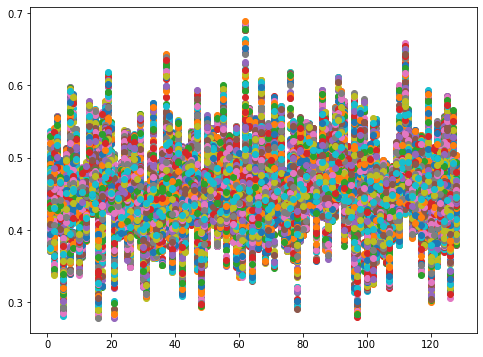

In [27]:
x_axis = np.linspace(1,Lv1_latent_dim,Lv1_latent_dim)

for i in range(num_time):
    plt.scatter(x_axis, validate_decoder[0,i,:])

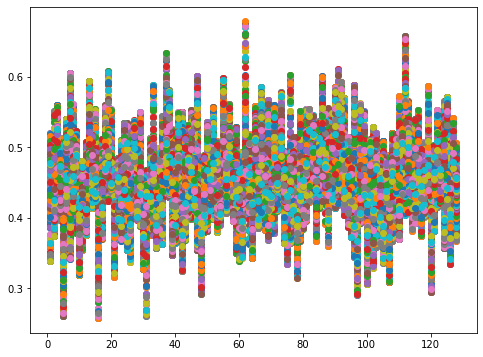

In [28]:
for i in range(num_time):
    plt.scatter(x_axis, validate[i,:])

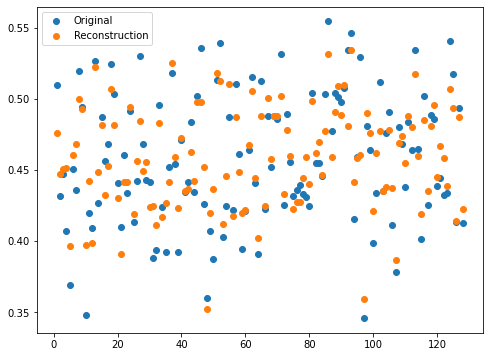

In [29]:
plt.scatter(x_axis, validate[0,:])
plt.scatter(x_axis, validate_decoder[0,0,:])

plt.legend(['Original','Reconstruction'],loc='upper left')

# Verify w/ Lv1...

In [30]:
temp4 = np.zeros([1,Lv2_latent_dim])
temp4[0,:] = Lv2_latent[0,:]

Lv1_latent_decoded,_ = Decoder(temp4)

print(Lv2_latent.shape)

(10, 16)


In [31]:
Lv1_latent_decoded = (Lv1_latent_decoded+f_minimum)*f_AT+f_mean

print(Lv2_input.shape)
print(Lv1_latent_decoded.shape)

(10, 800, 128)
(1, 800, 128)


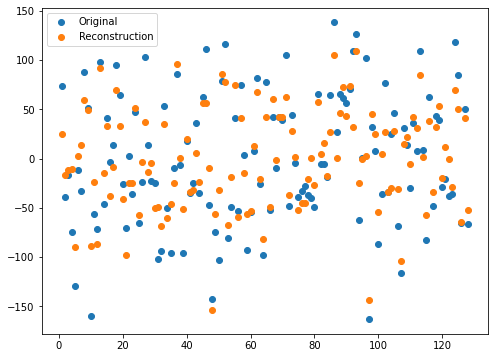

In [32]:
# Denormalized

plt.scatter(x_axis, f_orig[0,0,:], label='Original')
plt.scatter(x_axis, Lv1_latent_decoded[0,0,:], label='Reconstruction')
plt.legend()

In [33]:
filename2='Lv1_networks/decoder_%d.h5' % (epoch_1)
Decoder_Lv1 = load_model(filename2)
Decoder_Lv1.summary()

Model: "DECODER"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1830400)           236121600 
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1830400)           0         
_________________________________________________________________
reshape (Reshape)            (None, 14300, 128)        0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 14300, 256)        131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14300, 256)        1024      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14300, 256)        0   

In [34]:
temp5 = np.zeros([1, Lv1_latent_dim])
temp6 = np.zeros([num_time, num_node, num_var])

for i in range(num_time):
    temp5[0,:] = Lv1_latent_decoded[0,i,:]
    Lv1_decoded = Decoder_Lv1(temp5)
    temp6[i,:,:]=Lv1_decoded[0,:,:]

In [35]:
print(min_FOM)
print(AT)
print(mean)

temp7 = (temp6+min_FOM)*AT+mean

-0.5589248764443678
4.4899592095158
1.361459507680192e-18


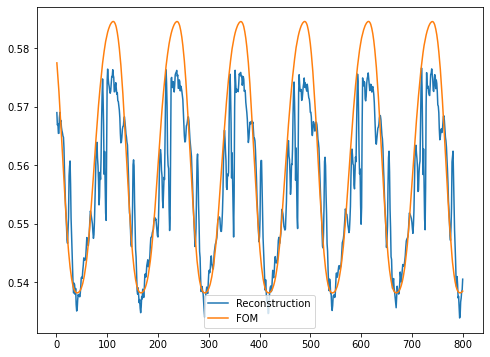

In [36]:
x_axis11 = np.linspace(1,num_time, num_time)
plt.plot(x_axis11, temp6[:,0,0], label='Reconstruction')
plt.plot(x_axis11, FOM_data[:,0,0,0], label='FOM')
plt.legend()

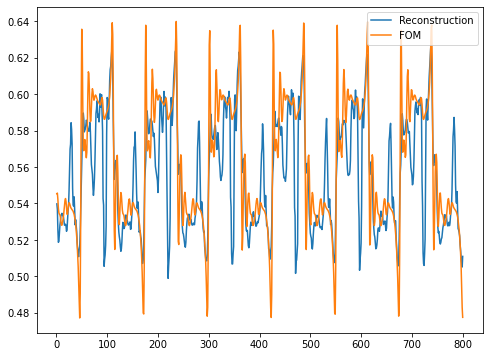

In [37]:
x_axis11 = np.linspace(1,num_time, num_time)
plt.plot(x_axis11, temp6[:,10,0], label='Reconstruction')
plt.plot(x_axis11, FOM_data[:,0,10,0], label='FOM')
plt.legend()

# Parametric interpolation in the latent space

Now as level 1, SVAE is complete, perform TVAE. Then, with the latent vector from TVAE, interpolate the latent vectors (which is with respect to the parameters). The latent vectors are interpolated and run decoder to gather interpolated latent vector for Lv 1, SVAE.

With the interpolated latent vector for Lv 1, SVAE, run it through the decoder of SVAE.

With the decoder of Lv 1, the interpolated flow field is constructed.


In [38]:
Lv2_latent.shape

(10, 16)

In [39]:
interp_latent = (Lv2_latent[interp1,:]+Lv2_latent[interp2,:])/2 #parameteric interpolation
interp_latent = interp_latent.reshape(1, -1)

interp_latent.shape

(1, 16)

In [40]:
interp_Lv1_latent,_ = Decoder(interp_latent, training=False)

interp_Lv1_latent.shape

TensorShape([1, 800, 128])

In [41]:
# Unscale

In [42]:
interp_Lv1_latent = ((interp_Lv1_latent+f_minimum)*f_AT)+f_mean

In [43]:
print(interp_Lv1_latent[0,0,0], f[0,0,0])
print(AT)
print(f_minimum)

tf.Tensor(39.30551, shape=(), dtype=float32) 0.5095995527550964
4.4899592095158
-0.45756424696325554


In [44]:
print(np.max(interp_Lv1_latent))
print(np.min(interp_Lv1_latent))
print(interp_Lv1_latent.shape)

404.01724
-354.99533
(1, 800, 128)


In [45]:
filename4 = 'interpolated_latentcode'

np.savetxt(filename4, interp_Lv1_latent[0,:,:], fmt = '%f')

In [46]:
pause;

NameError: name 'pause' is not defined